In [1]:

import corner

import astropy
print('astropy',astropy.__version__ )
from spectral_cube import SpectralCube      # This is a handy package for working with 3D data cubes
from astropy.coordinates import SkyCoord
from reproject import reproject_interp      
from reproject.mosaicking import find_optimal_celestial_wcs 
import regions
import reproject
print('reproject',reproject.__version__)
import spectral_cube
print('spectral_cube',spectral_cube.__version__)
import numpy as np                          
import pylab                                
import matplotlib 
import matplotlib.gridspec as gridspec                                                                                             
import scipy
import astropy.io.fits as fits                                                          
from astropy.wcs import WCS                 
from astropy import units as u              
import pyspeckit as psk   
import astrodendro
import matplotlib.colors as colors
from matplotlib import pyplot as plt
# Suppress warnings we don't care about:
import sys, traceback
import os
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
%matplotlib inline
from matplotlib.patches import Rectangle
#%matplotlib widget
import matplotlib.gridspec as gridspec
################
# MCMC FITTING #
################

###################################################################################################

# import required modules
from matplotlib.gridspec import GridSpec
from scipy.optimize import curve_fit
import scipy.optimize as op
import emcee
import corner


###################################################################################################

# linear fitting function, i.e. two parameter dimensions
def linear(x,a,c):
    return a*x+c

# equivalent power law function
def powlaw(x,a,b):
    return b*np.power(x,a)

# log likelihood
# according to https://ixkael.github.io/fitting-a-line-to-data-a-quick-tutorial/
def lnlikelihood(x, y, xerr, yerr, a, c):

    # only y errors:
    model = linear(x,a,c)
    return -0.5*(np.sum((y-model)**2/yerr**2 - np.log(yerr**2)))

    # # both x and y errors:
    # xyerr = np.sqrt(xerr**2. + yerr**2.)
    # model = linear(x, a, c)
    # return np.sum(-0.5*((y-model)/xyerr)**2 - 0.5*np.log(2*np.pi)-np.log(xyerr))

# negative log likelihood (required to fit maximum likelihood)
# according to https://ixkael.github.io/fitting-a-line-to-data-a-quick-tutorial/
def neg_lnlikelihood(params, x, y, xerr, yerr):
    a, c = params
    return -lnlikelihood(x, y, xerr, yerr, a, c)

# log prior
# simple flat priors on slope and intercept, large range but exclude rediculous values
def lnprior(a,c):
    if ( 0<a<10 ) and ( -10<c<10 ):
        return 0.0
    return -np.inf

# log probability function
# according to https://ixkael.github.io/fitting-a-line-to-data-a-quick-tutorial/
def lnprobability(params, x, y, xerr, yerr):
    a, c = params
    lp = lnprior(a,c)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlikelihood(x, y, xerr, yerr, a, c)


####################################################################################################
# a class to the actual work and fitting
####################################################################################################

class MCMC_fit:

    def __init__(self, x, y, x_err, y_err):
        self.source = None
        self.line   = None
        self.fit    = False
        self.fit_range = [None,None]
        self.x      = np.array(x)
        self.y      = np.array(y)
        self.x_err  = np.array(x_err)
        self.y_err  = np.array(y_err)
        self.ndim = 2
        self.a    = {'ls': None, 'ml': None, 'MCMC': None, 'perc': None}
        self.c    = {'ls': None, 'ml': None, 'MCMC': None, 'perc': None}
        self.nwalkers = 50
        self.nburnin  = 500
        self.nsteps   = 5000
        self.sampler  = None
        self.samples  = None
        self.xlabel   = 'x'
        self.ylabel   = 'y'
        self.figsize  = (6,6)
        self.plotcolor = None
        self.savepath = None

    def mask_bad_values(self):
        print("masking bad values ...")
        good_vals = np.isfinite(self.x) & np.isfinite(self.y) & np.isfinite(self.x_err) & np.isfinite(self.y_err)
        self.x     = self.x[good_vals]
        self.y     = self.y[good_vals]
        self.x_err = self.x_err[good_vals]
        self.y_err = self.y_err[good_vals]

    def restrict_range(self, fit_range=[None,None]):
        self.fit_range = fit_range
        print("restricting fit to "+str(self.fit_range)+" ...")
        if not ( fit_range[0] == None ):
            in_range = self.x > self.fit_range[0]
            self.x     = self.x[in_range]
            self.y     = self.y[in_range]
            self.x_err = self.x_err[in_range]
            self.y_err = self.y_err[in_range]
        if not ( fit_range[1] == None ):
            in_range = self.x < self.fit_range[1]
            self.x     = self.x[in_range]
            self.y     = self.y[in_range]
            self.x_err = self.x_err[in_range]
            self.y_err = self.y_err[in_range]

    # least squares fit
    def least_squares_fit(self):
        print("least squares fitting ...")
        coeff, covar = curve_fit(linear, self.x, self.y, sigma=self.y_err, p0=[1, 1])
        a, c  = coeff
        a_err = covar[0][0]
        c_err = covar[1][1]
        self.a['ls'] = [a,a_err]
        self.c['ls'] = [c,c_err]

    # maximum likelihood fit
    def maximum_likelihood_fit(self):
        print("maximum likelihood fitting ...")
        result = op.minimize(neg_lnlikelihood, [self.a['ls'][0], self.c['ls'][0]], args=(self.x, self.y, self.x_err, self.y_err))
        self.a['ml'], self.c['ml'] = result["x"]

    # run MCMC fit
    def MCMC_fit(self):
        print("Bayesian MCMC fitting ...")
        # initial values for walkers from least squares and maximum likelihood fits
        init_pos = [np.array([self.a['ml'], self.c['ml']]) +1e-2*np.random.randn(self.ndim) for i in range(self.nwalkers)]
        # run MCMC
        self.sampler = emcee.EnsembleSampler(self.nwalkers, self.ndim, lnprobability, args=(self.x, self.y, self.x_err, self.y_err))
        self.sampler.run_mcmc(init_pos, self.nsteps)
        self.samples = self.sampler.chain[:, 50:, :].reshape((-1, self.ndim))
        a_percentiles, c_percentiles = np.percentile(self.samples, [16, 50, 84], axis=0).T
        self.a['MCMC'] = [a_percentiles[1], a_percentiles[2]-a_percentiles[1], a_percentiles[1]-a_percentiles[0]]
        self.c['MCMC'] = [c_percentiles[1], c_percentiles[2]-c_percentiles[1], c_percentiles[1]-c_percentiles[0]]
        self.a['perc'] = [a_percentiles[0], a_percentiles[1], a_percentiles[2]]
        self.c['perc'] = [c_percentiles[0], c_percentiles[1], c_percentiles[2]]

    # plot walkers
    def plot_walkers(self):
        print("plotting walkers ...")
        fig,ax = plt.subplots(2, sharex=True)
        for w in np.arange(self.nwalkers):
            ax[0].plot(self.sampler.chain[w,:,0], color='k', linestyle='-', alpha=0.1)
            ax[1].plot(self.sampler.chain[w,:,1], color='k', linestyle='-', alpha=0.1)
        ax[1].set_xlabel('step')
        ax[0].set_ylabel('slope a')
        ax[1].set_ylabel('intercept c')
        ax[1].set_xlim(0,self.nsteps)
        mkdir(escape_filename(self.savepath))
        fig.savefig(os.path.join(self.savepath, self.source+'.'+self.line+'.walkers.png'), dpi=300, bbox_inches='tight')

    # corner plot
    def corner_plot(self):
        print("plotting parameter distributions ...")
        fig = corner.corner(self.samples, labels=['a', 'c'], quantiles=[0.16, 0.5, 0.84], show_titles=True)
        mkdir(escape_filename(self.savepath))
        fig.savefig(os.path.join(self.savepath, self.source+'.'+self.line+'.corner.png'), dpi=300, bbox_inches='tight')

    # plot x - y relation
    def plot_x_y(self):
        print("plotting x - y relation ...")
        fig,ax = plt.subplots(figsize=self.figsize)
        ax.scatter(np.power(10,self.x), np.power(10,self.y), marker='.', color='k', label='data', s=1, alpha=0.5, zorder=0)
        x = np.logspace(np.min(self.x)-np.log10(1.5), np.max(self.x)+np.log10(1.5), 100)

        # plot most likely
        ax.plot(x, powlaw(x,self.a['MCMC'][0],np.power(10,self.c['MCMC'][0])), lw=1, color="r", zorder=2, label='50 percentile fit')

        # plot random samples
        a, c = self.samples[np.random.randint(len(self.samples), size=1)][0]
        b = np.power(10,c)
        ax.plot(x, powlaw(x,a,b), color="k", alpha=0.1, zorder=2, label='random samples')
        for a, c in self.samples[np.random.randint(len(self.samples), size=10)]:
            b = np.power(10,c)
            ax.plot(x, powlaw(x,a,b), color="k", lw=1, alpha=0.1, zorder=1)

        ax.legend()
        ax.set_xlabel(self.xlabel)
        ax.set_ylabel(self.ylabel)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlim([0.75*np.power(10,np.min(self.x)),1.5*np.power(10,np.max(self.x))])
        ax.set_ylim([0.75*np.power(10,np.min(self.y)),  1.5*np.power(10,np.max(self.y))])
        mkdir(escape_filename(self.savepath))
        fig.savefig(os.path.join(self.savepath, self.source+'.'+self.line+'.xy.png'), dpi=300, bbox_inches='tight')

    def list_results(self):
        print("\n\n")
        print(self.source+" "+self.line)
        print("  "+'{:>10}{:>10}{:>10}'.format('least sq','max like','MCMC'))
        print("a "+'{:10.6f}{:10.6f}{:10.6f}'.format(self.a['ls'][0], self.a['ml'], self.a['MCMC'][0]))
        print("a-"+'{:10.6f}{:>10}{:10.6f}'.format(  self.a['ls'][1], "",           self.a['MCMC'][1]))
        print("a+"+'{:10.6f}{:>10}{:10.6f}'.format(  self.a['ls'][1], "",           self.a['MCMC'][2]))
        print("c "+'{:10.6f}{:10.6f}{:10.6f}'.format(self.c['ls'][0], self.c['ml'], self.c['MCMC'][0]))
        print("c-"+'{:10.6f}{:>10}{:10.6f}'.format(  self.c['ls'][1], "",           self.c['MCMC'][1]))
        print("c+"+'{:10.6f}{:>10}{:10.6f}'.format(  self.c['ls'][1], "",           self.c['MCMC'][2]))
        print("\n\n")

    def get_y10(self):
        """Calculate y for a scale of 10. This is more meaningful than the intercept (scale=1)."""
        # MCMC
        a  = self.a['perc'][1]
        am = self.a['perc'][0]
        ap = self.a['perc'][2]
        c  = self.c['perc'][1]
        cm = self.c['perc'][0]
        cp = self.c['perc'][2]
        # least squares
        a_ls     = self.a['ls'][0]
        a_ls_err = self.a['ls'][1]
        c_ls     = self.c['ls'][0]
        c_ls_err = self.c['ls'][1]
        y10_ls     = powlaw(10, a_ls, np.power(10,c_ls))
        y10_ls_err = np.log(10)*np.power(10,a_ls+c_ls) *np.sqrt(a_ls_err**2+c_ls_err**2)

        # best fit sigma10
        self.y10 = {'MCMC': [powlaw(10, a, np.power(10,c)), powlaw(10, am, np.power(10,cm)), powlaw(10, ap, np.power(10,cp))],
                    'ls':   [y10_ls, y10_ls_err]}

        # distribution of sigma10
        self.y10s = {'MCMC': [powlaw(10, a, np.power(10,c)) for a, c in self.samples[np.random.randint(len(self.samples), size=100)]]}


####################################################################################################
# fit and plot meta function
####################################################################################################

def fit_MCMC(log_x, log_y, log_x_err, log_y_err, source, line, savepath, xlabel=None, ylabel=None, plotcolor='r', fit_range=[None,None]):
    MCMC = MCMC_fit(log_x, log_y, log_x_err, log_y_err)
    MCMC.savepath = savepath
    MCMC.source   = source
    MCMC.line     = line
    MCMC.plotcolor = plotcolor
    MCMC.xlabel   = xlabel
    MCMC.ylabel   = ylabel

    MCMC.mask_bad_values()
    MCMC.restrict_range(fit_range)
    MCMC.least_squares_fit()
    MCMC.maximum_likelihood_fit()
    MCMC.MCMC_fit()
    MCMC.plot_walkers()
    MCMC.corner_plot()
    MCMC.plot_x_y()
    MCMC.get_y10()
    MCMC.fit = True
    MCMC.list_results()

    return MCMC


####################################################################################################
# print formatted slopes and intercepts
####################################################################################################

def print_formatted(MCMC_list, datatype):
    print(datatype)
    print('{:>8} & {:>10} & {:>6} & {:>6} & {:>6} & {:>6} & {:>6} & {:>6} & {:>8} & {:>8} & {:>8}'.format('source','line','a_16','a_50','a_84','c_16','c_50','c_84','y10','y10 -','y10 +'))
    for m in MCMC_list:
        try:
            print('{:>8} & {:>10} & {:6.2f} & {:6.2f} & {:6.2f} & {:6.2f} & {:6.2f} & {:6.2f} & {:8.1f} & {:8.1f} & {:8.1f}'.format(m.source, m.line, m.a['perc'][0], m.a['perc'][1], m.a['perc'][2], m.c['perc'][0], m.c['perc'][1], m.c['perc'][2], m.y10[0], m.y10[1], m.y10[2]))
        except:
            print('{:>8} & {:>10} & {:<10}'.format(m.source, m.line, 'no fit'))
            
def mkdir(path):
    """mkdir
    Parameters
    ----------
    path : str
        Path to directory to create
    """
    import os
    if ' ' in path:
        raise Exception("Path contains spaces! This will most probably not create the directory you want!")
    if not os.path.exists(path):
        os.system('mkdir -p '+path)
        print("Created "+path)
        
def escape_filename(str):
    """Escape the most often used characters in a string to be used as a file name.
    Parameters
    ----------
    str : str
        Input string to be escaped.
    Returns
    -------
    str
        String with escaped '(', ')'; replaced ' ' by '_' and removed '$'.
        
    """
    str = str.replace('(',r'\(')
    str = str.replace(')',r'\)')
    str = str.replace(' ',r'_')
    str = str.replace('$','')
    return str



astropy 5.1.dev153+gb740594dc
reproject 0.8
spectral_cube 0.6.1.dev22+g003ef16


(20, 6, 6, 6, 6, 6, 6)
4.3
5 5 2 0 2 2
[4.35087535 0.73553595] [[ 0.03474577 -0.00373604]
 [-0.00373604  0.00047938]]
0 5 5 2 0 0 2 2 Clear


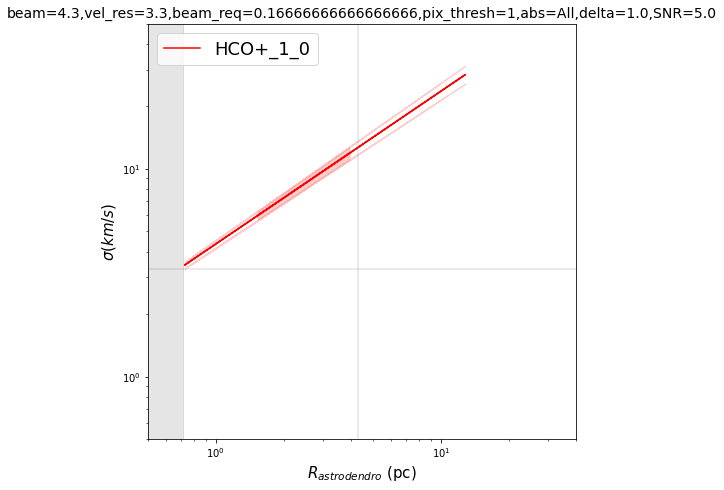

4.3
5 5 2 0 2 2
[4.43043846 0.76748978] [[ 0.0356971  -0.00356534]
 [-0.00356534  0.00041782]]
1 5 5 2 0 0 2 2 Clear


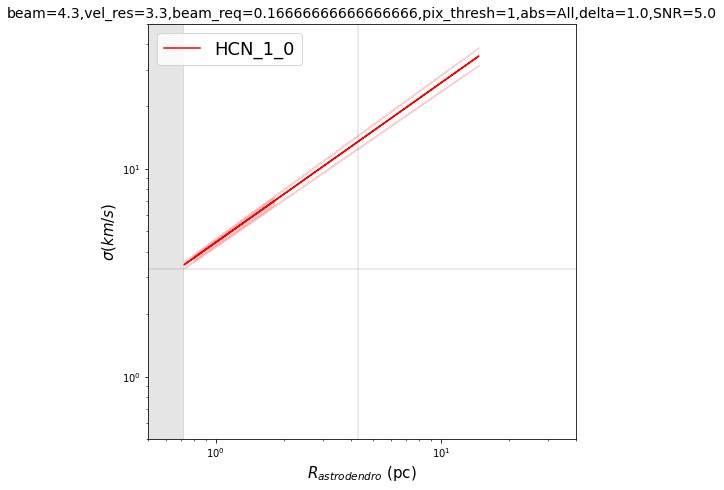

3
5 5 2 0 2 2
[3.50332037 0.77282548] [[ 1.08192184e-03 -1.46489666e-04]
 [-1.46489666e-04  3.10135843e-05]]
5 5 5 2 0 0 2 2 Clear


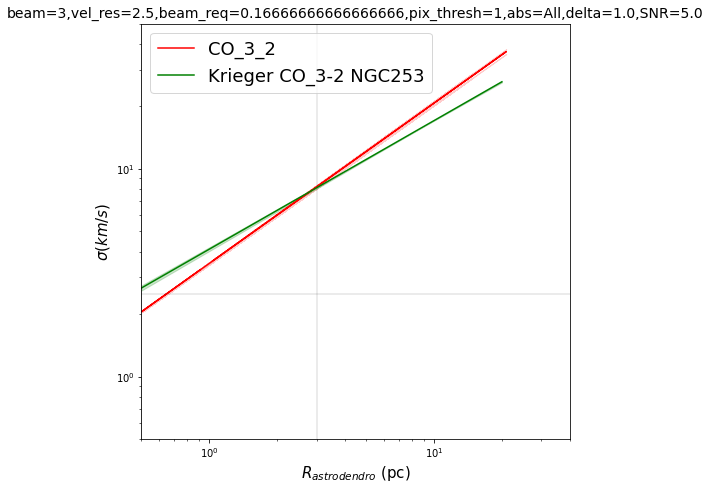

In [43]:

#All, all abs levels
#Newest method
#SL ngc


CMZLs = ["HCO+_1_0","HCN_1_0",'H13CN_1_0','H13CO+_1_0',"CO_3_2","CO_3_2"]




Line_Names = ['_NGC_HCOp_J1_0_','_NGC_HCN_J1_0_','','','','_NGC_CO_J3_2_']






NGCNames=list(np.load("Names_New_All_Kinds.npy",allow_pickle=True))
#print(NGCNames)
print(np.shape(NGCNames))
#CMZNames=list(np.load("CMZ_Names_New_All_Kinds.npy"))


NM_mod=''
Abs_Levels = ["All","None","No Clusters", "None (m)", "None All Channels"]
Suffixes=['','_NA','_No_Clusters','None_m','None_All_Channels']
savePath='/home/ben/Documents/Grad Stuff/MM data/Result Files'

Plot=True
for i in range(0,6):
    
    
    
    
    Params=np.genfromtxt(os.path.join(savePath,"_NGC_CO_J3_2_"+"_Params"))#[iterations,iter_factor ,Line_Name,Name,ovs,min_vel,FOV,Min_res,Min_beam_req]
    iterations,iter_factor,ovs,min_vel,FOV,Min_res,Min_beam_req = int(Params[0]),Params[1],int(Params[2]),Params[3],np.array(Params[4]),Params[5],Params[6]
    iterations=6
    for kl in range(5,6):
        
        if(Line_Names[i]==''):
            break
    
        
        
        Prime_Beam = Min_res*((kl*iter_factor+1))#
        if(kl==5):
            if(i==5):
                Prime_Beam=3
            else:
                Prime_Beam=4.3
        print(Prime_Beam)
    
    
        for km in range(5,6):
            
            vel_prime = min_vel*((km*iter_factor+1))
            
            if(km==5):
                if(i==5):
                    vel_prime=2.5
                else:
                    vel_prime=3.3
            fig = plt.figure(1,figsize=(8,8))
            gs0 = gridspec.GridSpec(len(Suffixes), 1, figure=fig)
            
            
            
            min_space=np.array([[np.full(100,Prime_Beam/ovs)],[np.linspace(-100,1000,100)]])
            Beams_s=np.array([[np.full(100,Prime_Beam)],[np.linspace(-100,1000,100)]])
            spec=np.array([[np.linspace(-100,1000,100)],[np.full(100,vel_prime)]])
            zeroes=np.array([[np.full(100,0)]])
            
            
            #for k5 in range(len(Suffixes)):
            for k5 in range(0,1):

                
                
                
                Suffix=Suffixes[k5]
                Abs_Level =Abs_Levels[k5]

                
                

                
                
                
                
                #fig.suptitle((CMZLs[i]+" Size-Linewidth Relation ("+str(Abs_Level)+")"), fontsize=18)
                #gs0.set_title((CMZLs[i]+" Size-Linewidth Relation ("+str(Abs_Level)+")"), fontsize=18)
                
                gs00 = gridspec.GridSpecFromSubplotSpec(iterations, iterations, subplot_spec=gs0[k5])

                
                

                for k3 in range(2,3):

                    beam_req = Min_beam_req*(k3+1)
                    if kl==5:
                        beam_req=.5/3
                    
                    beam_req_line = Beams_s*beam_req
                    for k4 in range(0,1):
                        for k6 in range(2,3):
                            delt_factor = (3/5+k6/5)

                            for k7 in range(2,3):
                                noise_factor = (3/5+k7/5)
                                
                                
                                print(kl,km,k3,k4,k6,k7)
                                
                                #ax = fig.add_subplot(gs00[k6, k7])
                                ax = fig.add_subplot(1,1,1)

                                try:

                                    pix_thresh_factor = k4+1

                                    Name = NGCNames[i][kl][km][k3][k4][k6][k7]
                                    #print(Name)








                                    rname=Name+"Radii"

                                    sname=Name+"Sigmas"

                                    sEname=Name+"V_err"

                                    radsBase=[[],[]]
                                    sigsBase=[[],[]]

                                    sigs_err_Base=[[],[]]
                                    radsBase[0],radsBase[1] = np.genfromtxt(os.path.join(savePath,rname+"_Leaves"+Suffix))*10**6, np.genfromtxt(os.path.join(savePath,rname+"_Branches"+Suffix))*10**6#km/s
                                    sigsBase[0] ,sigsBase[1] = np.genfromtxt(os.path.join(savePath,sname+"_Leaves"+Suffix)),np.genfromtxt(os.path.join(savePath,sname+"_Branches"+Suffix))#km/s

                                    sigs_err_Base[0] ,sigs_err_Base[1] = np.genfromtxt(os.path.join(savePath,sEname+"_Leaves"+Suffix)),np.genfromtxt(os.path.join(savePath,sEname+"_Branches"+Suffix))#km/s



                                    er_r=1








                                    rads=np.concatenate((radsBase[0],radsBase[1]))
                                    sigs = np.concatenate((sigsBase[0],sigsBase[1]))
                                    sigs_err = np.concatenate((sigs_err_Base[0],sigs_err_Base[1]))


                                    from scipy.optimize import curve_fit

                                    def func(R,a,b):
                                        return a*R**(b)

                                    x   =  rads
                                    y     = sigs
                                    y_err = sigs_err

                                    try:
                                        #(Vars, CoVar) = (curve_fit(func, x, y, sigma=y_err))
                                        (Vars, CoVar) = (curve_fit(func, x, y))
                                    except:
                                        (Vars, CoVar) = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
                                    np.savetxt(os.path.join(savePath,Name+"_NGC253_Coeffs"+Suffix+NM_mod), Vars,fmt='%s')
                                    np.savetxt(os.path.join(savePath,Name+"_NGC253_Coeff_CoVar"+Suffix+NM_mod),CoVar ,fmt='%s')
                                    np.savetxt(os.path.join(savePath,Name+"_NGC253_Fit_weights"+Suffix+NM_mod),[(len(sigs))] ,fmt='%s')
                                    #np.savetxt(CMZName+"_CMZ_Coeffs"+Suffix, Vars2,fmt='%s')
                                    #np.savetxt(CMZName+"_CMZ_Coeff_CoVar"+Suffix,CoVar2 ,fmt='%s')

                                    if Plot:
                                        print(Vars,CoVar)
                                        gggg=ax.plot(x,func(x,Vars[0],Vars[1]),color="Red",label=CMZLs[i])
                                        
                                        ax.fill_between(x,func(x,Vars[0]+np.sqrt(CoVar[0][0])*er_r,Vars[1]+np.sqrt(CoVar[1][1])*er_r),func(x,Vars[0]-np.sqrt(CoVar[0][0])*er_r,Vars[1]-np.sqrt(CoVar[1][1])*er_r),alpha=.2,color="Red")
                                        #ax.errorbar(x, y, yerr=y_err,lolims=True, uplims=True,fmt="o",color="Blue")

                                        ax.fill_betweenx(beam_req_line[1][0],beam_req_line[0][0] ,zeroes[0][0], alpha=.1,color="Black")
                                        ax.plot(Beams_s[0][0],Beams_s[1][0], alpha=.1,color="Black")

                                        spec=np.array([[np.linspace(-100,1000,100)],[np.full(100,vel_prime)]])

                                        ax.plot(spec[0][0],spec[1][0], alpha=.1,color="Black")

                                        #ax.scatter(x,y,color="Red",alpha=.51,s=50)



                                        ax.set_xlabel(r'$R_{astrodendro}$ (pc)',fontsize=15)
                                        ax.set_ylabel(r'$\sigma   (km/s)$',fontsize=15)
                                        ax.set_yscale('log')
                                        ax.set_xscale('log')
                                        #string = ("NGC253 (Binned"+Suffix+"): a="+str(round(Vars[0],3))+" +-" + str(round(np.sqrt(CoVar[0][0]),3)) +", b="+str(round(Vars[1],3))+"+-" + str(round(np.sqrt(CoVar[1][1]),3)) )




                                        #axA.annotate(s=string,fontsize=18,xy=(0.01,.01+0.025*Index),xycoords="axes fraction")
                                        ax.set_xlim(0.5,40.0)
                                        ax.set_ylim(0.5,50.0)

                                        #axA.legend(loc='upper left',fontsize=18)


                                        ax.set_title(("beam={0},vel_res={1},beam_req={2},pix_thresh={3},abs={4},delta={5},SNR={6}".format(Prime_Beam,vel_prime,beam_req,pix_thresh_factor,Abs_Level,delt_factor,noise_factor*5)), fontsize=14)
                                        
                                        import datetime
                                        now = str(datetime.datetime.now())
                                        string=now+ " "+ "Nico's method ()"
                                        ax.annotate(s=string,fontsize=18,xy=(0.01,1.0),xycoords="axes fraction")
                                        if i==5:

                                            def NicoCOCoef(sig10,exp):
                                                return sig10/10**exp
                                            def NicoAErr(Aer,b,bErr):
                                                return np.sqrt(Aer**2/10**(2*b)+b**2*Aer**2*bErr**2/b**(2*b+2))

                                            Nxs=np.linspace(np.nanmin(.5),np.nanmax(20),50)
                                            xs=np.linspace(np.nanmin(.8),np.nanmax(20),50)
                                            NicoCO32 = .72
                                            NicoCOErr32=.03
                                            NicoCO_32= 8.9
                                            NicoCO_32Err= .2
                                            NNicoCO32 = .62
                                            NNicoCOErr32=.01
                                            NNicoCO_32=17.1
                                            NNicoCO_32Err= .1


                                            NNI32 = func(Nxs,NicoCOCoef(NNicoCO_32,NNicoCO32),NNicoCO32)
                                            NNIU32 = func(Nxs,NicoCOCoef(NNicoCO_32+NicoAErr(NNicoCO_32Err,NNicoCO32,NNicoCOErr32)*er_r,NNicoCO32+NNicoCOErr32*er_r),NNicoCO32+ NNicoCOErr32*er_r)
                                            NNIL32 = func(Nxs,NicoCOCoef(NNicoCO_32-NicoAErr(NNicoCO_32Err,NNicoCO32,NNicoCOErr32)*er_r,NNicoCO32-NNicoCOErr32*er_r),NNicoCO32- NNicoCOErr32*er_r)

                                            NCI32 = func(xs,NicoCOCoef(NicoCO_32,NicoCO32),NicoCO32)
                                            NCIU32 = func(xs,NicoCOCoef(NicoCO_32+NicoAErr(NicoCO_32Err,NicoCO32,NicoCOErr32)*er_r,NicoCO32+NicoCOErr32*er_r),NicoCO32+ NicoCOErr32*er_r)
                                            NCIL32 = func(xs,NicoCOCoef(NicoCO_32-NicoAErr(NicoCO_32Err,NicoCO32,NicoCOErr32)*er_r,NicoCO32-NicoCOErr32*er_r),NicoCO32- NicoCOErr32*er_r)



                                            NNicoNM32 = ax.plot(Nxs,NNI32,c='green',label='Krieger CO_3-2 NGC253')
                                            NNicoFill32 = ax.fill_between(Nxs,NNIL32,NNIU32,color="green",alpha=.2)
                                    ax.legend(loc='upper left',fontsize=18)





                                    print(i,kl,km,k3,k4,k5,k6,k7,"Clear")
                                except Exception as e:
                                    print(e)
                                    print(i,kl,km,k3,k4,k5,k6,k7,"F")
                                    #print("Failed")
                                    #print("-"*60)
                                    #traceback.print_exc(file=sys.stdout)
                                if Plot:

                                    plt.tight_layout(pad=5, w_pad=5 ,h_pad=50.0)

                                    pylab.show()
                                    fname = "All_"+str(Prime_Beam)+"_beam_"+str(vel_prime) +"_vel_res_"+Suffix+"_.jpeg"
                                    fig.savefig(bbox_inches='tight',fname=fname)

4.3
5 5 2 0 2 2
(220,)
[2.96543406 0.72659516] [[ 0.06353033 -0.00742559]
 [-0.00742559  0.00093664]]
[4.35087535 0.73553595] [[ 0.03474577 -0.00373604]
 [-0.00373604  0.00047938]]
0 5 5 2 0 0 2 2 Clear


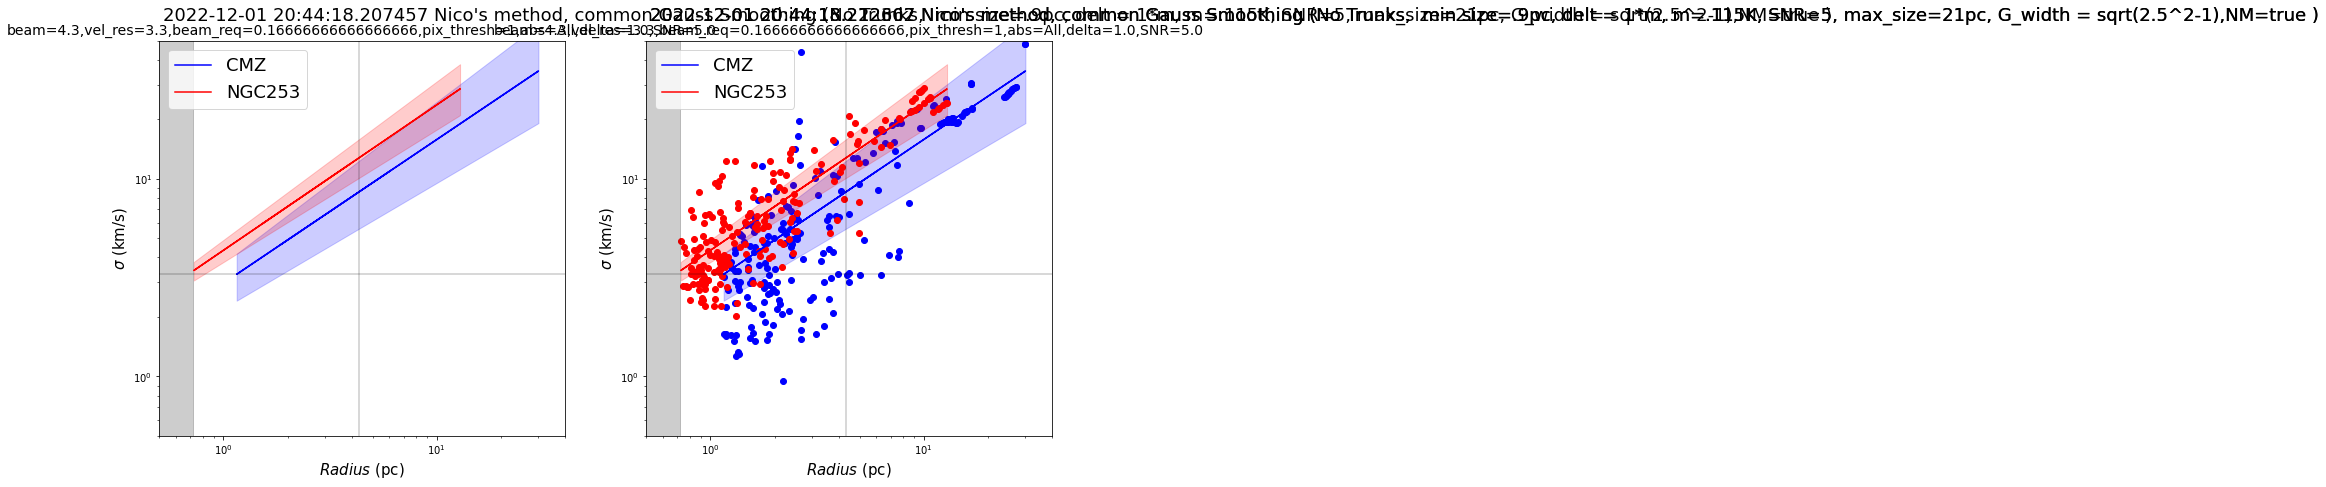

4.3
5 5 2 0 2 2
(412,)
[2.98962749 0.75370357] [[ 0.01923192 -0.00210915]
 [-0.00210915  0.00024912]]
[4.43043846 0.76748978] [[ 0.0356971  -0.00356534]
 [-0.00356534  0.00041782]]
1 5 5 2 0 0 2 2 Clear


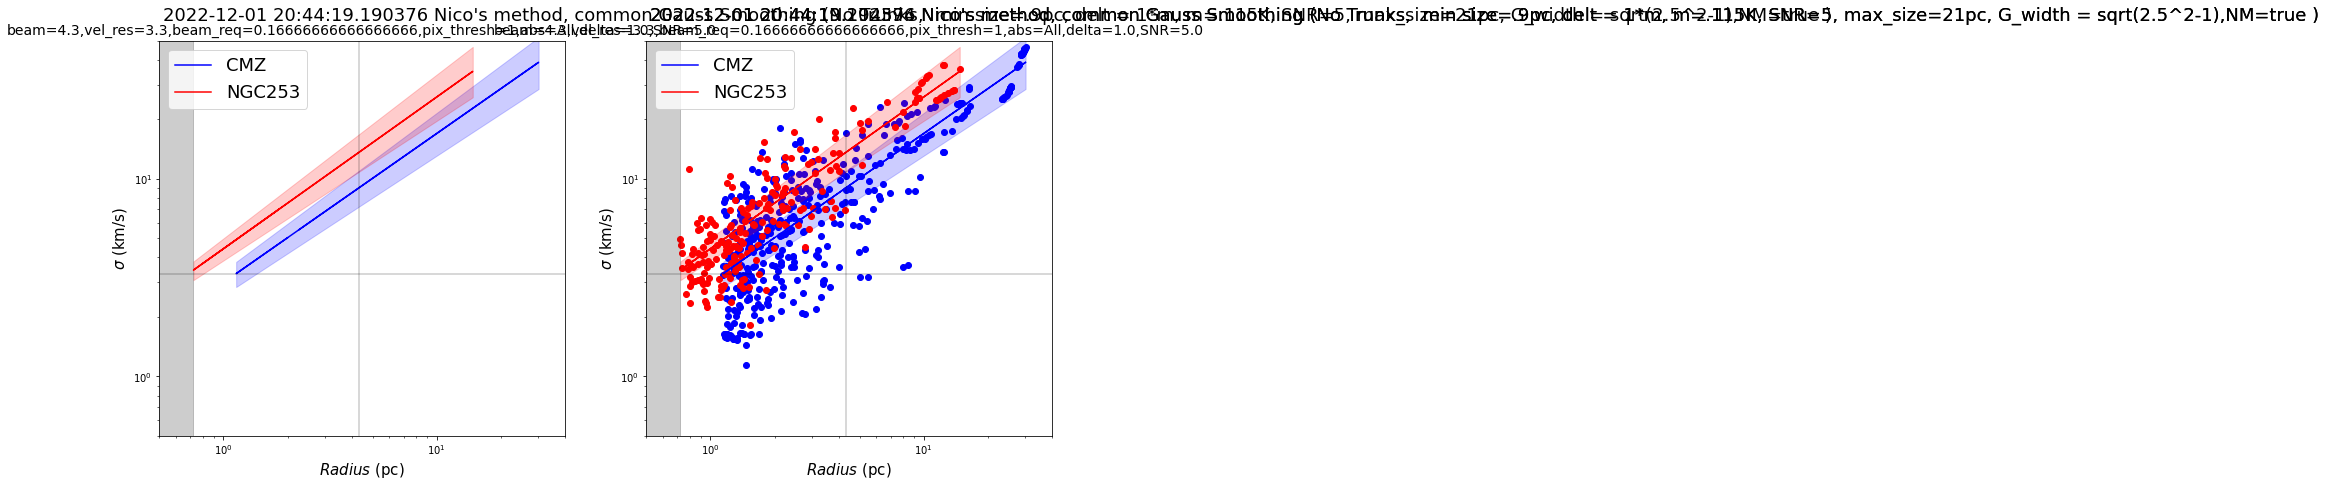

4.3
5 5 2 0 2 2
(497,)
[2.31016747 0.79823027] [[ 0.02199199 -0.00432223]
 [-0.00432223  0.00095744]]
[3.33507326 0.79884761] [[ 0.03209427 -0.0045516 ]
 [-0.0045516   0.00083355]]
5 5 5 2 0 0 2 2 Clear


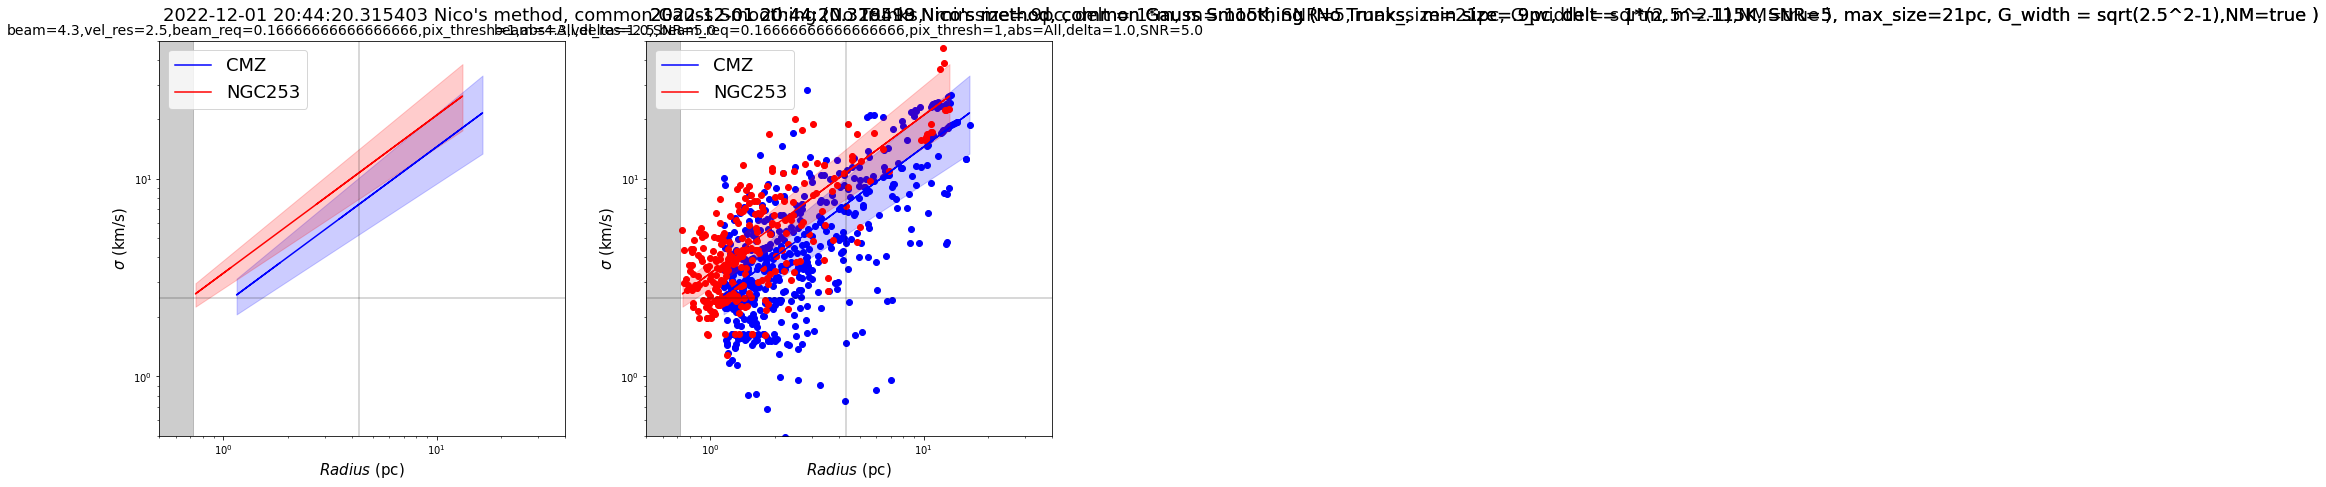

In [14]:

#All, all abs levels
#Newest method
#SL cmz


CMZLs = ["HCO+_1_0","HCN_1_0",'H13CN_1_0','H13CO+_1_0',"CO_3_2",'CO_J3']




Line_Names = ['_NGC_HCOp_J1_0_','_NGC_HCN_J1_0_','','','','_NGC_CO_J3_2_']


CMZNames=["CMZ_HCO+_J1_0_all_Cropped_4.3pc_beam__CMZ_HCO_J1_0_4.3_start70x360pc_3.3_vel_res_0.26666666666666666_beam_size_req_1_times_beam_pixels_1.0_delt_factor_5.0_SNR_NEW.fits",
         "CMZ_HCN_J1_0_all_Cropped_4.3pc_beam__CMZ_HCN_J1_0_4.3_start70x360pc_3.3_vel_res_0.26666666666666666_beam_size_req_1_times_beam_pixels_1.0_delt_factor_5.0_SNR_NEW.fits",
         "","","",
         "CMZ_CO_J3_2_all_NEW_Cropped_4.3pc_beam__CMZ_CO_J3_2_4.3_startSmoothe_to_3.3Edges70x360pc_3.3_vel_res_0.26666666666666666_beam_size_req_1_times_beam_pixels_1.0_delt_factor_5.0_SNR_NEW.fits"]
NGCNames=["HCO+ J1-0_Abs_New_Cropped_4.3pc_beam__NGC_HCOp_J1_0_70x360pc_3.3_vel_res_0.16666666666666666_beam_size_req_1_times_beam_pixels_1.0_delt_factor_5.0_SNR.fits",
         "HCN J1-0_Abs_New_Cropped_4.3pc_beam__NGC_HCN_J1_0_70x360pc_3.3_vel_res_0.16666666666666666_beam_size_req_1_times_beam_pixels_1.0_delt_factor_5.0_SNR.fits",
         "","","",
         "CO 3-2_Abs_New_4.3_start_Cropped_4.3pc_beam__NGC_CO_J3_2_70x360pc_3.3_vel_res_0.16666666666666666_beam_size_req_1_times_beam_pixels_1.0_delt_factor_5.0_SNR.fits"]


Abs_Levels = ["All","None","No Clusters", "None (m)", "None All Channels"]
Suffixes=['','_NA','_No_Clusters','None_m','None_All_Channels']
savePath='/home/ben/Documents/Grad Stuff/MM data/Result Files'
NM_mod=''

Plot=True
for i in range(0,6):
    
    
    
    
    Params=np.genfromtxt(os.path.join(savePath,"_NGC_CO_J3_2_"+"_Params"))#[iterations,iter_factor ,Line_Name,Name,ovs,min_vel,FOV,Min_res,Min_beam_req]
    iterations,iter_factor,ovs,min_vel,FOV,Min_res,Min_beam_req = int(Params[0]),Params[1],int(Params[2]),Params[3],np.array(Params[4]),Params[5],Params[6]
    iterations=6
    for kl in range(5,6):
        
        if(Line_Names[i]==''):
            break
    
        
        
        Prime_Beam = Min_res*((kl*iter_factor+1))#
        if(kl==5):
            if(i==5):
                Prime_Beam=4.3
            else:
                Prime_Beam=4.3
        print(Prime_Beam)
    
    
        for km in range(5,6):
            
            vel_prime = min_vel*((km*iter_factor+1))
            
            if(km==5):
                if(i==5):
                    vel_prime=2.5
                else:
                    vel_prime=3.3
            fig = plt.figure(1,figsize=(16,16))
            gs0 = gridspec.GridSpec(len(Suffixes), 1, figure=fig)
            
            
            
            min_space=np.array([[np.full(100,Prime_Beam/ovs)],[np.linspace(-100,1000,100)]])
            Beams_s=np.array([[np.full(100,Prime_Beam)],[np.linspace(-100,1000,100)]])
            spec=np.array([[np.linspace(-100,1000,100)],[np.full(100,vel_prime)]])
            zeroes=np.array([[np.full(100,0)]])
            
            
            #for k5 in range(len(Suffixes)):
            for k5 in range(0,1):

                
                
                
                Suffix=Suffixes[k5]
                Abs_Level =Abs_Levels[k5]

                
                

                
                
                
                
                #fig.suptitle((CMZLs[i]+" Size-Linewidth Relation ("+str(Abs_Level)+")"), fontsize=18)
                #gs0.set_title((CMZLs[i]+" Size-Linewidth Relation ("+str(Abs_Level)+")"), fontsize=18)
                
                gs00 = gridspec.GridSpecFromSubplotSpec(iterations, iterations, subplot_spec=gs0[k5])

                
                

                for k3 in range(2,3):

                    beam_req = Min_beam_req*(k3+1)
                    if kl==5:
                        beam_req=.5/3
                    
                    beam_req_line = Beams_s*beam_req
                    for k4 in range(0,1):
                        for k6 in range(2,3):
                            delt_factor = (3/5+k6/5)

                            for k7 in range(2,3):
                                noise_factor = (3/5+k7/5)
                                
                                
                                print(kl,km,k3,k4,k6,k7)
                                
                                #ax = fig.add_subplot(gs00[k6, k7])
                                ax = fig.add_subplot(2,2,1)
                                ax2 = fig.add_subplot(2,2,2)

                                try:

                                    pix_thresh_factor = k4+1

                                    Name = CMZNames[i]
                                    
                                    #print(Name)








                                    rname=Name+"Radii"

                                    sname=Name+"Sigmas"

                                    sEname=Name+"V_err"

                                    radsBase=[[],[]]
                                    sigsBase=[[],[]]

                                    sigs_err_Base=[[],[]]
                                    radsBase[0],radsBase[1] = np.genfromtxt(os.path.join(savePath,rname+"_Leaves"+Suffix))*10**6, np.genfromtxt(os.path.join(savePath,rname+"_Branches"+Suffix))*10**6#km/s
                                    sigsBase[0] ,sigsBase[1] = np.genfromtxt(os.path.join(savePath,sname+"_Leaves"+Suffix)),np.genfromtxt(os.path.join(savePath,sname+"_Branches"+Suffix))#km/s
                                    
                                    sigs_err_Base[0] ,sigs_err_Base[1] = np.genfromtxt(os.path.join(savePath,sEname+"_Leaves"+Suffix)),np.genfromtxt(os.path.join(savePath,sEname+"_Branches"+Suffix))#km/s



                                    er_r=3 








                                    rads=np.concatenate((radsBase[0],radsBase[1]))
                                    sigs = np.concatenate((sigsBase[0],sigsBase[1]))
                                    sigs_err = np.concatenate((sigs_err_Base[0],sigs_err_Base[1]))
                                    print(np.shape(rads))

                                    from scipy.optimize import curve_fit

                                    def func(R,a,b):
                                        return a*R**(b)

                                    x   =  rads
                                    y     = sigs
                                    y_err = sigs_err

                                    try:
                                        #(Vars, CoVar) = (curve_fit(func, x, y, sigma=y_err))
                                        (Vars, CoVar) = (curve_fit(func, x, y, ))
                                    except:
                                        (Vars, CoVar) = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
                                    np.savetxt(os.path.join(savePath,Name+"_CMZ_Coeffs"+Suffix+NM_mod), Vars,fmt='%s')
                                    np.savetxt(os.path.join(savePath,Name+"_CMZ_Coeff_CoVar"+Suffix+NM_mod),CoVar ,fmt='%s')

                                    np.savetxt(os.path.join(savePath,Name+"_CMZ_Fit_weights"+Suffix+NM_mod),[(len(sigs))] ,fmt='%s')
                                    #np.savetxt(CMZName+"_CMZ_Coeffs"+Suffix, Vars2,fmt='%s')
                                    #np.savetxt(CMZName+"_CMZ_Coeff_CoVar"+Suffix,CoVar2 ,fmt='%s')
                                    fx = np.linspace(min(x),max(x),50)
                                    if Plot:
                                        print(Vars,CoVar)
                                        gggg=ax.plot(x,func(x,Vars[0],Vars[1]),color="Blue",label="CMZ")
                                        ax.fill_between(fx,func(fx,Vars[0]+np.sqrt(CoVar[0][0])*er_r,Vars[1]+np.sqrt(CoVar[1][1])*er_r),func(fx,Vars[0]-np.sqrt(CoVar[0][0])*er_r,Vars[1]-np.sqrt(CoVar[1][1])*er_r),alpha=.2,color="Blue")
                                        #ax.errorbar(x, y, yerr=y_err,lolims=True, uplims=True,fmt="o",color="Blue")
                                        
                                        ax.fill_betweenx(beam_req_line[1][0],beam_req_line[0][0] ,zeroes[0][0], alpha=.1,color="Black")
                                        ax.plot(Beams_s[0][0],Beams_s[1][0], alpha=.1,color="Black")

                                        spec=np.array([[np.linspace(-100,1000,100)],[np.full(100,vel_prime)]])

                                        ax.plot(spec[0][0],spec[1][0], alpha=.1,color="Black")

                                        #ax.scatter(x,y,color="Red",alpha=.51,s=50)



                                        ax.set_xlabel(r'$R_{astrodendro}$ (pc)',fontsize=15)
                                        ax.set_ylabel(r'$\sigma   (km/s)$',fontsize=15)
                                        ax.set_yscale('log')
                                        ax.set_xscale('log')
                                        #string = ("NGC253 (Binned"+Suffix+"): a="+str(round(Vars[0],3))+" +-" + str(round(np.sqrt(CoVar[0][0]),3)) +", b="+str(round(Vars[1],3))+"+-" + str(round(np.sqrt(CoVar[1][1]),3)) )




                                        #axA.annotate(s=string,fontsize=18,xy=(0.01,.01+0.025*Index),xycoords="axes fraction")
                                        ax.set_xlim(0.5,40.0)
                                        ax.set_ylim(0.5,50.0)

                                        #axA.legend(loc='upper left',fontsize=18)

                                        import datetime
                                        now = str(datetime.datetime.now())
                                        string=now+ " "+ "Nico's method, common Gauss Smoothing (No Trunks,  min size=.9pc, delt = 1*m, m=.115K, SNR=5, max_size=21pc, G_width = sqrt(2.5^2-1),NM=true )"
                                        ax.annotate(s=string,fontsize=18,xy=(0.01,1.05),xycoords="axes fraction")
                                        
                                        
                                        ax.set_title(("beam={0},vel_res={1},beam_req={2},pix_thresh={3},abs={4},delta={5},SNR={6}".format(Prime_Beam,vel_prime,beam_req,pix_thresh_factor,Abs_Level,delt_factor,noise_factor*5)), fontsize=14)
                                        
                                        gggsag=ax2.plot(x,func(x,Vars[0],Vars[1]),color="Blue",label="CMZ")
                                        gggasfg=ax2.scatter(x,y,color="Blue")
                                        ax2.fill_between(fx,func(fx,Vars[0]+np.sqrt(CoVar[0][0])*er_r,Vars[1]+np.sqrt(CoVar[1][1])*er_r),func(fx,Vars[0]-np.sqrt(CoVar[0][0])*er_r,Vars[1]-np.sqrt(CoVar[1][1])*er_r),alpha=.2,color="Blue")
                                        #ax2.errorbar(x, y, yerr=y_err,lolims=True, uplims=True,fmt="o",color="Blue")
                                        
                                        ax2.fill_betweenx(beam_req_line[1][0],beam_req_line[0][0] ,zeroes[0][0], alpha=.1,color="Black")
                                        ax2.plot(Beams_s[0][0],Beams_s[1][0], alpha=.1,color="Black")

                                        spec=np.array([[np.linspace(-100,1000,100)],[np.full(100,vel_prime)]])

                                        ax2.plot(spec[0][0],spec[1][0], alpha=.1,color="Black")

                                        #ax2.scatter(x,y,color="Red",alpha=.51,s=50)



                                        ax2.set_xlabel(r'$Radius$ (pc)',fontsize=15)
                                        ax2.set_ylabel(r'$\sigma  $ (km/s)',fontsize=15)
                                        ax2.set_yscale('log')
                                        ax2.set_xscale('log')
                                        #string = ("NGC253 (Binned"+Suffix+"): a="+str(round(Vars[0],3))+" +-" + str(round(np.sqrt(CoVar[0][0]),3)) +", b="+str(round(Vars[1],3))+"+-" + str(round(np.sqrt(CoVar[1][1]),3)) )




                                        #ax2A.annotate(s=string,fontsize=18,xy=(0.01,.01+0.025*Index),xycoords="ax2es fraction")
                                        ax2.set_xlim(0.5,40.0)
                                        ax2.set_ylim(0.5,50.0)

                                        #ax2A.legend(loc='upper left',fontsize=18)

                                        import datetime
                                        now = str(datetime.datetime.now())
                                        string=now+ " "+ "Nico's method, common Gauss Smoothing (No Trunks,  min size=.9pc, delt = 1*m, m=.115K, SNR=5, max_size=21pc, G_width = sqrt(2.5^2-1),NM=true )"
                                        ax2.annotate(s=string,fontsize=18,xy=(0.01,1.05),xycoords="axes fraction")
                                        
                                        
                                        ax2.set_title(("beam={0},vel_res={1},beam_req={2},pix_thresh={3},abs={4},delta={5},SNR={6}".format(Prime_Beam,vel_prime,beam_req,pix_thresh_factor,Abs_Level,delt_factor,noise_factor*5)), fontsize=14)
                                        
                                    
                                    pix_thresh_factor = k4+1

                                    Name = NGCNames[i]
                                    #print(Name)








                                    rname=Name+"Radii"

                                    sname=Name+"Sigmas"

                                    sEname=Name+"V_err"

                                    radsBase=[[],[]]
                                    sigsBase=[[],[]]

                                    sigs_err_Base=[[],[]]
                                    radsBase[0],radsBase[1] = np.genfromtxt(os.path.join(savePath,rname+"_Leaves"+Suffix))*10**6, np.genfromtxt(os.path.join(savePath,rname+"_Branches"+Suffix))*10**6#km/s
                                    sigsBase[0] ,sigsBase[1] = np.genfromtxt(os.path.join(savePath,sname+"_Leaves"+Suffix)),np.genfromtxt(os.path.join(savePath,sname+"_Branches"+Suffix))#km/s

                                    sigs_err_Base[0] ,sigs_err_Base[1] = np.genfromtxt(os.path.join(savePath,sEname+"_Leaves"+Suffix)),np.genfromtxt(os.path.join(savePath,sEname+"_Branches"+Suffix))#km/s



                                    er_r=3








                                    rads=np.concatenate((radsBase[0],radsBase[1]))
                                    sigs = np.concatenate((sigsBase[0],sigsBase[1]))
                                    sigs_err = np.concatenate((sigs_err_Base[0],sigs_err_Base[1]))


                                    from scipy.optimize import curve_fit

                                    def func(R,a,b):
                                        return a*R**(b)

                                    x   =  rads
                                    y     = sigs
                                    y_err = sigs_err

                                    try:
                                        #(Vars, CoVar) = (curve_fit(func, x, y, sigma=y_err))
                                        (Vars, CoVar) = (curve_fit(func, x, y))
                                    except:
                                        (Vars, CoVar) = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
                                    np.savetxt(os.path.join(savePath,Name+"_NGC253_Coeffs"+Suffix+NM_mod), Vars,fmt='%s')
                                    np.savetxt(os.path.join(savePath,Name+"_NGC253_Coeff_CoVar"+Suffix+NM_mod),CoVar ,fmt='%s')
                                    np.savetxt(os.path.join(savePath,Name+"_NGC253_Fit_weights"+Suffix+NM_mod),[(len(sigs))] ,fmt='%s')
                                    #np.savetxt(CMZName+"_CMZ_Coeffs"+Suffix, Vars2,fmt='%s')
                                    #np.savetxt(CMZName+"_CMZ_Coeff_CoVar"+Suffix,CoVar2 ,fmt='%s')
                                    fx = np.linspace(min(x),max(x),50)
                                    if Plot:
                                        print(Vars,CoVar)
                                        gggg=ax.plot(x,func(x,Vars[0],Vars[1]),color="Red",label="NGC253")
                                        
                                        ax.fill_between(fx,func(fx,Vars[0]+np.sqrt(CoVar[0][0])*er_r,Vars[1]+np.sqrt(CoVar[1][1])*er_r),func(fx,Vars[0]-np.sqrt(CoVar[0][0])*er_r,Vars[1]-np.sqrt(CoVar[1][1])*er_r),alpha=.2,color="Red")
                                        #ax.errorbar(x, y, yerr=y_err,lolims=True, uplims=True,fmt="o",color="Blue")

                                        ax.fill_betweenx(beam_req_line[1][0],beam_req_line[0][0] ,zeroes[0][0], alpha=.1,color="Black")
                                        ax.plot(Beams_s[0][0],Beams_s[1][0], alpha=.1,color="Black")

                                        spec=np.array([[np.linspace(-100,1000,100)],[np.full(100,vel_prime)]])

                                        ax.plot(spec[0][0],spec[1][0], alpha=.1,color="Black")

                                        #ax.scatter(x,y,color="Red",alpha=.51,s=50)



                                        ax.set_xlabel(r'$Radius$ (pc)',fontsize=15)
                                        ax.set_ylabel(r'$\sigma  $ (km/s)',fontsize=15)
                                        ax.set_yscale('log')
                                        ax.set_xscale('log')
                                        #string = ("NGC253 (Binned"+Suffix+"): a="+str(round(Vars[0],3))+" +-" + str(round(np.sqrt(CoVar[0][0]),3)) +", b="+str(round(Vars[1],3))+"+-" + str(round(np.sqrt(CoVar[1][1]),3)) )




                                        #axA.annotate(s=string,fontsize=18,xy=(0.01,.01+0.025*Index),xycoords="axes fraction")
                                        ax.set_xlim(0.5,40.0)
                                        ax.set_ylim(0.5,50.0)

                                        #axA.legend(loc='upper left',fontsize=18)
                                        
                                        gggsag=ax2.plot(x,func(x,Vars[0],Vars[1]),color="Red",label="NGC253")
                                        gggasfg=ax2.scatter(x,y,color="Red")
                                        ax2.fill_between(fx,func(fx,Vars[0]+np.sqrt(CoVar[0][0])*er_r,Vars[1]+np.sqrt(CoVar[1][1])*er_r),func(fx,Vars[0]-np.sqrt(CoVar[0][0])*er_r,Vars[1]-np.sqrt(CoVar[1][1])*er_r),alpha=.2,color="Red")
                                        #ax2.errorbar(x, y, yerr=y_err,lolims=True, uplims=True,fmt="o",color="Blue")
                                        
                                        ax2.fill_betweenx(beam_req_line[1][0],beam_req_line[0][0] ,zeroes[0][0], alpha=.1,color="Black")
                                        ax2.plot(Beams_s[0][0],Beams_s[1][0], alpha=.1,color="Black")

                                        spec=np.array([[np.linspace(-100,1000,100)],[np.full(100,vel_prime)]])

                                        ax2.plot(spec[0][0],spec[1][0], alpha=.1,color="Black")

                                        #ax2.scatter(x,y,color="Red",alpha=.51,s=50)



                                        ax2.set_xlabel(r'$Radius$ (pc)',fontsize=15)
                                        ax2.set_ylabel(r'$\sigma  $ (km/s)',fontsize=15)
                                        ax2.set_yscale('log')
                                        ax2.set_xscale('log')
                                        #string = ("NGC253 (Binned"+Suffix+"): a="+str(round(Vars[0],3))+" +-" + str(round(np.sqrt(CoVar[0][0]),3)) +", b="+str(round(Vars[1],3))+"+-" + str(round(np.sqrt(CoVar[1][1]),3)) )




                                        #ax2A.annotate(s=string,fontsize=18,xy=(0.01,.01+0.025*Index),xycoords="ax2es fraction")
                                        ax2.set_xlim(0.5,40.0)
                                        ax2.set_ylim(0.5,50.0)

                                        #ax2A.legend(loc='upper left',fontsize=18)

                                        import datetime
                                        now = str(datetime.datetime.now())
                                        string=now+ " "+ "Nico's method, common Gauss Smoothing (No Trunks,  min size=.9pc, delt = 1*m, m=.115K, SNR=5, max_size=21pc, G_width = sqrt(2.5^2-1),NM=true )"
                                        ax2.annotate(s=string,fontsize=18,xy=(0.01,1.05),xycoords="axes fraction")
                                        
                                        
                                        ax2.set_title(("beam={0},vel_res={1},beam_req={2},pix_thresh={3},abs={4},delta={5},SNR={6}".format(Prime_Beam,vel_prime,beam_req,pix_thresh_factor,Abs_Level,delt_factor,noise_factor*5)), fontsize=14)



                                    ax.legend(loc='upper left',fontsize=18)
                                    ax2.legend(loc='upper left',fontsize=18)

                                    print(i,kl,km,k3,k4,k5,k6,k7,"Clear")
                                except Exception as e:
                                    print(e)
                                    print(i,kl,km,k3,k4,k5,k6,k7,"F")
                                    print(Name)
                                    print("Failed")
                                    print("-"*60)
                                    traceback.print_exc(file=sys.stdout)
                                if Plot:
                                
                                    plt.tight_layout(pad=5, w_pad=5 ,h_pad=50.0)

                                    pylab.show()
                                    fname = "All_"+str(Prime_Beam)+"_beam_"+str(vel_prime) +"_vel_res_"+Suffix+"_.jpeg"
                                    fig.savefig(bbox_inches='tight',fname=fname)
                                    
                                    
                                    

In [6]:

CMZLs = ["HCO+_1_0","HCO+_4_3","HCN_1_0",'HCN_4_3',"CO_3_2","CO_1_0"]

Names = np.load("Names_CMZ_Nico.npy")
NGCNames = np.load("Names_Nico.npy")


#ONGCR = [NGCRNames[9],NGCRNames[10],NGCRNames[8],NGCRNames[5]]
#ONGCS = [NGCSNames[9],NGCSNames[10],NGCSNames[8],NGCSNames[5]]
NGCNamesMols = [NGCNames[0],NGCNames[9],NGCNames[1],NGCNames[10],NGCNames[3],NGCNames[11]]
print(Names,NGCNamesMols)



Bars = np.load("CZM_Beam_Area_Ratios.npy")
NBars = np.load("NGC_Beam_Area_Ratios.npy")

SpecRes = np.load("CZM_Sres.npy")
NSpecRes = np.load("NGC_Sres.npy")

SpRes= np.load("CZM_Spres.npy")
NSpRes = np.load("NGC_Spres.npy")

#for i in range(len(RNames)):
fig = plt.figure(1,figsize=(60,60))


for i in range(4,5):
    #make minimum space line
    resses = [4.3,3,5,3,3]
    
    pixel_res=np.array(resses)/5    
    spe_resses = [2.5,2.5,2.5,2.5,2.5]
    xsps=[]

    ysps=[]

    line=[]
    minsigs=[]
    Nxsps=[]

    Nysps=[]

    
    Nminsigs=[]
    zeros=[]
    
    rs=np.linspace(0.01,5,100)
    
    for t in range(100):
        try:
            #Nminsigs.append((np.roots([rs[t]**2,-2.5*3*(resses[i]/5/2)**2])[0])) #Solve for the minimum sigma value for a given radius
            Nminsigs.append((np.roots([rs[t]**2,-(spe_resses[i])/2*3*pixel_res[i]**2])[0])) #Solve for the minimum sigma value for a given radius
        except:
            
            Nminsigs.append(-1)
        
        
        
        line.append(rs[t])
        zeros.append(-1)
    
    #print(RNames,SNames,CMZLs,NGCRNames,NGCSNames)
    
    rname=Names[i]+"Radii"#.npy"
    sname=Names[i]+"Sigmas"#.npy"
    
    NGCrname=NGCNamesMols[i]+"Radii"
    NGCsname=NGCNamesMols[i]+"Sigmas"
    print(rname,NGCrname)
    radsBase=[[],[]]
    radsBase[0] = np.genfromtxt(rname+"_Leaves")*10**6#pc
    radsBase[1] = np.genfromtxt(rname+"_Branches")*10**6#pc
    #Shetty leaves/branches
    radsBaseSh=[[],[]]
    radsBaseSh[0] = np.genfromtxt(rname+"Sh_Leaves")*10**6#pc
    radsBaseSh[1] = np.genfromtxt(rname+"Sh_Branches")*10**6#pc
    
    
    sigsBase=[[],[]]
    sigsBase[0] = np.genfromtxt(sname+"_Leaves")#km/s
    sigsBase[1] = np.genfromtxt(sname+"_Branches")
    #Shetty leaves/branches
    sigsBaseSh=[[],[]]
    sigsBaseSh[0] = np.genfromtxt(sname+"Sh_Leaves")#km/s
    sigsBaseSh[1] = np.genfromtxt(sname+"Sh_Branches")
    
    radsNGCBase=[[],[]]
    radsNGCBase[0] = np.genfromtxt(NGCrname+"_Leaves")*10**6#km/s
    radsNGCBase[1] = np.genfromtxt(NGCrname+"_Branches")*10**6
    
    sigsNGCBase=[[],[]]
    sigsNGCBase[0] = np.genfromtxt(NGCsname+"_Leaves")#km/s
    sigsNGCBase[1] = np.genfromtxt(NGCsname+"_Branches")
    
    
    radsNGCL=radsNGCBase[0]
    radsNGCB=radsNGCBase[1]
    sigsNGCL=sigsNGCBase[0]
    sigsNGCB=sigsNGCBase[1]
    
    radsL=radsBase[0]
    radsB=radsBase[1]
    sigsL=sigsBase[0]
    sigsB=sigsBase[1]
    
    radsNGC=np.concatenate((radsNGCL,radsNGCB))
    sigsNGC = np.concatenate((sigsNGCL,sigsNGCB))
    rads,sigs=np.concatenate((radsL,radsB)), np.concatenate((sigsL,sigsB))
    
    #Shetty's method
    radsSh,sigsSh=np.concatenate((radsBaseSh[0],radsBaseSh[1])), np.concatenate((sigsBaseSh[0],sigsBaseSh[1]))
    
    #print(radsNGCBase,sigsNGCBase)
    #LuminBase = np.load(Names[i]+"_Luminosities.npy",allow_pickle=True)
    
    LuminBase=[[],[]]
    LuminBase[0] = np.genfromtxt(Names[i]+"_Luminosities"+"_Leaves")#km/s
    LuminBase[1] = np.genfromtxt(Names[i]+"_Luminosities"+"_Branches")
    
    Lumin = np.concatenate((LuminBase[0],LuminBase[1]))#Take up less ram
    
    
    LuminNGCBase=[[],[]]
    LuminNGCBase[0] = np.genfromtxt(Names[i]+"_Luminosities"+"_Leaves")#km/s
    LuminNGCBase[1] = np.genfromtxt(Names[i]+"_Luminosities"+"_Branches")
    
    
    LuminNGC = np.concatenate((LuminNGCBase[0],LuminNGCBase[1]))#Take up less ram
    
    
    
    ColumnBase=[[],[]]
    ColumnBase[0] = np.genfromtxt(Names[i]+"_Column"+"_Leaves")#km/s
    ColumnBase[1] = np.genfromtxt(Names[i]+"_Column"+"_Branches")
    
    Column = np.concatenate((ColumnBase[0],ColumnBase[1]))#Take up less ram
    
    ColumnNGCBase=[[],[]]
    ColumnNGCBase[0] = np.genfromtxt(NGCNamesMols[i]+"_Column"+"_Leaves")#km/s
    ColumnNGCBase[1] = np.genfromtxt(NGCNamesMols[i]+"_Column"+"_Branches")
        
    ColumnNGC = np.concatenate((ColumnNGCBase[0],ColumnNGCBase[1]))#Take up less ram
    
    
    Flux = np.genfromtxt(Names[i]+"Flux_Dense")#Take up less ram
    FluxNGC = np.genfromtxt(NGCNamesMols[i]+"Flux_Dense")#Take up less ram
    
    RGPFF = np.genfromtxt(Names[i]+"Rad_For_Flux")#Take up less ram
    RGPFFNGC = np.genfromtxt(NGCNamesMols[i]+"Rad_For_Flux")#Take up less ram

    

    from scipy.optimize import curve_fit
    
    def func(R,a,b):
        return a*R**(b)
    #print(Bin_Rads,Bin_Sigs)
    print(np.shape(rads),np.shape(sigs))
    (poptT, pcovT) =(curve_fit(func, rads,sigs))
    #Sh
    (poptTSh, pcovTSh) =(curve_fit(func, radsSh,sigsSh))

    (NpoptT, NpcovT) = (curve_fit(func, radsNGC,sigsNGC ))

    
    
    
    axNM = pylab.subplot(8,6, i+16)
    axSh = pylab.subplot(8,6, i+15)

    #cmz
    xs=np.linspace(np.nanmin(rads),np.nanmax(rads),50)
    #sh
    xsSh=np.linspace(np.nanmin(radsSh),np.nanmax(radsSh),50)
    #ngc253
    Nxs=np.linspace(np.nanmin(radsNGC),np.nanmax(radsNGC),50)
    
    er_r=1
    ysT=func(xs,poptT[0],poptT[1])
    yusT  = func(xs, poptT[0]+np.sqrt(pcovT[0][0])*er_r,poptT[1]+np.sqrt(pcovT[1][1])*er_r)
    ylsT  = func(xs, poptT[0]-np.sqrt(pcovT[0][0])*er_r,poptT[1]-np.sqrt(pcovT[1][1])*er_r)
    xpaT = axNM.plot(xs,ysT,c='Blue',label='CMZ_All')
    xpaFT = axNM.fill_between(xs,ylsT,yusT,color="Blue",alpha=.4)
    
    #Shettys method
    er_r=1
    ysTSh=func(xsSh,poptTSh[0],poptTSh[1])
    yusTSh  = func(xsSh, poptTSh[0]+np.sqrt(pcovTSh[0][0])*er_r,poptTSh[1]+np.sqrt(pcovTSh[1][1])*er_r)
    ylsTSh  = func(xsSh, poptTSh[0]-np.sqrt(pcovTSh[0][0])*er_r,poptTSh[1]-np.sqrt(pcovTSh[1][1])*er_r)
    xpaTSh = axSh.plot(xsSh,ysTSh,c='Orange',label='CMZ_All')
    xpaFTSh = axSh.fill_between(xsSh,ylsTSh,yusTSh,color="Orange",alpha=.4)

    #ngc253
    NysT=func(Nxs,NpoptT[0],NpoptT[1])    
    NyusT  = func(Nxs, NpoptT[0]+np.sqrt(NpcovT[0][0])*er_r,NpoptT[1]+np.sqrt(NpcovT[1][1])*er_r)
    NylsT  = func(Nxs, NpoptT[0]-np.sqrt(NpcovT[0][0])*er_r,NpoptT[1]-np.sqrt(NpcovT[1][1])*er_r)
    ngcT2F = axNM.fill_between(Nxs,NylsT,NyusT,color="Red",alpha=.3)
    ngcT2 = axNM.plot(Nxs,NysT,c='Red',label='NGC253')
    
    
    
    
    

    
    
    
    def NicoCOCoef(sig10,exp):
        return sig10/10**exp
    def NicoAErr(Aer,b,bErr):
        return np.sqrt(Aer**2/10**(2*b)+b**2*Aer**2*bErr**2/b**(2*b+2))
    
    
    NicoCO32 = .72
    NicoCOErr32=.03
    NicoCO_32= 8.9
    NicoCO_32Err= .2
    NNicoCO32 = .62
    NNicoCOErr32=.01
    NNicoCO_32=17.1
    NNicoCO_32Err= .1
    
       
    NNI32 = func(Nxs,NicoCOCoef(NNicoCO_32,NNicoCO32),NNicoCO32)
    NNIU32 = func(Nxs,NicoCOCoef(NNicoCO_32+NicoAErr(NNicoCO_32Err,NNicoCO32,NNicoCOErr32)*er_r,NNicoCO32+NNicoCOErr32*er_r),NNicoCO32+ NNicoCOErr32*er_r)
    NNIL32 = func(Nxs,NicoCOCoef(NNicoCO_32-NicoAErr(NNicoCO_32Err,NNicoCO32,NNicoCOErr32)*er_r,NNicoCO32-NNicoCOErr32*er_r),NNicoCO32- NNicoCOErr32*er_r)
    
    NCI32 = func(xs,NicoCOCoef(NicoCO_32,NicoCO32),NicoCO32)
    NCIU32 = func(xs,NicoCOCoef(NicoCO_32+NicoAErr(NicoCO_32Err,NicoCO32,NicoCOErr32)*er_r,NicoCO32+NicoCOErr32*er_r),NicoCO32+ NicoCOErr32*er_r)
    NCIL32 = func(xs,NicoCOCoef(NicoCO_32-NicoAErr(NicoCO_32Err,NicoCO32,NicoCOErr32)*er_r,NicoCO32-NicoCOErr32*er_r),NicoCO32- NicoCOErr32*er_r)
    
    
    
    NNicoNM32 = axNM.plot(Nxs,NNI32,c='green',label='Krieger CO_3-2 NGC253')
    NNicoFill32 = axNM.fill_between(Nxs,NNIL32,NNIU32,color="green",alpha=.2)
    
    NicoNM32 = axNM.plot(xs,NCI32,c='black',label='Krieger CO_3-2 CMZ')
    NicoFill32 = axNM.fill_between(xs,NCIL32,NCIU32,color="black",alpha=.2)
    
    #Shetty's methods"
    
    Shetty_Exp = [0.64,0.46,.78,-5,-5]
    Shetty_exp_errs = .06
    
    ShettyCoefs = [2.1,3.8,2.6,-5,-5]
    ShettyCoefsErrs = 1.2
    SP = func(Nxs,ShettyCoefs[i],Shetty_Exp[i])
    SPU = func(Nxs,ShettyCoefs[i]+ShettyCoefsErrs*er_r,Shetty_Exp[i] + Shetty_exp_errs*er_r)
    SPL = func(Nxs,ShettyCoefs[i]-ShettyCoefsErrs*er_r,Shetty_Exp[i] - Shetty_exp_errs*er_r)
    ShettyNM = axSh.plot(Nxs,SP,c='Yellow',label='Shetty Value CMZ (CO_3_2)')
    ShettyFill = axSh.fill_between(Nxs,SPL,SPU,color="Yellow",alpha=.2)
    
    
    #Minimum velocity line
    MinVel=axNM.fill_between(line,Nminsigs,zeros,color="Gray",alpha=.2)

    
    
    axNM.set_xlabel("Radius (pc)")
    axNM.set_ylabel(r'$\sigma   (km/s)$')
    axNM.set_yscale('log')
    axNM.set_xscale('log')
    axNM.annotate(s=r'SL Power law fits,  $\sigma$ = $a*R^b$',fontsize=15,xy=(0.45,0.01),xycoords="axes fraction")
    #axNM.set_xlim(np.nanmin(rads)*.5,np.nanmax(rads)*1)
    axNM.set_xlim(.5,np.nanmax(rads)*1)
    axNM.set_ylim(np.nanmin(sigs)*4,np.nanmax(sigsNGC)*.8)
    NstA= ("NGC253:              a="+str(round(NpoptT[0],3))+"+-" + str(round(np.sqrt(NpcovT[0][0]),3)) +", b="+str(round(NpoptT[1],3))+"+-" + str(round(np.sqrt(NpcovT[1][1]),3)) )
    NNstA= ("Krieger NGC253: a="+str(round(NicoCOCoef(NNicoCO_32,NNicoCO32),3))+"+-" + str(round(NicoAErr(NNicoCO_32Err,NNicoCO32,NNicoCOErr32),3)) +", b="+str(round(NNicoCO32,3))+"+-" + str(round((NNicoCOErr32),3)) )
    stA= ("CMZ:              a="+str(round(poptT[0],3))+" =+-" + str(round(np.sqrt(pcovT[0][0]),3)) +", b="+str(round(poptT[1],3))+"+-" + str(round(np.sqrt(pcovT[1][1]),3)) )
    NCstA= ("Krieger CMZ: a="+str(round(NicoCOCoef(NicoCO_32,NicoCO32),3))+"+-" + str(round(NicoAErr(NicoCO_32Err,NicoCO32,NicoCOErr32),3)) +", b="+str(round(NicoCO32,3))+"+-" + str(round((NicoCOErr32),3)) )
    axNM.annotate(s=NstA,fontsize=15,xy=(0.45,0.06),xycoords="axes fraction") 
    axNM.annotate(s=NNstA,fontsize=15,xy=(0.45,0.11),xycoords="axes fraction") 
    axNM.annotate(s=stA,fontsize=15,xy=(0.45,0.16),xycoords="axes fraction") 
    axNM.annotate(s=NCstA,fontsize=15,xy=(0.45,0.21),xycoords="axes fraction") 
    axNM.legend(loc='upper left')
    axNM.title.set_text((CMZLs[i]+" Velocity Dispersion as a function of Radius"))
    #Shetty
    stASh= ("CMZ:   a="+str(round(poptTSh[0],3))+" =+-" + str(round(np.sqrt(pcovTSh[0][0]),3)) +", b="+str(round(poptTSh[1],3))+"+-" + str(round(np.sqrt(pcovTSh[1][1]),3)) )
    ShstASh= ("Shetty CMZ: a="+str(round(ShettyCoefs[i],3))+"+-" + str(round(ShettyCoefsErrs,3)) +", b="+str(round(Shetty_Exp[i],3))+"+-" + str(round((ShettyCoefsErrs),3)) )
    axSh.set_xlabel(r'$R_{exact}$ (pc)')
    axSh.set_ylabel(r'$\sigma   (km/s)$')
    axSh.set_yscale('log')
    axSh.set_xscale('log')
    axSh.annotate(s=r'SL Power law fits,  $\sigma$ = $a*R^b$',fontsize=15,xy=(0.45,0.01),xycoords="axes fraction")
    axSh.annotate(s=stASh,fontsize=15,xy=(0.45,0.06),xycoords="axes fraction") 
    axSh.annotate(s=ShstASh,fontsize=15,xy=(0.45,0.11),xycoords="axes fraction") 
    #axNM.set_xlim(np.nanmin(rads)*.5,np.nanmax(rads)*1)
    axSh.set_xlim(2,np.nanmax(radsSh)*1)
    axSh.set_ylim(2,np.nanmax(sigsSh)*.8)
    axSh.title.set_text((CMZLs[i]+" Velocity Dispersion as a function of Radius (Shetty Defs)"))
    
    
    

    
    
    
fig.savefig(bbox_inches='tight',fname="Benchmarking Plots.pdf")
    

FileNotFoundError: [Errno 2] No such file or directory: 'Names_CMZ_Nico.npy'

In [ ]:
#New comp
CMZLs = ["HCO+_1_0","HCO+_4_3","HCN_1_0",'HCN_4_3',"CO_3_2","CO_1_0"]

Names = np.load("Names_CMZ_New.npy")
NGCNames = np.load("Names_New.npy")





#for i in range(len(RNames)):
fig = plt.figure(1,figsize=(60,60))



#make minimum space line
resses = [4.3,3,5,3,3]

pixel_res=np.array(resses)/5    
spe_resses = [2.5,2.5,2.5,2.5,2.5]
xsps=[]

ysps=[]

line=[]
minsigs=[]
Nxsps=[]

Nysps=[]


Nminsigs=[]
zeros=[]

rs=np.linspace(0.01,5,100)
i=4


for t in range(100):
    try:
        #Nminsigs.append((np.roots([rs[t]**2,-2.5*3*(resses[i]/5/2)**2])[0])) #Solve for the minimum sigma value for a given radius
        Nminsigs.append((np.roots([rs[t]**2,-(spe_resses[i])/2*3*pixel_res[i]**2])[0])) #Solve for the minimum sigma value for a given radius
    except:

        Nminsigs.append(-1)



    line.append(rs[t])
    zeros.append(-1)

#print(RNames,SNames,CMZLs,NGCRNames,NGCSNames)

rname=Names[i]+"Radii"#.npy"
sname=Names[i]+"Sigmas"#.npy"

NGCrname=NGCNames[i]+"Radii"
NGCsname=NGCNames[i]+"Sigmas"
print(rname,NGCrname)
radsBase=[[],[]]
radsBase[0] = np.genfromtxt(rname+"_Leaves")*10**6#pc
radsBase[1] = np.genfromtxt(rname+"_Branches")*10**6#pc
#Shetty leaves/branches
radsBaseSh=[[],[]]
radsBaseSh[0] = np.genfromtxt(rname+"Sh_Leaves")*10**6#pc
radsBaseSh[1] = np.genfromtxt(rname+"Sh_Branches")*10**6#pc


sigsBase=[[],[]]
sigsBase[0] = np.genfromtxt(sname+"_Leaves")#km/s
sigsBase[1] = np.genfromtxt(sname+"_Branches")
#Shetty leaves/branches
sigsBaseSh=[[],[]]
sigsBaseSh[0] = np.genfromtxt(sname+"Sh_Leaves")#km/s
sigsBaseSh[1] = np.genfromtxt(sname+"Sh_Branches")

radsNGCBase=[[],[]]
radsNGCBase[0] = np.genfromtxt(NGCrname+"_Leaves")*10**6#km/s
radsNGCBase[1] = np.genfromtxt(NGCrname+"_Branches")*10**6

sigsNGCBase=[[],[]]
sigsNGCBase[0] = np.genfromtxt(NGCsname+"_Leaves")#km/s
sigsNGCBase[1] = np.genfromtxt(NGCsname+"_Branches")


radsNGCL=radsNGCBase[0]
radsNGCB=radsNGCBase[1]
sigsNGCL=sigsNGCBase[0]
sigsNGCB=sigsNGCBase[1]

radsL=radsBase[0]
radsB=radsBase[1]
sigsL=sigsBase[0]
sigsB=sigsBase[1]

radsNGC=np.concatenate((radsNGCL,radsNGCB))
sigsNGC = np.concatenate((sigsNGCL,sigsNGCB))
rads,sigs=np.concatenate((radsL,radsB)), np.concatenate((sigsL,sigsB))

#Shetty's method
radsSh,sigsSh=np.concatenate((radsBaseSh[0],radsBaseSh[1])), np.concatenate((sigsBaseSh[0],sigsBaseSh[1]))

#print(radsNGCBase,sigsNGCBase)
#LuminBase = np.load(Names[i]+"_Luminosities.npy",allow_pickle=True)




from scipy.optimize import curve_fit

def func(R,a,b):
    return a*R**(b)
#print(Bin_Rads,Bin_Sigs)
print(np.shape(rads),np.shape(sigs))
(poptT, pcovT) =(curve_fit(func, rads,sigs))
#Sh
(poptTSh, pcovTSh) =(curve_fit(func, radsSh,sigsSh))

(NpoptT, NpcovT) = (curve_fit(func, radsNGC,sigsNGC ))




axNM = pylab.subplot(8,6, i+16)
axSh = pylab.subplot(8,6, i+15)

#cmz
xs=np.linspace(np.nanmin(rads),np.nanmax(rads),50)
#sh
xsSh=np.linspace(np.nanmin(radsSh),np.nanmax(radsSh),50)
#ngc253
Nxs=np.linspace(np.nanmin(radsNGC),np.nanmax(radsNGC),50)

er_r=1
ysT=func(xs,poptT[0],poptT[1])
yusT  = func(xs, poptT[0]+np.sqrt(pcovT[0][0])*er_r,poptT[1]+np.sqrt(pcovT[1][1])*er_r)
ylsT  = func(xs, poptT[0]-np.sqrt(pcovT[0][0])*er_r,poptT[1]-np.sqrt(pcovT[1][1])*er_r)
xpaT = axNM.plot(xs,ysT,c='Blue',label='CMZ_All')
xpaFT = axNM.fill_between(xs,ylsT,yusT,color="Blue",alpha=.4)

#Shettys method
er_r=1
ysTSh=func(xsSh,poptTSh[0],poptTSh[1])
yusTSh  = func(xsSh, poptTSh[0]+np.sqrt(pcovTSh[0][0])*er_r,poptTSh[1]+np.sqrt(pcovTSh[1][1])*er_r)
ylsTSh  = func(xsSh, poptTSh[0]-np.sqrt(pcovTSh[0][0])*er_r,poptTSh[1]-np.sqrt(pcovTSh[1][1])*er_r)
xpaTSh = axSh.plot(xsSh,ysTSh,c='Orange',label='CMZ_All')
xpaFTSh = axSh.fill_between(xsSh,ylsTSh,yusTSh,color="Orange",alpha=.4)

#ngc253
NysT=func(Nxs,NpoptT[0],NpoptT[1])    
NyusT  = func(Nxs, NpoptT[0]+np.sqrt(NpcovT[0][0])*er_r,NpoptT[1]+np.sqrt(NpcovT[1][1])*er_r)
NylsT  = func(Nxs, NpoptT[0]-np.sqrt(NpcovT[0][0])*er_r,NpoptT[1]-np.sqrt(NpcovT[1][1])*er_r)
ngcT2F = axNM.fill_between(Nxs,NylsT,NyusT,color="Red",alpha=.3)
ngcT2 = axNM.plot(Nxs,NysT,c='Red',label='NGC253')









def NicoCOCoef(sig10,exp):
    return sig10/10**exp
def NicoAErr(Aer,b,bErr):
    return np.sqrt(Aer**2/10**(2*b)+b**2*Aer**2*bErr**2/b**(2*b+2))


NicoCO32 = .72
NicoCOErr32=.03
NicoCO_32= 8.9
NicoCO_32Err= .2
NNicoCO32 = .62
NNicoCOErr32=.01
NNicoCO_32=17.1
NNicoCO_32Err= .1


NNI32 = func(Nxs,NicoCOCoef(NNicoCO_32,NNicoCO32),NNicoCO32)
NNIU32 = func(Nxs,NicoCOCoef(NNicoCO_32+NicoAErr(NNicoCO_32Err,NNicoCO32,NNicoCOErr32)*er_r,NNicoCO32+NNicoCOErr32*er_r),NNicoCO32+ NNicoCOErr32*er_r)
NNIL32 = func(Nxs,NicoCOCoef(NNicoCO_32-NicoAErr(NNicoCO_32Err,NNicoCO32,NNicoCOErr32)*er_r,NNicoCO32-NNicoCOErr32*er_r),NNicoCO32- NNicoCOErr32*er_r)

NCI32 = func(xs,NicoCOCoef(NicoCO_32,NicoCO32),NicoCO32)
NCIU32 = func(xs,NicoCOCoef(NicoCO_32+NicoAErr(NicoCO_32Err,NicoCO32,NicoCOErr32)*er_r,NicoCO32+NicoCOErr32*er_r),NicoCO32+ NicoCOErr32*er_r)
NCIL32 = func(xs,NicoCOCoef(NicoCO_32-NicoAErr(NicoCO_32Err,NicoCO32,NicoCOErr32)*er_r,NicoCO32-NicoCOErr32*er_r),NicoCO32- NicoCOErr32*er_r)



NNicoNM32 = axNM.plot(Nxs,NNI32,c='green',label='Krieger CO_3-2 NGC253')
NNicoFill32 = axNM.fill_between(Nxs,NNIL32,NNIU32,color="green",alpha=.2)

NicoNM32 = axNM.plot(xs,NCI32,c='black',label='Krieger CO_3-2 CMZ')
NicoFill32 = axNM.fill_between(xs,NCIL32,NCIU32,color="black",alpha=.2)

#Shetty's methods"

Shetty_Exp = [0.64,0.46,.78,-5,-5]
Shetty_exp_errs = .06

ShettyCoefs = [2.1,3.8,2.6,-5,-5]
ShettyCoefsErrs = 1.2
SP = func(Nxs,ShettyCoefs[i],Shetty_Exp[i])
SPU = func(Nxs,ShettyCoefs[i]+ShettyCoefsErrs*er_r,Shetty_Exp[i] + Shetty_exp_errs*er_r)
SPL = func(Nxs,ShettyCoefs[i]-ShettyCoefsErrs*er_r,Shetty_Exp[i] - Shetty_exp_errs*er_r)
ShettyNM = axSh.plot(Nxs,SP,c='Yellow',label='Shetty Value CMZ (CO_3_2)')
ShettyFill = axSh.fill_between(Nxs,SPL,SPU,color="Yellow",alpha=.2)


#Minimum velocity line
MinVel=axNM.fill_between(line,Nminsigs,zeros,color="Gray",alpha=.2)



axNM.set_xlabel("Radius (pc)")
axNM.set_ylabel(r'$\sigma   (km/s)$')
axNM.set_yscale('log')
axNM.set_xscale('log')
axNM.annotate(s=r'SL Power law fits,  $\sigma$ = $a*R^b$',fontsize=15,xy=(0.45,0.01),xycoords="axes fraction")
#axNM.set_xlim(np.nanmin(rads)*.5,np.nanmax(rads)*1)
axNM.set_xlim(.5,np.nanmax(rads)*1)
axNM.set_ylim(np.nanmin(sigs)*4,np.nanmax(sigsNGC)*.8)
NstA= ("NGC253:              a="+str(round(NpoptT[0],3))+"+-" + str(round(np.sqrt(NpcovT[0][0]),3)) +", b="+str(round(NpoptT[1],3))+"+-" + str(round(np.sqrt(NpcovT[1][1]),3)) )
NNstA= ("Krieger NGC253: a="+str(round(NicoCOCoef(NNicoCO_32,NNicoCO32),3))+"+-" + str(round(NicoAErr(NNicoCO_32Err,NNicoCO32,NNicoCOErr32),3)) +", b="+str(round(NNicoCO32,3))+"+-" + str(round((NNicoCOErr32),3)) )
stA= ("CMZ:              a="+str(round(poptT[0],3))+" =+-" + str(round(np.sqrt(pcovT[0][0]),3)) +", b="+str(round(poptT[1],3))+"+-" + str(round(np.sqrt(pcovT[1][1]),3)) )
NCstA= ("Krieger CMZ: a="+str(round(NicoCOCoef(NicoCO_32,NicoCO32),3))+"+-" + str(round(NicoAErr(NicoCO_32Err,NicoCO32,NicoCOErr32),3)) +", b="+str(round(NicoCO32,3))+"+-" + str(round((NicoCOErr32),3)) )
axNM.annotate(s=NstA,fontsize=15,xy=(0.45,0.06),xycoords="axes fraction") 
axNM.annotate(s=NNstA,fontsize=15,xy=(0.45,0.11),xycoords="axes fraction") 
axNM.annotate(s=stA,fontsize=15,xy=(0.45,0.16),xycoords="axes fraction") 
axNM.annotate(s=NCstA,fontsize=15,xy=(0.45,0.21),xycoords="axes fraction") 
axNM.legend(loc='upper left')
axNM.title.set_text((CMZLs[i]+" Velocity Dispersion as a function of Radius"))
#Shetty
stASh= ("CMZ:   a="+str(round(poptTSh[0],3))+" =+-" + str(round(np.sqrt(pcovTSh[0][0]),3)) +", b="+str(round(poptTSh[1],3))+"+-" + str(round(np.sqrt(pcovTSh[1][1]),3)) )
ShstASh= ("Shetty CMZ: a="+str(round(ShettyCoefs[i],3))+"+-" + str(round(ShettyCoefsErrs,3)) +", b="+str(round(Shetty_Exp[i],3))+"+-" + str(round((ShettyCoefsErrs),3)) )
axSh.set_xlabel(r'$R_{exact}$ (pc)')
axSh.set_ylabel(r'$\sigma   (km/s)$')
axSh.set_yscale('log')
axSh.set_xscale('log')
axSh.annotate(s=r'SL Power law fits,  $\sigma$ = $a*R^b$',fontsize=15,xy=(0.45,0.01),xycoords="axes fraction")
axSh.annotate(s=stASh,fontsize=15,xy=(0.45,0.06),xycoords="axes fraction") 
axSh.annotate(s=ShstASh,fontsize=15,xy=(0.45,0.11),xycoords="axes fraction") 
#axNM.set_xlim(np.nanmin(rads)*.5,np.nanmax(rads)*1)
axSh.set_xlim(2,np.nanmax(radsSh)*1)
axSh.set_ylim(2,np.nanmax(sigsSh)*.8)
axSh.title.set_text((CMZLs[i]+" Velocity Dispersion as a function of Radius (Shetty Defs)"))







fig.savefig(bbox_inches='tight',fname="Benchmarking Plots.pdf")


In [ ]:
#Shetty comparison
Names = np.load("Names_CMZ.npy")

CMZLs = ["HCO+ J1-0","HCN J1-0","H13CN J1-0","H13CO+ J1-0","CO J3-2"]




#for i in range(len(RNames)):



for i in range(0,5):

    
    #print(RNames,SNames,CMZLs,NGCRNames,NGCSNames)
    
    rname=Names[i]+"Radii"#.npy"
    sname=Names[i]+"Sigmas"#.npy"

    
    #Shetty leaves/branches
    radsBaseSh=[[],[]]
    radsBaseSh[0] = np.genfromtxt(rname+"Sh_Leaves")*10**6#pc
    radsBaseSh[1] = np.genfromtxt(rname+"Sh_Branches")*10**6#pc

    #Shetty leaves/branches
    sigsBaseSh=[[],[]]
    sigsBaseSh[0] = np.genfromtxt(sname+"Sh_Leaves")#km/s
    sigsBaseSh[1] = np.genfromtxt(sname+"Sh_Branches")
   
    #Shetty's method
    radsSh,sigsSh=np.concatenate((radsBaseSh[0],radsBaseSh[1])), np.concatenate((sigsBaseSh[0],sigsBaseSh[1]))
    from scipy.optimize import curve_fit
    
    def func(R,a,b):
        return a*R**(b)
    
    Shetty_Exp = [0.64,0.46,.78,-5,-5]
    Shetty_exp_errs = .06
    
    ShettyCoefs = [2.1,3.8,2.6,-5,-5]
    ShettyCoefsErrs = 1.2
    
    #Sh
    #(poptTSh, pcovTSh) =(curve_fit(func, radsSh,sigsSh,p0=[ShettyCoefs[i],Shetty_Exp[i]]))
    #errs from shetty
    Spatial_Res=np.array([4.3,4.3,4.4,4.4,3])/5#pc
    Spectral_Res=np.array([3.3,3.3,3.3,3.3,2.5])#km/s
    x_err = np.full(np.shape(radsSh), Spatial_Res[i])
    y_err = np.full(np.shape(sigsSh), Spectral_Res[i])
    #(poptTSh, pcovTSh) =(curve_fit(func, radsSh,sigsSh,p0=[ShettyCoefs[i],Shetty_Exp[i]],sigma=y_err))
    (poptTSh, pcovTSh) =(curve_fit(func, radsSh,sigsSh,p0=[ShettyCoefs[i],Shetty_Exp[i]],sigma=np.sqrt(sigsSh)))

    

    
    
    
    fig = plt.figure(1,figsize=(16,8))
    axSh = pylab.subplot(1,2, 1)
    axSh2 = pylab.subplot(1,2, 2)

    
    #sh
    xsSh=np.linspace(np.nanmin(radsSh),np.nanmax(radsSh),50)
    
    
    
    #Shettys method
    er_r=1
    ysTSh=func(xsSh,poptTSh[0],poptTSh[1])
    yusTSh  = func(xsSh, poptTSh[0]+np.sqrt(pcovTSh[0][0])*er_r,poptTSh[1]+np.sqrt(pcovTSh[1][1])*er_r)
    ylsTSh  = func(xsSh, poptTSh[0]-np.sqrt(pcovTSh[0][0])*er_r,poptTSh[1]-np.sqrt(pcovTSh[1][1])*er_r)
    xpaTSh = axSh.plot(xsSh,ysTSh,c='darkorange',label='CMZ_All')
    xpaFTSh = axSh.fill_between(xsSh,ylsTSh,yusTSh,color="Orange",alpha=.1)

    
    #Shetty's methods"
    
    Shetty_Exp = [0.64,0.46,.78,-5,-5]
    Shetty_exp_errs = .06
    
    ShettyCoefs = [2.1,3.8,2.6,-5,-5]
    ShettyCoefsErrs = 1.2
    SP = func(xsSh,ShettyCoefs[i],Shetty_Exp[i])
    SPU = func(xsSh,ShettyCoefs[i]+ShettyCoefsErrs*er_r,Shetty_Exp[i] + Shetty_exp_errs*er_r)
    SPL = func(xsSh,ShettyCoefs[i]-ShettyCoefsErrs*er_r,Shetty_Exp[i] - Shetty_exp_errs*er_r)
    ShettyNM = axSh.plot(xsSh,SP,c='red',label='Shetty Value CMZ '+CMZLs[i])
    ShettyFill = axSh.fill_between(xsSh,SPL,SPU,color="red",alpha=.1)
    
    
    
    #Shetty (data from my runs)
    #The shetty coefs and mine
    stASh= ("This Work: a="+str(round(poptTSh[0],3))+" =+-" + str(round(np.sqrt(pcovTSh[0][0]),3)) +", b="+str(round(poptTSh[1],3))+"+-" + str(round(np.sqrt(pcovTSh[1][1]),3)) )
    ShstASh= ("Shetty: a="+str(round(ShettyCoefs[i],3))+"+-" + str(round(ShettyCoefsErrs,3)) +", b="+str(round(Shetty_Exp[i],3))+"+-" + str(round((Shetty_exp_errs),3)) )
    
    er_r=1
    
    
    
    xpaFTsh2 = axSh2.plot(xsSh,yusTSh,color="Black",alpha=1,label="Shetty's Method")
    
    xpaFTshL = axSh2.scatter(radsBaseSh[0],sigsBaseSh[0],facecolors='Black', edgecolors='Black')
    xpaFTshB = axSh2.scatter(radsBaseSh[1],sigsBaseSh[1],facecolors='White', edgecolors='Black')
    


    axSh2.set_xlabel(r'$R_{exact}$ (pc)',fontsize=15)
    axSh2.set_ylabel(r'$\sigma   (km/s)$',fontsize=15)
    axSh2.set_yscale('log')
    axSh2.set_xscale('log')
    axSh2.annotate(s=r'SL Power law fits,  $\sigma$ = $a*R^b$',fontsize=15,xy=(0.01,0.01),xycoords="axes fraction")
    axSh2.annotate(s=stASh,fontsize=15,xy=(0.01,0.06),xycoords="axes fraction") 
    axSh2.annotate(s=ShstASh,fontsize=15,xy=(0.01,0.11),xycoords="axes fraction") 
    
    axSh2.set_xlim(1,100)
    axSh2.set_ylim(1,50)
    axSh2.set_title((CMZLs[i]+" Size-Linewidth Relation"), fontsize=18)
    axSh2.legend(fontsize=15,loc='upper left')
    #No data fit compare
    
    axSh.set_xlabel(r'$R_{exact}$ (pc)',fontsize=15)
    axSh.set_ylabel(r'$\sigma   (km/s)$',fontsize=15)
    axSh.set_yscale('log')
    axSh.set_xscale('log')
    axSh.annotate(s=r'SL Power law fits,  $\sigma$ = $a*R^b$',fontsize=15,xy=(0.01,0.01),xycoords="axes fraction")
    axSh.annotate(s=stASh,fontsize=15,xy=(0.01,0.06),xycoords="axes fraction") 
    axSh.annotate(s=ShstASh,fontsize=15,xy=(0.01,0.11),xycoords="axes fraction") 
    #axNM.set_xlim(np.nanmin(rads)*.5,np.nanmax(rads)*1)
    axSh.set_xlim(2,np.nanmax(radsSh)*1)
    axSh.set_ylim(2,np.nanmax(sigsSh)*.8)
    axSh.set_title((CMZLs[i]+" Size-Linewidth Relation"), fontsize=18)
    axSh.legend(fontsize=15,loc='upper left')
    axSh.tick_params(axis='both', labelsize=15)
    axSh2.tick_params(axis='both', labelsize=15)
    Save="Shetty_Comps_"+str(i)+".pdf"
    fig.savefig(bbox_inches='tight',fname=Save)
    pylab.show()
    

    
    
    

    

################
# MCMC FITTING #
################

In [3]:
#MCMC fitting
#CO32
#nico
CMZLs = ["HCO+_1_0","HCO+_4_3","HCN_1_0",'HCN_4_3',"CO_3_2","CO_1_0"]

Names = np.load("Names_CMZ_Nico.npy")
NGCNames = np.load("Names_Nico_2.npy")


#ONGCR = [NGCRNames[9],NGCRNames[10],NGCRNames[8],NGCRNames[5]]
#ONGCS = [NGCSNames[9],NGCSNames[10],NGCSNames[8],NGCSNames[5]]
NGCNamesMols = [NGCNames[0],NGCNames[9],NGCNames[1],NGCNames[10],NGCNames[3],NGCNames[11]]
print(NGCNames,NGCNamesMols )





#for i in range(len(RNames)):
fig, axA = pylab.subplots(1, 1, figsize=(5, 4), sharey=True)
pylab.subplots_adjust(left=0.0,bottom=0.0,right=1,top=1,wspace=0.0,hspace=0.1)


for i in range(4,5):
    er_r=1
    
    #print(RNames,SNames,CMZLs,NGCRNames,NGCSNames)
    rname=Names[i]+"Radii"#.npy"
    sname=Names[i]+"Sigmas"#.npy"
    
    NGCrname=NGCNamesMols[i]+"Radii"
    NGCsname=NGCNamesMols[i]+"Sigmas"
    print(rname,NGCrname)
    radsBase=[[],[]]
    radsBase[0] = np.genfromtxt(rname+"_Leaves")*10**6#pc
    radsBase[1] = np.genfromtxt(rname+"_Branches")*10**6#pc
    
    
    sigsBase=[[],[]]
    sigsBase[0] = np.genfromtxt(sname+"_Leaves")#km/s
    sigsBase[1] = np.genfromtxt(sname+"_Branches")
    
    radsNGCBase=[[],[]]
    radsNGCBase[0] = np.genfromtxt(NGCrname+"_Leaves")*10**6#km/s
    radsNGCBase[1] = np.genfromtxt(NGCrname+"_Branches")*10**6
    
    sigsNGCBase=[[],[]]
    sigsNGCBase[0] = np.genfromtxt(NGCsname+"_Leaves")#km/s
    sigsNGCBase[1] = np.genfromtxt(NGCsname+"_Branches")
    
    
    radsNGCL=radsNGCBase[0]
    radsNGCB=radsNGCBase[1]
    sigsNGCL=sigsNGCBase[0]
    sigsNGCB=sigsNGCBase[1]
    
    radsL=radsBase[0]
    radsB=radsBase[1]
    sigsL=sigsBase[0]
    sigsB=sigsBase[1]
    
    radsNGC=np.concatenate((radsNGCL,radsNGCB))
    sigsNGC = np.concatenate((sigsNGCL,sigsNGCB))
    rads,sigs=np.concatenate((radsL,radsB)), np.concatenate((sigsL,sigsB))
    print(np.shape(radsNGC),np.shape(rads))
    from scipy.optimize import curve_fit
    
    def func(R,a,b):
        return a*R**(b)

    
    
    
    ######################
    ##rl
    
    #ngc253
    Nxs=np.linspace(np.nanmin(radsNGC),np.nanmax(radsNGC),50)
    NBin_s=[]
    Ns_err=[]
    NBin_rad=[]
    Nbins = np.logspace(np.log10(np.nanmin(radsNGC)),np.log10(np.nanmax(radsNGC)),15)
    Nbins=list(Nbins)
    for lmi in range(len(Nbins)-1):
        SBin=[]
        for lmj in range(len(radsNGC)):
            if(radsNGC[lmj]>Nbins[lmi] and radsNGC[lmj]<Nbins[lmi+1]):
                SBin.append(sigsNGC[lmj])
        if(str(np.nanmean(SBin))!=str(np.nan) and str(np.nanmean(SBin))!= str(np.inf)):
            #NBin_s.append(np.nanmean(SBin))
            if False:
                NBin_s.append(np.nanmean(SBin))
                Ns_err.append(np.nanstd(SBin))
            else:
                y_perc = np.percentile(SBin, [16,50,84])
                NBin_s.append(y_perc[1])
                err= (y_perc[1]-y_perc[0]+ y_perc[2]-y_perc[1])/2#apparently the error
                Ns_err.append(err)
                print(y_perc[1],np.nanmean(SBin),"err",err,np.nanstd(SBin))
                print("#  16th 50th 84th")
                print(lmi,y_perc[0],y_perc[1],y_perc[2])
            
        else:
            NBin_s.append(np.nan)
            #Ns_err.append(np.nan)
            Ns_err.append(np.nan)
            
            #NBin_s.append(SBin)
            #Ns_err.append(0)
    NBin_s.append(np.nan)
    Ns_err.append(np.nan)#get right shapes
    del NBin_s[len(NBin_s)-1]
    del Ns_err[len(Ns_err)-1]
    del Nbins[len(Nbins)-1]
    bw = (Nbins[0+1]-Nbins[0])
    Nxp1BinC = axA.plot([Nbins[0],Nbins[1]], [NBin_s[0],NBin_s[0]],c="green",alpha=1,label=("NGC_Entire_Data_Set_"+CMZLs[i]))
    
    for lmi in range(len(Nbins)):
        if((Ns_err[lmi])==0.0):            
            Ns_err[lmi] = NBin_s[lmi]#Only one structure in a bin gives a large error
            
            
    for w in range(len(Nbins)-1):
        bw = (Nbins[w+1]-Nbins[w])
        Nxp1BinC = axA.plot([Nbins[w],Nbins[w+1]], [NBin_s[w],NBin_s[w]],c="green",alpha=1)
        #Nerr_tipsC = axCol.plot([Nbins[w]-bw/2,Nbins[w]+bw/2], [NBin_SL[w]+NSL_err[w]*er_r,NBin_SL[w]+NSL_err[w]*er_r],c="darkkhaki",alpha=1)
        #Nerr_tupsC = axCol.plot([Nbins[w]-bw/2,Nbins[w]+bw/2], [NBin_SL[w]-NSL_err[w]*er_r,NBin_SL[w]-NSL_err[w]*er_r],c="darkkhaki",alpha=1)
        axA.add_patch(Rectangle(
            xy=(Nbins[w], NBin_s[w]-Ns_err[w]*er_r) ,width=bw, height=Ns_err[w]*er_r*2,
            linewidth=1, color='green', fill=True,alpha=.3,))
    
    
    if(i==0):
        
        axA.set_ylabel("Linewidth-Sigma (km/s)")
    axA.set_ylabel("Linewidth-Sigma (km/s)")
    
    #Fit to bin centers and median sigma
    Bin_Centers=[]
    def func(R,a,b):
        return a*R**(b)
    for lmi in range(len(Nbins)-1):
        Bin_Centers.append((Nbins[lmi]+Nbins[lmi+1])/2)
        
    #REmove nan in the sigma bins
    
    del NBin_s[len(NBin_s)-1]
    del Ns_err[len(Ns_err)-1]
    
    for lmi in range(len(Nbins)):
        if(lmi>len(NBin_s)-1):
            break
        
        #print(lmi,len(NBin_s),len(Bin_Centers))
        if(str(NBin_s[lmi])==str(np.nan)):
            del NBin_s[lmi]
            del Bin_Centers[lmi]
            del Ns_err[lmi]
            lmi-=1
        
        
        
    
    ##fit mcmc to binned data
    
    
    #(popt, pcov) = (curve_fit(func, Bin_Centers, NBin_s))
    x   =  Bin_Centers
    y     = NBin_s

    y_err = Ns_err
    print(y_err,y)
    print(np.shape(y_err),np.shape(y),np.shape(x))
    (popt, pcov) = (curve_fit(func, Bin_Centers, NBin_s,sigma=Ns_err))#Should 'perfectly' replcate krieger
    
    fit = fit_MCMC(log_x     = np.log10(x),
                   log_y     = np.log10(y),
                   log_x_err = [0.05 for x in x],            # half bin width
                   log_y_err = np.log10(y_err),
                   source="NGC253", line=CMZLs[i],
                   xlabel = 'size (astrodendro)',
                   ylabel = 'linewidth (astrodendro)',
                   savepath = 'co32.paperfits_binned'
                  )
    def linear(x,a,c):
        return a*x+c
    #Linear fit, then gives [b, 10^this = a] for use in power law form. This give diff result than regular power law fit fsr
    (coeff, covar) = (curve_fit(linear, np.log10(x), np.log10(y), sigma=np.log10(y_err)))
    print(y,y_err)
    (coeffPow, covarPow) = (curve_fit(func, x, y, sigma=y_err))
    #THESE ARE LESAT SQUARE
    b     = fit.a['ls'][0]
    b_err = fit.a['ls'][1]
    c= fit.c['ls'][0]
    c_err= fit.c['ls'][1]
    s     = fit.y10['ls'][0]
    s_err = fit.y10['ls'][1]
    #THESE MCMC
    b_MCMC     = fit.a['MCMC'][0]
    b_err_MCMC = fit.a['MCMC'][1]
    c_MCMC= fit.c['MCMC'][0]
    c_err_MCMC= fit.c['MCMC'][1]
    s_MCMC     = fit.y10['MCMC'][0]
    s_err_MCMC = fit.y10['MCMC'][1]
    
    #print("LS",fit,b,b_err,s,s_err,c,c_err,fit.y10)
    #print(b_MCMC,b_err_MCMC,s_MCMC,s_err_MCMC,c_MCMC,c_err_MCMC ,"MCMC")
    #print(coeff, covar)
    #print(popt,pcov,coeffPow, covarPow)
      
    ###
    
    #Compare to nico

    NicoCO = .74
    NicoCOErr=.04
    NicoCO_10= 3.3
    NicoCO_10Err= .4
    def NicoCOCoef(sig10,exp):
        return sig10/10**exp
    def NicoAErr(Aer,b,bErr):
        return np.sqrt(Aer**2/10**(2*b)+b**2*Aer**2*bErr**2/b**(2*b+2))
    NNicoCO = .82
    NNicoCOErr=.02
    NNicoCO_10= 8.9
    NNicoCO_10Err= .2
    
    NicoCO32 = .72
    NicoCOErr32=.03
    NicoCO_32= 8.9
    NicoCO_32Err= .2
    NNicoCO32 = .62
    NNicoCOErr32=.01
    NNicoCO_32=17.1
    NNicoCO_32Err= .1
    
    
    
    NNI32 = func(Nxs,NicoCOCoef(NNicoCO_32,NNicoCO32),NNicoCO32)
    NNIU32 = func(Nxs,NicoCOCoef(NNicoCO_32+NicoAErr(NNicoCO_32Err,NNicoCO32,NNicoCOErr32)*er_r,NNicoCO32+NNicoCOErr32*er_r),NNicoCO32+ NNicoCOErr32*er_r)
    NNIL32 = func(Nxs,NicoCOCoef(NNicoCO_32-NicoAErr(NNicoCO_32Err,NNicoCO32,NNicoCOErr32)*er_r,NNicoCO32-NNicoCOErr32*er_r),NNicoCO32- NNicoCOErr32*er_r)
    
    NNicoNM32 = axA.plot(Nxs,NNI32,c='black',label='Nico CO_3-2 Fit')
    NNicoFill32 = axA.fill_between(Nxs,NNIL32,NNIU32,color="black",alpha=.6)
    
    
    axA2 = pylab.subplot(1, 1,1)
    axA2.plot(Bin_Centers,func(Bin_Centers,popt[0],popt[1]),label="Binned Fit",color="orange")
    axA2.fill_between(Bin_Centers,func(Bin_Centers,popt[0]+np.sqrt(pcov[0][0])*er_r,popt[1]+np.sqrt(pcov[1][1])*er_r),func(Bin_Centers,popt[0]-np.sqrt(pcov[0][0])*er_r,popt[1]-np.sqrt(pcov[1][1])*er_r),alpha=.2,color="orange")
    axA2.plot(Bin_Centers,func(Bin_Centers,NicoCOCoef(s,b),b),label="NGC253 (Binned_Linear->PL) (LS) Fit",color="coral")
    axA2.fill_between(Bin_Centers,func(Bin_Centers,NicoCOCoef(s,b)+np.sqrt(NicoAErr(s_err,b,b_err))*er_r,b+np.sqrt(b_err)*er_r),func(Bin_Centers,NicoCOCoef(s,b)-np.sqrt(NicoAErr(s_err,b,b_err))*er_r,b-np.sqrt(b_err)*er_r),alpha=.2,color="coral")
    #axA2.plot(Bin_Centers2,func(Bin_Centers2,Vars2[0],Vars2[1]),label="CMZ",color="blue")
    if i ==4:
        axA2.scatter(radsNGC,sigsNGC,color="green",alpha=.061)
        #axA2.scatter(rads,sigs,color="blue",alpha=.021)
    else:
        axA2.scatter(radsNGC,sigsNGC,color="green",alpha=.4)
        #axA2.scatter(rads,sigs,color="blue",alpha=.4)
    NNicoNM32 = axA2.plot(Nxs,NNI32,c='black',label='Nico CO_3-2 Fit')
    NNicoFill32 = axA2.fill_between(Nxs,NNIL32,NNIU32,color="black",alpha=.6)
    axA2.set_xlabel("R (pc)")
    axA2.set_yscale('log')
    axA2.set_xscale('log')
    string = ("NGC253 (Binned): a="+str(round(popt[0],3))+" +-" + str(round(np.sqrt(pcov[0][0]),3)) +", b="+str(round(popt[1],3))+"+-" + str(round(np.sqrt(pcov[1][1]),3)) )
    #string2 = ("NGC253 (Binned_MCMC): a="+str(round(NicoCOCoef(s,b),3))+" +-" + str(round(np.sqrt(NicoAErr(s_err,b,b_err)),3)) +", b="+str(round(b,3))+"+-" + str(round(np.sqrt(b_err),3)) )
    string2 = ("NGC253 (Method 2): a="+str(round(NicoCOCoef(s,b),3))+" +-" + str(round(np.sqrt(NicoAErr(s_err,b,b_err)),3)) +", b="+str(round(b,3))+"+-" + str(round(np.sqrt(b_err),3)) )
    
    axA2.annotate(s=string,fontsize=9,xy=(0.01,.01),xycoords="axes fraction")
    axA2.annotate(s=string2,fontsize=9,xy=(0.01,.06),xycoords="axes fraction")
    NNstA= ("Krieger NGC253: a="+str(round(NicoCOCoef(NNicoCO_32,NNicoCO32),3))+"+-" + str(round(NicoAErr(NNicoCO_32Err,NNicoCO32,NNicoCOErr32),3)) +", b="+str(round(NNicoCO32,3))+"+-" + str(round((NNicoCOErr32),3)) )
    axA2.annotate(s=NNstA,fontsize=9,xy=(0.01,.105),xycoords="axes fraction")
    axA2.set_xlim(0,20)
    axA2.set_ylim(0,40)

    axA2.legend(loc='upper left')

   
    axA2.title.set_text((CMZLs[i]+" Size-Linewidth Relation"))
    
    
    
    axA.plot(Bin_Centers,func(Bin_Centers,popt[0],popt[1]),label="Binned Fit",color="orange")
    axA.fill_between(Bin_Centers,func(Bin_Centers,popt[0]+np.sqrt(pcov[0][0])*er_r,popt[1]+np.sqrt(pcov[1][1])*er_r),func(Bin_Centers,popt[0]-np.sqrt(pcov[0][0])*er_r,popt[1]-np.sqrt(pcov[1][1])*er_r),alpha=.2,color="orange")
    axA.plot(Bin_Centers,func(Bin_Centers,NicoCOCoef(s,b),b),label="NGC253 (Binned_Linear->PL) (LS) Fit",color="coral")
    axA.fill_between(Bin_Centers,func(Bin_Centers,NicoCOCoef(s,b)+np.sqrt(NicoAErr(s_err,b,b_err))*er_r,b+np.sqrt(b_err)*er_r),func(Bin_Centers,NicoCOCoef(s,b)-np.sqrt(NicoAErr(s_err,b,b_err))*er_r,b-np.sqrt(b_err)*er_r),alpha=.2,color="coral")
    
    axA.set_xlabel("R (pc)")
    axA.set_yscale('log')
    axA.set_xscale('log')
    string = ("NGC253 (Binned): a="+str(round(popt[0],3))+" +-" + str(round(np.sqrt(pcov[0][0]),3)) +", b="+str(round(popt[1],3))+"+-" + str(round(np.sqrt(pcov[1][1]),3)) )
    #string2 = ("NGC253 (Binned_MCMC): a="+str(round(NicoCOCoef(s,b),3))+" +-" + str(round(np.sqrt(NicoAErr(s_err,b,b_err)),3)) +", b="+str(round(b,3))+"+-" + str(round(np.sqrt(b_err),3)) )
    string2 = ("NGC253 (Method 2): a="+str(round(NicoCOCoef(s,b),3))+" +-" + str(round(np.sqrt(NicoAErr(s_err,b,b_err)),3)) +", b="+str(round(b,3))+"+-" + str(round(np.sqrt(b_err),3)) )
    
    axA.annotate(s=string,fontsize=9,xy=(0.01,.01),xycoords="axes fraction")
    axA.annotate(s=string2,fontsize=9,xy=(0.01,.06),xycoords="axes fraction")
    NNstA= ("Krieger NGC253: a="+str(round(NicoCOCoef(NNicoCO_32,NNicoCO32),3))+"+-" + str(round(NicoAErr(NNicoCO_32Err,NNicoCO32,NNicoCOErr32),3)) +", b="+str(round(NNicoCO32,3))+"+-" + str(round((NNicoCOErr32),3)) )
    axA.annotate(s=NNstA,fontsize=9,xy=(0.01,.105),xycoords="axes fraction")
    axA.set_xlim(0,20)
    axA.set_ylim(0,40)

    axA.legend(loc='upper left')

   
    axA.title.set_text((CMZLs[i]+" Size-Linewidth Relation"))
     
    
fig.savefig(bbox_inches='tight',fname="NGC253_CO32_compare_to_Krieger.pdf")


FileNotFoundError: [Errno 2] No such file or directory: 'Names_CMZ_Nico.npy'

In [ ]:
#MCMC fitting
#CO32
#NGC253
#New Method
#CMZLs = ["HCO+_1_0","HCO+_4_3","HCN_1_0",'HCN_4_3',"CO_3_2","CO_1_0"]
CMZLs = ["HCO+_1_0","HCN_1_0",'H13CN_1_0','H13CO+_1_0',"CO_3_2"]

Names = np.load("Names_CMZ_New.npy")
NGCNames = np.load("Names_New.npy")







#for i in range(len(RNames)):
fig, axA = pylab.subplots(1, 1, figsize=(10, 8), sharey=True)
pylab.subplots_adjust(left=0.0,bottom=0.0,right=1,top=1,wspace=0.0,hspace=0.1)


for i in range(4,5):
    er_r=1
    
    #print(RNames,SNames,CMZLs,NGCRNames,NGCSNames)
    rname=Names[i]+"Radii"#.npy"
    sname=Names[i]+"Sigmas"#.npy"
    
    NGCrname=NGCNames[i]+"Radii"
    NGCsname=NGCNames[i]+"Sigmas"
    print(rname,NGCrname)
    radsBase=[[],[]]
    radsBase[0] = np.genfromtxt(rname+"_Leaves")*10**6#pc
    radsBase[1] = np.genfromtxt(rname+"_Branches")*10**6#pc
    
    
    sigsBase=[[],[]]
    sigsBase[0] = np.genfromtxt(sname+"_Leaves")#km/s
    sigsBase[1] = np.genfromtxt(sname+"_Branches")
    
    radsNGCBase=[[],[]]
    radsNGCBase[0] = np.genfromtxt(NGCrname+"_Leaves")*10**6#km/s
    radsNGCBase[1] = np.genfromtxt(NGCrname+"_Branches")*10**6
    
    sigsNGCBase=[[],[]]
    sigsNGCBase[0] = np.genfromtxt(NGCsname+"_Leaves")#km/s
    sigsNGCBase[1] = np.genfromtxt(NGCsname+"_Branches")
    
    
    radsNGCL=radsNGCBase[0]
    radsNGCB=radsNGCBase[1]
    sigsNGCL=sigsNGCBase[0]
    sigsNGCB=sigsNGCBase[1]
    
    radsL=radsBase[0]
    radsB=radsBase[1]
    sigsL=sigsBase[0]
    sigsB=sigsBase[1]
    
    radsNGC=np.concatenate((radsNGCL,radsNGCB))
    sigsNGC = np.concatenate((sigsNGCL,sigsNGCB))
    rads,sigs=np.concatenate((radsL,radsB)), np.concatenate((sigsL,sigsB))
    
    
    print(np.shape(radsNGC),np.shape(rads))
    from scipy.optimize import curve_fit
    
    def func(R,a,b):
        return a*R**(b)

    
    
    
    ######################
    ##rl
    
    #ngc253
    Nxs=np.linspace(np.nanmin(radsNGC),np.nanmax(radsNGC),50)
    NBin_s=[]
    Ns_err=[]
    NBin_rad=[]
    Nbins = np.logspace(np.log10(np.nanmin(radsNGC)),np.log10(np.nanmax(radsNGC)),15)
    Nbins=list(Nbins)
    for lmi in range(len(Nbins)-1):
        SBin=[]
        for lmj in range(len(radsNGC)):
            if(radsNGC[lmj]>Nbins[lmi] and radsNGC[lmj]<Nbins[lmi+1]):
                SBin.append(sigsNGC[lmj])
        if(str(np.nanmean(SBin))!=str(np.nan) and str(np.nanmean(SBin))!= str(np.inf)):
            #NBin_s.append(np.nanmean(SBin))
            if False:
                NBin_s.append(np.nanmean(SBin))
                Ns_err.append(np.nanstd(SBin))
            else:
                y_perc = np.percentile(SBin, [16,50,84])
                NBin_s.append(y_perc[1])
                err= (y_perc[1]-y_perc[0]+ y_perc[2]-y_perc[1])/2#apparently the error
                Ns_err.append(err)
                print(y_perc[1],np.nanmean(SBin),"err",err,np.nanstd(SBin))
            
        else:
            NBin_s.append(np.nan)
            #Ns_err.append(np.nan)
            Ns_err.append(np.nan)
            
            #NBin_s.append(SBin)
            #Ns_err.append(0)
    NBin_s.append(np.nan)
    Ns_err.append(np.nan)#get right shapes
    
    del Bin_Centers[0]
    del Ns_err[0]
    del NBin_s[0]
    del Nbins[0]
    
    
    bw = (Nbins[0+1]-Nbins[0])
    Nxp1BinC = axA.plot([Nbins[0],Nbins[1]], [NBin_s[0],NBin_s[0]],c="green",alpha=1,label=("NGC_Entire_Data_Set_New_Methods"+CMZLs[i]))
    for w in range(len(Nbins)-1):
        bw = (Nbins[w+1]-Nbins[w])
        Nxp1BinC = axA.plot([Nbins[w],Nbins[w+1]], [NBin_s[w],NBin_s[w]],c="green",alpha=1)
        #Nerr_tipsC = axCol.plot([Nbins[w]-bw/2,Nbins[w]+bw/2], [NBin_SL[w]+NSL_err[w]*er_r,NBin_SL[w]+NSL_err[w]*er_r],c="darkkhaki",alpha=1)
        #Nerr_tupsC = axCol.plot([Nbins[w]-bw/2,Nbins[w]+bw/2], [NBin_SL[w]-NSL_err[w]*er_r,NBin_SL[w]-NSL_err[w]*er_r],c="darkkhaki",alpha=1)
        axA.add_patch(Rectangle(
            xy=(Nbins[w], NBin_s[w]-Ns_err[w]*er_r) ,width=bw, height=Ns_err[w]*er_r*2,
            linewidth=1, color='green', fill=True,alpha=.3,))
    
    
    if(i==0):
        
        axA.set_ylabel("Linewidth-Sigma (km/s)",fontsize=18)
    axA.set_ylabel("Linewidth-Sigma (km/s)",fontsize=18)
    
    #Fit to bin centers and median sigma
    Bin_Centers=[]
    def func(R,a,b):
        return a*R**(b)
    for lmi in range(len(Nbins)-1):
        Bin_Centers.append((Nbins[lmi]+Nbins[lmi+1])/2)
        
    #REmove nan in the sigma bins
    
    del NBin_s[len(NBin_s)-1]
    del Ns_err[len(Ns_err)-1]
    
    for lmi in range(len(Nbins)-1):
        if(lmi>len(NBin_s)-1):
            break
        #print(lmi,len(NBin_s),len(Bin_Centers))
        if(str(NBin_s[lmi])==str(np.nan)):
            del NBin_s[lmi]
            del Bin_Centers[lmi]
            del Ns_err[lmi]
        elif((Ns_err[lmi])==0.0):
            Ns_err[lmi] = NBin_s[lmi]#Only one structure in a bin gives a large error
    
    ##fit mcmc to binned data
    
    
    #(popt, pcov) = (curve_fit(func, Bin_Centers, NBin_s))

    x   =  Bin_Centers
    y     = NBin_s

    y_err = Ns_err
    print(y_err,y)
    print(np.shape(y_err),np.shape(y),np.shape(x))
    (popt, pcov) = (curve_fit(func, Bin_Centers, NBin_s,sigma=Ns_err))#Should perfectly replcate krieger
    
    fit = fit_MCMC(log_x     = np.log10(x),
                   log_y     = np.log10(y),
                   log_x_err = [0.05 for x in x],            # half bin width
                   log_y_err = np.log10(y_err),
                   source="NGC253", line=CMZLs[i],
                   xlabel = 'size (astrodendro)',
                   ylabel = 'linewidth (astrodendro)',
                   savepath = 'co32.paperfits_binned'
                  )
    def linear(x,a,c):
        return a*x+c
    #Linear fit, then gives [b, 10^this = a] for use in power law form. This give diff result than regular power law fit fsr
    (coeff, covar) = (curve_fit(linear, np.log10(x), np.log10(y), sigma=np.log10(y_err)))
    (coeffR, covarR) = (curve_fit(linear, np.log10(x), np.log10(y), sigma=1/np.log(10)/y*y_err))#correct propagation log c = A and a = B for the power law
    print(y,y_err)
    (coeffPow, covarPow) = (curve_fit(func, x, y, sigma=y_err))
    (No_err_Co, No_err_Covar) = (curve_fit(func, x, y))
    #THESE ARE LESAT SQUARE
    b     = fit.a['ls'][0]
    b_err = fit.a['ls'][1]
    c= fit.c['ls'][0]
    c_err= fit.c['ls'][1]
    s     = fit.y10['ls'][0]
    s_err = fit.y10['ls'][1]
    #THESE MCMC
    b_MCMC     = fit.a['MCMC'][0]
    b_err_MCMC = fit.a['MCMC'][1]
    c_MCMC= fit.c['MCMC'][0]
    c_err_MCMC= fit.c['MCMC'][1]
    s_MCMC     = fit.y10['MCMC'][0]
    s_err_MCMC = fit.y10['MCMC'][1]
    
    
      
    ###
    
    #Compare to nico

    NicoCO = .74
    NicoCOErr=.04
    NicoCO_10= 3.3
    NicoCO_10Err= .4
    def NicoCOCoef(sig10,exp):
        return sig10/10**exp
    def NicoAErr(Aer,b,bErr):
        return np.sqrt(Aer**2/10**(2*b)+b**2*Aer**2*bErr**2/b**(2*b+2))
    NNicoCO = .82
    NNicoCOErr=.02
    NNicoCO_10= 8.9
    NNicoCO_10Err= .2
    
    NicoCO32 = .72
    NicoCOErr32=.03
    NicoCO_32= 8.9
    NicoCO_32Err= .2
    NNicoCO32 = .62
    NNicoCOErr32=.01
    NNicoCO_32=17.1
    NNicoCO_32Err= .1
    
    
    
    NNI32 = func(Nxs,NicoCOCoef(NNicoCO_32,NNicoCO32),NNicoCO32)
    NNIU32 = func(Nxs,NicoCOCoef(NNicoCO_32+NicoAErr(NNicoCO_32Err,NNicoCO32,NNicoCOErr32)*er_r,NNicoCO32+NNicoCOErr32*er_r),NNicoCO32+ NNicoCOErr32*er_r)
    NNIL32 = func(Nxs,NicoCOCoef(NNicoCO_32-NicoAErr(NNicoCO_32Err,NNicoCO32,NNicoCOErr32)*er_r,NNicoCO32-NNicoCOErr32*er_r),NNicoCO32- NNicoCOErr32*er_r)
    
    NNicoNM32 = axA.plot(Nxs,NNI32,c='black',label='Nico CO_3-2 Fit')
    NNicoFill32 = axA.fill_between(Nxs,NNIL32,NNIU32,color="black",alpha=.6)
    
    
    axA.plot(Bin_Centers,func(Bin_Centers,popt[0],popt[1]),label="Binned Fit",color="orange")
    axA.fill_between(Bin_Centers,func(Bin_Centers,popt[0]+np.sqrt(pcov[0][0])*er_r,popt[1]+np.sqrt(pcov[1][1])*er_r),func(Bin_Centers,popt[0]-np.sqrt(pcov[0][0])*er_r,popt[1]-np.sqrt(pcov[1][1])*er_r),alpha=.2,color="orange")
    axA.plot(Bin_Centers,func(Bin_Centers,NicoCOCoef(s,b),b),label="NGC253 (Binned_Linear->PL) (LS) Fit",color="coral")
    #axA.plot(Bin_Centers,func(Bin_Centers,10**(coeff[1]),coeff[0]),label="NGC253 (Binned_Linear->PL2) (LS) Fit",color="yellow")
    axA.plot(Bin_Centers,func(Bin_Centers,10**(coeffR[1]),coeffR[0]),label="NGC253 (Binned_Linear->PL (Right)) (LS) Fit",color="purple")
    axA.plot(Bin_Centers,func(Bin_Centers,No_err_Co[0],No_err_Co[1]),label="NGC253 (Binned_Linear->PL (No_Err)) (LS) Fit",color="red")
    axA.fill_between(Bin_Centers,func(Bin_Centers,NicoCOCoef(s,b)+np.sqrt(NicoAErr(s_err,b,b_err))*er_r,b+np.sqrt(b_err)*er_r),func(Bin_Centers,NicoCOCoef(s,b)-np.sqrt(NicoAErr(s_err,b,b_err))*er_r,b-np.sqrt(b_err)*er_r),alpha=.2,color="coral")
    print(coeff,coeffR)
    
    
    
    axA2 = pylab.subplot(1, 1,1)
    axA2.plot(Bin_Centers,func(Bin_Centers,popt[0],popt[1]),label="Binned Fit",color="orange")
    axA2.fill_between(Bin_Centers,func(Bin_Centers,popt[0]+np.sqrt(pcov[0][0])*er_r,popt[1]+np.sqrt(pcov[1][1])*er_r),func(Bin_Centers,popt[0]-np.sqrt(pcov[0][0])*er_r,popt[1]-np.sqrt(pcov[1][1])*er_r),alpha=.2,color="orange")
    axA2.plot(Bin_Centers,func(Bin_Centers,NicoCOCoef(s,b),b),label="NGC253 (Binned_Linear->PL) (LS) Fit",color="coral")
    
    #axA.plot(Bin_Centers, powlaw(Bin_Centers,fit.a['ls'][0],np.power(10,fit.c['ls'][0])), color="blue", zorder=4)
        #axA2.plot(Bin_Centers, powlaw(Bin_Centers,fit.a['ls'][0],np.power(10,fit.c['ls'][0])), color='blue', zorder=4) #Same as Bine linear to pl
    axA2.fill_between(Bin_Centers,func(Bin_Centers,NicoCOCoef(s,b)+np.sqrt(NicoAErr(s_err,b,b_err))*er_r,b+np.sqrt(b_err)*er_r),func(Bin_Centers,NicoCOCoef(s,b)-np.sqrt(NicoAErr(s_err,b,b_err))*er_r,b-np.sqrt(b_err)*er_r),alpha=.2,color="coral")
    #axA2.plot(Bin_Centers2,func(Bin_Centers2,Vars2[0],Vars2[1]),label="CMZ",color="blue")
    if i ==4:
        axA2.scatter(radsNGC,sigsNGC,color="green",alpha=.061)
        #axA2.scatter(rads,sigs,color="blue",alpha=.021)
    else:
        axA2.scatter(radsNGC,sigsNGC,color="green",alpha=.4)
        #axA2.scatter(rads,sigs,color="blue",alpha=.4)
    NNicoNM32 = axA2.plot(Nxs,NNI32,c='black',label='Nico CO_3-2 Fit')
    NNicoFill32 = axA2.fill_between(Nxs,NNIL32,NNIU32,color="black",alpha=.6)
    axA2.set_xlabel("R (pc)",fontsize=18)
    axA2.set_yscale('log')
    axA2.set_xscale('log')
    string = ("NGC253 (Binned): a="+str(round(popt[0],3))+" +-" + str(round(np.sqrt(pcov[0][0]),3)) +", b="+str(round(popt[1],3))+"+-" + str(round(np.sqrt(pcov[1][1]),3)) )
    #string2 = ("NGC253 (Binned_MCMC): a="+str(round(NicoCOCoef(s,b),3))+" +-" + str(round(np.sqrt(NicoAErr(s_err,b,b_err)),3)) +", b="+str(round(b,3))+"+-" + str(round(np.sqrt(b_err),3)) )
    string2 = ("NGC253 (Method 2): a="+str(round(NicoCOCoef(s,b),3))+" +-" + str(round(np.sqrt(NicoAErr(s_err,b,b_err)),3)) +", b="+str(round(b,3))+"+-" + str(round(np.sqrt(b_err),3)) )
    
    axA2.annotate(s=string,fontsize=18,xy=(0.01,.01),xycoords="axes fraction")
    axA2.annotate(s=string2,fontsize=18,xy=(0.01,.06),xycoords="axes fraction")
    NNstA= ("Krieger NGC253: a="+str(round(NicoCOCoef(NNicoCO_32,NNicoCO32),3))+"+-" + str(round(NicoAErr(NNicoCO_32Err,NNicoCO32,NNicoCOErr32),3)) +", b="+str(round(NNicoCO32,3))+"+-" + str(round((NNicoCOErr32),3)) )
    axA2.annotate(s=NNstA,fontsize=18,xy=(0.01,.105),xycoords="axes fraction")
    axA2.set_xlim(0,20)
    axA2.set_ylim(0,40)

    axA2.legend(loc='upper left')

   
    axA2.title.set_text((CMZLs[i]+" Size-Linewidth Relation"))
        
    axA.set_xlabel("R (pc)",fontsize=18)
    axA.set_yscale('log')
    axA.set_xscale('log')
    string = ("NGC253 (Binned): a="+str(round(popt[0],3))+" +-" + str(round(np.sqrt(pcov[0][0]),3)) +", b="+str(round(popt[1],3))+"+-" + str(round(np.sqrt(pcov[1][1]),3)) )
    #string2 = ("NGC253 (Binned_MCMC): a="+str(round(NicoCOCoef(s,b),3))+" +-" + str(round(np.sqrt(NicoAErr(s_err,b,b_err)),3)) +", b="+str(round(b,3))+"+-" + str(round(np.sqrt(b_err),3)) )
    string2 = ("NGC253 (Method 2): a="+str(round(NicoCOCoef(s,b),3))+" +-" + str(round(np.sqrt(NicoAErr(s_err,b,b_err)),3)) +", b="+str(round(b,3))+"+-" + str(round(np.sqrt(b_err),3)) )
    
    axA.annotate(s=string,fontsize=18,xy=(0.01,.01),xycoords="axes fraction")
    axA.annotate(s=string2,fontsize=18,xy=(0.01,.06),xycoords="axes fraction")
    NNstA= ("Krieger NGC253: a="+str(round(NicoCOCoef(NNicoCO_32,NNicoCO32),3))+"+-" + str(round(NicoAErr(NNicoCO_32Err,NNicoCO32,NNicoCOErr32),3)) +", b="+str(round(NNicoCO32,3))+"+-" + str(round((NNicoCOErr32),3)) )
    axA.annotate(s=NNstA,fontsize=18,xy=(0.01,.105),xycoords="axes fraction")
    axA.set_xlim(0,20)
    axA.set_ylim(0,40)

    axA.legend(loc='upper left')

   
    axA.title.set_text((CMZLs[i]+" Size-Linewidth Relation"))
     
    
fig.savefig(bbox_inches='tight',fname="NGC253_CO32_compare_to_Krieger_New_Method.pdf")


In [ ]:
#MCMC fitting
#CO32
#CMZ
#New Method
#CMZLs = ["HCO+_1_0","HCO+_4_3","HCN_1_0",'HCN_4_3',"CO_3_2","CO_1_0"]
CMZLs = ["HCO+_1_0","HCN_1_0",'H13CN_1_0','H13CO+_1_0',"CO_3_2"]

Names = np.load("Names_CMZ_New.npy")
NGCNames = np.load("Names_New.npy")







#for i in range(len(RNames)):
fig, axA = pylab.subplots(1, 1, figsize=(10, 8), sharey=True)
pylab.subplots_adjust(left=0.0,bottom=0.0,right=1,top=1,wspace=0.0,hspace=0.1)


for i in range(4,5):
    er_r=1
    
    #print(RNames,SNames,CMZLs,NGCRNames,NGCSNames)
    rname=Names[i]+"Radii"#.npy"
    sname=Names[i]+"Sigmas"#.npy"
    
    NGCrname=NGCNames[i]+"Radii"
    NGCsname=NGCNames[i]+"Sigmas"
    print(rname,NGCrname)
    radsBase=[[],[]]
    radsBase[0] = np.genfromtxt(rname+"_Leaves")*10**6#pc
    radsBase[1] = np.genfromtxt(rname+"_Branches")*10**6#pc
    
    
    sigsBase=[[],[]]
    sigsBase[0] = np.genfromtxt(sname+"_Leaves")#km/s
    sigsBase[1] = np.genfromtxt(sname+"_Branches")
    
    radsNGCBase=[[],[]]
    radsNGCBase[0] = np.genfromtxt(NGCrname+"_Leaves")*10**6#km/s
    radsNGCBase[1] = np.genfromtxt(NGCrname+"_Branches")*10**6
    
    sigsNGCBase=[[],[]]
    sigsNGCBase[0] = np.genfromtxt(NGCsname+"_Leaves")#km/s
    sigsNGCBase[1] = np.genfromtxt(NGCsname+"_Branches")
    
    
    radsNGCL=radsNGCBase[0]
    radsNGCB=radsNGCBase[1]
    sigsNGCL=sigsNGCBase[0]
    sigsNGCB=sigsNGCBase[1]
    
    radsL=radsBase[0]
    radsB=radsBase[1]
    sigsL=sigsBase[0]
    sigsB=sigsBase[1]
    
    
    rads,sigs=np.concatenate((radsL,radsB)), np.concatenate((sigsL,sigsB))
    radsNGC=rads
    sigsNGC =sigs
    print(np.shape(radsNGC),np.shape(rads))
    from scipy.optimize import curve_fit
    
    def func(R,a,b):
        return a*R**(b)

    
    
    
    ######################
    ##rl
    
    #CMZ actually
    Nxs=np.linspace(np.nanmin(radsNGC),np.nanmax(radsNGC),50)
    NBin_s=[]
    Ns_err=[]
    NBin_rad=[]
    Nbins = np.logspace(np.log10(np.nanmin(radsNGC)),np.log10(np.nanmax(radsNGC)),15)
    Nbins=list(Nbins)
    for lmi in range(len(Nbins)-1):
        SBin=[]
        for lmj in range(len(radsNGC)):
            if(radsNGC[lmj]>Nbins[lmi] and radsNGC[lmj]<Nbins[lmi+1]):
                SBin.append(sigsNGC[lmj])
        if(str(np.nanmean(SBin))!=str(np.nan) and str(np.nanmean(SBin))!= str(np.inf)):
            #NBin_s.append(np.nanmean(SBin))
            if False:
                NBin_s.append(np.nanmean(SBin))
                Ns_err.append(np.nanstd(SBin))
            else:
                y_perc = np.percentile(SBin, [16,50,84])
                NBin_s.append(y_perc[1])
                err= (y_perc[1]-y_perc[0]+ y_perc[2]-y_perc[1])/2#apparently the error
                Ns_err.append(err)
                print(y_perc[1],np.nanmean(SBin),"err",err,np.nanstd(SBin))
            
        else:
            NBin_s.append(np.nan)
            #Ns_err.append(np.nan)
            Ns_err.append(np.nan)
            
            #NBin_s.append(SBin)
            #Ns_err.append(0)
    NBin_s.append(np.nan)
    Ns_err.append(np.nan)#get right shapes
    
    bw = (Nbins[0+1]-Nbins[0])
    Nxp1BinC = axA.plot([Nbins[0],Nbins[1]], [NBin_s[0],NBin_s[0]],c="blue",alpha=1,label=("CMZ_Entire_Data_Set_New"+CMZLs[i]))
    for w in range(len(Nbins)-1):
        bw = (Nbins[w+1]-Nbins[w])
        Nxp1BinC = axA.plot([Nbins[w],Nbins[w+1]], [NBin_s[w],NBin_s[w]],c="blue",alpha=1)
        #Nerr_tipsC = axCol.plot([Nbins[w]-bw/2,Nbins[w]+bw/2], [NBin_SL[w]+NSL_err[w]*er_r,NBin_SL[w]+NSL_err[w]*er_r],c="darkkhaki",alpha=1)
        #Nerr_tupsC = axCol.plot([Nbins[w]-bw/2,Nbins[w]+bw/2], [NBin_SL[w]-NSL_err[w]*er_r,NBin_SL[w]-NSL_err[w]*er_r],c="darkkhaki",alpha=1)
        axA.add_patch(Rectangle(
            xy=(Nbins[w], NBin_s[w]-Ns_err[w]*er_r) ,width=bw, height=Ns_err[w]*er_r*2,
            linewidth=1, color='blue', fill=True,alpha=.3,))
    
    
    if(i==0):
        
        axA.set_ylabel("Linewidth-Sigma (km/s)")
    axA.set_ylabel("Linewidth-Sigma (km/s)")
    
    #Fit to bin centers and median sigma
    Bin_Centers=[]
    def func(R,a,b):
        return a*R**(b)
    for lmi in range(len(Nbins)-1):
        Bin_Centers.append((Nbins[lmi]+Nbins[lmi+1])/2)
        
    #REmove nan in the sigma bins
    
    del NBin_s[len(NBin_s)-1]
    del Ns_err[len(Ns_err)-1]
    
    for lmi in range(len(Nbins)-1):
        if(lmi>len(NBin_s)-1):
            break
        #print(lmi,len(NBin_s),len(Bin_Centers))
        if(str(NBin_s[lmi])==str(np.nan)):
            del NBin_s[lmi]
            del Bin_Centers[lmi]
            del Ns_err[lmi]
        elif((Ns_err[lmi])==0.0):
            Ns_err[lmi] = NBin_s[lmi]#Only one structure in a bin gives a large error
    
    ##fit mcmc to binned data
    
    
    #(popt, pcov) = (curve_fit(func, Bin_Centers, NBin_s))
    x   =  Bin_Centers
    y     = NBin_s

    y_err = Ns_err
    print(y_err,y)
    print(np.shape(y_err),np.shape(y),np.shape(x))
    (popt, pcov) = (curve_fit(func, Bin_Centers, NBin_s,sigma=Ns_err))#Should perfectly replcate krieger
    
    fit = fit_MCMC(log_x     = np.log10(x),
                   log_y     = np.log10(y),
                   log_x_err = [0.05 for x in x],            # half bin width
                   log_y_err = np.log10(y_err),
                   source="CMZ", line=CMZLs[i],
                   xlabel = 'size (astrodendro)',
                   ylabel = 'linewidth (astrodendro)',
                   savepath = 'co32.paperfits_binned'
                  )
    def linear(x,a,c):
        return a*x+c
    #Linear fit, then gives [b, 10^this = a] for use in power law form. This give diff result than regular power law fit fsr
    (coeff, covar) = (curve_fit(linear, np.log10(x), np.log10(y), sigma=np.log10(y_err)))
    print(y,y_err)
    (coeffPow, covarPow) = (curve_fit(func, x, y, sigma=y_err))
    #THESE ARE LESAT SQUARE
    b     = fit.a['ls'][0]
    b_err = fit.a['ls'][1]
    c= fit.c['ls'][0]
    c_err= fit.c['ls'][1]
    s     = fit.y10['ls'][0]
    s_err = fit.y10['ls'][1]
    #THESE MCMC
    b_MCMC     = fit.a['MCMC'][0]
    b_err_MCMC = fit.a['MCMC'][1]
    c_MCMC= fit.c['MCMC'][0]
    c_err_MCMC= fit.c['MCMC'][1]
    s_MCMC     = fit.y10['MCMC'][0]
    s_err_MCMC = fit.y10['MCMC'][1]
    
    #print("LS",fit,b,b_err,s,s_err,c,c_err,fit.y10)
    #print(b_MCMC,b_err_MCMC,s_MCMC,s_err_MCMC,c_MCMC,c_err_MCMC ,"MCMC")
    #print(coeff, covar)
    #print(popt,pcov,coeffPow, covarPow)
      
    ###
    
    #Compare to nico

    NicoCO = .74
    NicoCOErr=.04
    NicoCO_10= 3.3
    NicoCO_10Err= .4
    def NicoCOCoef(sig10,exp):
        return sig10/10**exp
    def NicoAErr(Aer,b,bErr):
        return np.sqrt(Aer**2/10**(2*b)+b**2*Aer**2*bErr**2/b**(2*b+2))

    
    NicoCO32 = .72
    NicoCOErr32=.03
    NicoCO_32= 8.9
    NicoCO_32Err= .2
    
    
    
    NNI32 = func(Nxs,NicoCOCoef(NicoCO_32,NicoCO32),NicoCO32)
    NNIU32 = func(Nxs,NicoCOCoef(NicoCO_32+NicoAErr(NicoCO_32Err,NicoCO32,NicoCOErr32)*er_r,NicoCO32+NicoCOErr32*er_r),NicoCO32+ NicoCOErr32*er_r)
    NNIL32 = func(Nxs,NicoCOCoef(NicoCO_32-NicoAErr(NicoCO_32Err,NicoCO32,NicoCOErr32)*er_r,NicoCO32-NicoCOErr32*er_r),NicoCO32- NicoCOErr32*er_r)
    
    NNicoNM32 = axA.plot(Nxs,NNI32,c='black',label='Nico CO_3-2 Fit')
    NNicoFill32 = axA.fill_between(Nxs,NNIL32,NNIU32,color="black",alpha=.6)

    
    axA2 = pylab.subplot(1, 1,1)
    axA2.plot(Bin_Centers,func(Bin_Centers,popt[0],popt[1]),label="Binned Fit",color="orange")
    axA2.fill_between(Bin_Centers,func(Bin_Centers,popt[0]+np.sqrt(pcov[0][0])*er_r,popt[1]+np.sqrt(pcov[1][1])*er_r),func(Bin_Centers,popt[0]-np.sqrt(pcov[0][0])*er_r,popt[1]-np.sqrt(pcov[1][1])*er_r),alpha=.2,color="orange")
    axA2.plot(Bin_Centers,func(Bin_Centers,NicoCOCoef(s,b),b),label="CMZ (Binned_Linear->PL) (LS) Fit",color="coral")
    axA2.fill_between(Bin_Centers,func(Bin_Centers,NicoCOCoef(s,b)+np.sqrt(NicoAErr(s_err,b,b_err))*er_r,b+np.sqrt(b_err)*er_r),func(Bin_Centers,NicoCOCoef(s,b)-np.sqrt(NicoAErr(s_err,b,b_err))*er_r,b-np.sqrt(b_err)*er_r),alpha=.2,color="coral")
    #axA2.plot(Bin_Centers2,func(Bin_Centers2,Vars2[0],Vars2[1]),label="CMZ",color="blue")
    if i ==4:
        #axA2.scatter(radsNGC,sigsNGC,color="green",alpha=.061)
        axA2.scatter(rads,sigs,color="blue",alpha=.2)
    else:
        #axA2.scatter(radsNGC,sigsNGC,color="green",alpha=.4)
        axA2.scatter(rads,sigs,color="blue",alpha=.2)
    NNicoNM32 = axA2.plot(Nxs,NNI32,c='black',label='Nico CO_3-2 Fit')
    NNicoFill32 = axA2.fill_between(Nxs,NNIL32,NNIU32,color="black",alpha=.6)
    axA2.set_xlabel("R (pc)")
    axA2.set_yscale('log')
    axA2.set_xscale('log')
    string = ("CMZ (Binned): a="+str(round(popt[0],3))+" +-" + str(round(np.sqrt(pcov[0][0]),3)) +", b="+str(round(popt[1],3))+"+-" + str(round(np.sqrt(pcov[1][1]),3)) )
    #string2 = ("NGC253 (Binned_MCMC): a="+str(round(NicoCOCoef(s,b),3))+" +-" + str(round(np.sqrt(NicoAErr(s_err,b,b_err)),3)) +", b="+str(round(b,3))+"+-" + str(round(np.sqrt(b_err),3)) )
    string2 = ("CMZ (Method 2): a="+str(round(NicoCOCoef(s,b),3))+" +-" + str(round(np.sqrt(NicoAErr(s_err,b,b_err)),3)) +", b="+str(round(b,3))+"+-" + str(round(np.sqrt(b_err),3)) )
    
    axA2.annotate(s=string,fontsize=9,xy=(0.01,.01),xycoords="axes fraction")
    axA2.annotate(s=string2,fontsize=9,xy=(0.01,.06),xycoords="axes fraction")
    NNstA= ("Krieger NGC253: a="+str(round(NicoCOCoef(NicoCO_32,NicoCO32),3))+"+-" + str(round(NicoAErr(NicoCO_32Err,NicoCO32,NicoCOErr32),3)) +", b="+str(round(NicoCO32,3))+"+-" + str(round((NicoCOErr32),3)) )
    axA2.annotate(s=NNstA,fontsize=9,xy=(0.01,.105),xycoords="axes fraction")
    axA2.set_xlim(0,20)
    axA2.set_ylim(0,40)

    axA2.legend(loc='upper left')

   
    axA2.title.set_text((CMZLs[i]+" Size-Linewidth Relation"))
    
    
    
    axA.plot(Bin_Centers,func(Bin_Centers,popt[0],popt[1]),label="Binned Fit",color="purple")
    axA.fill_between(Bin_Centers,func(Bin_Centers,popt[0]+np.sqrt(pcov[0][0])*er_r,popt[1]+np.sqrt(pcov[1][1])*er_r),func(Bin_Centers,popt[0]-np.sqrt(pcov[0][0])*er_r,popt[1]-np.sqrt(pcov[1][1])*er_r),alpha=.2,color="purple")
    axA.plot(Bin_Centers,func(Bin_Centers,NicoCOCoef(s,b),b),label="CMZ (Binned_Linear->PL) (LS) Fit",color="cyan")
    axA.fill_between(Bin_Centers,func(Bin_Centers,NicoCOCoef(s,b)+np.sqrt(NicoAErr(s_err,b,b_err))*er_r,b+np.sqrt(b_err)*er_r),func(Bin_Centers,NicoCOCoef(s,b)-np.sqrt(NicoAErr(s_err,b,b_err))*er_r,b-np.sqrt(b_err)*er_r),alpha=.2,color="cyan")
    
    axA.set_xlabel("R (pc)")
    axA.set_yscale('log')
    axA.set_xscale('log')
    string = ("CMZ (Binned): a="+str(round(popt[0],3))+" +-" + str(round(np.sqrt(pcov[0][0]),3)) +", b="+str(round(popt[1],3))+"+-" + str(round(np.sqrt(pcov[1][1]),3)) )
    #string2 = ("NGC253 (Binned_MCMC): a="+str(round(NicoCOCoef(s,b),3))+" +-" + str(round(np.sqrt(NicoAErr(s_err,b,b_err)),3)) +", b="+str(round(b,3))+"+-" + str(round(np.sqrt(b_err),3)) )
    string2 = ("CMZ (Method 2): a="+str(round(NicoCOCoef(s,b),3))+" +-" + str(round(np.sqrt(NicoAErr(s_err,b,b_err)),3)) +", b="+str(round(b,3))+"+-" + str(round(np.sqrt(b_err),3)) )
    
    axA.annotate(s=string,fontsize=9,xy=(0.01,.01),xycoords="axes fraction")
    axA.annotate(s=string2,fontsize=9,xy=(0.01,.06),xycoords="axes fraction")
    NNstA= ("Krieger CMZ: a="+str(round(NicoCOCoef(NicoCO_32,NicoCO32),3))+"+-" + str(round(NicoAErr(NicoCO_32Err,NicoCO32,NicoCOErr32),3)) +", b="+str(round(NicoCO32,3))+"+-" + str(round((NicoCOErr32),3)) )
    axA.annotate(s=NNstA,fontsize=9,xy=(0.01,.105),xycoords="axes fraction")
    axA.set_xlim(0,20)
    axA.set_ylim(0,40)

    axA.legend(loc='upper left')

   
    axA.title.set_text((CMZLs[i]+" Size-Linewidth Relation"))
     
    
fig.savefig(bbox_inches='tight',fname="CMZ_CO32_compare_to_Krieger_New_Method.pdf")


In [1]:
#MCMC fitting
#CMZ
#Nico

CMZLs = ["HCO+_1_0","HCO+_4_3","HCN_1_0","CO_3_2","CO_1_0"]

Names = np.load("Names_CMZ_Nico.npy")



#ONGCR = [NGCRNames[9],NGCRNames[10],NGCRNames[8],NGCRNames[5]]
#ONGCS = [NGCSNames[9],NGCSNames[10],NGCSNames[8],NGCSNames[5]]







#for i in range(len(RNames)):
fig, axs = pylab.subplots(1, 1,figsize=(5, 4), sharey=True)
pylab.subplots_adjust(left=0.0,bottom=0.0,right=1,top=1,wspace=0.0,hspace=0.1)


for i in range(3,4):
    er_r=1
    
    #print(RNames,SNames,CMZLs,NGCRNames,NGCSNames)
    rname=Names[i]+"Radii"#.npy"
    sname=Names[i]+"Sigmas"#.npy"
    
    
    print(rname)
    radsBase=[[],[]]
    radsBase[0] = np.genfromtxt(rname+"_Leaves")*10**6#pc
    radsBase[1] = np.genfromtxt(rname+"_Branches")*10**6#pc
    
    
    sigsBase=[[],[]]
    sigsBase[0] = np.genfromtxt(sname+"_Leaves")#km/s
    sigsBase[1] = np.genfromtxt(sname+"_Branches")
    
    
    rads,sigs=np.concatenate((radsBase[0],radsBase[1])), np.concatenate((sigsBase[0],sigsBase[1]))

    from scipy.optimize import curve_fit
    
    def func(R,a,b):
        return a*R**(b)

    
    axA=axs
    
    ######################
    ##rl
    
    #ngc253
    Nxs=np.linspace(np.nanmin(rads),np.nanmax(rads),50)
    NBin_s=[]
    Ns_err=[]
    NBin_rad=[]
    Nbins = np.logspace(np.log10(np.nanmin(rads)),np.log10(np.nanmax(rads)),15)
    Nbins=list(Nbins)
    for lmi in range(len(Nbins)-1):
        SBin=[]
        for lmj in range(len(rads)):
            if(rads[lmj]>Nbins[lmi] and rads[lmj]<Nbins[lmi+1]):
                SBin.append(sigs[lmj])
        if(str(np.nanmean(SBin))!=str(np.nan) and str(np.nanmean(SBin))!= str(np.inf)):
            #NBin_s.append(np.nanmean(SBin))
            if True:
                NBin_s.append(np.nanmean(SBin))
                Ns_err.append(np.nanstd(SBin))
            else:
                y_perc = np.percentile(SBin, [16,50,84])
                NBin_s.append(y_perc[1])
                err= (y_perc[1]-y_perc[0]+ y_perc[2]-y_perc[1])/2#apparently the error
                Ns_err.append(err)
                print(y_perc[1],np.nanmean(SBin),"err",err,np.nanstd(SBin))
            
        else:
            NBin_s.append(np.nan)
            #Ns_err.append(np.nan)
            Ns_err.append(np.nan)
            
            #NBin_s.append(SBin)
            #Ns_err.append(0)
    NBin_s.append(np.nan)
    Ns_err.append(np.nan)#get right shapes
    
    bw = (Nbins[0+1]-Nbins[0])
    Nxp1BinC = axA.plot([Nbins[0],Nbins[1]], [NBin_s[0],NBin_s[0]],c="blue",alpha=1,label=("CMZ_Entire_Data_Set_"+CMZLs[i]))
    for w in range(len(Nbins)-1):
        bw = (Nbins[w+1]-Nbins[w])
        Nxp1BinC = axA.plot([Nbins[w],Nbins[w+1]], [NBin_s[w],NBin_s[w]],c="blue",alpha=1)
        #Nerr_tipsC = axCol.plot([Nbins[w]-bw/2,Nbins[w]+bw/2], [NBin_SL[w]+NSL_err[w]*er_r,NBin_SL[w]+NSL_err[w]*er_r],c="darkkhaki",alpha=1)
        #Nerr_tupsC = axCol.plot([Nbins[w]-bw/2,Nbins[w]+bw/2], [NBin_SL[w]-NSL_err[w]*er_r,NBin_SL[w]-NSL_err[w]*er_r],c="darkkhaki",alpha=1)
        axA.add_patch(Rectangle(
            xy=(Nbins[w], NBin_s[w]-Ns_err[w]*er_r) ,width=bw, height=Ns_err[w]*er_r*2,
            linewidth=1, color='blue', fill=True,alpha=.3,))
    
    
    if(i==0):
        
        axA.set_ylabel("Linewidth-Sigma (km/s)")
    axA.set_ylabel("Linewidth-Sigma (km/s)")
    
    #Fit to bin centers and median sigma
    Bin_Centers=[]
    def func(R,a,b):
        return a*R**(b)
    for lmi in range(len(Nbins)-1):
        Bin_Centers.append((Nbins[lmi]+Nbins[lmi+1])/2)
        
    #REmove nan in the sigma bins
    
    del NBin_s[len(NBin_s)-1]
    del Ns_err[len(Ns_err)-1]
    
    for lmi in range(len(Nbins)-1):
        if(lmi>len(NBin_s)-1):
            break
        #print(lmi,len(NBin_s),len(Bin_Centers))
        if(str(NBin_s[lmi])==str(np.nan)):
            del NBin_s[lmi]
            del Bin_Centers[lmi]
            del Ns_err[lmi]
        elif((Ns_err[lmi])==0.0):
            Ns_err[lmi] = NBin_s[lmi]#Only one structure in a bin gives a large error
    
    ##fit mcmc to binned data
    
    
    #(popt, pcov) = (curve_fit(func, Bin_Centers, NBin_s))
    x   =  Bin_Centers
    y     = NBin_s

    y_err = Ns_err
    print(y_err,y)
    print(np.shape(y_err),np.shape(y),np.shape(x))
    (popt, pcov) = (curve_fit(func, Bin_Centers, NBin_s,sigma=Ns_err))#Should perfectly replcate krieger
    
    fit = fit_MCMC(log_x     = np.log10(x),
                   log_y     = np.log10(y),
                   log_x_err = [0.05 for x in x],            # half bin width
                   log_y_err = np.log10(y_err),
                   source="CMZ", line=CMZLs[i],
                   xlabel = 'size (astrodendro)',
                   ylabel = 'linewidth (astrodendro)',
                   savepath = 'co32.paperfits_binned'
                  )
    def linear(x,a,c):
        return a*x+c
    #Linear fit, then gives [b, 10^this = a] for use in power law form. This give diff result than regular power law fit fsr
    (coeff, covar) = (curve_fit(linear, np.log10(x), np.log10(y), sigma=np.log10(y_err)))
    print(y,y_err)
    (coeffPow, covarPow) = (curve_fit(func, x, y, sigma=y_err))
    #THESE ARE LESAT SQUARE
    b     = fit.a['ls'][0]
    b_err = fit.a['ls'][1]
    c= fit.c['ls'][0]
    c_err= fit.c['ls'][1]
    s     = fit.y10['ls'][0]
    s_err = fit.y10['ls'][1]
    #THESE MCMC
    b_MCMC     = fit.a['MCMC'][0]
    b_err_MCMC = fit.a['MCMC'][1]
    c_MCMC= fit.c['MCMC'][0]
    c_err_MCMC= fit.c['MCMC'][1]
    s_MCMC     = fit.y10['MCMC'][0]
    s_err_MCMC = fit.y10['MCMC'][1]
    
    print("LS",fit,b,b_err,s,s_err,c,c_err,fit.y10)
    print(b_MCMC,b_err_MCMC,s_MCMC,s_err_MCMC,c_MCMC,c_err_MCMC ,"MCMC")
    print(coeff, covar)
    print(popt,pcov,coeffPow, covarPow)
      
    ###
    
    #Compare to nico

    def NicoCOCoef(sig10,exp):
        return sig10/10**exp
    def NicoAErr(Aer,b,bErr):
        return np.sqrt(Aer**2/10**(2*b)+b**2*Aer**2*bErr**2/b**(2*b+2))
    #CMZ
    NNicoCO32 = .72
    NNicoCOErr32=.03
    NNicoCO_32= 8.9
    NNicoCO_32Err= .2
    #CMZ
    
    NicoCO32 = .72
    NicoCOErr32=.03
    NicoCO_32= 8.9
    NicoCO_32Err= .2

    
    NNI32 = func(Nxs,NicoCOCoef(NNicoCO_32,NNicoCO32),NNicoCO32)
    NNIU32 = func(Nxs,NicoCOCoef(NNicoCO_32+NicoAErr(NNicoCO_32Err,NNicoCO32,NNicoCOErr32)*er_r,NNicoCO32+NNicoCOErr32*er_r),NNicoCO32+ NNicoCOErr32*er_r)
    NNIL32 = func(Nxs,NicoCOCoef(NNicoCO_32-NicoAErr(NNicoCO_32Err,NNicoCO32,NNicoCOErr32)*er_r,NNicoCO32-NNicoCOErr32*er_r),NNicoCO32- NNicoCOErr32*er_r)
    
    NNicoNM32 = axA.plot(Nxs,NNI32,c='black',label='Nico CO_3-2 Fit')
    NNicoFill32 = axA.fill_between(Nxs,NNIL32,NNIU32,color="black",alpha=.6)
    
    axA2 = pylab.subplot(1, 1,1)
    axA2.plot(Bin_Centers,func(Bin_Centers,popt[0],popt[1]),label="Binned Fit",color="orange")
    axA2.fill_between(Bin_Centers,func(Bin_Centers,popt[0]+np.sqrt(pcov[0][0])*er_r,popt[1]+np.sqrt(pcov[1][1])*er_r),func(Bin_Centers,popt[0]-np.sqrt(pcov[0][0])*er_r,popt[1]-np.sqrt(pcov[1][1])*er_r),alpha=.2,color="orange")
    axA2.plot(Bin_Centers,func(Bin_Centers,NicoCOCoef(s,b),b),label="CMZ (Binned_Linear->PL) (LS) Fit",color="coral")
    axA2.fill_between(Bin_Centers,func(Bin_Centers,NicoCOCoef(s,b)+np.sqrt(NicoAErr(s_err,b,b_err))*er_r,b+np.sqrt(b_err)*er_r),func(Bin_Centers,NicoCOCoef(s,b)-np.sqrt(NicoAErr(s_err,b,b_err))*er_r,b-np.sqrt(b_err)*er_r),alpha=.2,color="coral")
    #axA2.plot(Bin_Centers2,func(Bin_Centers2,Vars2[0],Vars2[1]),label="CMZ",color="blue")
    if i ==4:
        #axA2.scatter(radsNGC,sigsNGC,color="green",alpha=.061)
        axA2.scatter(rads,sigs,color="blue",alpha=.021)
    else:
        #axA2.scatter(radsNGC,sigsNGC,color="green",alpha=.4)
        axA2.scatter(rads,sigs,color="blue",alpha=.021)
    NNicoNM32 = axA2.plot(Nxs,NNI32,c='black',label='Nico CO_3-2 Fit')
    NNicoFill32 = axA2.fill_between(Nxs,NNIL32,NNIU32,color="black",alpha=.6)
    axA2.set_xlabel("R (pc)")
    axA2.set_yscale('log')
    axA2.set_xscale('log')
    string = ("CMZ (Binned): a="+str(round(popt[0],3))+" +-" + str(round(np.sqrt(pcov[0][0]),3)) +", b="+str(round(popt[1],3))+"+-" + str(round(np.sqrt(pcov[1][1]),3)) )
    #string2 = ("NGC253 (Binned_MCMC): a="+str(round(NicoCOCoef(s,b),3))+" +-" + str(round(np.sqrt(NicoAErr(s_err,b,b_err)),3)) +", b="+str(round(b,3))+"+-" + str(round(np.sqrt(b_err),3)) )
    string2 = ("CMZ (Method 2): a="+str(round(NicoCOCoef(s,b),3))+" +-" + str(round(np.sqrt(NicoAErr(s_err,b,b_err)),3)) +", b="+str(round(b,3))+"+-" + str(round(np.sqrt(b_err),3)) )
    
    axA2.annotate(s=string,fontsize=9,xy=(0.01,.01),xycoords="axes fraction")
    axA2.annotate(s=string2,fontsize=9,xy=(0.01,.06),xycoords="axes fraction")
    NNstA= ("Krieger NGC253: a="+str(round(NicoCOCoef(NicoCO_32,NicoCO32),3))+"+-" + str(round(NicoAErr(NicoCO_32Err,NicoCO32,NicoCOErr32),3)) +", b="+str(round(NicoCO32,3))+"+-" + str(round((NicoCOErr32),3)) )
    axA2.annotate(s=NNstA,fontsize=9,xy=(0.01,.105),xycoords="axes fraction")
    axA2.set_xlim(0,20)
    axA2.set_ylim(0,40)

    axA2.legend(loc='upper left')

   
    axA2.title.set_text((CMZLs[i]+" Size-Linewidth Relation"))   
    axA.plot(Bin_Centers,func(Bin_Centers,popt[0],popt[1]),label="Binned Fit",color="purple")
    axA.fill_between(Bin_Centers,func(Bin_Centers,popt[0]+np.sqrt(pcov[0][0])*er_r,popt[1]+np.sqrt(pcov[1][1])*er_r),func(Bin_Centers,popt[0]-np.sqrt(pcov[0][0])*er_r,popt[1]-np.sqrt(pcov[1][1])*er_r),alpha=.2,color="purple")
    axA.plot(Bin_Centers,func(Bin_Centers,NicoCOCoef(s,b),b),label="CMZ (Binned_Linear->PL) (LS) Fit",color="chocolate")
    axA.fill_between(Bin_Centers,func(Bin_Centers,NicoCOCoef(s,b)+np.sqrt(NicoAErr(s_err,b,b_err))*er_r,b+np.sqrt(b_err)*er_r),func(Bin_Centers,NicoCOCoef(s,b)-np.sqrt(NicoAErr(s_err,b,b_err))*er_r,b-np.sqrt(b_err)*er_r),alpha=.2,color="chocolate")
    
    axA.set_xlabel("R (pc)")
    axA.set_yscale('log')
    axA.set_xscale('log')
    string = ("CMZ (Binned): a="+str(round(popt[0],3))+" +-" + str(round(np.sqrt(pcov[0][0]),3)) +", b="+str(round(popt[1],3))+"+-" + str(round(np.sqrt(pcov[1][1]),3)) )
    #string2 = ("NGC253 (Binned_MCMC): a="+str(round(NicoCOCoef(s,b),3))+" +-" + str(round(np.sqrt(NicoAErr(s_err,b,b_err)),3)) +", b="+str(round(b,3))+"+-" + str(round(np.sqrt(b_err),3)) )
    string2 = ("CMZ (Binned_Linear_LS->PL): a="+str(round(NicoCOCoef(s,b),3))+" +-" + str(round(np.sqrt(NicoAErr(s_err,b,b_err)),3)) +", b="+str(round(b,3))+"+-" + str(round(np.sqrt(b_err),3)) )
    
    axA.annotate(s=string,fontsize=9,xy=(0.01,.01),xycoords="axes fraction")
    axA.annotate(s=string2,fontsize=9,xy=(0.01,.06),xycoords="axes fraction")
    NNstA= ("Krieger CMZ: a="+str(round(NicoCOCoef(NNicoCO_32,NNicoCO32),3))+"+-" + str(round(NicoAErr(NNicoCO_32Err,NNicoCO32,NNicoCOErr32),3)) +", b="+str(round(NNicoCO32,3))+"+-" + str(round((NNicoCOErr32),3)) )
    axA.annotate(s=NNstA,fontsize=9,xy=(0.01,.11),xycoords="axes fraction")
    axA.set_xlim(0,20)
    axA.set_ylim(0,40)

    axA.legend(loc='upper left')

   
    axA.title.set_text((CMZLs[i]+" Size-Linewidth Relation"))
     
    
fig.savefig(bbox_inches='tight',fname="CMZ_CO32_compare_to_Krieger.pdf")


NameError: name 'np' is not defined

In [ ]:
#MCMC fitting
#All
#Newest method
#SL
CMZLs = ["HCO+_1_0","HCN_1_0",'H13CN_1_0','H13CO+_1_0',"CO_3_2","CO_3_2_4.3pc"]

Names = np.load("Names_CMZ_New.npy")
NGCNames = np.load("Names_New.npy")


#ONGCR = [NGCRNames[9],NGCRNames[10],NGCRNames[8],NGCRNames[5]]
#ONGCS = [NGCSNames[9],NGCSNames[10],NGCSNames[8],NGCSNames[5]]
NGCNamesMols = [NGCNames[0],NGCNames[1],NGCNames[2],NGCNames[3],NGCNames[4],NGCNames[5]]
print(NGCNames,NGCNamesMols )




for i in range(0,6):
    Beam_Sizes=np.array([4.3,4.3,4.4,4.4,3,4.3])#pc
    Spatial_Res=np.array([4.3,4.3,4.4,4.4,3,4.3])/5#pc
    Spectral_Res=np.array([3.3,3.3,3.4,3.4,2.5,3.3])#km/s
    
    
    min_space=np.array([[np.full(100,Spatial_Res[i])],[np.linspace(-100,1000,100)]])

    
    
    Beams_s=np.array([[np.full(100,Beam_Sizes[i])],[np.linspace(-100,1000,100)]])
    spec=np.array([[np.linspace(-100,1000,100)],[np.full(100,Spectral_Res[i])]])
    
    er_r=1
    #print(RNames,SNames,CMZLs,NGCRNames,NGCSNames)
    rname=Names[i]+"Radii"#.npy"
    
    sname=Names[i]+"Sigmas"#.npy"
    
    NGCrname=NGCNamesMols[i]+"Radii"
    
    NGCsname=NGCNamesMols[i]+"Sigmas"
    
    print(rname,NGCrname)
    radsBase=[[],[]]
    radsBase[0] = np.genfromtxt(rname+"_Leaves")*10**6#pc
    radsBase[1] = np.genfromtxt(rname+"_Branches")*10**6#pc
    
    
    sigsBase=[[],[]]
    sigsBase[0] = np.genfromtxt(sname+"_Leaves")#km/s
    sigsBase[1] = np.genfromtxt(sname+"_Branches")
    
    radsNGCBase=[[],[]]
    radsNGCBase[0] = np.genfromtxt(NGCrname+"_Leaves")*10**6#km/s
    radsNGCBase[1] = np.genfromtxt(NGCrname+"_Branches")*10**6
    
    sigsNGCBase=[[],[]]
    sigsNGCBase[0] = np.genfromtxt(NGCsname+"_Leaves")#km/s
    sigsNGCBase[1] = np.genfromtxt(NGCsname+"_Branches")
    
    
    radsNGCL=radsNGCBase[0]
    radsNGCB=radsNGCBase[1]
    sigsNGCL=sigsNGCBase[0]
    sigsNGCB=sigsNGCBase[1]
    
    radsL=radsBase[0]
    radsB=radsBase[1]
    sigsL=sigsBase[0]
    sigsB=sigsBase[1]
    try:
        radsNGC=np.concatenate((radsNGCL,radsNGCB))
        sigsNGC = np.concatenate((sigsNGCL,sigsNGCB))
    except:
        radsNGC=radsNGCL
        sigsNGC = sigsNGCL
    rads,sigs=np.concatenate((radsL,radsB)), np.concatenate((sigsL,sigsB))
    print(np.shape(rads),np.shape(radsNGC))
    print(np.shape(sigs),np.shape(sigsNGC))
    #print((rads),(radsNGC))
    from scipy.optimize import curve_fit
    
    def func(R,a,b):
        return a*R**(b)

    
    
    fig = plt.figure(1,figsize=(16,8))
    axA = pylab.subplot(1,2, 1)
    axA2 = pylab.subplot(1,2, 2)
    
    
    ######################
    ##bins
    
    #ngc253
    Nxs=np.linspace(np.nanmin(radsNGC),np.nanmax(radsNGC),50)
    NBin_s=[]
    Ns_err=[]
    NBin_rad=[]
    Nbins = np.logspace(np.log10(np.nanmin(radsNGC)),np.log10(np.nanmax(radsNGC)),15)
    Nbins=list(Nbins)
    for lmi in range(len(Nbins)-1):
        SBin=[]
        for lmj in range(len(radsNGC)):
            if(radsNGC[lmj]>Nbins[lmi] and radsNGC[lmj]<Nbins[lmi+1]):
                SBin.append(sigsNGC[lmj])
        if(str(np.nanmean(SBin))!=str(np.nan) and str(np.nanmean(SBin))!= str(np.inf)):
            #NBin_s.append(np.nanmean(SBin))
            NBin_s.append(np.nanmean(SBin))
            Ns_err.append(np.nanstd(SBin))
            
        else:
            NBin_s.append(np.nan)
            #Ns_err.append(np.nan)
            Ns_err.append(np.nan)
            
            #NBin_s.append(SBin)
            #Ns_err.append(0)
    NBin_s.append(np.nan)
    Ns_err.append(np.nan)#get right shapes
    
    bw = (Nbins[0+1]-Nbins[0])
    Nxp1BinC = axA.plot([Nbins[0],Nbins[1]], [NBin_s[0],NBin_s[0]],c="orange",alpha=1,label=("NGC253 "+CMZLs[i]))
    for w in range(len(Nbins)-1):
        bw = (Nbins[w+1]-Nbins[w])
        Nxp1BinC = axA.plot([Nbins[w],Nbins[w+1]], [NBin_s[w],NBin_s[w]],c="orange",alpha=1)
        #Nerr_tipsC = axCol.plot([Nbins[w]-bw/2,Nbins[w]+bw/2], [NBin_SL[w]+NSL_err[w]*er_r,NBin_SL[w]+NSL_err[w]*er_r],c="darkkhaki",alpha=1)
        #Nerr_tupsC = axCol.plot([Nbins[w]-bw/2,Nbins[w]+bw/2], [NBin_SL[w]-NSL_err[w]*er_r,NBin_SL[w]-NSL_err[w]*er_r],c="darkkhaki",alpha=1)
        axA.add_patch(Rectangle(
            xy=(Nbins[w], NBin_s[w]-Ns_err[w]*er_r) ,width=bw, height=Ns_err[w]*er_r*2,
            linewidth=1, color='orange', fill=True,alpha=.3,))
    
    
    
    
    #Fit to bin centers and median sigma
    Bin_Centers=[]
    def func(R,a,b):
        return a*R**(b)
    for lmi in range(len(Nbins)-1):
        Bin_Centers.append((Nbins[lmi]+Nbins[lmi+1])/2)
        
    #REmove nan in the sigma bins
    
    del NBin_s[len(NBin_s)-1]
    del Ns_err[len(Ns_err)-1]
    
    lmi=0
    while lmi < (len(Nbins)):
        
        if(lmi>len(NBin_s)-1):
            break
        #print(lmi,len(NBin_s),len(Bin_Centers))
        if(str(NBin_s[lmi])==str(np.nan)):
            del NBin_s[lmi]
            del Bin_Centers[lmi]
            del Ns_err[lmi]
            lmi-=1
            
        elif((Ns_err[lmi])==0.0):
            Ns_err[lmi] = NBin_s[lmi]#Only one structure in a bin gives a large error
        lmi+=1 
    
    x   =  Bin_Centers
    y     = NBin_s
    y_err = Ns_err
    #print(x,y,y_err)
    (Vars, CoVar) = (curve_fit(func, x, y, sigma=y_err))
    
    
    #CMZ
    
    
    #Nxs=np.linspace(np.nanmin(rads),np.nanmax(rads),50)
    Nxs=np.linspace(np.nanmin(radsNGC),np.nanmax(radsNGC),50)
    NBin_s=[]
    Ns_err=[]
    NBin_rad=[]
    Nbins = np.logspace(np.log10(np.nanmin(radsNGC)),np.log10(np.nanmax(radsNGC)),15)
    Nbins=list(Nbins)
    for lmi in range(len(Nbins)-1):
        
        SBin=[]
        for lmj in range(len(rads)):
            if(rads[lmj]>Nbins[lmi] and rads[lmj]<Nbins[lmi+1]):
                SBin.append(sigs[lmj])
        if(str(np.nanmean(SBin))!=str(np.nan) and str(np.nanmean(SBin))!= str(np.inf)):
            #NBin_s.append(np.nanmean(SBin))
            NBin_s.append(np.nanmean(SBin))
            Ns_err.append(np.nanstd(SBin))
            
        else:
            NBin_s.append(np.nan)
            #Ns_err.append(np.nan)
            Ns_err.append(np.nan)
            
            #NBin_s.append(SBin)
            #Ns_err.append(0)
    NBin_s.append(np.nan)
    Ns_err.append(np.nan)#get right shapes
    
    bw = (Nbins[0+1]-Nbins[0])
    Nxp1BinC = axA.plot([Nbins[0],Nbins[1]], [NBin_s[0],NBin_s[0]],c="blue",alpha=1,label=("CMZ "+CMZLs[i]))
    for w in range(len(Nbins)-1):
        bw = (Nbins[w+1]-Nbins[w])
        Nxp1BinC = axA.plot([Nbins[w],Nbins[w+1]], [NBin_s[w],NBin_s[w]],c="blue",alpha=1)
        #Nerr_tipsC = axCol.plot([Nbins[w]-bw/2,Nbins[w]+bw/2], [NBin_SL[w]+NSL_err[w]*er_r,NBin_SL[w]+NSL_err[w]*er_r],c="darkkhaki",alpha=1)
        #Nerr_tupsC = axCol.plot([Nbins[w]-bw/2,Nbins[w]+bw/2], [NBin_SL[w]-NSL_err[w]*er_r,NBin_SL[w]-NSL_err[w]*er_r],c="darkkhaki",alpha=1)
        axA.add_patch(Rectangle(
            xy=(Nbins[w], NBin_s[w]-Ns_err[w]*er_r) ,width=bw, height=Ns_err[w]*er_r*2,
            linewidth=1, color='blue', fill=True,alpha=.3,))
    
    
    
    
    #Fit to bin centers and median sigma
    Bin_Centers2=[]
    def func(R,a,b):
        return a*R**(b)
    for lmi in range(len(Nbins)-1):
        Bin_Centers2.append((Nbins[lmi]+Nbins[lmi+1])/2)
        
    #REmove nan in the sigma bins
    
    del NBin_s[len(NBin_s)-1]
    del Ns_err[len(Ns_err)-1]
    lmi=0
    while lmi < (len(Nbins)):
        
        if(lmi>len(NBin_s)-1):
            break
        #print(lmi,len(NBin_s),len(Bin_Centers))
        if(str(NBin_s[lmi])==str(np.nan)):
            del NBin_s[lmi]
            del Bin_Centers2[lmi]
            del Ns_err[lmi]
            lmi-=1
            
        elif((Ns_err[lmi])==0.0):
            Ns_err[lmi] = NBin_s[lmi]#Only one structure in a bin gives a large error
        lmi+=1 
    
    x   =  Bin_Centers2
    y     = NBin_s
    y_err = Ns_err
    #print(x,y,y_err)
    (Vars2, CoVar2) = (curve_fit(func, x, y, sigma=y_err))
    
    np.savetxt(CMZLs[i]+"_NGC253_Coeffs", Vars,fmt='%s')
    np.savetxt(CMZLs[i]+"_NGC253_Coeff_CoVar",CoVar ,fmt='%s')
    np.savetxt(CMZLs[i]+"_CMZ_Coeffs", Vars2,fmt='%s')
    np.savetxt(CMZLs[i]+"_CMZ_Coeff_CoVar",CoVar2 ,fmt='%s')
    #print(Vars,CoVar,"NGC253")
    #print(Vars2,CoVar2,"CMZ")
      
    ###
    #space beam and spec
    #axA.plot(min_space[0][0],min_space[1][0],color="grey")
    #axA.plot(Beams_s[0][0],Beams_s[1][0],color="grey")
    #axA.plot(spec[0][0],spec[1][0],color="grey")
    
    axA.plot(Bin_Centers,func(Bin_Centers,Vars[0],Vars[1]),color="orange")
    axA.fill_between(Bin_Centers,func(Bin_Centers,Vars[0]+np.sqrt(CoVar[0][0])*er_r,Vars[1]+np.sqrt(CoVar[1][1])*er_r),func(Bin_Centers,Vars[0]-np.sqrt(CoVar[0][0])*er_r,Vars[1]-np.sqrt(CoVar[1][1])*er_r),alpha=.2,color="orange")
    
    axA.plot(Bin_Centers2,func(Bin_Centers2,Vars2[0],Vars2[1]),color="blue")
    axA.fill_between(Bin_Centers2,func(Bin_Centers2,Vars2[0]+np.sqrt(CoVar2[0][0])*er_r,Vars2[1]+np.sqrt(CoVar2[1][1])*er_r),func(Bin_Centers2,Vars2[0]-np.sqrt(CoVar2[0][0])*er_r,Vars2[1]-np.sqrt(CoVar2[1][1])*er_r),alpha=.2,color="blue")
    
    axA2.plot(Bin_Centers,func(Bin_Centers,Vars[0],Vars[1]),label="NGC253",color="orange")
    
    
    axA2.plot(Bin_Centers2,func(Bin_Centers2,Vars2[0],Vars2[1]),label="CMZ",color="blue")
    if i ==4:
        axA2.scatter(radsNGC,sigsNGC,color="orange",alpha=.061)
        axA2.scatter(rads,sigs,color="blue",alpha=.021)
    else:
        axA2.scatter(radsNGC,sigsNGC,color="orange",alpha=.4)
        axA2.scatter(rads,sigs,color="blue",alpha=.4)
    
    
    axA.set_xlabel(r'$R_{astrodendro}$ (pc)',fontsize=15)
    axA.set_ylabel(r'$\sigma   (km/s)$',fontsize=15)
    axA.set_yscale('log')
    axA.set_xscale('log')
    string = ("NGC253 (Binned): a="+str(round(Vars[0],3))+" +-" + str(round(np.sqrt(CoVar[0][0]),3)) +", b="+str(round(Vars[1],3))+"+-" + str(round(np.sqrt(CoVar[1][1]),3)) )
    #string2 = ("NGC253 (Binned_MCMC): a="+str(round(NicoCOCoef(s,b),3))+" +-" + str(round(np.sqrt(NicoAErr(s_err,b,b_err)),3)) +", b="+str(round(b,3))+"+-" + str(round(np.sqrt(b_err),3)) )
    string2 = ("CMZ (Binned): a="+str(round(Vars2[0],3))+" +-" + str(round(np.sqrt(CoVar2[0][0]),3)) +", b="+str(round(Vars2[1],3))+"+-" + str(round(np.sqrt(CoVar2[1][1]),3)) )
    
    axA.annotate(s=string,fontsize=14,xy=(0.01,.01),xycoords="axes fraction")
    axA.annotate(s=string2,fontsize=14,xy=(0.01,.06),xycoords="axes fraction")
    axA.set_xlim(0,40)
    axA.set_ylim(0,70)

    axA.legend(loc='upper left')

   
    axA.set_title((CMZLs[i]+" Size-Linewidth Relation"), fontsize=18)
    
    
    
    
    axA2.set_xlabel(r'$R_{astrodendro}$ (pc)',fontsize=15)
    axA2.set_ylabel(r'$\sigma   (km/s)$',fontsize=15)
    axA2.set_yscale('log')
    axA2.set_xscale('log')
    string3 = ("NGC253 (Binned): a="+str(round(Vars[0],3))+" +-" + str(round(np.sqrt(CoVar[0][0]),3)) +", b="+str(round(Vars[1],3))+"+-" + str(round(np.sqrt(CoVar[1][1]),3)) )
    #string2 = ("NGC253 (Binned_MCMC): a="+str(round(NicoCOCoef(s,b),3))+" +-" + str(round(np.sqrt(NicoAErr(s_err,b,b_err)),3)) +", b="+str(round(b,3))+"+-" + str(round(np.sqrt(b_err),3)) )
    string4 = ("CMZ (Binned): a="+str(round(Vars2[0],3))+" +-" + str(round(np.sqrt(CoVar2[0][0]),3)) +", b="+str(round(Vars2[1],3))+"+-" + str(round(np.sqrt(CoVar2[1][1]),3)) )
    
    axA2.annotate(s=string3,fontsize=14,xy=(0.01,.01),xycoords="axes fraction")
    axA2.annotate(s=string4,fontsize=14,xy=(0.01,.06),xycoords="axes fraction")
    axA2.set_xlim(0,40)
    axA2.set_ylim(0,70)

    axA2.legend(loc='upper left')

    axA.tick_params(axis='both', labelsize=15)
    axA2.tick_params(axis='both', labelsize=15)
    
    
    axA2.set_title((CMZLs[i]+" Size-Linewidth Relation"), fontsize=18)
    pylab.show()
    fname = "Final_Comps"+str(CMZLs[i])+".pdf"
    fig.savefig(bbox_inches='tight',fname=fname)


    

In [ ]:
#MCMC fitting
#All
#Newest method
#RLum (not moment map)
CMZLs = ["HCO+_1_0","HCN_1_0",'H13CN_1_0','H13CO+_1_0',"CO_3_2"]

Names = np.load("Names_CMZ_New.npy")
NGCNames = np.load("Names_New.npy")


#ONGCR = [NGCRNames[9],NGCRNames[10],NGCRNames[8],NGCRNames[5]]
#ONGCS = [NGCSNames[9],NGCSNames[10],NGCSNames[8],NGCSNames[5]]
NGCNamesMols = [NGCNames[0],NGCNames[1],NGCNames[2],NGCNames[3],NGCNames[4]]
print(NGCNames,NGCNamesMols )




for i in range(0,5):
    if i ==3:
        i+=1
    Beam_Sizes=np.array([4.3,4.3,4.4,4.4,3])#pc
    Spatial_Res=np.array([4.3,4.3,4.4,4.4,3])/5#pc
    Spectral_Res=np.array([3.3,3.3,3.4,3.4,2.5])#km/s
    
    
    min_space=np.array([[np.full(100,Spatial_Res[i])],[np.linspace(-100,1000,100)]])

    
    
    Beams_s=np.array([[np.full(100,Beam_Sizes[i])],[np.linspace(-100,1000,100)]])
    spec=np.array([[np.linspace(-100,1000,100)],[np.full(100,Spectral_Res[i])]])
    
    er_r=1
    #print(RNames,SNames,CMZLs,NGCRNames,NGCSNames)
    rname=Names[i]+"Radii"#.npy"
    
    lname=Names[i]+"_Luminosities"#.npy"
    
    NGCrname=NGCNamesMols[i]+"Radii"
    
    NGClname=NGCNamesMols[i]+"_Luminosities"
    
    print(rname,NGCrname)
    radsBase=[[],[]]
    radsBase[0] = np.genfromtxt(rname+"_Leaves")*10**6#pc
    radsBase[1] = np.genfromtxt(rname+"_Branches")*10**6#pc
    
    
    lumsBase=[[],[]]
    lumsBase[0] = np.genfromtxt(lname+"_Leaves")#km/s
    lumsBase[1] = np.genfromtxt(lname+"_Branches")
    
    radsNGCBase=[[],[]]
    radsNGCBase[0] = np.genfromtxt(NGCrname+"_Leaves")*10**6#km/s
    radsNGCBase[1] = np.genfromtxt(NGCrname+"_Branches")*10**6
    
    lumsNGCBase=[[],[]]
    lumsNGCBase[0] = np.genfromtxt(NGClname+"_Leaves")#km/s
    lumsNGCBase[1] = np.genfromtxt(NGClname+"_Branches")
    
    
    radsNGCL=radsNGCBase[0]
    radsNGCB=radsNGCBase[1]
    lumsNGCL=lumsNGCBase[0]
    lumsNGCB=lumsNGCBase[1]
    
    radsL=radsBase[0]
    radsB=radsBase[1]
    lumsL=lumsBase[0]
    lumsB=lumsBase[1]
    try:
        radsNGC=np.concatenate((radsNGCL,radsNGCB))
        lumsNGC = np.concatenate((lumsNGCL,lumsNGCB))
    except:
        radsNGC=radsNGCL
        lumsNGC = lumsNGCL
    rads,lums=np.concatenate((radsL,radsB)), np.concatenate((lumsL,lumsB))
    print(np.shape(rads),np.shape(radsNGC))
    print(np.shape(lums),np.shape(lumsNGC))
    #print((rads),(radsNGC))
    from scipy.optimize import curve_fit
    
    def func(R,a,b):
        return a*R**(b)

    
    
    fig = plt.figure(1,figsize=(16,8))
    axA = pylab.subplot(1,2, 1)
    axA2 = pylab.subplot(1,2, 2)
    
    
    ######################
    ##bins
    
    #ngc253
    Nxs=np.linspace(np.nanmin(radsNGC),np.nanmax(radsNGC),50)
    NBin_s=[]
    Ns_err=[]
    NBin_rad=[]
    Nbins = np.logspace(np.log10(np.nanmin(radsNGC)),np.log10(np.nanmax(radsNGC)),15)
    Nbins=list(Nbins)
    for lmi in range(len(Nbins)-1):
        SBin=[]
        for lmj in range(len(radsNGC)):
            if(radsNGC[lmj]>Nbins[lmi] and radsNGC[lmj]<Nbins[lmi+1]):
                SBin.append(lumsNGC[lmj])
        if(str(np.nanmean(SBin))!=str(np.nan) and str(np.nanmean(SBin))!= str(np.inf)):
            #NBin_s.append(np.nanmean(SBin))
            NBin_s.append(np.nanmean(SBin))
            #Ns_err.append(np.nanstd(SBin))
            p16,median,p84 = np.nanpercentile(SBin, (16,50,84))#Do median percentiles instead of std
            Ns_err.append((np.nanmean([median-p16, p84-median], axis=0)))
            
        else:
            NBin_s.append(np.nan)
            #Ns_err.append(np.nan)
            Ns_err.append(np.nan)
            
            #NBin_s.append(SBin)
            #Ns_err.append(0)
    NBin_s.append(np.nan)
    Ns_err.append(np.nan)#get right shapes
    
    bw = (Nbins[0+1]-Nbins[0])
    Nxp1BinC = axA.plot([Nbins[0],Nbins[1]], [NBin_s[0],NBin_s[0]],c="orange",alpha=1,label=("NGC253 "+CMZLs[i]))
    for w in range(len(Nbins)-1):
        bw = (Nbins[w+1]-Nbins[w])
        Nxp1BinC = axA.plot([Nbins[w],Nbins[w+1]], [NBin_s[w],NBin_s[w]],c="orange",alpha=1)
        #Nerr_tipsC = axCol.plot([Nbins[w]-bw/2,Nbins[w]+bw/2], [NBin_SL[w]+NSL_err[w]*er_r,NBin_SL[w]+NSL_err[w]*er_r],c="darkkhaki",alpha=1)
        #Nerr_tupsC = axCol.plot([Nbins[w]-bw/2,Nbins[w]+bw/2], [NBin_SL[w]-NSL_err[w]*er_r,NBin_SL[w]-NSL_err[w]*er_r],c="darkkhaki",alpha=1)
        axA.add_patch(Rectangle(
            xy=(Nbins[w], NBin_s[w]-Ns_err[w]*er_r) ,width=bw, height=Ns_err[w]*er_r*2,
            linewidth=1, color='orange', fill=True,alpha=.3,))
    
    
    
    
    #Fit to bin centers and median lumma
    Bin_Centers=[]
    def func(R,a,b):
        return a*R**(b)
    for lmi in range(len(Nbins)-1):
        Bin_Centers.append((Nbins[lmi]+Nbins[lmi+1])/2)
        
    #REmove nan in the lumma bins
    
    del NBin_s[len(NBin_s)-1]
    del Ns_err[len(Ns_err)-1]
    
    lmi=0
    while lmi < (len(Nbins)):
        
        if(lmi>len(NBin_s)-1):
            break
        #print(lmi,len(NBin_s),len(Bin_Centers))
        if(str(NBin_s[lmi])==str(np.nan)):
            del NBin_s[lmi]
            del Bin_Centers[lmi]
            del Ns_err[lmi]
            lmi-=1
            
        elif((Ns_err[lmi])==0.0):
            Ns_err[lmi] = NBin_s[lmi]#Only one structure in a bin gives a large error
        lmi+=1 
    
    x   =  Bin_Centers
    y     = NBin_s
    y_err = Ns_err
    #print(x,y,y_err)
    (Vars, CoVar) = (curve_fit(func, x, y, sigma=y_err,maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10))
    
    
    #CMZ
    
    
    #Nxs=np.linspace(np.nanmin(rads),np.nanmax(rads),50)
    Nxs=np.linspace(np.nanmin(radsNGC),np.nanmax(radsNGC),50)
    NBin_s=[]
    Ns_err=[]
    NBin_rad=[]
    Nbins = np.logspace(np.log10(np.nanmin(radsNGC)),np.log10(np.nanmax(radsNGC)),15)
    Nbins=list(Nbins)
    for lmi in range(len(Nbins)-1):
        
        SBin=[]
        for lmj in range(len(rads)):
            if(rads[lmj]>Nbins[lmi] and rads[lmj]<Nbins[lmi+1]):
                SBin.append(lums[lmj])
        if(str(np.nanmean(SBin))!=str(np.nan) and str(np.nanmean(SBin))!= str(np.inf)):
            #NBin_s.append(np.nanmean(SBin))
            NBin_s.append(np.nanmean(SBin))
            #Ns_err.append(np.nanstd(SBin))
            p16,median,p84 = np.nanpercentile(SBin, (16,50,84))#Do median percentiles instead of std
            Ns_err.append((np.nanmean([median-p16, p84-median], axis=0)))
            
        else:
            NBin_s.append(np.nan)
            #Ns_err.append(np.nan)
            Ns_err.append(np.nan)
            
            #NBin_s.append(SBin)
            #Ns_err.append(0)
    NBin_s.append(np.nan)
    Ns_err.append(np.nan)#get right shapes
    
    bw = (Nbins[0+1]-Nbins[0])
    Nxp1BinC = axA.plot([Nbins[0],Nbins[1]], [NBin_s[0],NBin_s[0]],c="blue",alpha=1,label=("CMZ "+CMZLs[i]))
    for w in range(len(Nbins)-1):
        bw = (Nbins[w+1]-Nbins[w])
        Nxp1BinC = axA.plot([Nbins[w],Nbins[w+1]], [NBin_s[w],NBin_s[w]],c="blue",alpha=1)
        #Nerr_tipsC = axCol.plot([Nbins[w]-bw/2,Nbins[w]+bw/2], [NBin_SL[w]+NSL_err[w]*er_r,NBin_SL[w]+NSL_err[w]*er_r],c="darkkhaki",alpha=1)
        #Nerr_tupsC = axCol.plot([Nbins[w]-bw/2,Nbins[w]+bw/2], [NBin_SL[w]-NSL_err[w]*er_r,NBin_SL[w]-NSL_err[w]*er_r],c="darkkhaki",alpha=1)
        axA.add_patch(Rectangle(
            xy=(Nbins[w], NBin_s[w]-Ns_err[w]*er_r) ,width=bw, height=Ns_err[w]*er_r*2,
            linewidth=1, color='blue', fill=True,alpha=.3,))
    
    
    
    
    #Fit to bin centers and median lumma
    Bin_Centers2=[]
    def func(R,a,b):
        return a*R**(b)
    for lmi in range(len(Nbins)-1):
        Bin_Centers2.append((Nbins[lmi]+Nbins[lmi+1])/2)
        
    #REmove nan in the lumma bins
    
    del NBin_s[len(NBin_s)-1]
    del Ns_err[len(Ns_err)-1]
    lmi=0
    while lmi < (len(Nbins)):
        
        if(lmi>len(NBin_s)-1):
            break
        #print(lmi,len(NBin_s),len(Bin_Centers))
        if(str(NBin_s[lmi])==str(np.nan)):
            del NBin_s[lmi]
            del Bin_Centers2[lmi]
            del Ns_err[lmi]
            lmi-=1
            
        elif((Ns_err[lmi])==0.0):
            Ns_err[lmi] = NBin_s[lmi]#Only one structure in a bin gives a large error
        lmi+=1 
    
    x   =  Bin_Centers2
    y     = NBin_s
    y_err = Ns_err
    #print(x,y,y_err)
    (Vars2, CoVar2) = (curve_fit(func, x, y, sigma=y_err,maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10))
    
    np.savetxt(CMZLs[i]+"_NGC253_Coeffs_Lum", Vars,fmt='%s')
    np.savetxt(CMZLs[i]+"_NGC253_Coeff_CoVar_Lum",CoVar ,fmt='%s')
    np.savetxt(CMZLs[i]+"_CMZ_Coeffs_Lum", Vars2,fmt='%s')
    np.savetxt(CMZLs[i]+"_CMZ_Coeff_CoVar_Lum",CoVar2 ,fmt='%s')
    #print(Vars,CoVar,"NGC253")
    #print(Vars2,CoVar2,"CMZ")
      
    ###
    #space beam and spec
    #axA.plot(min_space[0][0],min_space[1][0],color="grey")
    #axA.plot(Beams_s[0][0],Beams_s[1][0],color="grey")
    #axA.plot(spec[0][0],spec[1][0],color="grey")
    
    axA.plot(Bin_Centers,func(Bin_Centers,Vars[0],Vars[1]),color="orange")
    axA.fill_between(Bin_Centers,func(Bin_Centers,Vars[0]+np.sqrt(CoVar[0][0])*er_r,Vars[1]+np.sqrt(CoVar[1][1])*er_r),func(Bin_Centers,Vars[0]-np.sqrt(CoVar[0][0])*er_r,Vars[1]-np.sqrt(CoVar[1][1])*er_r),alpha=.2,color="orange")
    
    axA.plot(Bin_Centers2,func(Bin_Centers2,Vars2[0],Vars2[1]),color="blue")
    axA.fill_between(Bin_Centers2,func(Bin_Centers2,Vars2[0]+np.sqrt(CoVar2[0][0])*er_r,Vars2[1]+np.sqrt(CoVar2[1][1])*er_r),func(Bin_Centers2,Vars2[0]-np.sqrt(CoVar2[0][0])*er_r,Vars2[1]-np.sqrt(CoVar2[1][1])*er_r),alpha=.2,color="blue")
    
    axA2.plot(Bin_Centers,func(Bin_Centers,Vars[0],Vars[1]),label="NGC253",color="orange")
    
    
    axA2.plot(Bin_Centers2,func(Bin_Centers2,Vars2[0],Vars2[1]),label="CMZ",color="blue")
    if i ==4:
        axA2.scatter(radsNGC,lumsNGC,color="orange",alpha=.061)
        axA2.scatter(rads,lums,color="blue",alpha=.021)
    else:
        axA2.scatter(radsNGC,lumsNGC,color="orange",alpha=.4)
        axA2.scatter(rads,lums,color="blue",alpha=.4)
    
    
    axA.set_xlabel(r'$R_{astrodendro}$ (pc)',fontsize=15)
    axA.set_ylabel(r'$L   (erg)$',fontsize=15)
    axA.set_yscale('log')
    axA.set_xscale('log')
    string = ("NGC253 (Binned): a="+str(np.format_float_scientific(Vars[0],2))+" +-" + str(np.format_float_scientific(np.sqrt(CoVar[0][0]),2)) +", b="+str(np.format_float_scientific(Vars[1],3))+"+-" + str(np.format_float_scientific(np.sqrt(CoVar[1][1]),3)) )
    #string2 = ("NGC253 (Binned_MCMC): a="+str(np.format_float_scientific(NicoCOCoef(s,b),3))+" +-" + str(np.format_float_scientific(np.sqrt(NicoAErr(s_err,b,b_err)),3)) +", b="+str(np.format_float_scientific(b,3))+"+-" + str(np.format_float_scientific(np.sqrt(b_err),3)) )
    string2 = ("CMZ (Binned): a="+str(np.format_float_scientific(Vars2[0],2))+" +-" + str(np.format_float_scientific(np.sqrt(CoVar2[0][0]),2)) +", b="+str(np.format_float_scientific(Vars2[1],3))+"+-" + str(np.format_float_scientific(np.sqrt(CoVar2[1][1]),3)) )
    
    axA.annotate(s=string,fontsize=11,xy=(0.01,.01),xycoords="axes fraction")
    axA.annotate(s=string2,fontsize=11,xy=(0.01,.06),xycoords="axes fraction")
    axA.set_xlim(0,40)
    axA.set_ylim(float(10**24),float(10**31))

    axA.legend(loc='upper left')

   
    axA.set_title((CMZLs[i]+" Size-Luminosity Relation"), fontsize=18)
    
    
    
    
    axA2.set_xlabel(r'$R_{astrodendro}$ (pc)',fontsize=15)
    axA2.set_ylabel(r'$L   (erg)$',fontsize=15)
    axA2.set_yscale('log')
    axA2.set_xscale('log')
    string3 = ("NGC253 (Binned): a="+str(np.format_float_scientific(Vars[0],2))+" +-" + str(np.format_float_scientific(np.sqrt(CoVar[0][0]),2)) +", b="+str(np.format_float_scientific(Vars[1],3))+"+-" + str(np.format_float_scientific(np.sqrt(CoVar[1][1]),3)) )
    #string2 = ("NGC253 (Binned_MCMC): a="+str(np.format_float_scientific(NicoCOCoef(s,b),3))+" +-" + str(np.format_float_scientific(np.sqrt(NicoAErr(s_err,b,b_err)),3)) +", b="+str(np.format_float_scientific(b,3))+"+-" + str(np.format_float_scientific(np.sqrt(b_err),3)) )
    string4 = ("CMZ (Binned): a="+str(np.format_float_scientific(Vars2[0],2))+" +-" + str(np.format_float_scientific(np.sqrt(CoVar2[0][0]),2)) +", b="+str(np.format_float_scientific(Vars2[1],3))+"+-" + str(np.format_float_scientific(np.sqrt(CoVar2[1][1]),3)) )
    
    axA2.annotate(s=string3,fontsize=11,xy=(0.01,.01),xycoords="axes fraction")
    axA2.annotate(s=string4,fontsize=11,xy=(0.01,.06),xycoords="axes fraction")
    axA2.set_xlim(0,40)
    axA2.set_ylim(float(10**24),float(10**31))

    axA2.legend(loc='upper left')

    axA.tick_params(axis='both', labelsize=15)
    axA2.tick_params(axis='both', labelsize=15)
    
    
    axA2.set_title((CMZLs[i]+" Size-Luminosity Relation"), fontsize=18)
    pylab.show()
    fname = "Final_Comps"+str(CMZLs[i])+".pdf"
    fig.savefig(bbox_inches='tight',fname=fname)


    

In [ ]:
#MCMC fitting
#All
#Newest method
#RLum (moment map)
CMZLs = ["HCO+_1_0","HCN_1_0",'H13CN_1_0','H13CO+_1_0',"CO_3_2"]

Names = np.load("Names_CMZ_New.npy")
NGCNames = np.load("Names_New.npy")


#ONGCR = [NGCRNames[9],NGCRNames[10],NGCRNames[8],NGCRNames[5]]
#ONGCS = [NGCSNames[9],NGCSNames[10],NGCSNames[8],NGCSNames[5]]
NGCNamesMols = [NGCNames[0],NGCNames[1],NGCNames[2],NGCNames[3],NGCNames[4]]
print(NGCNames,NGCNamesMols )




for i in range(0,5):
    if i ==3:
        i+=1
    Beam_Sizes=np.array([4.3,4.3,4.4,4.4,3])#pc
    Spatial_Res=np.array([4.3,4.3,4.4,4.4,3])/5#pc
    Spectral_Res=np.array([3.3,3.3,3.4,3.4,2.5])#km/s
    
    
    min_space=np.array([[np.full(100,Spatial_Res[i])],[np.linspace(-100,1000,100)]])

    
    
    Beams_s=np.array([[np.full(100,Beam_Sizes[i])],[np.linspace(-100,1000,100)]])
    spec=np.array([[np.linspace(-100,1000,100)],[np.full(100,Spectral_Res[i])]])
    
    er_r=1
    #print(RNames,SNames,CMZLs,NGCRNames,NGCSNames)
    rname=Names[i]+"Radii"#.npy"
    
    lname=Names[i]+"Flux_Dense"#.npy"
    
    NGCrname=NGCNamesMols[i]+"Radii"
    
    NGClname=NGCNamesMols[i]+"Flux_Dense"
    
    print(rname,NGCrname)
    radsBase=[[],[]]
    radsBase[0] = np.genfromtxt(rname+"_Leaves")*10**6#pc
    radsBase[1] = np.genfromtxt(rname+"_Branches")*10**6#pc
    
    
    lumsBase=[[],[]]
    lumsBase[0] = np.genfromtxt(lname+"_Leaves")#km/s
    lumsBase[1] = np.genfromtxt(lname+"_Branches")
    
    radsNGCBase=[[],[]]
    radsNGCBase[0] = np.genfromtxt(NGCrname+"_Leaves")*10**6#km/s
    radsNGCBase[1] = np.genfromtxt(NGCrname+"_Branches")*10**6
    
    lumsNGCBase=[[],[]]
    lumsNGCBase[0] = np.genfromtxt(NGClname+"_Leaves")#km/s
    lumsNGCBase[1] = np.genfromtxt(NGClname+"_Branches")
    
    
    radsNGCL=radsNGCBase[0]
    radsNGCB=radsNGCBase[1]
    lumsNGCL=lumsNGCBase[0]
    lumsNGCB=lumsNGCBase[1]
    
    radsL=radsBase[0]
    radsB=radsBase[1]
    lumsL=lumsBase[0]
    lumsB=lumsBase[1]
    try:
        radsNGC=np.concatenate((radsNGCL,radsNGCB))
        lumsNGC = np.concatenate((lumsNGCL,lumsNGCB))
    except:
        radsNGC=radsNGCL
        lumsNGC = lumsNGCL
    rads,lums=np.concatenate((radsL,radsB)), np.concatenate((lumsL,lumsB))
    print(np.shape(rads),np.shape(radsNGC))
    print(np.shape(lums),np.shape(lumsNGC))
    #print((rads),(radsNGC))
    from scipy.optimize import curve_fit
    
    def func(R,a,b):
        return a*R**(b)

    
    
    fig = plt.figure(1,figsize=(16,8))
    axA = pylab.subplot(1,2, 1)
    axA2 = pylab.subplot(1,2, 2)
    
    
    ######################
    ##bins
    
    #ngc253
    Nxs=np.linspace(np.nanmin(radsNGC),np.nanmax(radsNGC),50)
    NBin_s=[]
    Ns_err=[]
    NBin_rad=[]
    Nbins = np.logspace(np.log10(np.nanmin(radsNGC)),np.log10(np.nanmax(radsNGC)),15)
    Nbins=list(Nbins)
    for lmi in range(len(Nbins)-1):
        SBin=[]
        for lmj in range(len(radsNGC)):
            if(radsNGC[lmj]>Nbins[lmi] and radsNGC[lmj]<Nbins[lmi+1]):
                SBin.append(lumsNGC[lmj])
        if(str(np.nanmean(SBin))!=str(np.nan) and str(np.nanmean(SBin))!= str(np.inf)):
            #NBin_s.append(np.nanmean(SBin))
            NBin_s.append(np.nanmean(SBin))
            #Ns_err.append(np.nanstd(SBin))
            p16,median,p84 = np.nanpercentile(SBin, (16,50,84))#Do median percentiles instead of std
            Ns_err.append((np.nanmean([median-p16, p84-median], axis=0)))
            
        else:
            NBin_s.append(np.nan)
            #Ns_err.append(np.nan)
            Ns_err.append(np.nan)
            
            #NBin_s.append(SBin)
            #Ns_err.append(0)
    NBin_s.append(np.nan)
    Ns_err.append(np.nan)#get right shapes
    
    bw = (Nbins[0+1]-Nbins[0])
    Nxp1BinC = axA.plot([Nbins[0],Nbins[1]], [NBin_s[0],NBin_s[0]],c="orange",alpha=1,label=("NGC253 "+CMZLs[i]))
    for w in range(len(Nbins)-1):
        bw = (Nbins[w+1]-Nbins[w])
        Nxp1BinC = axA.plot([Nbins[w],Nbins[w+1]], [NBin_s[w],NBin_s[w]],c="orange",alpha=1)
        #Nerr_tipsC = axCol.plot([Nbins[w]-bw/2,Nbins[w]+bw/2], [NBin_SL[w]+NSL_err[w]*er_r,NBin_SL[w]+NSL_err[w]*er_r],c="darkkhaki",alpha=1)
        #Nerr_tupsC = axCol.plot([Nbins[w]-bw/2,Nbins[w]+bw/2], [NBin_SL[w]-NSL_err[w]*er_r,NBin_SL[w]-NSL_err[w]*er_r],c="darkkhaki",alpha=1)
        axA.add_patch(Rectangle(
            xy=(Nbins[w], NBin_s[w]-Ns_err[w]*er_r) ,width=bw, height=Ns_err[w]*er_r*2,
            linewidth=1, color='orange', fill=True,alpha=.3,))
    
    
    
    
    #Fit to bin centers and median lumma
    Bin_Centers=[]
    def func(R,a,b):
        return a*R**(b)
    for lmi in range(len(Nbins)-1):
        Bin_Centers.append((Nbins[lmi]+Nbins[lmi+1])/2)
        
    #REmove nan in the lumma bins
    
    del NBin_s[len(NBin_s)-1]
    del Ns_err[len(Ns_err)-1]
    
    lmi=0
    while lmi < (len(Nbins)):
        
        if(lmi>len(NBin_s)-1):
            break
        #print(lmi,len(NBin_s),len(Bin_Centers))
        if(str(NBin_s[lmi])==str(np.nan)):
            del NBin_s[lmi]
            del Bin_Centers[lmi]
            del Ns_err[lmi]
            lmi-=1
            
        elif((Ns_err[lmi])==0.0):
            Ns_err[lmi] = NBin_s[lmi]#Only one structure in a bin gives a large error
        lmi+=1 
    
    x   =  Bin_Centers
    y     = NBin_s
    y_err = Ns_err
    #print(x,y,y_err)
    (Vars, CoVar) = (curve_fit(func, x, y, sigma=y_err,maxfev=999999,ftol = 10**-10))
    
    
    #CMZ
    
    
    #Nxs=np.linspace(np.nanmin(rads),np.nanmax(rads),50)
    Nxs=np.linspace(np.nanmin(radsNGC),np.nanmax(radsNGC),50)
    NBin_s=[]
    Ns_err=[]
    NBin_rad=[]
    Nbins = np.logspace(np.log10(np.nanmin(radsNGC)),np.log10(np.nanmax(radsNGC)),15)
    Nbins=list(Nbins)
    for lmi in range(len(Nbins)-1):
        
        SBin=[]
        for lmj in range(len(rads)):
            if(rads[lmj]>Nbins[lmi] and rads[lmj]<Nbins[lmi+1]):
                SBin.append(lums[lmj])
        if(str(np.nanmean(SBin))!=str(np.nan) and str(np.nanmean(SBin))!= str(np.inf)):
            #NBin_s.append(np.nanmean(SBin))
            NBin_s.append(np.nanmean(SBin))
            #Ns_err.append(np.nanstd(SBin))
            p16,median,p84 = np.nanpercentile(SBin, (16,50,84))#Do median percentiles instead of std
            Ns_err.append((np.nanmean([median-p16, p84-median], axis=0)))
            
        else:
            NBin_s.append(np.nan)
            #Ns_err.append(np.nan)
            Ns_err.append(np.nan)
            
            #NBin_s.append(SBin)
            #Ns_err.append(0)
    NBin_s.append(np.nan)
    Ns_err.append(np.nan)#get right shapes
    
    bw = (Nbins[0+1]-Nbins[0])
    Nxp1BinC = axA.plot([Nbins[0],Nbins[1]], [NBin_s[0],NBin_s[0]],c="blue",alpha=1,label=("CMZ "+CMZLs[i]))
    for w in range(len(Nbins)-1):
        bw = (Nbins[w+1]-Nbins[w])
        Nxp1BinC = axA.plot([Nbins[w],Nbins[w+1]], [NBin_s[w],NBin_s[w]],c="blue",alpha=1)
        #Nerr_tipsC = axCol.plot([Nbins[w]-bw/2,Nbins[w]+bw/2], [NBin_SL[w]+NSL_err[w]*er_r,NBin_SL[w]+NSL_err[w]*er_r],c="darkkhaki",alpha=1)
        #Nerr_tupsC = axCol.plot([Nbins[w]-bw/2,Nbins[w]+bw/2], [NBin_SL[w]-NSL_err[w]*er_r,NBin_SL[w]-NSL_err[w]*er_r],c="darkkhaki",alpha=1)
        axA.add_patch(Rectangle(
            xy=(Nbins[w], NBin_s[w]-Ns_err[w]*er_r) ,width=bw, height=Ns_err[w]*er_r*2,
            linewidth=1, color='blue', fill=True,alpha=.3,))
    
    
    
    
    #Fit to bin centers and median lumma
    Bin_Centers2=[]
    def func(R,a,b):
        return a*R**(b)
    for lmi in range(len(Nbins)-1):
        Bin_Centers2.append((Nbins[lmi]+Nbins[lmi+1])/2)
        
    #REmove nan in the lumma bins
    
    del NBin_s[len(NBin_s)-1]
    del Ns_err[len(Ns_err)-1]
    lmi=0
    while lmi < (len(Nbins)):
        
        if(lmi>len(NBin_s)-1):
            break
        #print(lmi,len(NBin_s),len(Bin_Centers))
        if(str(NBin_s[lmi])==str(np.nan)):
            del NBin_s[lmi]
            del Bin_Centers2[lmi]
            del Ns_err[lmi]
            lmi-=1
            
        elif((Ns_err[lmi])==0.0):
            Ns_err[lmi] = NBin_s[lmi]#Only one structure in a bin gives a large error
        lmi+=1 
    
    x   =  Bin_Centers2
    y     = NBin_s
    y_err = Ns_err
    #print(x,y,y_err)
    (Vars2, CoVar2) = (curve_fit(func, x, y, sigma=y_err,ftol = 10**-10))
    
    np.savetxt(CMZLs[i]+"_NGC253_Coeffs_Lum_Moment0", Vars,fmt='%s')
    np.savetxt(CMZLs[i]+"_NGC253_Coeff_CoVar_Lum_Moment0",CoVar ,fmt='%s')
    np.savetxt(CMZLs[i]+"_CMZ_Coeffs_Lum_Moment0", Vars2,fmt='%s')
    np.savetxt(CMZLs[i]+"_CMZ_Coeff_CoVar_Lum_Moment0",CoVar2 ,fmt='%s')
    #print(Vars,CoVar,"NGC253")
    #print(Vars2,CoVar2,"CMZ")
      
    ###
    #space beam and spec
    #axA.plot(min_space[0][0],min_space[1][0],color="grey")
    #axA.plot(Beams_s[0][0],Beams_s[1][0],color="grey")
    #axA.plot(spec[0][0],spec[1][0],color="grey")
    
    axA.plot(Bin_Centers,func(Bin_Centers,Vars[0],Vars[1]),color="orange")
    axA.fill_between(Bin_Centers,func(Bin_Centers,Vars[0]+np.sqrt(CoVar[0][0])*er_r,Vars[1]+np.sqrt(CoVar[1][1])*er_r),func(Bin_Centers,Vars[0]-np.sqrt(CoVar[0][0])*er_r,Vars[1]-np.sqrt(CoVar[1][1])*er_r),alpha=.2,color="orange")
    
    axA.plot(Bin_Centers2,func(Bin_Centers2,Vars2[0],Vars2[1]),color="blue")
    axA.fill_between(Bin_Centers2,func(Bin_Centers2,Vars2[0]+np.sqrt(CoVar2[0][0])*er_r,Vars2[1]+np.sqrt(CoVar2[1][1])*er_r),func(Bin_Centers2,Vars2[0]-np.sqrt(CoVar2[0][0])*er_r,Vars2[1]-np.sqrt(CoVar2[1][1])*er_r),alpha=.2,color="blue")
    
    axA2.plot(Bin_Centers,func(Bin_Centers,Vars[0],Vars[1]),label="NGC253",color="orange")
    
    
    axA2.plot(Bin_Centers2,func(Bin_Centers2,Vars2[0],Vars2[1]),label="CMZ",color="blue")
    if i ==4:
        axA2.scatter(radsNGC,lumsNGC,color="orange",alpha=.061)
        axA2.scatter(rads,lums,color="blue",alpha=.021)
    else:
        axA2.scatter(radsNGC,lumsNGC,color="orange",alpha=.4)
        axA2.scatter(rads,lums,color="blue",alpha=.4)
    
    
    axA.set_xlabel(r'$R_{astrodendro}$ (pc)',fontsize=15)
    axA.set_ylabel(r'$L   (km/s)$',fontsize=15)
    axA.set_yscale('log')
    axA.set_xscale('log')
    string = ("NGC253 (Binned): a="+str(np.format_float_scientific(Vars[0],3))+" +-" + str(np.format_float_scientific(np.sqrt(CoVar[0][0]),3)) +", b="+str(np.format_float_scientific(Vars[1],3))+"+-" + str(np.format_float_scientific(np.sqrt(CoVar[1][1]),3)) )
    #string2 = ("NGC253 (Binned_MCMC): a="+str(np.format_float_scientific(NicoCOCoef(s,b),3))+" +-" + str(np.format_float_scientific(np.sqrt(NicoAErr(s_err,b,b_err)),3)) +", b="+str(np.format_float_scientific(b,3))+"+-" + str(np.format_float_scientific(np.sqrt(b_err),3)) )
    string2 = ("CMZ (Binned): a="+str(np.format_float_scientific(Vars2[0],3))+" +-" + str(np.format_float_scientific(np.sqrt(CoVar2[0][0]),3)) +", b="+str(np.format_float_scientific(Vars2[1],3))+"+-" + str(np.format_float_scientific(np.sqrt(CoVar2[1][1]),3)) )
    
    axA.annotate(s=string,fontsize=14,xy=(0.01,.01),xycoords="axes fraction")
    axA.annotate(s=string2,fontsize=14,xy=(0.01,.06),xycoords="axes fraction")
    axA.set_xlim(0,40)
    

    axA.legend(loc='upper left')

   
    axA.set_title((CMZLs[i]+" Size-Luminosity Relation"), fontsize=18)
    
    
    
    
    axA2.set_xlabel(r'$R_{astrodendro}$ (pc)',fontsize=15)
    axA2.set_ylabel(r'$L   (km/s)$',fontsize=15)
    axA2.set_yscale('log')
    axA2.set_xscale('log')
    string3 = ("NGC253 (Binned): a="+str(np.format_float_scientific(Vars[0],3))+" +-" + str(np.format_float_scientific(np.sqrt(CoVar[0][0]),3)) +", b="+str(np.format_float_scientific(Vars[1],3))+"+-" + str(np.format_float_scientific(np.sqrt(CoVar[1][1]),3)) )
    #string2 = ("NGC253 (Binned_MCMC): a="+str(np.format_float_scientific(NicoCOCoef(s,b),3))+" +-" + str(np.format_float_scientific(np.sqrt(NicoAErr(s_err,b,b_err)),3)) +", b="+str(np.format_float_scientific(b,3))+"+-" + str(np.format_float_scientific(np.sqrt(b_err),3)) )
    string4 = ("CMZ (Binned): a="+str(np.format_float_scientific(Vars2[0],3))+" +-" + str(np.format_float_scientific(np.sqrt(CoVar2[0][0]),3)) +", b="+str(np.format_float_scientific(Vars2[1],3))+"+-" + str(np.format_float_scientific(np.sqrt(CoVar2[1][1]),3)) )
    
    axA2.annotate(s=string3,fontsize=14,xy=(0.01,.01),xycoords="axes fraction")
    axA2.annotate(s=string4,fontsize=14,xy=(0.01,.06),xycoords="axes fraction")
    axA2.set_xlim(0,40)
    

    axA2.legend(loc='upper left')

    axA.tick_params(axis='both', labelsize=15)
    axA2.tick_params(axis='both', labelsize=15)
    
    
    axA2.set_title((CMZLs[i]+" Size-Luminosity Relation"), fontsize=18)
    pylab.show()
    fname = "Final_Comps"+str(CMZLs[i])+".pdf"
    fig.savefig(bbox_inches='tight',fname=fname)


    

In [ ]:
#MCMC fitting
#All
#Newest method
#CD
CMZLs = ["HCO+_1_0","HCN_1_0",'H13CN_1_0','H13CO+_1_0',"CO_3_2"]

Names = np.load("Names_CMZ_New.npy")
NGCNames = np.load("Names_New.npy")


#ONGCR = [NGCRNames[9],NGCRNames[10],NGCRNames[8],NGCRNames[5]]
#ONGCS = [NGCSNames[9],NGCSNames[10],NGCSNames[8],NGCSNames[5]]
NGCNamesMols = [NGCNames[0],NGCNames[1],NGCNames[2],NGCNames[3],NGCNames[4]]
print(NGCNames,NGCNamesMols )




for i in range(0,5):
    if i ==3:
        i+=1
    Beam_Sizes=np.array([4.3,4.3,4.4,4.4,3])#pc
    Spatial_Res=np.array([4.3,4.3,4.4,4.4,3])/5#pc
    Spectral_Res=np.array([3.3,3.3,3.4,3.4,2.5])#km/s
    
    
    min_space=np.array([[np.full(100,Spatial_Res[i])],[np.linspace(-100,1000,100)]])

    
    
    Beams_s=np.array([[np.full(100,Beam_Sizes[i])],[np.linspace(-100,1000,100)]])
    spec=np.array([[np.linspace(-100,1000,100)],[np.full(100,Spectral_Res[i])]])
    
    er_r=1
    #print(RNames,SNames,CMZLs,NGCRNames,NGCSNames)
    rname=Names[i]+"Radii"#.npy"
    
    lname=Names[i]+"_Column"#.npy"
    
    NGCrname=NGCNamesMols[i]+"Radii"
    
    NGClname=NGCNamesMols[i]+"_Column"
    
    print(rname,NGCrname)
    radsBase=[[],[]]
    radsBase[0] = np.genfromtxt(rname+"_Leaves")*10**6#pc
    radsBase[1] = np.genfromtxt(rname+"_Branches")*10**6#pc
    
    
    CDsBase=[[],[]]
    CDsBase[0] = np.genfromtxt(lname+"_Leaves")#km/s
    CDsBase[1] = np.genfromtxt(lname+"_Branches")
    
    radsNGCBase=[[],[]]
    radsNGCBase[0] = np.genfromtxt(NGCrname+"_Leaves")*10**6#km/s
    radsNGCBase[1] = np.genfromtxt(NGCrname+"_Branches")*10**6
    
    CDsNGCBase=[[],[]]
    CDsNGCBase[0] = np.genfromtxt(NGClname+"_Leaves")#km/s
    CDsNGCBase[1] = np.genfromtxt(NGClname+"_Branches")
    
    
    radsNGCL=radsNGCBase[0]
    radsNGCB=radsNGCBase[1]
    CDsNGCL=CDsNGCBase[0]
    CDsNGCB=CDsNGCBase[1]
    
    radsL=radsBase[0]
    radsB=radsBase[1]
    CDsL=CDsBase[0]
    CDsB=CDsBase[1]
    try:
        radsNGC=np.concatenate((radsNGCL,radsNGCB))
        CDsNGC = np.concatenate((CDsNGCL,CDsNGCB))
    except:
        radsNGC=radsNGCL
        CDsNGC = CDsNGCL
    rads,CDs=np.concatenate((radsL,radsB)), np.concatenate((CDsL,CDsB))
    print(np.shape(rads),np.shape(radsNGC))
    print(np.shape(CDs),np.shape(CDsNGC))
    #print((rads),(radsNGC))
    from scipy.optimize import curve_fit
    
    def func(R,a,b):
        return a*R**(b)

    
    
    fig = plt.figure(1,figsize=(16,8))
    axA = pylab.subplot(1,2, 1)
    axA2 = pylab.subplot(1,2, 2)
    
    
    ######################
    ##bins
    
    #ngc253
    Nxs=np.linspace(np.nanmin(radsNGC),np.nanmax(radsNGC),50)
    NBin_s=[]
    Ns_err=[]
    NBin_rad=[]
    Nbins = np.logspace(np.log10(np.nanmin(radsNGC)),np.log10(np.nanmax(radsNGC)),15)
    Nbins=list(Nbins)
    for lmi in range(len(Nbins)-1):
        SBin=[]
        for lmj in range(len(radsNGC)):
            if(radsNGC[lmj]>Nbins[lmi] and radsNGC[lmj]<Nbins[lmi+1]):
                SBin.append(CDsNGC[lmj])
        if(str(np.nanmean(SBin))!=str(np.nan) and str(np.nanmean(SBin))!= str(np.inf)):
            #NBin_s.append(np.nanmean(SBin))
            NBin_s.append(np.nanmean(SBin))
            #Ns_err.append(np.nanstd(SBin))
            p16,median,p84 = np.nanpercentile(SBin, (16,50,84))#Do median percentiles instead of std
            Ns_err.append((np.nanmean([median-p16, p84-median], axis=0)))
            
        else:
            NBin_s.append(np.nan)
            #Ns_err.append(np.nan)
            Ns_err.append(np.nan)
            
            #NBin_s.append(SBin)
            #Ns_err.append(0)
    NBin_s.append(np.nan)
    Ns_err.append(np.nan)#get right shapes
    
    bw = (Nbins[0+1]-Nbins[0])
    Nxp1BinC = axA.plot([Nbins[0],Nbins[1]], [NBin_s[0],NBin_s[0]],c="orange",alpha=1,label=("NGC253 "+CMZLs[i]))
    for w in range(len(Nbins)-1):
        bw = (Nbins[w+1]-Nbins[w])
        Nxp1BinC = axA.plot([Nbins[w],Nbins[w+1]], [NBin_s[w],NBin_s[w]],c="orange",alpha=1)
        #Nerr_tipsC = axCol.plot([Nbins[w]-bw/2,Nbins[w]+bw/2], [NBin_SL[w]+NSL_err[w]*er_r,NBin_SL[w]+NSL_err[w]*er_r],c="darkkhaki",alpha=1)
        #Nerr_tupsC = axCol.plot([Nbins[w]-bw/2,Nbins[w]+bw/2], [NBin_SL[w]-NSL_err[w]*er_r,NBin_SL[w]-NSL_err[w]*er_r],c="darkkhaki",alpha=1)
        axA.add_patch(Rectangle(
            xy=(Nbins[w], NBin_s[w]-Ns_err[w]*er_r) ,width=bw, height=Ns_err[w]*er_r*2,
            linewidth=1, color='orange', fill=True,alpha=.3,))
    
    
    
    
    #Fit to bin centers and median CDma
    Bin_Centers=[]
    def func(R,a,b):
        return a*R**(b)
    for lmi in range(len(Nbins)-1):
        Bin_Centers.append((Nbins[lmi]+Nbins[lmi+1])/2)
        
    #REmove nan in the CDma bins
    
    del NBin_s[len(NBin_s)-1]
    del Ns_err[len(Ns_err)-1]
    
    lmi=0
    while lmi < (len(Nbins)):
        
        if(lmi>len(NBin_s)-1):
            break
        #print(lmi,len(NBin_s),len(Bin_Centers))
        if(str(NBin_s[lmi])==str(np.nan)):
            del NBin_s[lmi]
            del Bin_Centers[lmi]
            del Ns_err[lmi]
            lmi-=1
            
        elif((Ns_err[lmi])==0.0):
            Ns_err[lmi] = NBin_s[lmi]#Only one structure in a bin gives a large error
        lmi+=1 
    
    x   =  Bin_Centers
    y     = NBin_s
    y_err = Ns_err
    #print(x,y,y_err)
    (Vars, CoVar) = (curve_fit(func, x, y, sigma=y_err,maxfev=999999,ftol = 10**-10))
    
    
    #CMZ
    
    
    #Nxs=np.linspace(np.nanmin(rads),np.nanmax(rads),50)
    Nxs=np.linspace(np.nanmin(radsNGC),np.nanmax(radsNGC),50)
    NBin_s=[]
    Ns_err=[]
    NBin_rad=[]
    Nbins = np.logspace(np.log10(np.nanmin(radsNGC)),np.log10(np.nanmax(radsNGC)),15)
    Nbins=list(Nbins)
    for lmi in range(len(Nbins)-1):
        
        SBin=[]
        for lmj in range(len(rads)):
            if(rads[lmj]>Nbins[lmi] and rads[lmj]<Nbins[lmi+1]):
                SBin.append(CDs[lmj])
        if(str(np.nanmean(SBin))!=str(np.nan) and str(np.nanmean(SBin))!= str(np.inf)):
            #NBin_s.append(np.nanmean(SBin))
            NBin_s.append(np.nanmean(SBin))
            #Ns_err.append(np.nanstd(SBin))
            p16,median,p84 = np.nanpercentile(SBin, (16,50,84))#Do median percentiles instead of std
            Ns_err.append((np.nanmean([median-p16, p84-median], axis=0)))
            
        else:
            NBin_s.append(np.nan)
            #Ns_err.append(np.nan)
            Ns_err.append(np.nan)
            
            #NBin_s.append(SBin)
            #Ns_err.append(0)
    NBin_s.append(np.nan)
    Ns_err.append(np.nan)#get right shapes
    
    bw = (Nbins[0+1]-Nbins[0])
    Nxp1BinC = axA.plot([Nbins[0],Nbins[1]], [NBin_s[0],NBin_s[0]],c="blue",alpha=1,label=("CMZ "+CMZLs[i]))
    for w in range(len(Nbins)-1):
        bw = (Nbins[w+1]-Nbins[w])
        Nxp1BinC = axA.plot([Nbins[w],Nbins[w+1]], [NBin_s[w],NBin_s[w]],c="blue",alpha=1)
        #Nerr_tipsC = axCol.plot([Nbins[w]-bw/2,Nbins[w]+bw/2], [NBin_SL[w]+NSL_err[w]*er_r,NBin_SL[w]+NSL_err[w]*er_r],c="darkkhaki",alpha=1)
        #Nerr_tupsC = axCol.plot([Nbins[w]-bw/2,Nbins[w]+bw/2], [NBin_SL[w]-NSL_err[w]*er_r,NBin_SL[w]-NSL_err[w]*er_r],c="darkkhaki",alpha=1)
        axA.add_patch(Rectangle(
            xy=(Nbins[w], NBin_s[w]-Ns_err[w]*er_r) ,width=bw, height=Ns_err[w]*er_r*2,
            linewidth=1, color='blue', fill=True,alpha=.3,))
    
    
    
    
    #Fit to bin centers and median CDma
    Bin_Centers2=[]
    def func(R,a,b):
        return a*R**(b)
    for lmi in range(len(Nbins)-1):
        Bin_Centers2.append((Nbins[lmi]+Nbins[lmi+1])/2)
        
    #REmove nan in the CDma bins
    
    del NBin_s[len(NBin_s)-1]
    del Ns_err[len(Ns_err)-1]
    lmi=0
    while lmi < (len(Nbins)):
        
        if(lmi>len(NBin_s)-1):
            break
        #print(lmi,len(NBin_s),len(Bin_Centers))
        if(str(NBin_s[lmi])==str(np.nan)):
            del NBin_s[lmi]
            del Bin_Centers2[lmi]
            del Ns_err[lmi]
            lmi-=1
            
        elif((Ns_err[lmi])==0.0):
            Ns_err[lmi] = NBin_s[lmi]#Only one structure in a bin gives a large error
        lmi+=1 
    
    x   =  Bin_Centers2
    y     = NBin_s
    y_err = Ns_err
    #print(x,y,y_err)
    (Vars2, CoVar2) = (curve_fit(func, x, y, sigma=y_err,ftol = 10**-10))
    
    np.savetxt(CMZLs[i]+"_NGC253_Coeffs_CD", Vars,fmt='%s')
    np.savetxt(CMZLs[i]+"_NGC253_Coeff_CoVar_CD",CoVar ,fmt='%s')
    np.savetxt(CMZLs[i]+"_CMZ_Coeffs_CD", Vars2,fmt='%s')
    np.savetxt(CMZLs[i]+"_CMZ_Coeff_CoVar_CD",CoVar2 ,fmt='%s')
    #print(Vars,CoVar,"NGC253")
    #print(Vars2,CoVar2,"CMZ")
      
    ###
    #space beam and spec
    #axA.plot(min_space[0][0],min_space[1][0],color="grey")
    #axA.plot(Beams_s[0][0],Beams_s[1][0],color="grey")
    #axA.plot(spec[0][0],spec[1][0],color="grey")
    
    #axA.plot(Bin_Centers,func(Bin_Centers,Vars[0],Vars[1]),color="orange")
    #axA.fill_between(Bin_Centers,func(Bin_Centers,Vars[0]+np.sqrt(CoVar[0][0])*er_r,Vars[1]+np.sqrt(CoVar[1][1])*er_r),func(Bin_Centers,Vars[0]-np.sqrt(CoVar[0][0])*er_r,Vars[1]-np.sqrt(CoVar[1][1])*er_r),alpha=.2,color="orange")
    
    #axA.plot(Bin_Centers2,func(Bin_Centers2,Vars2[0],Vars2[1]),color="blue")
    #axA.fill_between(Bin_Centers2,func(Bin_Centers2,Vars2[0]+np.sqrt(CoVar2[0][0])*er_r,Vars2[1]+np.sqrt(CoVar2[1][1])*er_r),func(Bin_Centers2,Vars2[0]-np.sqrt(CoVar2[0][0])*er_r,Vars2[1]-np.sqrt(CoVar2[1][1])*er_r),alpha=.2,color="blue")
    
    #axA2.plot(Bin_Centers,func(Bin_Centers,Vars[0],Vars[1]),label="NGC253",color="orange")
    
    
    #axA2.plot(Bin_Centers2,func(Bin_Centers2,Vars2[0],Vars2[1]),label="CMZ",color="blue")
    if i ==4:
        axA2.scatter(radsNGC,CDsNGC,color="orange",alpha=.061)
        axA2.scatter(rads,CDs,color="blue",alpha=.021)
    else:
        axA2.scatter(radsNGC,CDsNGC,color="orange",alpha=.4)
        axA2.scatter(rads,CDs,color="blue",alpha=.4)
    
    
    axA.set_xlabel(r'$R_{astrodendro}$ (pc)',fontsize=15)
    axA.set_ylabel(r'$CD   (#/cm^2)$',fontsize=15)
    axA.set_yscale('log')
    axA.set_xscale('log')
    string = ("NGC253 (Binned): a="+str(np.format_float_scientific(Vars[0],3))+" +-" + str(np.format_float_scientific(np.sqrt(CoVar[0][0]),3)) +", b="+str(np.format_float_scientific(Vars[1],3))+"+-" + str(np.format_float_scientific(np.sqrt(CoVar[1][1]),3)) )
    #string2 = ("NGC253 (Binned_MCMC): a="+str(np.format_float_scientific(NicoCOCoef(s,b),3))+" +-" + str(np.format_float_scientific(np.sqrt(NicoAErr(s_err,b,b_err)),3)) +", b="+str(np.format_float_scientific(b,3))+"+-" + str(np.format_float_scientific(np.sqrt(b_err),3)) )
    string2 = ("CMZ (Binned): a="+str(np.format_float_scientific(Vars2[0],3))+" +-" + str(np.format_float_scientific(np.sqrt(CoVar2[0][0]),3)) +", b="+str(np.format_float_scientific(Vars2[1],3))+"+-" + str(np.format_float_scientific(np.sqrt(CoVar2[1][1]),3)) )
    
    axA.annotate(s=string,fontsize=14,xy=(0.01,.01),xycoords="axes fraction")
    axA.annotate(s=string2,fontsize=14,xy=(0.01,.06),xycoords="axes fraction")
    axA.set_xlim(0,40)
    

    axA.legend(loc='upper left')

   
    axA.set_title((CMZLs[i]+" Size-CD Relation"), fontsize=18)
    
    
    
    
    axA2.set_xlabel(r'$R_{astrodendro}$ (pc)',fontsize=15)
    axA2.set_ylabel(r'$CD   (#/cm^2)$',fontsize=15)
    axA2.set_yscale('log')
    axA2.set_xscale('log')
    string3 = ("NGC253 (Binned): a="+str(np.format_float_scientific(Vars[0],3))+" +-" + str(np.format_float_scientific(np.sqrt(CoVar[0][0]),3)) +", b="+str(np.format_float_scientific(Vars[1],3))+"+-" + str(np.format_float_scientific(np.sqrt(CoVar[1][1]),3)) )
    #string2 = ("NGC253 (Binned_MCMC): a="+str(np.format_float_scientific(NicoCOCoef(s,b),3))+" +-" + str(np.format_float_scientific(np.sqrt(NicoAErr(s_err,b,b_err)),3)) +", b="+str(np.format_float_scientific(b,3))+"+-" + str(np.format_float_scientific(np.sqrt(b_err),3)) )
    string4 = ("CMZ (Binned): a="+str(np.format_float_scientific(Vars2[0],3))+" +-" + str(np.format_float_scientific(np.sqrt(CoVar2[0][0]),3)) +", b="+str(np.format_float_scientific(Vars2[1],3))+"+-" + str(np.format_float_scientific(np.sqrt(CoVar2[1][1]),3)) )
    
    axA2.annotate(s=string3,fontsize=14,xy=(0.01,.01),xycoords="axes fraction")
    axA2.annotate(s=string4,fontsize=14,xy=(0.01,.06),xycoords="axes fraction")
    axA2.set_xlim(0,40)
    

    axA2.legend(loc='upper left')

    axA.tick_params(axis='both', labelsize=15)
    axA2.tick_params(axis='both', labelsize=15)
    
    
    axA2.set_title((CMZLs[i]+" Size-CD Relation"), fontsize=18)
    pylab.show()
    fname = "Final_Comps"+str(CMZLs[i])+".pdf"
    fig.savefig(bbox_inches='tight',fname=fname)


    

In [ ]:
#MCMC fitting
#All
#Newest method
#Mom0/R^2 to virial
CMZLs = ["HCO+_1_0","HCN_1_0",'H13CN_1_0','H13CO+_1_0',"CO_3_2"]

Names = np.load("Names_CMZ_New.npy")
NGCNames = np.load("Names_New.npy")


#ONGCR = [NGCRNames[9],NGCRNames[10],NGCRNames[8],NGCRNames[5]]
#ONGCS = [NGCSNames[9],NGCSNames[10],NGCSNames[8],NGCSNames[5]]
NGCNamesMols = [NGCNames[0],NGCNames[1],NGCNames[2],NGCNames[3],NGCNames[4]]
print(NGCNames,NGCNamesMols )




for i in range(0,5):
    if i ==3:
        i+=1
    Beam_Sizes=np.array([4.3,4.3,4.4,4.4,3])#pc
    Spatial_Res=np.array([4.3,4.3,4.4,4.4,3])/5#pc
    Spectral_Res=np.array([3.3,3.3,3.4,3.4,2.5])#km/s
    
    
    min_space=np.array([[np.full(100,Spatial_Res[i])],[np.linspace(-100,1000,100)]])

    
    
    Beams_s=np.array([[np.full(100,Beam_Sizes[i])],[np.linspace(-100,1000,100)]])
    spec=np.array([[np.linspace(-100,1000,100)],[np.full(100,Spectral_Res[i])]])
    
    er_r=1
    #print(RNames,SNames,CMZLs,NGCRNames,NGCSNames)
    rname=Names[i]+"Radii"#.npy"
    
    lname=Names[i]+"Flux_Dense"#.npy"
    
    NGCrname=NGCNamesMols[i]+"Radii"
    
    NGClname=NGCNamesMols[i]+"Flux_Dense"
    
    sname=Names[i]+"Sigmas"#.npy"
    
    NGCsname=NGCNamesMols[i]+"Sigmas"
    
    print(rname,NGCrname)
    virsBase=[[],[]]
    virsBase[0] = (np.genfromtxt(sname+"_Leaves"))**2/(np.genfromtxt(rname+"_Leaves")*10**6)#pc
    virsBase[1] = (np.genfromtxt(sname+"_Branches"))**2/(np.genfromtxt(rname+"_Branches")*10**6)#pc
    
    
    CDsBase=[[],[]]
    CDsBase[0] = np.genfromtxt(lname+"_Leaves")/(np.genfromtxt(rname+"_Leaves")*10**6)**2#*(8.178*10**3)**2*np.pi#(K km /s *pc^2)
    CDsBase[1] = np.genfromtxt(lname+"_Branches")/(np.genfromtxt(rname+"_Branches")*10**6)**2#*(8.178*10**3)**2*np.pi#(K km /s *pc^2)
    
    virsNGCBase=[[],[]]
    virsNGCBase[0] = (np.genfromtxt(NGCsname+"_Leaves"))**2/(np.genfromtxt(NGCrname+"_Leaves")*10**6)#pc
    virsNGCBase[1] = (np.genfromtxt(NGCsname+"_Branches"))**2/(np.genfromtxt(NGCrname+"_Branches")*10**6)#pc
    
    CDsNGCBase=[[],[]]
    CDsNGCBase[0] = np.genfromtxt(NGClname+"_Leaves")/(np.genfromtxt(NGCrname+"_Leaves")*10**6)**2#/2*(3.5*10**6)**2*np.pi#(K km /s *pc^2)
    CDsNGCBase[1] = np.genfromtxt(NGClname+"_Branches")/(np.genfromtxt(NGCrname+"_Branches")*10**6)**2#/2*(3.5*10**6)**2*np.pi
    
    
    virsNGCL=virsNGCBase[0]
    virsNGCB=virsNGCBase[1]
    CDsNGCL=CDsNGCBase[0]
    CDsNGCB=CDsNGCBase[1]
    
    virsL=virsBase[0]
    virsB=virsBase[1]
    CDsL=CDsBase[0]
    CDsB=CDsBase[1]
    try:
        virsNGC=np.concatenate((virsNGCL,virsNGCB))
        CDsNGC = np.concatenate((CDsNGCL,CDsNGCB))
    except:
        virsNGC=virsNGCL
        CDsNGC = CDsNGCL
    virs,CDs=np.concatenate((virsL,virsB)), np.concatenate((CDsL,CDsB))
    print(np.shape(virs),np.shape(virsNGC))
    print(np.shape(CDs),np.shape(CDsNGC))
    #print((virs),(virsNGC))
    from scipy.optimize import curve_fit
    
    def func(R,a,b):
        return a*R**(b)

    
    
    fig = plt.figure(1,figsize=(16,8))
    axA = pylab.subplot(1,2, 1)
    axA2 = pylab.subplot(1,2, 2)
    
    
    ######################
    ##bins
    
    #ngc253
    Nxs=np.linspace(np.nanmin(CDs),np.nanmax(CDsNGC),50)
    NBin_s=[]
    Ns_err=[]
    NBin_rad=[]
    Nbins = np.logspace(np.log10(np.nanmin(CDs)),np.log10(np.nanmax(CDsNGC)),15)
    Nbins=list(Nbins)
    for lmi in range(len(Nbins)-1):
        SBin=[]
        for lmj in range(len(CDsNGC)):
            if(CDsNGC[lmj]>Nbins[lmi] and CDsNGC[lmj]<Nbins[lmi+1]):
                
            
                SBin.append(virsNGC[lmj])
        if(str(np.nanmean(SBin))!=str(np.nan) and str(np.nanmean(SBin))!= str(np.inf)):
            #NBin_s.append(np.nanmean(SBin))
            NBin_s.append(np.nanmean(SBin))
            #Ns_err.append(np.nanstd(SBin))
            p16,median,p84 = np.nanpercentile(SBin, (16,50,84))#Do median percentiles instead of std
            Ns_err.append((np.nanmean([median-p16, p84-median], axis=0)))
            
        else:
            NBin_s.append(np.nan)
            #Ns_err.append(np.nan)
            Ns_err.append(np.nan)
            
            #NBin_s.append(SBin)
            #Ns_err.append(0)
    NBin_s.append(np.nan)
    Ns_err.append(np.nan)#get right shapes
    
    bw = (Nbins[0+1]-Nbins[0])
    Nxp1BinC = axA.plot([Nbins[0],Nbins[1]], [NBin_s[0],NBin_s[0]],c="orange",alpha=1,label=("NGC253 "+CMZLs[i]))
    for w in range(len(Nbins)-1):
        bw = (Nbins[w+1]-Nbins[w])
        Nxp1BinC = axA.plot([Nbins[w],Nbins[w+1]], [NBin_s[w],NBin_s[w]],c="orange",alpha=1)
        #Nerr_tipsC = axCol.plot([Nbins[w]-bw/2,Nbins[w]+bw/2], [NBin_SL[w]+NSL_err[w]*er_r,NBin_SL[w]+NSL_err[w]*er_r],c="darkkhaki",alpha=1)
        #Nerr_tupsC = axCol.plot([Nbins[w]-bw/2,Nbins[w]+bw/2], [NBin_SL[w]-NSL_err[w]*er_r,NBin_SL[w]-NSL_err[w]*er_r],c="darkkhaki",alpha=1)
        axA.add_patch(Rectangle(
            xy=(Nbins[w], NBin_s[w]-Ns_err[w]*er_r) ,width=bw, height=Ns_err[w]*er_r*2,
            linewidth=1, color='orange', fill=True,alpha=.3,))
    
    
    
    
    #Fit to bin centers and median CDma
    Bin_Centers=[]
    def func(R,a,b):
        return a*R**(b)
    for lmi in range(len(Nbins)-1):
        Bin_Centers.append((Nbins[lmi]+Nbins[lmi+1])/2)
        
    #REmove nan in the CDma bins
    
    del NBin_s[len(NBin_s)-1]
    del Ns_err[len(Ns_err)-1]
    
    lmi=0
    while lmi < (len(Nbins)):
        
        if(lmi>len(NBin_s)-1):
            break
        #print(lmi,len(NBin_s),len(Bin_Centers))
        if(str(NBin_s[lmi])==str(np.nan)):
            del NBin_s[lmi]
            del Bin_Centers[lmi]
            del Ns_err[lmi]
            lmi-=1
            
        elif((Ns_err[lmi])==0.0):
            Ns_err[lmi] = NBin_s[lmi]#Only one structure in a bin gives a large error
        lmi+=1 
    
    x   =  Bin_Centers
    y     = NBin_s
    y_err = Ns_err
    #print(x,y,y_err)
    (Vars, CoVar) = (curve_fit(func, x, y, sigma=y_err,maxfev=999999,ftol = 10**-10))
    
    
    #CMZ
    
    
    #Nxs=np.linspace(np.nanmin(rads),np.nanmax(rads),50)
    Nxs=np.linspace(np.nanmin(CDs),np.nanmax(CDsNGC),50)
    NBin_s=[]
    Ns_err=[]
    NBin_rad=[]
    Nbins = np.logspace(np.log10(np.nanmin(CDs)),np.log10(np.nanmax(CDsNGC)),15)
    Nbins=list(Nbins)
    for lmi in range(len(Nbins)-1):
        
        SBin=[]
        for lmj in range(len(CDs)):
            if(CDs[lmj]>Nbins[lmi] and CDs[lmj]<Nbins[lmi+1]):
            
                SBin.append(virs[lmj])
        if(str(np.nanmean(SBin))!=str(np.nan) and str(np.nanmean(SBin))!= str(np.inf)):
            #NBin_s.append(np.nanmean(SBin))
            NBin_s.append(np.nanmean(SBin))
            #Ns_err.append(np.nanstd(SBin))
            p16,median,p84 = np.nanpercentile(SBin, (16,50,84))#Do median percentiles instead of std
            Ns_err.append((np.nanmean([median-p16, p84-median], axis=0)))
            
        else:
            NBin_s.append(np.nan)
            #Ns_err.append(np.nan)
            Ns_err.append(np.nan)
            
            #NBin_s.append(SBin)
            #Ns_err.append(0)
    NBin_s.append(np.nan)
    Ns_err.append(np.nan)#get right shapes
    
    bw = (Nbins[0+1]-Nbins[0])
    Nxp1BinC = axA.plot([Nbins[0],Nbins[1]], [NBin_s[0],NBin_s[0]],c="blue",alpha=1,label=("CMZ "+CMZLs[i]))
    for w in range(len(Nbins)-1):
        bw = (Nbins[w+1]-Nbins[w])
        Nxp1BinC = axA.plot([Nbins[w],Nbins[w+1]], [NBin_s[w],NBin_s[w]],c="blue",alpha=1)
        #Nerr_tipsC = axCol.plot([Nbins[w]-bw/2,Nbins[w]+bw/2], [NBin_SL[w]+NSL_err[w]*er_r,NBin_SL[w]+NSL_err[w]*er_r],c="darkkhaki",alpha=1)
        #Nerr_tupsC = axCol.plot([Nbins[w]-bw/2,Nbins[w]+bw/2], [NBin_SL[w]-NSL_err[w]*er_r,NBin_SL[w]-NSL_err[w]*er_r],c="darkkhaki",alpha=1)
        axA.add_patch(Rectangle(
            xy=(Nbins[w], NBin_s[w]-Ns_err[w]*er_r) ,width=bw, height=Ns_err[w]*er_r*2,
            linewidth=1, color='blue', fill=True,alpha=.3,))
    
    
    
    
    #Fit to bin centers and median CDma
    Bin_Centers2=[]
    def func(R,a,b):
        return a*R**(b)
    for lmi in range(len(Nbins)-1):
        Bin_Centers2.append((Nbins[lmi]+Nbins[lmi+1])/2)
        
    #REmove nan in the CDma bins
    
    del NBin_s[len(NBin_s)-1]
    del Ns_err[len(Ns_err)-1]
    lmi=0
    while lmi < (len(Nbins)):
        
        if(lmi>len(NBin_s)-1):
            break
        #print(lmi,len(NBin_s),len(Bin_Centers))
        if(str(NBin_s[lmi])==str(np.nan)):
            del NBin_s[lmi]
            del Bin_Centers2[lmi]
            del Ns_err[lmi]
            lmi-=1
            
        elif((Ns_err[lmi])==0.0):
            Ns_err[lmi] = NBin_s[lmi]#Only one structure in a bin gives a large error
        lmi+=1 
    
    x   =  Bin_Centers2
    y     = NBin_s
    y_err = Ns_err
    #print(x,y,y_err)
    (Vars2, CoVar2) = (curve_fit(func, x, y, sigma=y_err,ftol = 10**-10))
    
    np.savetxt(CMZLs[i]+"_NGC253_Coeffs_Mom0", Vars,fmt='%s')
    np.savetxt(CMZLs[i]+"_NGC253_Coeff_CoVar_Mom0",CoVar ,fmt='%s')
    np.savetxt(CMZLs[i]+"_CMZ_Coeffs_Mom0", Vars2,fmt='%s')
    np.savetxt(CMZLs[i]+"_CMZ_Coeff_CoVar_Mom0",CoVar2 ,fmt='%s')
    #print(Vars,CoVar,"NGC253")
    #print(Vars2,CoVar2,"CMZ")
      
    ###
    #space beam and spec
    #axA.plot(min_space[0][0],min_space[1][0],color="grey")
    #axA.plot(Beams_s[0][0],Beams_s[1][0],color="grey")
    #axA.plot(spec[0][0],spec[1][0],color="grey")
    
    axA.plot(Bin_Centers,func(Bin_Centers,Vars[0],Vars[1]),color="orange")
    axA.fill_between(Bin_Centers,func(Bin_Centers,Vars[0]+np.sqrt(CoVar[0][0])*er_r,Vars[1]+np.sqrt(CoVar[1][1])*er_r),func(Bin_Centers,Vars[0]-np.sqrt(CoVar[0][0])*er_r,Vars[1]-np.sqrt(CoVar[1][1])*er_r),alpha=.2,color="orange")
    
    axA.plot(Bin_Centers2,func(Bin_Centers2,Vars2[0],Vars2[1]),color="blue")
    axA.fill_between(Bin_Centers2,func(Bin_Centers2,Vars2[0]+np.sqrt(CoVar2[0][0])*er_r,Vars2[1]+np.sqrt(CoVar2[1][1])*er_r),func(Bin_Centers2,Vars2[0]-np.sqrt(CoVar2[0][0])*er_r,Vars2[1]-np.sqrt(CoVar2[1][1])*er_r),alpha=.2,color="blue")
    
    axA2.plot(Bin_Centers,func(Bin_Centers,Vars[0],Vars[1]),label="NGC253",color="orange")
    
    
    axA2.plot(Bin_Centers2,func(Bin_Centers2,Vars2[0],Vars2[1]),label="CMZ",color="blue")
    if i ==4:
        axA2.scatter(CDsNGC,virsNGC,color="orange",alpha=.061)
        axA2.scatter(CDs,virs,color="blue",alpha=.021)
    else:
        axA2.scatter(CDsNGC,virsNGC,color="orange",alpha=.4)
        axA2.scatter(CDs,virs,color="blue",alpha=.4)
    
    
    axA.set_xlabel(r'$L_{Moment 0} / R^2$ (K km/s /pc^2)',fontsize=15)
    axA.set_ylabel(r'$\sigma/R^2   (km/s)^2/pc$',fontsize=15)
    axA.set_yscale('log')
    axA.set_xscale('log')
    string = ("NGC253 (Binned): a="+str(np.format_float_scientific(Vars[0],3))+" +-" + str(np.format_float_scientific(np.sqrt(CoVar[0][0]),3)) +", b="+str(np.format_float_scientific(Vars[1],3))+"+-" + str(np.format_float_scientific(np.sqrt(CoVar[1][1]),3)) )
    #string2 = ("NGC253 (Binned_MCMC): a="+str(np.format_float_scientific(NicoCOCoef(s,b),3))+" +-" + str(np.format_float_scientific(np.sqrt(NicoAErr(s_err,b,b_err)),3)) +", b="+str(np.format_float_scientific(b,3))+"+-" + str(np.format_float_scientific(np.sqrt(b_err),3)) )
    string2 = ("CMZ (Binned): a="+str(np.format_float_scientific(Vars2[0],3))+" +-" + str(np.format_float_scientific(np.sqrt(CoVar2[0][0]),3)) +", b="+str(np.format_float_scientific(Vars2[1],3))+"+-" + str(np.format_float_scientific(np.sqrt(CoVar2[1][1]),3)) )
    
    axA.annotate(s=string,fontsize=11,xy=(0.01,.01),xycoords="axes fraction")
    axA.annotate(s=string2,fontsize=11,xy=(0.01,.06),xycoords="axes fraction")
    
    

    axA.legend(loc='upper left')

   
    axA.set_title((CMZLs[i]+" Mom0-Virial Relation"), fontsize=18)
    
    
    
    
    axA2.set_xlabel(r'$L_{Moment 0} / R^2$ (K km/s /pc^2)',fontsize=15)
    axA2.set_ylabel(r'$\sigma/R^2   (km/s)^2/pc$',fontsize=15)
    axA2.set_yscale('log')
    axA2.set_xscale('log')
    string3 = ("NGC253 (Binned): a="+str(np.format_float_scientific(Vars[0],3))+" +-" + str(np.format_float_scientific(np.sqrt(CoVar[0][0]),3)) +", b="+str(np.format_float_scientific(Vars[1],3))+"+-" + str(np.format_float_scientific(np.sqrt(CoVar[1][1]),3)) )
    #string2 = ("NGC253 (Binned_MCMC): a="+str(np.format_float_scientific(NicoCOCoef(s,b),3))+" +-" + str(np.format_float_scientific(np.sqrt(NicoAErr(s_err,b,b_err)),3)) +", b="+str(np.format_float_scientific(b,3))+"+-" + str(np.format_float_scientific(np.sqrt(b_err),3)) )
    string4 = ("CMZ (Binned): a="+str(np.format_float_scientific(Vars2[0],3))+" +-" + str(np.format_float_scientific(np.sqrt(CoVar2[0][0]),3)) +", b="+str(np.format_float_scientific(Vars2[1],3))+"+-" + str(np.format_float_scientific(np.sqrt(CoVar2[1][1]),3)) )
    
    axA2.annotate(s=string3,fontsize=11,xy=(0.01,.01),xycoords="axes fraction")
    axA2.annotate(s=string4,fontsize=11,xy=(0.01,.06),xycoords="axes fraction")
    
    

    axA2.legend(loc='upper left')

    axA.tick_params(axis='both', labelsize=15)
    axA2.tick_params(axis='both', labelsize=15)
    #axA.set_xlim(0.0,10.0**5)
    #axA2.set_xlim(0.0,10.0**5)
    
    axA2.set_title((CMZLs[i]+" Mom0-Virial Relation"), fontsize=18)
    pylab.show()
    fname = "Final_Comps"+str(CMZLs[i])+".pdf"
    fig.savefig(bbox_inches='tight',fname=fname)



    

In [ ]:
#MCMC fitting
#All
#Newest method
#Columnd density from conversion factor ?
CMZLs = ["HCO+_1_0","HCN_1_0",'H13CN_1_0','H13CO+_1_0',"CO_3_2"]

Names = np.load("Names_CMZ_New.npy")
NGCNames = np.load("Names_New.npy")


#ONGCR = [NGCRNames[9],NGCRNames[10],NGCRNames[8],NGCRNames[5]]
#ONGCS = [NGCSNames[9],NGCSNames[10],NGCSNames[8],NGCSNames[5]]
NGCNamesMols = [NGCNames[0],NGCNames[1],NGCNames[2],NGCNames[3],NGCNames[4]]
print(NGCNames,NGCNamesMols )




for i in range(0,5):
    if i ==3:
        i+=1
    Beam_Sizes=np.array([4.3,4.3,4.4,4.4,3])#pc
    Spatial_Res=np.array([4.3,4.3,4.4,4.4,3])/5#pc
    Spectral_Res=np.array([3.3,3.3,3.4,3.4,2.5])#km/s
    Conversion_Factor_CMZ = np.array([1,6.36,1,1,1*.67])*10**20 # /(cm^2 K km/s)
    #Conversion_Factor_CMZ = np.array([1,1,1,1,1])
    #αHCN ≈ 14 Msun/ (K km s−1 pc2) (Onus 2017) for the cmz https://watermark.silverchair.com/sty1662.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAAsYwggLCBgkqhkiG9w0BBwagggKzMIICrwIBADCCAqgGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQMpxAiajbTIYyjiWJrAgEQgIICecTtosz0jvYZ0SWIwv5GMGOy38aEs1LF_PlILKf-MEGohFjPnCluDnOvIA21ggB6rZkY37ICRYxlCJGUj5tHm8gUlUzRBjOoMklZ1xHPSfuJlVILM9DWLq21EuQVsNie9fmhJHl_pqioeR2yxP-mhaFWbxQWL6uIuTdymB4tICoVawJ-fuAgay-nGwMVCUPLg_LUp3GoQy_F854dXt9DzXtIbf1WEsSEXBuIKkdhrLE6K8JqPQqv5ComHzzuQTadt80h7dV8AbB4RrmpPxdovhJTch5S3iepDC12LkBN8Xr0gVNxxoLFqmb2r4Sx8cSYJKAU8vESqKSFs9gQjTbJeWzBPQZpz0_86weqrTktd5CJDIgFUjrHwKHO9ExTjL99xqAhKMWyqJGa6Tk0CBaF8UCpY6c0F7a0_oIdQKhaKmh5NS1Gr21l6kZFfJrBJesytJjwyjmaqBMN2FxX54RzFpOdJhQserX-iXR5zA8VHmfAS8moFwhNhhMy8DD7rhBFR4Acvwstc0CDgZ8VgsRl28858yZjl2JcHNwGHI6JBajK37PFprCLMOKiQ-moEYjz8buFSFIpjiHh0nNA7ZbvsyNSLvtEPc1VY6ny8GZJQrDaiDun15hRO6S51lLlPVWRX33n81Terg7ZfAA8x6zWzHurSdkOcOqQUAtN2J4Viwm5jFgHhNJVCaVqadThossEFQUnbu1q8GctZkxAtI1QZrL97wZUHOnfIux_19Ym4LXmmIHJqb2LscCGmKM9mQSBsLg2gbkNjaopI-nGTS7-Q1GnKu255EJsqy3wIKZC_FU_y92g6ug7lWDR0tqD38SDpfr3EK9sSsuk-Q
    
    Conversion_Factor_NGC = np.array([.5,6.36,.5,.5,.5*.67])*10**20
    
    min_space=np.array([[np.full(100,Spatial_Res[i])],[np.linspace(-100,1000,100)]])

    
    
    Beams_s=np.array([[np.full(100,Beam_Sizes[i])],[np.linspace(-100,1000,100)]])
    spec=np.array([[np.linspace(-100,1000,100)],[np.full(100,Spectral_Res[i])]])
    
    er_r=1
    #print(RNames,SNames,CMZLs,NGCRNames,NGCSNames)
    rname=Names[i]+"Radii"#.npy"
    
    lname=Names[i]+"Flux_Dense"#.npy"
    
    NGCrname=NGCNamesMols[i]+"Radii"
    
    NGClname=NGCNamesMols[i]+"Flux_Dense"
    
    sname=Names[i]+"Sigmas"#.npy"
    
    NGCsname=NGCNamesMols[i]+"Sigmas"
    
    print(rname,NGCrname)
    virsBase=[[],[]]
    virsBase[0] = (np.genfromtxt(sname+"_Leaves"))**2/(np.genfromtxt(rname+"_Leaves")*10**6)#pc
    virsBase[1] = (np.genfromtxt(sname+"_Branches"))**2/(np.genfromtxt(rname+"_Branches")*10**6)#pc
    
    
    CDsBase=[[],[]]
    CDsBase[0] = np.genfromtxt(lname+"_Leaves")/((np.genfromtxt(rname+"_Leaves")*10**6)**2/Spatial_Res[i]**2)*Conversion_Factor_CMZ[i]##/cm^2
    CDsBase[1] = np.genfromtxt(lname+"_Branches")/((np.genfromtxt(rname+"_Branches")*10**6)**2/Spatial_Res[i]**2)*Conversion_Factor_CMZ[i]##/cm^2
    
    virsNGCBase=[[],[]]
    virsNGCBase[0] = (np.genfromtxt(NGCsname+"_Leaves"))**2/(np.genfromtxt(NGCrname+"_Leaves")*10**6)#pc
    virsNGCBase[1] = (np.genfromtxt(NGCsname+"_Branches"))**2/(np.genfromtxt(NGCrname+"_Branches")*10**6)#pc
    
    CDsNGCBase=[[],[]]
    CDsNGCBase[0] = np.genfromtxt(NGClname+"_Leaves")/((np.genfromtxt(NGCrname+"_Leaves")*10**6)**2/Spatial_Res[i]**2)*Conversion_Factor_NGC[i]##/cm^2
    CDsNGCBase[1] = np.genfromtxt(NGClname+"_Branches")/((np.genfromtxt(NGCrname+"_Branches")*10**6)**2/Spatial_Res[i]**2)*Conversion_Factor_NGC[i]##/cm^2
    
    
    virsNGCL=virsNGCBase[0]
    virsNGCB=virsNGCBase[1]
    CDsNGCL=CDsNGCBase[0]
    CDsNGCB=CDsNGCBase[1]
    
    virsL=virsBase[0]
    virsB=virsBase[1]
    CDsL=CDsBase[0]
    CDsB=CDsBase[1]
    try:
        virsNGC=np.concatenate((virsNGCL,virsNGCB))
        CDsNGC = np.concatenate((CDsNGCL,CDsNGCB))
    except:
        virsNGC=virsNGCL
        CDsNGC = CDsNGCL
    virs,CDs=np.concatenate((virsL,virsB)), np.concatenate((CDsL,CDsB))
    print(np.shape(virs),np.shape(virsNGC))
    print(np.shape(CDs),np.shape(CDsNGC))
    #print((virs),(virsNGC))
    from scipy.optimize import curve_fit
    
    def func(R,a,b):
        return a*R**(b)

    
    
    fig = plt.figure(1,figsize=(16,8))
    axA = pylab.subplot(1,2, 1)
    axA2 = pylab.subplot(1,2, 2)
    
    
    ######################
    ##bins
    
    #ngc253
    Nxs=np.linspace(np.nanmin(CDs),np.nanmax(CDsNGC),50)
    NBin_s=[]
    Ns_err=[]
    NBin_rad=[]
    Nbins = np.logspace(np.log10(np.nanmin(CDs)),np.log10(np.nanmax(CDsNGC)),15)
    Nbins=list(Nbins)
    for lmi in range(len(Nbins)-1):
        SBin=[]
        for lmj in range(len(CDsNGC)):
            if(CDsNGC[lmj]>Nbins[lmi] and CDsNGC[lmj]<Nbins[lmi+1]):
                
            
                SBin.append(virsNGC[lmj])
        if(str(np.nanmean(SBin))!=str(np.nan) and str(np.nanmean(SBin))!= str(np.inf)):
            #NBin_s.append(np.nanmean(SBin))
            NBin_s.append(np.nanmean(SBin))
            #Ns_err.append(np.nanstd(SBin))
            p16,median,p84 = np.nanpercentile(SBin, (16,50,84))#Do median percentiles instead of std
            Ns_err.append((np.nanmean([median-p16, p84-median], axis=0)))
            
        else:
            NBin_s.append(np.nan)
            #Ns_err.append(np.nan)
            Ns_err.append(np.nan)
            
            #NBin_s.append(SBin)
            #Ns_err.append(0)
    NBin_s.append(np.nan)
    Ns_err.append(np.nan)#get right shapes
    
    bw = (Nbins[0+1]-Nbins[0])
    Nxp1BinC = axA.plot([Nbins[0],Nbins[1]], [NBin_s[0],NBin_s[0]],c="orange",alpha=1,label=("NGC253 "+CMZLs[i]))
    for w in range(len(Nbins)-1):
        bw = (Nbins[w+1]-Nbins[w])
        Nxp1BinC = axA.plot([Nbins[w],Nbins[w+1]], [NBin_s[w],NBin_s[w]],c="orange",alpha=1)
        #Nerr_tipsC = axCol.plot([Nbins[w]-bw/2,Nbins[w]+bw/2], [NBin_SL[w]+NSL_err[w]*er_r,NBin_SL[w]+NSL_err[w]*er_r],c="darkkhaki",alpha=1)
        #Nerr_tupsC = axCol.plot([Nbins[w]-bw/2,Nbins[w]+bw/2], [NBin_SL[w]-NSL_err[w]*er_r,NBin_SL[w]-NSL_err[w]*er_r],c="darkkhaki",alpha=1)
        axA.add_patch(Rectangle(
            xy=(Nbins[w], NBin_s[w]-Ns_err[w]*er_r) ,width=bw, height=Ns_err[w]*er_r*2,
            linewidth=1, color='orange', fill=True,alpha=.3,))
    
    
    
    
    #Fit to bin centers and median CDma
    Bin_Centers=[]
    def func(R,a,b):
        return a*R**(b)
    for lmi in range(len(Nbins)-1):
        Bin_Centers.append((Nbins[lmi]+Nbins[lmi+1])/2)
        
    #REmove nan in the CDma bins
    
    del NBin_s[len(NBin_s)-1]
    del Ns_err[len(Ns_err)-1]
    
    lmi=0
    while lmi < (len(Nbins)):
        
        if(lmi>len(NBin_s)-1):
            break
        #print(lmi,len(NBin_s),len(Bin_Centers))
        if(str(NBin_s[lmi])==str(np.nan)):
            del NBin_s[lmi]
            del Bin_Centers[lmi]
            del Ns_err[lmi]
            lmi-=1
            
        elif((Ns_err[lmi])==0.0):
            Ns_err[lmi] = NBin_s[lmi]#Only one structure in a bin gives a large error
        lmi+=1 
    
    x   =  Bin_Centers
    y     = NBin_s
    y_err = Ns_err
    #print(x,y,y_err)
    (Vars, CoVar) = (curve_fit(func, x, y, sigma=y_err,maxfev=999999,ftol = 10**-10))
    
    
    #CMZ
    
    
    #Nxs=np.linspace(np.nanmin(rads),np.nanmax(rads),50)
    Nxs=np.linspace(np.nanmin(CDs),np.nanmax(CDsNGC),50)
    NBin_s=[]
    Ns_err=[]
    NBin_rad=[]
    Nbins = np.logspace(np.log10(np.nanmin(CDs)),np.log10(np.nanmax(CDsNGC)),15)
    Nbins=list(Nbins)
    for lmi in range(len(Nbins)-1):
        
        SBin=[]
        for lmj in range(len(CDs)):
            if(CDs[lmj]>Nbins[lmi] and CDs[lmj]<Nbins[lmi+1]):
            
                SBin.append(virs[lmj])
        if(str(np.nanmean(SBin))!=str(np.nan) and str(np.nanmean(SBin))!= str(np.inf)):
            #NBin_s.append(np.nanmean(SBin))
            NBin_s.append(np.nanmean(SBin))
            #Ns_err.append(np.nanstd(SBin))
            p16,median,p84 = np.nanpercentile(SBin, (16,50,84))#Do median percentiles instead of std
            Ns_err.append((np.nanmean([median-p16, p84-median], axis=0)))
            
        else:
            NBin_s.append(np.nan)
            #Ns_err.append(np.nan)
            Ns_err.append(np.nan)
            
            #NBin_s.append(SBin)
            #Ns_err.append(0)
    NBin_s.append(np.nan)
    Ns_err.append(np.nan)#get right shapes
    
    bw = (Nbins[0+1]-Nbins[0])
    Nxp1BinC = axA.plot([Nbins[0],Nbins[1]], [NBin_s[0],NBin_s[0]],c="blue",alpha=1,label=("CMZ "+CMZLs[i]))
    for w in range(len(Nbins)-1):
        bw = (Nbins[w+1]-Nbins[w])
        Nxp1BinC = axA.plot([Nbins[w],Nbins[w+1]], [NBin_s[w],NBin_s[w]],c="blue",alpha=1)
        #Nerr_tipsC = axCol.plot([Nbins[w]-bw/2,Nbins[w]+bw/2], [NBin_SL[w]+NSL_err[w]*er_r,NBin_SL[w]+NSL_err[w]*er_r],c="darkkhaki",alpha=1)
        #Nerr_tupsC = axCol.plot([Nbins[w]-bw/2,Nbins[w]+bw/2], [NBin_SL[w]-NSL_err[w]*er_r,NBin_SL[w]-NSL_err[w]*er_r],c="darkkhaki",alpha=1)
        axA.add_patch(Rectangle(
            xy=(Nbins[w], NBin_s[w]-Ns_err[w]*er_r) ,width=bw, height=Ns_err[w]*er_r*2,
            linewidth=1, color='blue', fill=True,alpha=.3,))
    
    
    
    
    #Fit to bin centers and median CDma
    Bin_Centers2=[]
    def func(R,a,b):
        return a*R**(b)
    for lmi in range(len(Nbins)-1):
        Bin_Centers2.append((Nbins[lmi]+Nbins[lmi+1])/2)
        
    #REmove nan in the CDma bins
    
    del NBin_s[len(NBin_s)-1]
    del Ns_err[len(Ns_err)-1]
    lmi=0
    while lmi < (len(Nbins)):
        
        if(lmi>len(NBin_s)-1):
            break
        #print(lmi,len(NBin_s),len(Bin_Centers))
        if(str(NBin_s[lmi])==str(np.nan)):
            del NBin_s[lmi]
            del Bin_Centers2[lmi]
            del Ns_err[lmi]
            lmi-=1
            
        elif((Ns_err[lmi])==0.0):
            Ns_err[lmi] = NBin_s[lmi]#Only one structure in a bin gives a large error
        lmi+=1 
    
    x   =  Bin_Centers2
    y     = NBin_s
    y_err = Ns_err
    #print(x,y,y_err)
    (Vars2, CoVar2) = (curve_fit(func, x, y, sigma=y_err,ftol = 10**-10))
    
    np.savetxt(CMZLs[i]+"_NGC253_Coeffs_Mom0", Vars,fmt='%s')
    np.savetxt(CMZLs[i]+"_NGC253_Coeff_CoVar_Mom0",CoVar ,fmt='%s')
    np.savetxt(CMZLs[i]+"_CMZ_Coeffs_Mom0", Vars2,fmt='%s')
    np.savetxt(CMZLs[i]+"_CMZ_Coeff_CoVar_Mom0",CoVar2 ,fmt='%s')
    #print(Vars,CoVar,"NGC253")
    #print(Vars2,CoVar2,"CMZ")
      
    ###
    #space beam and spec
    #axA.plot(min_space[0][0],min_space[1][0],color="grey")
    #axA.plot(Beams_s[0][0],Beams_s[1][0],color="grey")
    #axA.plot(spec[0][0],spec[1][0],color="grey")
    
    #axA.plot(Bin_Centers,func(Bin_Centers,Vars[0],Vars[1]),color="orange")
    #axA.fill_between(Bin_Centers,func(Bin_Centers,Vars[0]+np.sqrt(CoVar[0][0])*er_r,Vars[1]+np.sqrt(CoVar[1][1])*er_r),func(Bin_Centers,Vars[0]-np.sqrt(CoVar[0][0])*er_r,Vars[1]-np.sqrt(CoVar[1][1])*er_r),alpha=.2,color="orange")
    
    #axA.plot(Bin_Centers2,func(Bin_Centers2,Vars2[0],Vars2[1]),color="blue")
    #axA.fill_between(Bin_Centers2,func(Bin_Centers2,Vars2[0]+np.sqrt(CoVar2[0][0])*er_r,Vars2[1]+np.sqrt(CoVar2[1][1])*er_r),func(Bin_Centers2,Vars2[0]-np.sqrt(CoVar2[0][0])*er_r,Vars2[1]-np.sqrt(CoVar2[1][1])*er_r),alpha=.2,color="blue")
    
    #axA2.plot(Bin_Centers,func(Bin_Centers,Vars[0],Vars[1]),label="NGC253",color="orange")
    #axA2.plot(Bin_Centers2,func(Bin_Centers2,Vars2[0],Vars2[1]),label="CMZ",color="blue")
    
    
    if i ==4:
        axA2.scatter(CDsNGC,virsNGC,color="orange",alpha=.061,label="NGC253")
        axA2.scatter(CDs,virs,color="blue",alpha=.021,label="CMZ")
    else:
        axA2.scatter(CDsNGC,virsNGC,color="orange",alpha=.4,label="NGC253")
        axA2.scatter(CDs,virs,color="blue",alpha=.4,label="CMZ")
    
    
    axA.set_xlabel(r'$N_{Col} $ (#/cm^2)',fontsize=15)
    #axA.set_xlabel(r'$L_{Moment0} $ (K km/s)',fontsize=15)
    axA.set_ylabel(r'$\sigma/R^2   (km/s)^2/pc$',fontsize=15)
    axA.set_yscale('log')
    axA.set_xscale('log')
    string = ("NGC253 (Binned): a="+str(np.format_float_scientific(Vars[0],3))+" +-" + str(np.format_float_scientific(np.sqrt(CoVar[0][0]),3)) +", b="+str(np.format_float_scientific(Vars[1],3))+"+-" + str(np.format_float_scientific(np.sqrt(CoVar[1][1]),3)) )
    #string2 = ("NGC253 (Binned_MCMC): a="+str(np.format_float_scientific(NicoCOCoef(s,b),3))+" +-" + str(np.format_float_scientific(np.sqrt(NicoAErr(s_err,b,b_err)),3)) +", b="+str(np.format_float_scientific(b,3))+"+-" + str(np.format_float_scientific(np.sqrt(b_err),3)) )
    string2 = ("CMZ (Binned): a="+str(np.format_float_scientific(Vars2[0],3))+" +-" + str(np.format_float_scientific(np.sqrt(CoVar2[0][0]),3)) +", b="+str(np.format_float_scientific(Vars2[1],3))+"+-" + str(np.format_float_scientific(np.sqrt(CoVar2[1][1]),3)) )
    
    axA.annotate(s=string,fontsize=11,xy=(0.01,.01),xycoords="axes fraction")
    axA.annotate(s=string2,fontsize=11,xy=(0.01,.06),xycoords="axes fraction")
    
    

    axA.legend(loc='upper left')

   
    axA.set_title((CMZLs[i]+" Mom0-Virial Relation"), fontsize=18)
    
    
    
    
    axA2.set_xlabel(r'$N_{Col} $ (#/cm^2)',fontsize=15)
    #axA2.set_xlabel(r'$L_{Moment0} $ (K km/s)',fontsize=15)
    axA2.set_ylabel(r'$\sigma/R^2   (km/s)^2/pc$',fontsize=15)
    axA2.set_yscale('log')
    axA2.set_xscale('log')
    string3 = ("NGC253 (Binned): a="+str(np.format_float_scientific(Vars[0],3))+" +-" + str(np.format_float_scientific(np.sqrt(CoVar[0][0]),3)) +", b="+str(np.format_float_scientific(Vars[1],3))+"+-" + str(np.format_float_scientific(np.sqrt(CoVar[1][1]),3)) )
    #string2 = ("NGC253 (Binned_MCMC): a="+str(np.format_float_scientific(NicoCOCoef(s,b),3))+" +-" + str(np.format_float_scientific(np.sqrt(NicoAErr(s_err,b,b_err)),3)) +", b="+str(np.format_float_scientific(b,3))+"+-" + str(np.format_float_scientific(np.sqrt(b_err),3)) )
    string4 = ("CMZ (Binned): a="+str(np.format_float_scientific(Vars2[0],3))+" +-" + str(np.format_float_scientific(np.sqrt(CoVar2[0][0]),3)) +", b="+str(np.format_float_scientific(Vars2[1],3))+"+-" + str(np.format_float_scientific(np.sqrt(CoVar2[1][1]),3)) )
    
    axA2.annotate(s=string3,fontsize=11,xy=(0.01,.01),xycoords="axes fraction")
    axA2.annotate(s=string4,fontsize=11,xy=(0.01,.06),xycoords="axes fraction")
    
    

    axA2.legend(loc='upper left')

    axA.tick_params(axis='both', labelsize=15)
    axA2.tick_params(axis='both', labelsize=15)
    #axA.set_xlim(0.0,10.0**5)
    #axA2.set_xlim(0.0,10.0**5)
    
    axA2.set_title((CMZLs[i]+" CD-Virial Relation"), fontsize=18)
    pylab.show()
    fname = "Final_Comps"+str(CMZLs[i])+".pdf"
    fig.savefig(bbox_inches='tight',fname=fname)




In [ ]:
#MCMC fitting
#All, all abs levels
#Newest method
#Virial All abs levels
CMZLs = ["HCO+_1_0","HCN_1_0",'H13CN_1_0','H13CO+_1_0',"CO_3_2","CO_3_2_4.3pc"]

Names = np.load("Names_CMZ_New.npy")
NGCNames = np.load("Names_New.npy")


#ONGCR = [NGCRNames[9],NGCRNames[10],NGCRNames[8],NGCRNames[5]]
#ONGCS = [NGCSNames[9],NGCSNames[10],NGCSNames[8],NGCSNames[5]]
NGCNamesMols = [NGCNames[0],NGCNames[1],NGCNames[2],NGCNames[3],NGCNames[4],NGCNames[5]]
print(NGCNames,NGCNamesMols )




for i in range(0,6):
    if i==3:
        i=4
    Beam_Sizes=np.array([4.3,4.3,4.4,4.4,3])#pc
    Spatial_Res=np.array([4.3,4.3,4.4,4.4,3])/5#pc
    Spectral_Res=np.array([3.3,3.3,3.4,3.4,2.5])#km/s
    
    
    min_space=np.array([[np.full(100,Spatial_Res[i])],[np.linspace(-100,1000,100)]])

    
    
    Beams_s=np.array([[np.full(100,Beam_Sizes[i])],[np.linspace(-100,1000,100)]])
    spec=np.array([[np.linspace(-100,1000,100)],[np.full(100,Spectral_Res[i])]])
    
    er_r=1
    #print(RNames,SNames,CMZLs,NGCRNames,NGCSNames)
    rname=Names[i]+"Radii"#.npy"
    
    sname=Names[i]+"Sigmas"#.npy"
    
    NGCrname=NGCNamesMols[i]+"Radii"
    
    NGCsname=NGCNamesMols[i]+"Sigmas"
    
    
    
    
    #print(RNames,SNames,CMZLs,NGCRNames,NGCSNames)
    rname=Names[i]+"Radii"#.npy"
    
    lname=Names[i]+"Flux_Dense"#.npy"
    
    NGCrname=NGCNamesMols[i]+"Radii"
    
    NGClname=NGCNamesMols[i]+"Flux_Dense"
    
    sname=Names[i]+"Sigmas"#.npy"
    
    NGCsname=NGCNamesMols[i]+"Sigmas"
    
    
    
    print(rname,NGCrname)
    radsBase=[[],[],[],[],[],[]]
    radsBase[0],radsBase[1] = np.genfromtxt(rname+"_Leaves")*10**6,np.genfromtxt(rname+"_Branches")*10**6#pc
    sigsBase=[[],[],[],[],[],[]]
    sigsBase[0],sigsBase[1]  = np.genfromtxt(sname+"_Leaves"), np.genfromtxt(sname+"_Branches")#km/s
    
    radsNGCBase=[[],[],[],[],[],[]]
    radsNGCBase[0],radsNGCBase[1] = np.genfromtxt(NGCrname+"_Leaves")*10**6, np.genfromtxt(NGCrname+"_Branches")*10**6#km/s
    
    
    sigsNGCBase=[[],[],[],[],[],[]]
    sigsNGCBase[0] ,sigsNGCBase[1] = np.genfromtxt(NGCsname+"_Leaves"),np.genfromtxt(NGCsname+"_Branches")#km/s
    
    Suffix="_NA"
    Index=2
    radsBase[Index],radsBase[Index+1] = np.genfromtxt(rname+"_Leaves"+Suffix)*10**6,np.genfromtxt(rname+"_Branches"+Suffix)*10**6#pc
    sigsBase[Index],sigsBase[Index+1]  = np.genfromtxt(sname+"_Leaves"+Suffix), np.genfromtxt(sname+"_Branches"+Suffix)#km/s
    radsNGCBase[Index],radsNGCBase[Index+1] = np.genfromtxt(NGCrname+"_Leaves"+Suffix)*10**6, np.genfromtxt(NGCrname+"_Branches"+Suffix)*10**6#km/s
    sigsNGCBase[Index] ,sigsNGCBase[Index+1] = np.genfromtxt(NGCsname+"_Leaves"+Suffix),np.genfromtxt(NGCsname+"_Branches"+Suffix)#km/s

    
    
    Suffix="_No_Clusters"
    Index=4
    radsBase[Index],radsBase[Index+1] = np.genfromtxt(rname+"_Leaves"+Suffix)*10**6,np.genfromtxt(rname+"_Branches"+Suffix)*10**6#pc
    sigsBase[Index],sigsBase[Index+1]  = np.genfromtxt(sname+"_Leaves"+Suffix), np.genfromtxt(sname+"_Branches"+Suffix)#km/s
    radsNGCBase[Index],radsNGCBase[Index+1] = np.genfromtxt(NGCrname+"_Leaves"+Suffix)*10**6, np.genfromtxt(NGCrname+"_Branches"+Suffix)*10**6#km/s
    sigsNGCBase[Index] ,sigsNGCBase[Index+1] = np.genfromtxt(NGCsname+"_Leaves"+Suffix),np.genfromtxt(NGCsname+"_Branches"+Suffix)#km/s
    fig = plt.figure(1,figsize=(32,16))
    axA = pylab.subplot(1,2, 1)
    axA2 = pylab.subplot(1,2, 2)
    for lmi in range(3):
        Index = lmi*2
        if lmi ==0:
            Suffix=""
            colorNGC = "orange"
            colorCMZ = "blue"
        if lmi ==1:
            Suffix="_NA"
            colorNGC = "red"
            colorCMZ = "purple"
        if lmi ==2:
            Suffix="_No_Clusters"
            colorNGC = "green"
            colorCMZ = "cyan"
        try:
            radsNGC=np.concatenate((radsNGCBase[Index],radsNGCBase[Index+1]))
            sigsNGC = np.concatenate((sigsNGCBase[Index],sigsNGCBase[Index+1]))
        except:
            radsNGC=radsNGCBase[Index]
            sigsNGC = sigsNGCBase[Index]
        rads,sigs=np.concatenate((radsBase[Index],radsBase[Index+1])), np.concatenate((sigsBase[Index],sigsBase[Index+1]))
        print(np.shape(rads),np.shape(radsNGC))

        #print((rads),(radsNGC))
        from scipy.optimize import curve_fit

        def func(R,a,b):
            return a*R**(b)



        


        ######################
        ##bins

        #ngc253
        #ngc253
        Nxs=np.linspace(np.nanmin(radsNGC),np.nanmax(radsNGC),50)
        NBin_s=[]
        Ns_err=[]
        NBin_rad=[]
        Nbins = np.logspace(np.log10(np.nanmin(radsNGC)),np.log10(np.nanmax(radsNGC)),15)
        Nbins=list(Nbins)
        for lmi in range(len(Nbins)-1):
            SBin=[]
            for lmj in range(len(radsNGC)):
                if(radsNGC[lmj]>Nbins[lmi] and radsNGC[lmj]<Nbins[lmi+1]):
                    SBin.append(sigsNGC[lmj])
            if(str(np.nanmean(SBin))!=str(np.nan) and str(np.nanmean(SBin))!= str(np.inf)):
                #NBin_s.append(np.nanmean(SBin))
                NBin_s.append(np.nanmean(SBin))
                Ns_err.append(np.nanstd(SBin))

            else:
                NBin_s.append(np.nan)
                #Ns_err.append(np.nan)
                Ns_err.append(np.nan)

                #NBin_s.append(SBin)
                #Ns_err.append(0)
        NBin_s.append(np.nan)
        Ns_err.append(np.nan)#get right shapes

        bw = (Nbins[0+1]-Nbins[0])
        Nxp1BinC = axA.plot([Nbins[0],Nbins[1]], [NBin_s[0],NBin_s[0]],c=colorNGC,alpha=1,label=("NGC253 "+CMZLs[i]+Suffix))
        for w in range(len(Nbins)-1):
            bw = (Nbins[w+1]-Nbins[w])
            Nxp1BinC = axA.plot([Nbins[w],Nbins[w+1]], [NBin_s[w],NBin_s[w]],c=colorNGC,alpha=1)
            #Nerr_tipsC = axCol.plot([Nbins[w]-bw/2,Nbins[w]+bw/2], [NBin_SL[w]+NSL_err[w]*er_r,NBin_SL[w]+NSL_err[w]*er_r],c="darkkhaki",alpha=1)
            #Nerr_tupsC = axCol.plot([Nbins[w]-bw/2,Nbins[w]+bw/2], [NBin_SL[w]-NSL_err[w]*er_r,NBin_SL[w]-NSL_err[w]*er_r],c="darkkhaki",alpha=1)
            axA.add_patch(Rectangle(
                xy=(Nbins[w], NBin_s[w]-Ns_err[w]*er_r) ,width=bw, height=Ns_err[w]*er_r*2,
                linewidth=1, color=colorNGC, fill=True,alpha=.3,))




        #Fit to bin centers and median sigma
        Bin_Centers=[]
        def func(R,a,b):
            return a*R**(b)
        for lmi in range(len(Nbins)-1):
            Bin_Centers.append((Nbins[lmi]+Nbins[lmi+1])/2)

        #REmove nan in the sigma bins

        del NBin_s[len(NBin_s)-1]
        del Ns_err[len(Ns_err)-1]

        lmi=0
        while lmi < (len(Nbins)):

            if(lmi>len(NBin_s)-1):
                break
            #print(lmi,len(NBin_s),len(Bin_Centers))
            if(str(NBin_s[lmi])==str(np.nan)):
                del NBin_s[lmi]
                del Bin_Centers[lmi]
                del Ns_err[lmi]
                lmi-=1

            elif((Ns_err[lmi])==0.0):
                Ns_err[lmi] = NBin_s[lmi]#Only one structure in a bin gives a large error
            lmi+=1 

        x   =  Bin_Centers
        y     = NBin_s
        y_err = Ns_err
        #print(x,y,y_err)
        (Vars, CoVar) = (curve_fit(func, x, y, sigma=y_err))


        #CMZ


        #Nxs=np.linspace(np.nanmin(rads),np.nanmax(rads),50)
        Nxs=np.linspace(np.nanmin(radsNGC),np.nanmax(radsNGC),50)
        NBin_s=[]
        Ns_err=[]
        NBin_rad=[]
        Nbins = np.logspace(np.log10(np.nanmin(radsNGC)),np.log10(np.nanmax(radsNGC)),15)
        Nbins=list(Nbins)
        for lmi in range(len(Nbins)-1):

            SBin=[]
            for lmj in range(len(rads)):
                if(rads[lmj]>Nbins[lmi] and rads[lmj]<Nbins[lmi+1]):
                    SBin.append(sigs[lmj])
            if(str(np.nanmean(SBin))!=str(np.nan) and str(np.nanmean(SBin))!= str(np.inf)):
                #NBin_s.append(np.nanmean(SBin))
                NBin_s.append(np.nanmean(SBin))
                Ns_err.append(np.nanstd(SBin))

            else:
                NBin_s.append(np.nan)
                #Ns_err.append(np.nan)
                Ns_err.append(np.nan)

                #NBin_s.append(SBin)
                #Ns_err.append(0)
        NBin_s.append(np.nan)
        Ns_err.append(np.nan)#get right shapes






        #Fit to bin centers and median sigma
        Bin_Centers2=[]
        def func(R,a,b):
            return a*R**(b)
        for lmi in range(len(Nbins)-1):
            Bin_Centers2.append((Nbins[lmi]+Nbins[lmi+1])/2)

        #REmove nan in the sigma bins

        del NBin_s[len(NBin_s)-1]
        del Ns_err[len(Ns_err)-1]
        lmi=0
        while lmi < (len(Nbins)):

            if(lmi>len(NBin_s)-1):
                break
            #print(lmi,len(NBin_s),len(Bin_Centers))
            if(str(NBin_s[lmi])==str(np.nan)):
                del NBin_s[lmi]
                del Bin_Centers2[lmi]
                del Ns_err[lmi]
                lmi-=1

            elif((Ns_err[lmi])==0.0):
                Ns_err[lmi] = NBin_s[lmi]#Only one structure in a bin gives a large error
            lmi+=1 

        x   =  Bin_Centers2
        y     = NBin_s
        y_err = Ns_err
        #print(x,y,y_err)
        (Vars2, CoVar2) = (curve_fit(func, x, y, sigma=y_err))
        
        np.savetxt(CMZLs[i]+"_NGC253_Coeffs"+Suffix, Vars,fmt='%s')
        np.savetxt(CMZLs[i]+"_NGC253_Coeff_CoVar"+Suffix,CoVar ,fmt='%s')
        np.savetxt(CMZLs[i]+"_CMZ_Coeffs"+Suffix, Vars2,fmt='%s')
        np.savetxt(CMZLs[i]+"_CMZ_Coeff_CoVar"+Suffix,CoVar2 ,fmt='%s')


        axA.plot(Bin_Centers,func(Bin_Centers,Vars[0],Vars[1]),color=colorNGC)
        axA.fill_between(Bin_Centers,func(Bin_Centers,Vars[0]+np.sqrt(CoVar[0][0])*er_r,Vars[1]+np.sqrt(CoVar[1][1])*er_r),func(Bin_Centers,Vars[0]-np.sqrt(CoVar[0][0])*er_r,Vars[1]-np.sqrt(CoVar[1][1])*er_r),alpha=.2,color=colorNGC)

        
        

        axA2.plot(Bin_Centers,func(Bin_Centers,Vars[0],Vars[1]),label="NGC253"+Suffix,color=colorNGC)


        
        
        axA2.scatter(radsNGC,sigsNGC,color=colorNGC,alpha=.51,s=150)
        


        axA.set_xlabel(r'$R_{astrodendro}$ (pc)',fontsize=15)
        axA.set_ylabel(r'$\sigma   (km/s)$',fontsize=15)
        axA.set_yscale('log')
        axA.set_xscale('log')
        string = ("NGC253 (Binned"+Suffix+"): a="+str(round(Vars[0],3))+" +-" + str(round(np.sqrt(CoVar[0][0]),3)) +", b="+str(round(Vars[1],3))+"+-" + str(round(np.sqrt(CoVar[1][1]),3)) )
        
        

        
        axA.annotate(s=string,fontsize=18,xy=(0.01,.01+0.025*Index),xycoords="axes fraction")
        axA.set_xlim(0,40)
        axA.set_ylim(0,30)

        axA.legend(loc='upper left',fontsize=18)


        axA.set_title((CMZLs[i]+" Size-Linewidth Relation"), fontsize=18)




        axA2.set_xlabel(r'$R_{astrodendro}$ (pc)',fontsize=15)
        axA2.set_ylabel(r'$\sigma   (km/s)$',fontsize=15)
        axA2.set_yscale('log')
        axA2.set_xscale('log')
        string3 = ("NGC253 (Binned"+Suffix+"): a="+str(round(Vars[0],3))+" +-" + str(round(np.sqrt(CoVar[0][0]),3)) +", b="+str(round(Vars[1],3))+"+-" + str(round(np.sqrt(CoVar[1][1]),3)) )
        #string2 = ("NGC253 (Binned_MCMC): a="+str(round(NicoCOCoef(s,b),3))+" +-" + str(round(np.sqrt(NicoAErr(s_err,b,b_err)),3)) +", b="+str(round(b,3))+"+-" + str(round(np.sqrt(b_err),3)) )
        

        
        axA2.annotate(s=string3,fontsize=18,xy=(0.01,.01+0.025*Index),xycoords="axes fraction")
        axA2.set_xlim(0,40)
        axA2.set_ylim(0,30)

        axA2.legend(loc='upper left',fontsize=18)

        axA.tick_params(axis='both', labelsize=15)
        axA2.tick_params(axis='both', labelsize=15)


    axA2.set_title((CMZLs[i]+" Size-Linewidth Relation"), fontsize=18)
    pylab.show()
    fname = "Final_Comps"+str(CMZLs[i])+"_All_Absorption_Levels.pdf"
    fig.savefig(bbox_inches='tight',fname=fname)



In [ ]:
#Compare fits for molecules

CMZLs = ["HCO+_1_0","HCN_1_0",'H13CN_1_0','H13CO+_1_0',"CO_3_2"]
ngc_coeff = np.array([],dtype=type(.10))
ngc_err_coeff =np.array([],dtype=type(.10))
ngc_exp = np.array([],dtype=type(.10))
ngc_err_exp =np.array([],dtype=type(.10))
cmz_coeff = np.array([],dtype=type(.10))
cmz_err_coeff =np.array([],dtype=type(.10))
cmz_exp = np.array([],dtype=type(.10))
cmz_err_exp =np.array([],dtype=type(.10))

ngc_coeff_mean_err=0
ngc_exp_mean_err=0
cmz_coeff_mean_err=0
cmz_exp_mean_err=0
n=5
ni=np.array(range(0,n),dtype=type(0))
line_nums=[]
line_nums2=np.array(np.linspace(-99,99,n),dtype=type(.0))
for i in ni:
    er_r=1
    line_nums.append(i)
    ngc_coeff = np.append(ngc_coeff,np.genfromtxt(CMZLs[i]+"_NGC253_Coeffs")[0])
    ngc_err_coeff = np.append(ngc_err_coeff,np.sqrt(np.genfromtxt(CMZLs[i]+"_NGC253_Coeff_CoVar")[0][0]))
    ngc_exp = np.append(ngc_exp,np.genfromtxt(CMZLs[i]+"_NGC253_Coeffs")[1])
    ngc_err_exp = np.append(ngc_err_exp,np.sqrt(np.genfromtxt(CMZLs[i]+"_NGC253_Coeff_CoVar")[1][1]))
    cmz_coeff = np.append(cmz_coeff,np.genfromtxt(CMZLs[i]+"_CMZ_Coeffs")[0])
    cmz_err_coeff = np.append(cmz_err_coeff,np.sqrt(np.genfromtxt(CMZLs[i]+"_CMZ_Coeff_CoVar")[0][0]))
    cmz_exp = np.append(cmz_exp,np.genfromtxt(CMZLs[i]+"_CMZ_Coeffs")[1])
    cmz_err_exp = np.append(cmz_err_exp ,np.sqrt(np.genfromtxt(CMZLs[i]+"_CMZ_Coeff_CoVar")[1][1]))
    
    #Propagate errs to mean
    ngc_coeff_mean_err+=ngc_err_coeff[i]**2/5**2
    ngc_exp_mean_err+=ngc_err_exp[i]**2/5**2
    cmz_coeff_mean_err+=cmz_err_coeff[i]**2/5**2
    cmz_exp_mean_err+=cmz_err_exp[i]**2/5**2
    print(ngc_coeff_mean_err,ngc_exp_mean_err,cmz_coeff_mean_err,cmz_exp_mean_err,i)
line_nums = np.array(line_nums,dtype=type(.0))
ngc_coeff_mean=np.mean(ngc_coeff)
ngc_exp_mean=np.mean(ngc_exp)
cmz_coeff_mean=np.mean(cmz_coeff)
cmz_exp_mean=np.mean(cmz_exp)
#Propagated errs
ngc_coeff_mean_err=np.sqrt(ngc_coeff_mean_err)
ngc_exp_mean_err=np.sqrt(ngc_exp_mean_err)
cmz_coeff_mean_err=np.sqrt(cmz_coeff_mean_err)
cmz_exp_mean_err=np.sqrt(cmz_exp_mean_err)
print(ngc_coeff_mean_err,ngc_exp_mean_err,cmz_coeff_mean_err,cmz_exp_mean_err)


fig = plt.figure(1,figsize=(16,8))
axA = pylab.subplot(1,2, 1)
axA2 = pylab.subplot(1,2, 2)


axA.plot(line_nums2,np.full(n,ngc_coeff_mean),color="orange",label="NGC253 avg SL Coeff")
axA.plot(line_nums2,np.full(n,cmz_coeff_mean),color="blue",label="CMZ avg SL Coeff")
axA2.plot(line_nums2,np.full(n,ngc_exp_mean),color="orange",label="NGC253 avg SL Exp")
axA2.plot(line_nums2,np.full(n,cmz_exp_mean),color="blue",label="CMZ avg SL Exp")

axA.fill_between(line_nums2,np.full(n,ngc_coeff_mean+er_r*ngc_coeff_mean_err),np.full(n,ngc_coeff_mean-er_r*ngc_coeff_mean_err),color="orange",alpha=.2)
axA.fill_between(line_nums2,np.full(n,cmz_coeff_mean+er_r*cmz_coeff_mean_err),np.full(n,cmz_coeff_mean-er_r*cmz_coeff_mean_err),color="blue",alpha=.2)
axA2.fill_between(line_nums2,np.full(n,ngc_exp_mean+er_r*ngc_exp_mean_err),np.full(n,ngc_exp_mean-er_r*ngc_exp_mean_err),color="orange",alpha=.2)
axA2.fill_between(line_nums2,np.full(n,cmz_exp_mean+er_r*cmz_exp_mean_err),np.full(n,cmz_exp_mean-er_r*cmz_exp_mean_err),color="blue",alpha=.2)
print(line_nums,ngc_coeff)
print(type(line_nums),type(ngc_coeff))
print(type(line_nums[0]),type(ngc_coeff[0]))
print(np.shape(line_nums),np.shape(ngc_coeff))
axA.scatter(line_nums,ngc_coeff,color='orange',alpha=.5)
axA.errorbar(line_nums,ngc_coeff, yerr= ngc_err_coeff, fmt="o",color='orange',alpha=.5)
axA.scatter(line_nums,cmz_coeff,color='blue',alpha=.5)
axA.errorbar(line_nums,cmz_coeff, yerr= cmz_err_coeff, fmt="o",color='blue',alpha=.5)

for lmi in ni:
    axA.annotate(CMZLs[lmi],xy=(lmi-.3,1.2),rotation=90,fontsize=12)
    
axA2.scatter(line_nums,ngc_exp,color='orange',alpha=.5)
axA2.errorbar(line_nums,ngc_exp, yerr= ngc_err_exp, fmt="s",color='orange',alpha=.5)
axA2.scatter(line_nums,cmz_exp,color='blue',alpha=.5)
axA2.errorbar(line_nums,cmz_exp, yerr= cmz_err_exp, fmt="s",color='blue',alpha=.5)

for lmi in ni:
    axA2.annotate(CMZLs[lmi],xy=(lmi-.3,.1),rotation=90,fontsize=12)

    

axA.set_ylabel('SL coeff',fontsize=15)

axA.set_xlim(-.5,4.5)
axA.set_ylim(1,7)

axA.legend(loc='upper left',fontsize=15,)


axA.set_title(" Size-Linewidth Power Law Coefficients", fontsize=18)





axA2.set_ylabel('SL exp',fontsize=15)
axA2.set_xlim(-.5,4.5)
axA2.set_ylim(0,.99)

axA2.legend(loc='upper left',fontsize=15,)

axA.tick_params(axis='both', labelsize=15)
axA.tick_params(axis='x',tick1On=False,labelsize=0)
axA2.tick_params(axis='both', labelsize=15)
axA2.tick_params(axis='x',tick1On=False,labelsize=0)


axA2.set_title(" Size-Linewidth Power Law Exponents", fontsize=18)
pylab.show()
fname = "All Values.pdf"
fig.savefig(bbox_inches='tight',fname=fname)



In [ ]:
#MCMC fitting
#All, all abs levels
#Newest method
#SL
CMZLs = ["HCO+_1_0","HCN_1_0",'H13CN_1_0','H13CO+_1_0',"CO_3_2"]

Names = np.load("Names_CMZ_New.npy")
NGCNames = np.load("Names_New.npy")


#ONGCR = [NGCRNames[9],NGCRNames[10],NGCRNames[8],NGCRNames[5]]
#ONGCS = [NGCSNames[9],NGCSNames[10],NGCSNames[8],NGCSNames[5]]
NGCNamesMols = [NGCNames[0],NGCNames[1],NGCNames[2],NGCNames[3],NGCNames[4]]
print(NGCNames,NGCNamesMols )




for i in range(0,5):
    if i ==3 :
        i=4
    Beam_Sizes=np.array([4.3,4.3,4.4,4.4,3])#pc
    Spatial_Res=np.array([4.3,4.3,4.4,4.4,3])/5#pc
    Spectral_Res=np.array([3.3,3.3,3.4,3.4,2.5])#km/s
    
    
    min_space=np.array([[np.full(100,Spatial_Res[i])],[np.linspace(-100,1000,100)]])

    
    
    Beams_s=np.array([[np.full(100,Beam_Sizes[i])],[np.linspace(-100,1000,100)]])
    spec=np.array([[np.linspace(-100,1000,100)],[np.full(100,Spectral_Res[i])]])
    
    er_r=1
    #print(RNames,SNames,CMZLs,NGCRNames,NGCSNames)
    rname=Names[i]+"Radii"#.npy"
    
    sname=Names[i]+"Sigmas"#.npy"
    
    NGCrname=NGCNamesMols[i]+"Radii"
    
    NGCsname=NGCNamesMols[i]+"Sigmas"
    
    print(rname,NGCrname)
    radsBase=[[],[],[],[],[],[]]
    radsBase[0],radsBase[1] = np.genfromtxt(rname+"_Leaves")*10**6,np.genfromtxt(rname+"_Branches")*10**6#pc
    sigsBase=[[],[],[],[],[],[]]
    sigsBase[0],sigsBase[1]  = np.genfromtxt(sname+"_Leaves"), np.genfromtxt(sname+"_Branches")#km/s
    
    radsNGCBase=[[],[],[],[],[],[]]
    radsNGCBase[0],radsNGCBase[1] = np.genfromtxt(NGCrname+"_Leaves")*10**6, np.genfromtxt(NGCrname+"_Branches")*10**6#km/s
    
    
    sigsNGCBase=[[],[],[],[],[],[]]
    sigsNGCBase[0] ,sigsNGCBase[1] = np.genfromtxt(NGCsname+"_Leaves"),np.genfromtxt(NGCsname+"_Branches")#km/s
    
    Suffix="_NA"
    Index=2
    radsBase[Index],radsBase[Index+1] = np.genfromtxt(rname+"_Leaves"+Suffix)*10**6,np.genfromtxt(rname+"_Branches"+Suffix)*10**6#pc
    sigsBase[Index],sigsBase[Index+1]  = np.genfromtxt(sname+"_Leaves"+Suffix), np.genfromtxt(sname+"_Branches"+Suffix)#km/s
    radsNGCBase[Index],radsNGCBase[Index+1] = np.genfromtxt(NGCrname+"_Leaves"+Suffix)*10**6, np.genfromtxt(NGCrname+"_Branches"+Suffix)*10**6#km/s
    sigsNGCBase[Index] ,sigsNGCBase[Index+1] = np.genfromtxt(NGCsname+"_Leaves"+Suffix),np.genfromtxt(NGCsname+"_Branches"+Suffix)#km/s

    
    
    Suffix="_No_Clusters"
    Index=4
    radsBase[Index],radsBase[Index+1] = np.genfromtxt(rname+"_Leaves"+Suffix)*10**6,np.genfromtxt(rname+"_Branches"+Suffix)*10**6#pc
    sigsBase[Index],sigsBase[Index+1]  = np.genfromtxt(sname+"_Leaves"+Suffix), np.genfromtxt(sname+"_Branches"+Suffix)#km/s
    radsNGCBase[Index],radsNGCBase[Index+1] = np.genfromtxt(NGCrname+"_Leaves"+Suffix)*10**6, np.genfromtxt(NGCrname+"_Branches"+Suffix)*10**6#km/s
    sigsNGCBase[Index] ,sigsNGCBase[Index+1] = np.genfromtxt(NGCsname+"_Leaves"+Suffix),np.genfromtxt(NGCsname+"_Branches"+Suffix)#km/s
    fig = plt.figure(1,figsize=(32,16))
    axA = pylab.subplot(1,2, 1)
    axA2 = pylab.subplot(1,2, 2)
    for lmi in range(3):
        Index = lmi*2
        if lmi ==0:
            Suffix=""
            colorNGC = "orange"
            colorCMZ = "blue"
        if lmi ==1:
            Suffix="_NA"
            colorNGC = "red"
            colorCMZ = "purple"
        if lmi ==2:
            Suffix="_No_Clusters"
            colorNGC = "green"
            colorCMZ = "cyan"
        try:
            radsNGC=np.concatenate((radsNGCBase[Index],radsNGCBase[Index+1]))
            sigsNGC = np.concatenate((sigsNGCBase[Index],sigsNGCBase[Index+1]))
        except:
            radsNGC=radsNGCBase[Index]
            sigsNGC = sigsNGCBase[Index]
        rads,sigs=np.concatenate((radsBase[Index],radsBase[Index+1])), np.concatenate((sigsBase[Index],sigsBase[Index+1]))
        print(np.shape(rads),np.shape(radsNGC))
        print(np.shape(rads),np.shape(radsNGC))
        print(np.shape(rads),np.shape(radsNGC))

        #print((rads),(radsNGC))
        from scipy.optimize import curve_fit

        def func(R,a,b):
            return a*R**(b)



        


        ######################
        ##bins

        #ngc253
        Nxs=np.linspace(np.nanmin(radsNGC),np.nanmax(radsNGC),50)
        NBin_s=[]
        Ns_err=[]
        NBin_rad=[]
        Nbins = np.logspace(np.log10(np.nanmin(radsNGC)),np.log10(np.nanmax(radsNGC)),15)
        Nbins=list(Nbins)
        for lmi in range(len(Nbins)-1):
            SBin=[]
            for lmj in range(len(radsNGC)):
                if(radsNGC[lmj]>Nbins[lmi] and radsNGC[lmj]<Nbins[lmi+1]):
                    SBin.append(sigsNGC[lmj])
            if(str(np.nanmean(SBin))!=str(np.nan) and str(np.nanmean(SBin))!= str(np.inf)):
                #NBin_s.append(np.nanmean(SBin))
                NBin_s.append(np.nanmean(SBin))
                Ns_err.append(np.nanstd(SBin))

            else:
                NBin_s.append(np.nan)
                #Ns_err.append(np.nan)
                Ns_err.append(np.nan)

                #NBin_s.append(SBin)
                #Ns_err.append(0)
        NBin_s.append(np.nan)
        Ns_err.append(np.nan)#get right shapes

        bw = (Nbins[0+1]-Nbins[0])
        Nxp1BinC = axA.plot([Nbins[0],Nbins[1]], [NBin_s[0],NBin_s[0]],c=colorNGC,alpha=1,label=("NGC253 "+CMZLs[i]+Suffix))
        for w in range(len(Nbins)-1):
            bw = (Nbins[w+1]-Nbins[w])
            Nxp1BinC = axA.plot([Nbins[w],Nbins[w+1]], [NBin_s[w],NBin_s[w]],c=colorNGC,alpha=1)
            #Nerr_tipsC = axCol.plot([Nbins[w]-bw/2,Nbins[w]+bw/2], [NBin_SL[w]+NSL_err[w]*er_r,NBin_SL[w]+NSL_err[w]*er_r],c="darkkhaki",alpha=1)
            #Nerr_tupsC = axCol.plot([Nbins[w]-bw/2,Nbins[w]+bw/2], [NBin_SL[w]-NSL_err[w]*er_r,NBin_SL[w]-NSL_err[w]*er_r],c="darkkhaki",alpha=1)
            axA.add_patch(Rectangle(
                xy=(Nbins[w], NBin_s[w]-Ns_err[w]*er_r) ,width=bw, height=Ns_err[w]*er_r*2,
                linewidth=1, color=colorNGC, fill=True,alpha=.3,))




        #Fit to bin centers and median sigma
        Bin_Centers=[]
        def func(R,a,b):
            return a*R**(b)
        for lmi in range(len(Nbins)-1):
            Bin_Centers.append((Nbins[lmi]+Nbins[lmi+1])/2)

        #REmove nan in the sigma bins

        del NBin_s[len(NBin_s)-1]
        del Ns_err[len(Ns_err)-1]

        lmi=0
        while lmi < (len(Nbins)):

            if(lmi>len(NBin_s)-1):
                break
            #print(lmi,len(NBin_s),len(Bin_Centers))
            if(str(NBin_s[lmi])==str(np.nan)):
                del NBin_s[lmi]
                del Bin_Centers[lmi]
                del Ns_err[lmi]
                lmi-=1

            elif((Ns_err[lmi])==0.0):
                Ns_err[lmi] = NBin_s[lmi]#Only one structure in a bin gives a large error
            lmi+=1 

        x   =  Bin_Centers
        y     = NBin_s
        y_err = Ns_err
        #print(x,y,y_err)
        (Vars, CoVar) = (curve_fit(func, x, y, sigma=y_err))


        #CMZ


        #Nxs=np.linspace(np.nanmin(rads),np.nanmax(rads),50)
        Nxs=np.linspace(np.nanmin(radsNGC),np.nanmax(radsNGC),50)
        NBin_s=[]
        Ns_err=[]
        NBin_rad=[]
        Nbins = np.logspace(np.log10(np.nanmin(radsNGC)),np.log10(np.nanmax(radsNGC)),15)
        Nbins=list(Nbins)
        for lmi in range(len(Nbins)-1):

            SBin=[]
            for lmj in range(len(rads)):
                if(rads[lmj]>Nbins[lmi] and rads[lmj]<Nbins[lmi+1]):
                    SBin.append(sigs[lmj])
            if(str(np.nanmean(SBin))!=str(np.nan) and str(np.nanmean(SBin))!= str(np.inf)):
                #NBin_s.append(np.nanmean(SBin))
                NBin_s.append(np.nanmean(SBin))
                Ns_err.append(np.nanstd(SBin))

            else:
                NBin_s.append(np.nan)
                #Ns_err.append(np.nan)
                Ns_err.append(np.nan)

                #NBin_s.append(SBin)
                #Ns_err.append(0)
        NBin_s.append(np.nan)
        Ns_err.append(np.nan)#get right shapes

        bw = (Nbins[0+1]-Nbins[0])
        Nxp1BinC = axA.plot([Nbins[0],Nbins[1]], [NBin_s[0],NBin_s[0]],c=colorCMZ,alpha=1,label=("CMZ "+CMZLs[i]+Suffix))
        for w in range(len(Nbins)-1):
            bw = (Nbins[w+1]-Nbins[w])
            Nxp1BinC = axA.plot([Nbins[w],Nbins[w+1]], [NBin_s[w],NBin_s[w]],c=colorCMZ,alpha=1)
            #Nerr_tipsC = axCol.plot([Nbins[w]-bw/2,Nbins[w]+bw/2], [NBin_SL[w]+NSL_err[w]*er_r,NBin_SL[w]+NSL_err[w]*er_r],c="darkkhaki",alpha=1)
            #Nerr_tupsC = axCol.plot([Nbins[w]-bw/2,Nbins[w]+bw/2], [NBin_SL[w]-NSL_err[w]*er_r,NBin_SL[w]-NSL_err[w]*er_r],c="darkkhaki",alpha=1)
            axA.add_patch(Rectangle(
                xy=(Nbins[w], NBin_s[w]-Ns_err[w]*er_r) ,width=bw, height=Ns_err[w]*er_r*2,
                linewidth=1, color=colorCMZ, fill=True,alpha=.3,))




        #Fit to bin centers and median sigma
        Bin_Centers2=[]
        def func(R,a,b):
            return a*R**(b)
        for lmi in range(len(Nbins)-1):
            Bin_Centers2.append((Nbins[lmi]+Nbins[lmi+1])/2)

        #REmove nan in the sigma bins

        del NBin_s[len(NBin_s)-1]
        del Ns_err[len(Ns_err)-1]
        lmi=0
        while lmi < (len(Nbins)):

            if(lmi>len(NBin_s)-1):
                break
            #print(lmi,len(NBin_s),len(Bin_Centers))
            if(str(NBin_s[lmi])==str(np.nan)):
                del NBin_s[lmi]
                del Bin_Centers2[lmi]
                del Ns_err[lmi]
                lmi-=1

            elif((Ns_err[lmi])==0.0):
                Ns_err[lmi] = NBin_s[lmi]#Only one structure in a bin gives a large error
            lmi+=1 

        x   =  Bin_Centers2
        y     = NBin_s
        y_err = Ns_err
        #print(x,y,y_err)
        (Vars2, CoVar2) = (curve_fit(func, x, y, sigma=y_err))

        np.savetxt(CMZLs[i]+"_NGC253_Coeffs"+Suffix, Vars,fmt='%s')
        np.savetxt(CMZLs[i]+"_NGC253_Coeff_CoVar"+Suffix,CoVar ,fmt='%s')
        np.savetxt(CMZLs[i]+"_CMZ_Coeffs"+Suffix, Vars2,fmt='%s')
        np.savetxt(CMZLs[i]+"_CMZ_Coeff_CoVar"+Suffix,CoVar2 ,fmt='%s')


        axA.plot(Bin_Centers,func(Bin_Centers,Vars[0],Vars[1]),color=colorNGC)
        axA.fill_between(Bin_Centers,func(Bin_Centers,Vars[0]+np.sqrt(CoVar[0][0])*er_r,Vars[1]+np.sqrt(CoVar[1][1])*er_r),func(Bin_Centers,Vars[0]-np.sqrt(CoVar[0][0])*er_r,Vars[1]-np.sqrt(CoVar[1][1])*er_r),alpha=.2,color=colorNGC)

        axA.plot(Bin_Centers2,func(Bin_Centers2,Vars2[0],Vars2[1]),color=colorCMZ)
        axA.fill_between(Bin_Centers2,func(Bin_Centers2,Vars2[0]+np.sqrt(CoVar2[0][0])*er_r,Vars2[1]+np.sqrt(CoVar2[1][1])*er_r),func(Bin_Centers2,Vars2[0]-np.sqrt(CoVar2[0][0])*er_r,Vars2[1]-np.sqrt(CoVar2[1][1])*er_r),alpha=.2,color=colorCMZ)

        axA2.plot(Bin_Centers,func(Bin_Centers,Vars[0],Vars[1]),label="NGC253"+Suffix,color=colorNGC)


        axA2.plot(Bin_Centers2,func(Bin_Centers2,Vars2[0],Vars2[1]),label="CMZ"+Suffix,color=colorCMZ)
        
        axA2.scatter(radsNGC,sigsNGC,color=colorNGC,alpha=.51,s=150)
        axA2.scatter(rads,sigs,color=colorCMZ,alpha=.51,s=150)


        axA.set_xlabel(r'$R_{astrodendro}$ (pc)',fontsize=15)
        axA.set_ylabel(r'$\sigma   (km/s)$',fontsize=15)
        axA.set_yscale('log')
        axA.set_xscale('log')
        string = ("NGC253 (Binned"+Suffix+"): a="+str(round(Vars[0],3))+" +-" + str(round(np.sqrt(CoVar[0][0]),3)) +", b="+str(round(Vars[1],3))+"+-" + str(round(np.sqrt(CoVar[1][1]),3)) )
        
        string2 = ("CMZ (Binned"+Suffix+"): a="+str(round(Vars2[0],3))+" +-" + str(round(np.sqrt(CoVar2[0][0]),3)) +", b="+str(round(Vars2[1],3))+"+-" + str(round(np.sqrt(CoVar2[1][1]),3)) )

        #axA.annotate(s=string,fontsize=14,xy=(0.01,.01+0.05*Index),xycoords="axes fraction")
        #axA.annotate(s=string2,fontsize=14,xy=(0.01,.06+0.05*Index),xycoords="axes fraction")
        axA.set_xlim(0,40)
        axA.set_ylim(0,70)

        axA.legend(loc='upper left')


        axA.set_title((CMZLs[i]+" Size-Linewidth Relation"), fontsize=18)




        axA2.set_xlabel(r'$R_{astrodendro}$ (pc)',fontsize=15)
        axA2.set_ylabel(r'$\sigma   (km/s)$',fontsize=15)
        axA2.set_yscale('log')
        axA2.set_xscale('log')
        string3 = ("NGC253 (Binned"+Suffix+"): a="+str(round(Vars[0],3))+" +-" + str(round(np.sqrt(CoVar[0][0]),3)) +", b="+str(round(Vars[1],3))+"+-" + str(round(np.sqrt(CoVar[1][1]),3)) )
        #string2 = ("NGC253 (Binned_MCMC): a="+str(round(NicoCOCoef(s,b),3))+" +-" + str(round(np.sqrt(NicoAErr(s_err,b,b_err)),3)) +", b="+str(round(b,3))+"+-" + str(round(np.sqrt(b_err),3)) )
        string4 = ("CMZ (Binned"+Suffix+"): a="+str(round(Vars2[0],3))+" +-" + str(round(np.sqrt(CoVar2[0][0]),3)) +", b="+str(round(Vars2[1],3))+"+-" + str(round(np.sqrt(CoVar2[1][1]),3)) )

        #axA2.annotate(s=string3,fontsize=14,xy=(0.01,.01+0.05*Index),xycoords="axes fraction")
        #axA2.annotate(s=string4,fontsize=14,xy=(0.01,.06+0.05*Index),xycoords="axes fraction")
        axA2.set_xlim(0,40)
        axA2.set_ylim(0,70)

        axA2.legend(loc='upper left')

        axA.tick_params(axis='both', labelsize=15)
        axA2.tick_params(axis='both', labelsize=15)


    axA2.set_title((CMZLs[i]+" Size-Linewidth Relation"), fontsize=18)
    pylab.show()
    fname = "Final_Comps"+str(CMZLs[i])+"_All_Absorption_Levels.pdf"
    fig.savefig(bbox_inches='tight',fname=fname)




In [ ]:
#MCMC fitting
#All, all abs levels
#Newest method
#SL
CMZLs = ["HCO+_1_0","HCN_1_0",'H13CN_1_0','H13CO+_1_0',"CO_3_2","CO_3_2_4.3","CO_3_2_4.3_median errs"]

Names = np.load("Names_CMZ_New.npy")
NGCNames = np.load("Names_New.npy")


#ONGCR = [NGCRNames[9],NGCRNames[10],NGCRNames[8],NGCRNames[5]]
#ONGCS = [NGCSNames[9],NGCSNames[10],NGCSNames[8],NGCSNames[5]]
NGCNamesMols = [NGCNames[0],NGCNames[1],NGCNames[2],NGCNames[3],NGCNames[4],NGCNames[5],NGCNames[5]]
print(NGCNames,NGCNamesMols )
print(Names)
Names[6]=Names[5]


for i in range(0,7):
    if i==3:
        i=4
    Beam_Sizes=np.array([4.3,4.3,4.4,4.4,3,4.3])#pc
    Spatial_Res=np.array([4.3,4.3,4.4,4.4,3,4.3])/5#pc
    Spectral_Res=np.array([3.3,3.3,3.4,3.4,2.5,3.3])#km/s
    
    Beam_Sizes=np.array([4.3,4.3,4.4,4.4,3,4.3,4.3])#pc
    Spatial_Res=np.array([4.3,4.3,4.4,4.4,3,4.3,4.3])/5#pc
    Spectral_Res=np.array([3.3,3.3,3.4,3.4,2.5,3.3,3.3])#km/s
    
    
    min_space=np.array([[np.full(100,Spatial_Res[i])],[np.linspace(-100,1000,100)]])

    
    
    Beams_s=np.array([[np.full(100,Beam_Sizes[i])],[np.linspace(-100,1000,100)]])
    spec=np.array([[np.linspace(-100,1000,100)],[np.full(100,Spectral_Res[i])]])
    
    er_r=1
    #print(RNames,SNames,CMZLs,NGCRNames,NGCSNames)
    rname=Names[i]+"Radii"#.npy"
    
    sname=Names[i]+"Sigmas"#.npy"
    
    NGCrname=NGCNamesMols[i]+"Radii"
    
    NGCsname=NGCNamesMols[i]+"Sigmas"
    
    print(rname,NGCrname)
    radsBase=[[],[],[],[],[],[]]
    radsBase[0],radsBase[1] = np.genfromtxt(rname+"_Leaves")*10**6,np.genfromtxt(rname+"_Branches")*10**6#pc
    sigsBase=[[],[],[],[],[],[]]
    sigsBase[0],sigsBase[1]  = np.genfromtxt(sname+"_Leaves"), np.genfromtxt(sname+"_Branches")#km/s
    
    radsNGCBase=[[],[],[],[],[],[]]
    radsNGCBase[0],radsNGCBase[1] = np.genfromtxt(NGCrname+"_Leaves")*10**6, np.genfromtxt(NGCrname+"_Branches")*10**6#km/s
    
    
    sigsNGCBase=[[],[],[],[],[],[]]
    sigsNGCBase[0] ,sigsNGCBase[1] = np.genfromtxt(NGCsname+"_Leaves"),np.genfromtxt(NGCsname+"_Branches")#km/s
    
    Suffix="_NA"
    Index=2
    radsBase[Index],radsBase[Index+1] = np.genfromtxt(rname+"_Leaves"+Suffix)*10**6,np.genfromtxt(rname+"_Branches"+Suffix)*10**6#pc
    sigsBase[Index],sigsBase[Index+1]  = np.genfromtxt(sname+"_Leaves"+Suffix), np.genfromtxt(sname+"_Branches"+Suffix)#km/s
    radsNGCBase[Index],radsNGCBase[Index+1] = np.genfromtxt(NGCrname+"_Leaves"+Suffix)*10**6, np.genfromtxt(NGCrname+"_Branches"+Suffix)*10**6#km/s
    sigsNGCBase[Index] ,sigsNGCBase[Index+1] = np.genfromtxt(NGCsname+"_Leaves"+Suffix),np.genfromtxt(NGCsname+"_Branches"+Suffix)#km/s

    
    
    Suffix="_No_Clusters"
    Index=4
    radsBase[Index],radsBase[Index+1] = np.genfromtxt(rname+"_Leaves"+Suffix)*10**6,np.genfromtxt(rname+"_Branches"+Suffix)*10**6#pc
    sigsBase[Index],sigsBase[Index+1]  = np.genfromtxt(sname+"_Leaves"+Suffix), np.genfromtxt(sname+"_Branches"+Suffix)#km/s
    radsNGCBase[Index],radsNGCBase[Index+1] = np.genfromtxt(NGCrname+"_Leaves"+Suffix)*10**6, np.genfromtxt(NGCrname+"_Branches"+Suffix)*10**6#km/s
    sigsNGCBase[Index] ,sigsNGCBase[Index+1] = np.genfromtxt(NGCsname+"_Leaves"+Suffix),np.genfromtxt(NGCsname+"_Branches"+Suffix)#km/s
    fig = plt.figure(1,figsize=(32,16))
    axA = pylab.subplot(1,2, 1)
    axA2 = pylab.subplot(1,2, 2)
    for lmi in range(3):
        Index = lmi*2
        if lmi ==0:
            Suffix=""
            colorNGC = "orange"
            colorCMZ = "blue"
        if lmi ==1:
            Suffix="_NA"
            colorNGC = "red"
            colorCMZ = "purple"
        if lmi ==2:
            Suffix="_No_Clusters"
            colorNGC = "green"
            colorCMZ = "cyan"
        try:
            radsNGC=np.concatenate((radsNGCBase[Index],radsNGCBase[Index+1]))
            sigsNGC = np.concatenate((sigsNGCBase[Index],sigsNGCBase[Index+1]))
        except:
            radsNGC=radsNGCBase[Index]
            sigsNGC = sigsNGCBase[Index]
        rads,sigs=np.concatenate((radsBase[Index],radsBase[Index+1])), np.concatenate((sigsBase[Index],sigsBase[Index+1]))
        print(np.shape(rads),np.shape(radsNGC))

        #print((rads),(radsNGC))
        from scipy.optimize import curve_fit

        def func(R,a,b):
            return a*R**(b)



        


        ######################
        ##bins

        #ngc253
        Nxs=np.linspace(np.nanmin(radsNGC),np.nanmax(radsNGC),50)
        NBin_s=[]
        Ns_err=[]
        NBin_rad=[]
        Nbins = np.logspace(np.log10(np.nanmin(radsNGC)),np.log10(np.nanmax(radsNGC)),15)
        Nbins=list(Nbins)
        for lmi in range(len(Nbins)-1):
            SBin=[]
            for lmj in range(len(radsNGC)):
                if(radsNGC[lmj]>Nbins[lmi] and radsNGC[lmj]<Nbins[lmi+1]):
                    SBin.append(sigsNGC[lmj])
            if(str(np.nanmean(SBin))!=str(np.nan) and str(np.nanmean(SBin))!= str(np.inf)):
                #NBin_s.append(np.nanmean(SBin))
                if i!=6:
                    NBin_s.append(np.nanmean(SBin))
                    Ns_err.append(np.nanstd(SBin))
                else:
                    y_perc = np.percentile(SBin, [16,50,84])
                    NBin_s.append(y_perc[1])
                    err= (y_perc[1]-y_perc[0]+ y_perc[2]-y_perc[1])/2#apparently the error
                    Ns_err.append(err)
                    print(y_perc[1],np.nanmean(SBin),"err",err,np.nanstd(SBin))

            else:
                NBin_s.append(np.nan)
                #Ns_err.append(np.nan)
                Ns_err.append(np.nan)

                #NBin_s.append(SBin)
                #Ns_err.append(0)
        NBin_s.append(np.nan)
        Ns_err.append(np.nan)#get right shapes

        bw = (Nbins[0+1]-Nbins[0])





        #Fit to bin centers and median sigma
        Bin_Centers=[]
        def func(R,a,b):
            return a*R**(b)
        for lmi in range(len(Nbins)-1):
            Bin_Centers.append((Nbins[lmi]+Nbins[lmi+1])/2)

        #REmove nan in the sigma bins

        del NBin_s[len(NBin_s)-1]
        del Ns_err[len(Ns_err)-1]

        lmi=0
        while lmi < (len(Nbins)):

            if(lmi>len(NBin_s)-1):
                break
            #print(lmi,len(NBin_s),len(Bin_Centers))
            if(str(NBin_s[lmi])==str(np.nan)):
                del NBin_s[lmi]
                del Bin_Centers[lmi]
                del Ns_err[lmi]
                lmi-=1

            elif((Ns_err[lmi])==0.0):
                Ns_err[lmi] = NBin_s[lmi]#Only one structure in a bin gives a large error
            lmi+=1 

        x   =  Bin_Centers
        y     = NBin_s
        y_err = Ns_err
        #print(x,y,y_err)
        (Vars, CoVar) = (curve_fit(func, x, y, sigma=y_err))


        #CMZ


        #Nxs=np.linspace(np.nanmin(rads),np.nanmax(rads),50)
        Nxs=np.linspace(np.nanmin(radsNGC),np.nanmax(radsNGC),50)
        NBin_s=[]
        Ns_err=[]
        NBin_rad=[]
        Nbins = np.logspace(np.log10(np.nanmin(radsNGC)),np.log10(np.nanmax(radsNGC)),15)
        Nbins=list(Nbins)
        for lmi in range(len(Nbins)-1):

            SBin=[]
            for lmj in range(len(rads)):
                if(rads[lmj]>Nbins[lmi] and rads[lmj]<Nbins[lmi+1]):
                    SBin.append(sigs[lmj])
            if(str(np.nanmean(SBin))!=str(np.nan) and str(np.nanmean(SBin))!= str(np.inf)):
                #NBin_s.append(np.nanmean(SBin))
                if i!=6:
                    NBin_s.append(np.nanmean(SBin))
                    Ns_err.append(np.nanstd(SBin))
                else:
                    y_perc = np.percentile(SBin, [16,50,84])
                    NBin_s.append(y_perc[1])
                    err= (y_perc[1]-y_perc[0]+ y_perc[2]-y_perc[1])/2#apparently the error
                    Ns_err.append(err)
                    print(y_perc[1],np.nanmean(SBin),"err",err,np.nanstd(SBin))

            else:
                NBin_s.append(np.nan)
                #Ns_err.append(np.nan)
                Ns_err.append(np.nan)

                #NBin_s.append(SBin)
                #Ns_err.append(0)
        NBin_s.append(np.nan)
        Ns_err.append(np.nan)#get right shapes

        bw = (Nbins[0+1]-Nbins[0])
        Nxp1BinC = axA.plot([Nbins[0],Nbins[1]], [NBin_s[0],NBin_s[0]],c=colorCMZ,alpha=1,label=("CMZ "+CMZLs[i]+Suffix))
        for w in range(len(Nbins)-1):
            bw = (Nbins[w+1]-Nbins[w])
            Nxp1BinC = axA.plot([Nbins[w],Nbins[w+1]], [NBin_s[w],NBin_s[w]],c=colorCMZ,alpha=1)
            #Nerr_tipsC = axCol.plot([Nbins[w]-bw/2,Nbins[w]+bw/2], [NBin_SL[w]+NSL_err[w]*er_r,NBin_SL[w]+NSL_err[w]*er_r],c="darkkhaki",alpha=1)
            #Nerr_tupsC = axCol.plot([Nbins[w]-bw/2,Nbins[w]+bw/2], [NBin_SL[w]-NSL_err[w]*er_r,NBin_SL[w]-NSL_err[w]*er_r],c="darkkhaki",alpha=1)
            axA.add_patch(Rectangle(
                xy=(Nbins[w], NBin_s[w]-Ns_err[w]*er_r) ,width=bw, height=Ns_err[w]*er_r*2,
                linewidth=1, color=colorCMZ, fill=True,alpha=.3,))




        #Fit to bin centers and median sigma
        Bin_Centers2=[]
        def func(R,a,b):
            return a*R**(b)
        for lmi in range(len(Nbins)-1):
            Bin_Centers2.append((Nbins[lmi]+Nbins[lmi+1])/2)

        #REmove nan in the sigma bins

        del NBin_s[len(NBin_s)-1]
        del Ns_err[len(Ns_err)-1]
        lmi=0
        while lmi < (len(Nbins)):

            if(lmi>len(NBin_s)-1):
                break
            #print(lmi,len(NBin_s),len(Bin_Centers))
            if(str(NBin_s[lmi])==str(np.nan)):
                del NBin_s[lmi]
                del Bin_Centers2[lmi]
                del Ns_err[lmi]
                lmi-=1

            elif((Ns_err[lmi])==0.0):
                Ns_err[lmi] = NBin_s[lmi]#Only one structure in a bin gives a large error
            lmi+=1 

        x   =  Bin_Centers2
        y     = NBin_s
        y_err = Ns_err
        #print(x,y,y_err)
        (Vars2, CoVar2) = (curve_fit(func, x, y, sigma=y_err))

        np.savetxt(CMZLs[i]+"_NGC253_Coeffs"+Suffix, Vars,fmt='%s')
        np.savetxt(CMZLs[i]+"_NGC253_Coeff_CoVar"+Suffix,CoVar ,fmt='%s')
        np.savetxt(CMZLs[i]+"_CMZ_Coeffs"+Suffix, Vars2,fmt='%s')
        np.savetxt(CMZLs[i]+"_CMZ_Coeff_CoVar"+Suffix,CoVar2 ,fmt='%s')


        #axA.plot(Bin_Centers,func(Bin_Centers,Vars[0],Vars[1]),color=colorNGC)
        #axA.fill_between(Bin_Centers,func(Bin_Centers,Vars[0]+np.sqrt(CoVar[0][0])*er_r,Vars[1]+np.sqrt(CoVar[1][1])*er_r),func(Bin_Centers,Vars[0]-np.sqrt(CoVar[0][0])*er_r,Vars[1]-np.sqrt(CoVar[1][1])*er_r),alpha=.2,color=colorNGC)

        axA.plot(Bin_Centers2,func(Bin_Centers2,Vars2[0],Vars2[1]),color=colorCMZ)
        axA.fill_between(Bin_Centers2,func(Bin_Centers2,Vars2[0]+np.sqrt(CoVar2[0][0])*er_r,Vars2[1]+np.sqrt(CoVar2[1][1])*er_r),func(Bin_Centers2,Vars2[0]-np.sqrt(CoVar2[0][0])*er_r,Vars2[1]-np.sqrt(CoVar2[1][1])*er_r),alpha=.2,color=colorCMZ)

        #axA2.plot(Bin_Centers,func(Bin_Centers,Vars[0],Vars[1]),label="NGC253"+Suffix,color=colorNGC)


        axA2.plot(Bin_Centers2,func(Bin_Centers2,Vars2[0],Vars2[1]),label="CMZ"+Suffix,color=colorCMZ)
        
        #axA2.scatter(radsNGC,sigsNGC,color=colorNGC,alpha=.51,s=150)
        axA2.scatter(rads,sigs,color=colorCMZ,alpha=.51,s=150)


        axA.set_xlabel(r'$R_{astrodendro}$ (pc)',fontsize=15)
        axA.set_ylabel(r'$\sigma   (km/s)$',fontsize=15)
        axA.set_yscale('log')
        axA.set_xscale('log')
        #string = ("NGC253 (Binned"+Suffix+"): a="+str(round(Vars[0],3))+" +-" + str(round(np.sqrt(CoVar[0][0]),3)) +", b="+str(round(Vars[1],3))+"+-" + str(round(np.sqrt(CoVar[1][1]),3)) )
        
        string2 = ("CMZ (Binned"+Suffix+"): a="+str(round(Vars2[0],3))+" +-" + str(round(np.sqrt(CoVar2[0][0]),3)) +", b="+str(round(Vars2[1],3))+"+-" + str(round(np.sqrt(CoVar2[1][1]),3)) )

        #axA.annotate(s=string,fontsize=14,xy=(0.01,.01+0.05*Index),xycoords="axes fraction")
        axA.annotate(s=string2,fontsize=18,xy=(0.01,.01+0.025*Index),xycoords="axes fraction")
        axA.set_xlim(0,40)
        axA.set_ylim(0,30)

        axA.legend(loc='upper left',fontsize=18)


        axA.set_title((CMZLs[i]+" Size-Linewidth Relation"), fontsize=18)




        axA2.set_xlabel(r'$R_{astrodendro}$ (pc)',fontsize=15)
        axA2.set_ylabel(r'$\sigma   (km/s)$',fontsize=15)
        axA2.set_yscale('log')
        axA2.set_xscale('log')
        #string3 = ("NGC253 (Binned"+Suffix+"): a="+str(round(Vars[0],3))+" +-" + str(round(np.sqrt(CoVar[0][0]),3)) +", b="+str(round(Vars[1],3))+"+-" + str(round(np.sqrt(CoVar[1][1]),3)) )
        #string2 = ("NGC253 (Binned_MCMC): a="+str(round(NicoCOCoef(s,b),3))+" +-" + str(round(np.sqrt(NicoAErr(s_err,b,b_err)),3)) +", b="+str(round(b,3))+"+-" + str(round(np.sqrt(b_err),3)) )
        string4 = ("CMZ (Binned"+Suffix+"): a="+str(round(Vars2[0],3))+" +-" + str(round(np.sqrt(CoVar2[0][0]),3)) +", b="+str(round(Vars2[1],3))+"+-" + str(round(np.sqrt(CoVar2[1][1]),3)) )

        #axA2.annotate(s=string3,fontsize=14,xy=(0.01,.01+0.05*Index),xycoords="axes fraction")
        axA2.annotate(s=string4,fontsize=18,xy=(0.01,.01+0.025*Index),xycoords="axes fraction")
        axA2.set_xlim(0,40)
        axA2.set_ylim(0,30)

        axA2.legend(loc='upper left',fontsize=18)

        axA.tick_params(axis='both', labelsize=15)
        axA2.tick_params(axis='both', labelsize=15)


    axA2.set_title((CMZLs[i]+" Size-Linewidth Relation"), fontsize=18)
    pylab.show()
    fname = "Final_Comps"+str(CMZLs[i])+"_All_Absorption_Levels.pdf"
    fig.savefig(bbox_inches='tight',fname=fname)




(20, 5, 5, 5, 5, 5, 5)
4.3
0 0 0 0 0 0
0 0 0 0 0 0 0 0 Clear
0 0 0 0 0 1
0 0 0 0 0 0 0 1 Clear
0 0 0 0 0 2
0 0 0 0 0 0 0 2 Clear
0 0 0 0 0 3
0 0 0 0 0 0 0 3 Clear
0 0 0 0 0 4
0 0 0 0 0 0 0 4 Clear
0 0 0 0 1 0
0 0 0 0 0 0 1 0 Clear
0 0 0 0 1 1
0 0 0 0 0 0 1 1 Clear
0 0 0 0 1 2
0 0 0 0 0 0 1 2 Clear
0 0 0 0 1 3
0 0 0 0 0 0 1 3 Clear
0 0 0 0 1 4
0 0 0 0 0 0 1 4 Clear
0 0 0 0 2 0
0 0 0 0 0 0 2 0 Clear
0 0 0 0 2 1
0 0 0 0 0 0 2 1 Clear
0 0 0 0 2 2
0 0 0 0 0 0 2 2 Clear
0 0 0 0 2 3
0 0 0 0 0 0 2 3 Clear
0 0 0 0 2 4
0 0 0 0 0 0 2 4 Clear
0 0 0 0 3 0
0 0 0 0 0 0 3 0 Clear
0 0 0 0 3 1
0 0 0 0 0 0 3 1 Clear
0 0 0 0 3 2
0 0 0 0 0 0 3 2 Clear
0 0 0 0 3 3
0 0 0 0 0 0 3 3 Clear
0 0 0 0 3 4
0 0 0 0 0 0 3 4 Clear
0 0 0 0 4 0
0 0 0 0 0 0 4 0 Clear
0 0 0 0 4 1
0 0 0 0 0 0 4 1 Clear
0 0 0 0 4 2
0 0 0 0 0 0 4 2 Clear
0 0 0 0 4 3
0 0 0 0 0 0 4 3 Clear
0 0 0 0 4 4
0 0 0 0 0 0 4 4 Clear
0 0 0 1 0 0
0 0 0 0 1 0 0 0 Clear
0 0 0 1 0 1
0 0 0 0 1 0 0 1 Clear
0 0 0 1 0 2
0 0 0 0 1 0 0 2 Clear
0 0 0 1 0 3
0 0 0 0 1

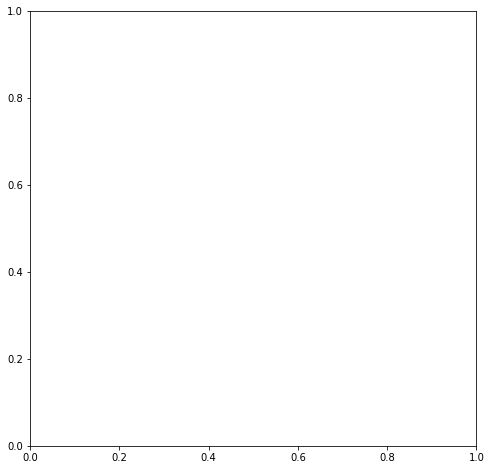

In [52]:

#All, all abs levels
#Newest method
#SL ngc


CMZLs = ["HCO+_1_0","HCN_1_0",'H13CN_1_0','H13CO+_1_0',"CO_3_2","CO_3_2_4.3"]




Line_Names = ['_NGC_HCOp_J1_0_','_NGC_HCN_J1_0_','','','','_NGC_CO_J3_2_']






NGCNames=list(np.load("Names_New_All_Kinds.npy",allow_pickle=True))
#print(NGCNames)
print(np.shape(NGCNames))
#CMZNames=list(np.load("CMZ_Names_New_All_Kinds.npy"))


NM_mod=''
Abs_Levels = ["All","None","No Clusters", "None (m)", "None All Channels"]
Suffixes=['','_NA','_No_Clusters','None_m','None_All_Channels']
savePath='/home/ben/Documents/Grad Stuff/MM data/Result Files'

Plot=False
for i in range(0,6):
    
    
    
    
    Params=np.genfromtxt(os.path.join(savePath,"_NGC_CO_J3_2_"+"_Params"))#[iterations,iter_factor ,Line_Name,Name,ovs,min_vel,FOV,Min_res,Min_beam_req]
    iterations,iter_factor,ovs,min_vel,FOV,Min_res,Min_beam_req = int(Params[0]),Params[1],int(Params[2]),Params[3],np.array(Params[4]),Params[5],Params[6]
    for kl in range(1):
        
        if(Line_Names[i]==''):
            break
    
        
        
        Prime_Beam = Min_res*((kl*iter_factor+1))#
        print(Prime_Beam)
    
    
        for km in range(1):
            
            vel_prime = min_vel*((km*iter_factor+1))
            
            fig = plt.figure(1,figsize=(8,8))
            gs0 = gridspec.GridSpec(len(Suffixes), 1, figure=fig)
            
            
            
            min_space=np.array([[np.full(100,Prime_Beam/ovs)],[np.linspace(-100,1000,100)]])
            Beams_s=np.array([[np.full(100,Prime_Beam)],[np.linspace(-100,1000,100)]])
            spec=np.array([[np.linspace(-100,1000,100)],[np.full(100,vel_prime)]])
            zeroes=np.array([[np.full(100,0)]])
            
            
            #for k5 in range(len(Suffixes)):
            for k5 in range(1):

                
                
                
                Suffix=Suffixes[k5]
                Abs_Level =Abs_Levels[k5]

                
                

                
                
                
                
                #fig.suptitle((CMZLs[i]+" Size-Linewidth Relation ("+str(Abs_Level)+")"), fontsize=18)
                #gs0.set_title((CMZLs[i]+" Size-Linewidth Relation ("+str(Abs_Level)+")"), fontsize=18)
                
                gs00 = gridspec.GridSpecFromSubplotSpec(iterations, iterations, subplot_spec=gs0[k5])

                
                

                for k3 in range(iterations):

                    beam_req = Min_beam_req*(k3+1)
                    
                    beam_req_line = Beams_s*beam_req
                    for k4 in range(iterations):
                        for k6 in range(iterations):
                            delt_factor = (3/5+k6/5)

                            for k7 in range(iterations):
                                noise_factor = (3/5+k7/5)
                                
                                
                                print(kl,km,k3,k4,k6,k7)
                                
                                #ax = fig.add_subplot(gs00[k6, k7])
                                ax = fig.add_subplot(1,1,1)

                                try:

                                    pix_thresh_factor = k4+1

                                    Name = NGCNames[i][kl][km][k3][k4][k6][k7]
                                    #print(Name)








                                    rname=Name+"Radii"

                                    sname=Name+"Sigmas"

                                    sEname=Name+"V_err"

                                    radsBase=[[],[]]
                                    sigsBase=[[],[]]

                                    sigs_err_Base=[[],[]]
                                    radsBase[0],radsBase[1] = np.genfromtxt(os.path.join(savePath,rname+"_Leaves"+Suffix))*10**6, np.genfromtxt(os.path.join(savePath,rname+"_Branches"+Suffix))*10**6#km/s
                                    sigsBase[0] ,sigsBase[1] = np.genfromtxt(os.path.join(savePath,sname+"_Leaves"+Suffix)),np.genfromtxt(os.path.join(savePath,sname+"_Branches"+Suffix))#km/s

                                    sigs_err_Base[0] ,sigs_err_Base[1] = np.genfromtxt(os.path.join(savePath,sEname+"_Leaves"+Suffix)),np.genfromtxt(os.path.join(savePath,sEname+"_Branches"+Suffix))#km/s



                                    er_r=1








                                    rads=np.concatenate((radsBase[0],radsBase[1]))
                                    sigs = np.concatenate((sigsBase[0],sigsBase[1]))
                                    sigs_err = np.concatenate((sigs_err_Base[0],sigs_err_Base[1]))


                                    from scipy.optimize import curve_fit

                                    def func(R,a,b):
                                        return a*R**(b)

                                    x   =  rads
                                    y     = sigs
                                    y_err = sigs_err

                                    try:
                                        (Vars, CoVar) = (curve_fit(func, x, y, sigma=y_err))
                                    except:
                                        (Vars, CoVar) = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
                                    np.savetxt(os.path.join(savePath,Name+"_NGC253_Coeffs"+Suffix+NM_mod), Vars,fmt='%s')
                                    np.savetxt(os.path.join(savePath,Name+"_NGC253_Coeff_CoVar"+Suffix+NM_mod),CoVar ,fmt='%s')
                                    np.savetxt(os.path.join(savePath,Name+"_NGC253_Fit_weights"+Suffix+NM_mod),[(len(sigs))] ,fmt='%s')
                                    #np.savetxt(CMZName+"_CMZ_Coeffs"+Suffix, Vars2,fmt='%s')
                                    #np.savetxt(CMZName+"_CMZ_Coeff_CoVar"+Suffix,CoVar2 ,fmt='%s')

                                    if Plot:

                                        ax.plot(x,func(x,Vars[0],Vars[1]),color="Red")
                                        ax.fill_between(x,func(x,Vars[0]+np.sqrt(CoVar[0][0])*er_r,Vars[1]+np.sqrt(CoVar[1][1])*er_r),func(x,Vars[0]-np.sqrt(CoVar[0][0])*er_r,Vars[1]-np.sqrt(CoVar[1][1])*er_r),alpha=.2,color="Red")
                                        ax.errorbar(x, y, yerr=y_err,lolims=True, uplims=True,fmt="o",color="Blue")

                                        ax.fill_betweenx(beam_req_line[1][0],beam_req_line[0][0] ,zeroes[0][0], alpha=.1,color="Black")
                                        ax.plot(Beams_s[0][0],Beams_s[1][0], alpha=.1,color="Black")

                                        spec=np.array([[np.linspace(-100,1000,100)],[np.full(100,vel_prime)]])

                                        ax.plot(spec[0][0],spec[1][0], alpha=.1,color="Black")

                                        ax.scatter(x,y,color="Red",alpha=.51,s=50)



                                        ax.set_xlabel(r'$R_{astrodendro}$ (pc)',fontsize=15)
                                        ax.set_ylabel(r'$\sigma   (km/s)$',fontsize=15)
                                        ax.set_yscale('log')
                                        ax.set_xscale('log')
                                        #string = ("NGC253 (Binned"+Suffix+"): a="+str(round(Vars[0],3))+" +-" + str(round(np.sqrt(CoVar[0][0]),3)) +", b="+str(round(Vars[1],3))+"+-" + str(round(np.sqrt(CoVar[1][1]),3)) )




                                        #axA.annotate(s=string,fontsize=18,xy=(0.01,.01+0.025*Index),xycoords="axes fraction")
                                        ax.set_xlim(0.5,40.0)
                                        ax.set_ylim(0.5,50.0)

                                        #axA.legend(loc='upper left',fontsize=18)


                                        ax.set_title(("beam={0},vel_res={1},beam_req={2},pix_thresh={3},abs={4},delta={5},SNR={6}".format(Prime_Beam,vel_prime,beam_req,pix_thresh_factor,Abs_Level,delt_factor,noise_factor*5)), fontsize=14)




                                    print(i,kl,km,k3,k4,k5,k6,k7,"Clear")
                                except Exception as e:
                                    print(e)
                                    print(i,kl,km,k3,k4,k5,k6,k7,"F")
                                    #print("Failed")
                                    #print("-"*60)
                                    #traceback.print_exc(file=sys.stdout)
                                if Plot:

                                    plt.tight_layout(pad=5, w_pad=5 ,h_pad=50.0)

                                    pylab.show()
                                    fname = "All_"+str(Prime_Beam)+"_beam_"+str(vel_prime) +"_vel_res_"+Suffix+"_.jpeg"
                                    fig.savefig(bbox_inches='tight',fname=fname)

4.3
0 0 0 0 0 0
0 0 0 0 0 0 0 0 Clear
0 0 0 0 0 1
0 0 0 0 0 0 0 1 Clear
0 0 0 0 0 2
0 0 0 0 0 0 0 2 Clear
0 0 0 0 0 3
0 0 0 0 0 0 0 3 Clear
0 0 0 0 0 4
0 0 0 0 0 0 0 4 Clear
0 0 0 0 1 0
0 0 0 0 0 0 1 0 Clear
0 0 0 0 1 1
0 0 0 0 0 0 1 1 Clear
0 0 0 0 1 2
0 0 0 0 0 0 1 2 Clear
0 0 0 0 1 3
0 0 0 0 0 0 1 3 Clear
0 0 0 0 1 4
0 0 0 0 0 0 1 4 Clear
0 0 0 0 2 0
0 0 0 0 0 0 2 0 Clear
0 0 0 0 2 1
0 0 0 0 0 0 2 1 Clear
0 0 0 0 2 2
0 0 0 0 0 0 2 2 Clear
0 0 0 0 2 3
0 0 0 0 0 0 2 3 Clear
0 0 0 0 2 4
0 0 0 0 0 0 2 4 Clear
0 0 0 0 3 0
0 0 0 0 0 0 3 0 Clear
0 0 0 0 3 1
0 0 0 0 0 0 3 1 Clear
0 0 0 0 3 2
0 0 0 0 0 0 3 2 Clear
0 0 0 0 3 3
0 0 0 0 0 0 3 3 Clear
0 0 0 0 3 4
0 0 0 0 0 0 3 4 Clear
0 0 0 0 4 0
0 0 0 0 0 0 4 0 Clear
0 0 0 0 4 1
0 0 0 0 0 0 4 1 Clear
0 0 0 0 4 2
0 0 0 0 0 0 4 2 Clear
0 0 0 0 4 3
0 0 0 0 0 0 4 3 Clear
0 0 0 0 4 4
0 0 0 0 0 0 4 4 Clear
0 0 0 1 0 0
0 0 0 0 1 0 0 0 Clear
0 0 0 1 0 1
0 0 0 0 1 0 0 1 Clear
0 0 0 1 0 2
0 0 0 0 1 0 0 2 Clear
0 0 0 1 0 3
0 0 0 0 1 0 0 3 Clear
0 0 0 1 0 

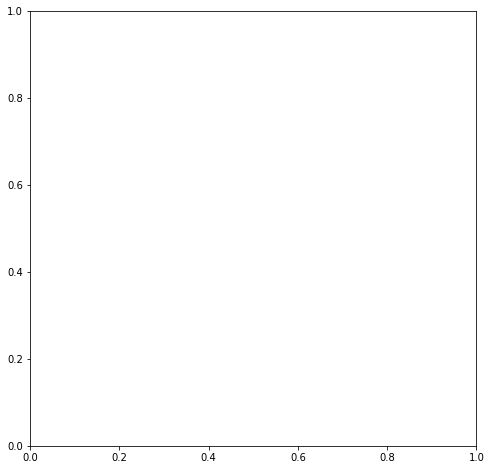

In [61]:

#All, all abs levels
#Newest method
#SL cmz


CMZLs = ["HCO+_1_0","HCN_1_0",'H13CN_1_0','H13CO+_1_0',"CO_3_2",'_CMZ_CO_J3_2_4.3_start']




Line_Names = ['_NGC_HCOp_J1_0_','_NGC_HCN_J1_0_','','','','_NGC_CO_J3_2_']
NM=False
if NM:
    CMZNames=list(np.load("CMZ_Names_New_All_Kinds_NM.npy",allow_pickle=True))
    NM_mod="NM"
else:
    CMZNames=list(np.load("CMZ_Names_New_All_Kinds.npy",allow_pickle=True))
    NM_mod=""

#CMZNames=list(np.load("CMZ_Names_New_All_Kinds.npy"))



Abs_Levels = ["All","None","No Clusters", "None (m)", "None All Channels"]
Suffixes=['','_NA','_No_Clusters','None_m','None_All_Channels']
savePath='/home/ben/Documents/Grad Stuff/MM data/Result Files'

Plot=False

for i in range(0,6):
    
    
    
    
    Params=np.genfromtxt(os.path.join(savePath,"_NGC_CO_J3_2_"+"_Params"))#[iterations,iter_factor ,Line_Name,Name,ovs,min_vel,FOV,Min_res,Min_beam_req]
    iterations,iter_factor,ovs,min_vel,FOV,Min_res,Min_beam_req = int(Params[0]),Params[1],int(Params[2]),Params[3],np.array(Params[4]),Params[5],Params[6]
    for kl in range(1):
        
        if(Line_Names[i]==''):
            break
    
        
        
        Prime_Beam = Min_res*((kl*iter_factor+1))#
        print(Prime_Beam)
    
    
        for km in range(1):
            
            vel_prime = min_vel*((km*iter_factor+1))
            
            fig = plt.figure(1,figsize=(8,8))
            gs0 = gridspec.GridSpec(len(Suffixes), 1, figure=fig)
            
            
            
            min_space=np.array([[np.full(100,Prime_Beam/ovs)],[np.linspace(-100,1000,100)]])
            Beams_s=np.array([[np.full(100,Prime_Beam)],[np.linspace(-100,1000,100)]])
            spec=np.array([[np.linspace(-100,1000,100)],[np.full(100,vel_prime)]])
            zeroes=np.array([[np.full(100,0)]])
            
            
            #for k5 in range(len(Suffixes)):
            for k5 in range(1):

                
                
                
                Suffix=Suffixes[k5]
                Abs_Level =Abs_Levels[k5]

                
                

                
                
                
                
                #fig.suptitle((CMZLs[i]+" Size-Linewidth Relation ("+str(Abs_Level)+")"), fontsize=18)
                #gs0.set_title((CMZLs[i]+" Size-Linewidth Relation ("+str(Abs_Level)+")"), fontsize=18)
                
                gs00 = gridspec.GridSpecFromSubplotSpec(iterations, iterations, subplot_spec=gs0[k5])

                
                

                for k3 in range(iterations):

                    beam_req = Min_beam_req*(k3+1)
                    
                    beam_req_line = Beams_s*beam_req
                    for k4 in range(iterations):
                        for k6 in range(iterations):
                            delt_factor = (3/5+k6/5)

                            for k7 in range(iterations):
                                noise_factor = (3/5+k7/5)
                                
                                
                                print(kl,km,k3,k4,k6,k7)
                                
                                #ax = fig.add_subplot(gs00[k6, k7])
                                ax = fig.add_subplot(1,1,1)

                                try:

                                    pix_thresh_factor = k4+1

                                    Name = CMZNames[i][kl][km][k3][k4][k6][k7]
                                    #print(Name)








                                    rname=Name+"Radii"

                                    sname=Name+"Sigmas"

                                    sEname=Name+"V_err"

                                    radsBase=[[],[]]
                                    sigsBase=[[],[]]

                                    sigs_err_Base=[[],[]]
                                    radsBase[0],radsBase[1] = np.genfromtxt(os.path.join(savePath,rname+"_Leaves"+Suffix))*10**6, np.genfromtxt(os.path.join(savePath,rname+"_Branches"+Suffix))*10**6#km/s
                                    sigsBase[0] ,sigsBase[1] = np.genfromtxt(os.path.join(savePath,sname+"_Leaves"+Suffix)),np.genfromtxt(os.path.join(savePath,sname+"_Branches"+Suffix))#km/s

                                    sigs_err_Base[0] ,sigs_err_Base[1] = np.genfromtxt(os.path.join(savePath,sEname+"_Leaves"+Suffix)),np.genfromtxt(os.path.join(savePath,sEname+"_Branches"+Suffix))#km/s



                                    er_r=1








                                    rads=np.concatenate((radsBase[0],radsBase[1]))
                                    sigs = np.concatenate((sigsBase[0],sigsBase[1]))
                                    sigs_err = np.concatenate((sigs_err_Base[0],sigs_err_Base[1]))


                                    from scipy.optimize import curve_fit

                                    def func(R,a,b):
                                        return a*R**(b)

                                    x   =  rads
                                    y     = sigs
                                    y_err = sigs_err

                                    try:
                                        (Vars, CoVar) = (curve_fit(func, x, y, sigma=y_err))
                                    except:
                                        (Vars, CoVar) = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
                                    
                                    np.savetxt(os.path.join(savePath,Name+"_CMZ_Coeffs"+Suffix+NM_mod), Vars,fmt='%s')
                                    np.savetxt(os.path.join(savePath,Name+"_CMZ_Coeff_CoVar"+Suffix+NM_mod),CoVar ,fmt='%s')

                                    np.savetxt(os.path.join(savePath,Name+"_CMZ_Fit_weights"+Suffix+NM_mod),[(len(sigs))] ,fmt='%s')
                                    #np.savetxt(CMZName+"_CMZ_Coeffs"+Suffix, Vars2,fmt='%s')
                                    #np.savetxt(CMZName+"_CMZ_Coeff_CoVar"+Suffix,CoVar2 ,fmt='%s')

                                    if Plot:

                                        ax.plot(x,func(x,Vars[0],Vars[1]),color="Red")
                                        ax.fill_between(x,func(x,Vars[0]+np.sqrt(CoVar[0][0])*er_r,Vars[1]+np.sqrt(CoVar[1][1])*er_r),func(x,Vars[0]-np.sqrt(CoVar[0][0])*er_r,Vars[1]-np.sqrt(CoVar[1][1])*er_r),alpha=.2,color="Red")
                                        ax.errorbar(x, y, yerr=y_err,lolims=True, uplims=True,fmt="o",color="Blue")

                                        ax.fill_betweenx(beam_req_line[1][0],beam_req_line[0][0] ,zeroes[0][0], alpha=.1,color="Black")
                                        ax.plot(Beams_s[0][0],Beams_s[1][0], alpha=.1,color="Black")

                                        spec=np.array([[np.linspace(-100,1000,100)],[np.full(100,vel_prime)]])

                                        ax.plot(spec[0][0],spec[1][0], alpha=.1,color="Black")

                                        ax.scatter(x,y,color="Red",alpha=.51,s=50)



                                        ax.set_xlabel(r'$R_{astrodendro}$ (pc)',fontsize=15)
                                        ax.set_ylabel(r'$\sigma   (km/s)$',fontsize=15)
                                        ax.set_yscale('log')
                                        ax.set_xscale('log')
                                        #string = ("NGC253 (Binned"+Suffix+"): a="+str(round(Vars[0],3))+" +-" + str(round(np.sqrt(CoVar[0][0]),3)) +", b="+str(round(Vars[1],3))+"+-" + str(round(np.sqrt(CoVar[1][1]),3)) )




                                        #axA.annotate(s=string,fontsize=18,xy=(0.01,.01+0.025*Index),xycoords="axes fraction")
                                        ax.set_xlim(0.5,40.0)
                                        ax.set_ylim(0.5,50.0)

                                        #axA.legend(loc='upper left',fontsize=18)


                                        ax.set_title(("beam={0},vel_res={1},beam_req={2},pix_thresh={3},abs={4},delta={5},SNR={6}".format(Prime_Beam,vel_prime,beam_req,pix_thresh_factor,Abs_Level,delt_factor,noise_factor*5)), fontsize=14)




                                    print(i,kl,km,k3,k4,k5,k6,k7,"Clear")
                                except Exception as e:
                                    print(e)
                                    print(i,kl,km,k3,k4,k5,k6,k7,"F")
                                    #print("Failed")
                                    #print("-"*60)
                                    #traceback.print_exc(file=sys.stdout)
                                if Plot:

                                    plt.tight_layout(pad=5, w_pad=5 ,h_pad=50.0)

                                    pylab.show()
                                    fname = "All_"+str(Prime_Beam)+"_beam_"+str(vel_prime) +"_vel_res_"+Suffix+"_.jpeg"
                                    fig.savefig(bbox_inches='tight',fname=fname)






4.3
HCO+ J1-0_Abs_New_Cropped_4.3pc_beam__NGC_HCOp_J1_0_70x360pc_3.3_vel_res_0.2_beam_size_req_1_times_beam_pixels_0.6_delt_factor_3.0_SNR.fits CMZ_HCO+_J1_0_all_Cropped_4.3pc_beam__CMZ_HCO_J1_0_4.3_start70x360pc_3.3_vel_res_0.2_beam_size_req_1_times_beam_pixels_0.6_delt_factor_3.0_SNR.fits
Data CMZ
0 0 0 0 0 0 0
HCO+ J1-0_Abs_New_Cropped_4.3pc_beam__NGC_HCOp_J1_0_70x360pc_3.3_vel_res_0.4_beam_size_req_1_times_beam_pixels_0.6_delt_factor_3.0_SNR.fits CMZ_HCO+_J1_0_all_Cropped_4.3pc_beam__CMZ_HCO_J1_0_4.3_start70x360pc_3.3_vel_res_0.4_beam_size_req_1_times_beam_pixels_0.6_delt_factor_3.0_SNR.fits
Data NGC
Data CMZ
0 0 0 1 0 0 0
HCO+ J1-0_Abs_New_Cropped_4.3pc_beam__NGC_HCOp_J1_0_70x360pc_3.3_vel_res_0.6000000000000001_beam_size_req_1_times_beam_pixels_0.6_delt_factor_3.0_SNR.fits CMZ_HCO+_J1_0_all_Cropped_4.3pc_beam__CMZ_HCO_J1_0_4.3_start70x360pc_3.3_vel_res_0.6000000000000001_beam_size_req_1_times_beam_pixels_0.6_delt_factor_3.0_SNR.fits
Data NGC
Data CMZ
0 0 0 2 0 0 0
HCO+ J1-0_Abs_

J
W
CMZ
SHAPE CMZ (4, 3)
[[2.6900653  0.74727355 0.2       ]
 [3.71136419 0.6333732  0.4       ]
 [5.76227456 0.49196641 0.6       ]
 [5.30222182 0.53129911 1.        ]]


O
data at 0 0
4.3
HCN J1-0_Abs_New_Cropped_4.3pc_beam__NGC_HCN_J1_0_70x360pc_3.3_vel_res_0.2_beam_size_req_1_times_beam_pixels_0.6_delt_factor_3.0_SNR.fits CMZ_HCN_J1_0_all_Cropped_4.3pc_beam__CMZ_HCN_J1_0_4.3_start70x360pc_3.3_vel_res_0.2_beam_size_req_1_times_beam_pixels_0.6_delt_factor_3.0_SNR.fits
Data CMZ
1 0 0 0 0 0 0
HCN J1-0_Abs_New_Cropped_4.3pc_beam__NGC_HCN_J1_0_70x360pc_3.3_vel_res_0.4_beam_size_req_1_times_beam_pixels_0.6_delt_factor_3.0_SNR.fits CMZ_HCN_J1_0_all_Cropped_4.3pc_beam__CMZ_HCN_J1_0_4.3_start70x360pc_3.3_vel_res_0.4_beam_size_req_1_times_beam_pixels_0.6_delt_factor_3.0_SNR.fits
Data NGC
Data CMZ
1 0 0 1 0 0 0
HCN J1-0_Abs_New_Cropped_4.3pc_beam__NGC_HCN_J1_0_70x360pc_3.3_vel_res_0.6000000000000001_beam_size_req_1_times_beam_pixels_0.6_delt_factor_3.0_SNR.fits CMZ_HCN_J1_0_all_Cropped_4.3pc_beam__CMZ_HCN_J1_0_4.3_start70x360pc_3.3_vel_res_0.6000000000000001_beam_size_req_1_times_beam_pixels_0.6_delt_factor_3.0_SNR.fits
Data CMZ
1 0 0 2 0 0 0
HCN J1-0_Abs_New_Cr

J
W
CMZ
SHAPE CMZ (5, 3)
[[2.95914713 0.72339737 0.2       ]
 [4.65778866 0.66867954 0.4       ]
 [3.84551719 0.73802474 0.6       ]
 [3.10749359 0.86611548 0.8       ]
 [3.11287357 0.89380436 1.        ]]


O
data at 1 0
SHAPE NGC (0,)
[]
I don't believe that you want more dimensions than samples!
Failed
------------------------------------------------------------
Traceback (most recent call last):
  File "/tmp/ipykernel_1329059/4019318409.py", line 437, in <module>
    figure = corner.corner(
  File "/home/ben/.local/lib/python3.8/site-packages/corner/corner.py", line 226, in corner
    return corner_impl(
  File "/home/ben/.local/lib/python3.8/site-packages/corner/core.py", line 67, in corner_impl
    assert xs.shape[0] <= xs.shape[1], (
AssertionError: I don't believe that you want more dimensions than samples!
SHAPE NGC (0,)
[]
I don't believe that you want more dimensions than samples!
Failed
------------------------------------------------------------
Traceback (most recent call last):
  File "/tmp/ipykernel_1329059/4019318409.py", line 437, in <module>
    figure = corner.corner(
  File "/home/ben/.local/lib/python3.8/site-packages/corner/corner.py", line 226, in corner
    return 

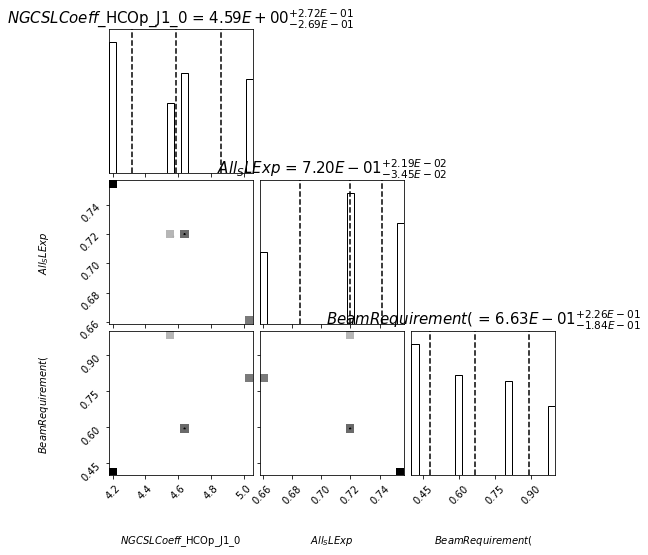

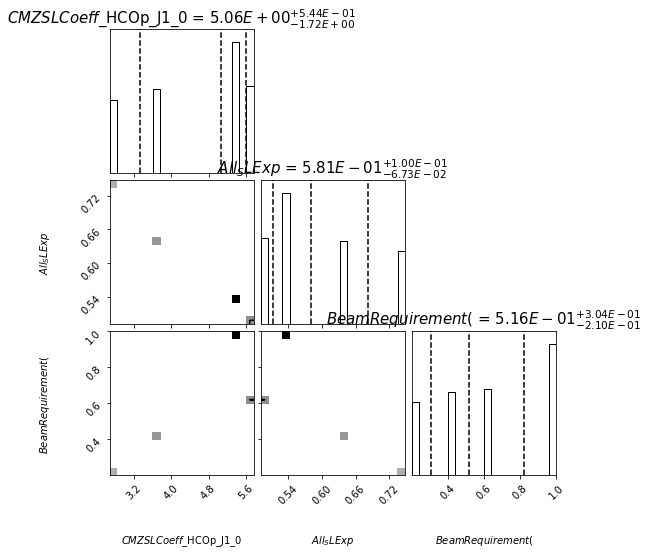

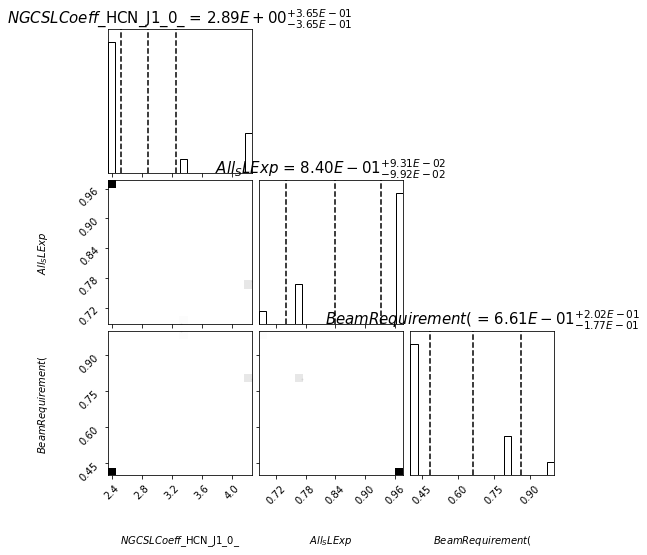

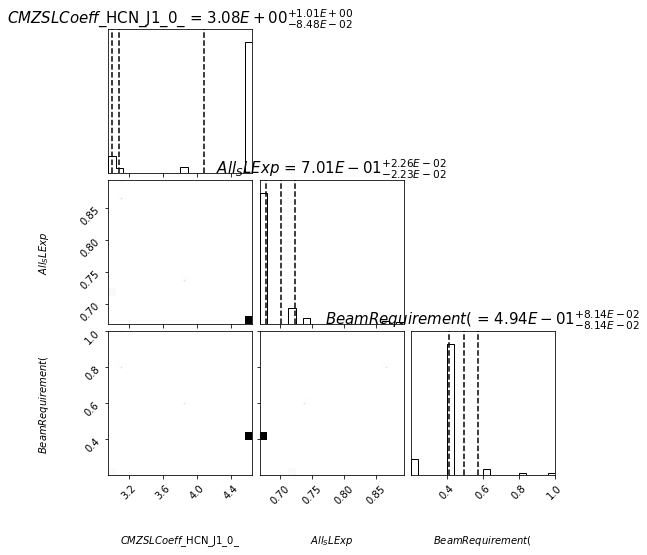

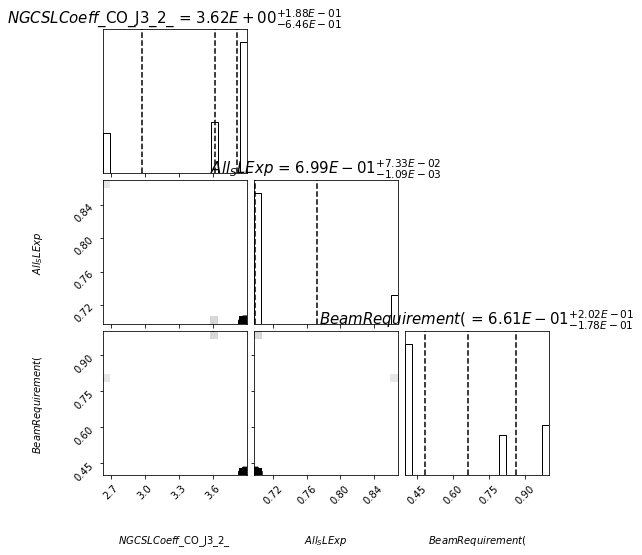

In [56]:


CMZLs = ["HCO+_1_0","HCN_1_0",'H13CN_1_0','H13CO+_1_0',"CO_3_2","CO_3_2_4.3"]




Line_Names = ['_HCOp_J1_0_','_HCN_J1_0_','','','','_CO_J3_2_']
Line_Names_CMZ = ['_HCOp_J1_0_','_HCN_J1_0_','','','','_CO_J3_2_']
NM=False

if NM:
    CMZNames=list(np.load("CMZ_Names_New_All_Kinds_NM.npy",allow_pickle=True))
else:
    CMZNames=list(np.load("CMZ_Names_New_All_Kinds.npy",allow_pickle=True))


NGCNames=list(np.load("Names_New_All_Kinds.npy",allow_pickle=True))
print()#CMZNames=list(np.load("CMZ_Names_New_All_Kinds.npy"))



Abs_Levels = ["All","None","No Clusters", "None (m)", "None All Channels"]
Suffixes=['','_NA','_No_Clusters','None_m','None_All_Channels']


savePath='/home/ben/Documents/Grad Stuff/MM data/Result Files'


av_data = np.zeros((6,len(Suffixes),2,50))
av_data_upper= np.zeros((6,len(Suffixes),2,50))
av_data_lower= np.zeros((6,len(Suffixes),2,50))

av_data_CMZ = np.zeros((6,len(Suffixes),2,50))
av_data_upper_CMZ= np.zeros((6,len(Suffixes),2,50))
av_data_lower_CMZ= np.zeros((6,len(Suffixes),2,50))

qs=np.zeros((6,len(Suffixes),1))
qes=np.zeros((6,len(Suffixes),1))
qs_cmz=np.zeros((6,len(Suffixes),1))
qes_cmz=np.zeros((6,len(Suffixes),1))

qs_err=np.zeros((6,len(Suffixes),2))
qes_err=np.zeros((6,len(Suffixes),2))
qs_cmz_err=np.zeros((6,len(Suffixes),2))
qes_cmz_err=np.zeros((6,len(Suffixes),2))



beams=1
vels=1
beam_reqs=5
pixel_reqs=1
SNRs=1
delts=1


    
    
for i in range(0,6):
    
    Params=np.genfromtxt(os.path.join(savePath,'_NGC_CO_J3_2_'+"_Params"))#[iterations,iter_factor ,Line_Name,Name,ovs,min_vel,FOV,Min_res,Min_beam_req]
    iterations,iter_factor,ovs,min_vel,FOV,Min_res,Min_beam_req = int(Params[0]),Params[1],int(Params[2]),Params[3],np.array(Params[4]),Params[5],Params[6]
    
    
    
    
    #for k5 in range(len(Suffixes)):
    for k5 in range(1):

                
                
        Net_Vars = [[],[]]
        Net_Std=[[],[]]

        Net_Beams=[]
        Net_Vels=[]
        Net_Beam_Req=[]
        Net_Pix_Req=[]
        All_Things_Coeff=[]
        All_Things_Exp=[]
        All_Things_Both=[]
        
        Net_Vars = [[],[]]
        Net_Std=[[],[]]
        Net_Weights=[]
        
        
        
        Net_Beams_CMZ=[]
        Net_Vels_CMZ=[]
        Net_Beam_Req_CMZ=[]
        Net_Pix_Req_CMZ=[]
        All_Things_Coeff_CMZ=[]
        All_Things_Exp_CMZ=[]
        All_Things_Both_CMZ=[]
        Net_Vars_CMZ = [[],[]]
        Net_Std_CMZ=[[],[]]
        Net_Weights_CMZ=[]
            
            
        Suffix=Suffixes[k5]
        Abs_Level =Abs_Levels[k5]

        
        #for kl in range(iterations):
        for kl in range(beams):

            if(Line_Names[i]==''):
                break





            Prime_Beam = Min_res*((kl*iter_factor+1))#
            print(Prime_Beam)


            for km in range(vels):

                vel_prime = min_vel*((km*iter_factor+1))

                

                
                

                for k3 in range(beam_reqs):
                

                    beam_req = Min_beam_req*(k3+1)
                    
                    
                    for k4 in range(pixel_reqs):
                        #print(kl,km,k3,k4)
                        #ax = fig.add_subplot(gs00[k3, k4])
                        for k6 in range(delts):
                            delt_factor = (3/5+k6/5)

                            for k7 in range(SNRs):
                                noise_factor = (3/5+k7/5)
                                
                                
                                
                                try:

                                    pix_thresh_factor = k4+1

                                    Name = NGCNames[i][kl][km][k3][k4][k6][k7]
                                    NameCMZ = CMZNames[i][kl][km][k3][k4][k6][k7]
                                    print(Name,NameCMZ)
                                    #print(os.path.join(savePath,Name+"_NGC253_Coeffs"+Suffix))
                                    
                                    NM_mod=""
                                    Vars= np.genfromtxt(os.path.join(savePath,Name+"_NGC253_Coeffs"+Suffix+NM_mod))
                                    Covars= np.genfromtxt(os.path.join(savePath,Name+"_NGC253_Coeff_CoVar"+Suffix+NM_mod))

                                    Weights= np.genfromtxt(os.path.join(savePath,Name+"_NGC253_Fit_weights"+Suffix+NM_mod))

                                    if((Vars[0] > 0 or Vars[0] < 0 )and (Covars[0][0] >0 or Covars[0][0]<0) and np.isfinite(Covars[0][0]) and Vars[0]<6 and Vars[1]<1 and Vars[1]>0):
                                        #print(Vars,Covars)
                                        Net_Vars[0].append(Vars[0])
                                        Net_Vars[1].append(Vars[1])
                                        Net_Std[0].append(np.sqrt(Covars[0][0])) #Now its the STD
                                        Net_Std[1].append(np.sqrt(Covars[1][1]))

                                        Net_Weights.append(Weights)


                                        Net_Beams.append(Prime_Beam)
                                        Net_Vels.append(vel_prime)
                                        Net_Beam_Req.append(beam_req)
                                        Net_Pix_Req.append(pix_thresh_factor)

                                        #All_Things_Coeff.append([Vars[0],Prime_Beam,vel_prime,beam_req,pix_thresh_factor])
                                        #All_Things_Exp.append([Vars[1],Prime_Beam,vel_prime,beam_req,pix_thresh_factor])
                                        print("Data NGC")
                                        things=[Vars[0]]
                                        things.append(Vars[1])
                                        if(beams!=1):
                                            things.append(Prime_Beam)
                                        if(vels!=1):
                                            things.append(vel_prime)
                                        if(beam_reqs!=1):
                                            things.append(beam_req)
                                        if(pixel_reqs!=1):
                                            things.append(pix_thresh_factor)
                                        if(delts!=1):
                                            things.append(delt_factor)
                                        if(SNRs!=1):
                                            things.append(noise_factor)
                                            
                                            
                                        #All_Things_Both.append([Vars[0],Vars[1],beam_req,pix_thresh_factor,delt_factor,noise_factor])
                                        All_Things_Both.append(things)
                                        #All_Things_Both.append([Vars[0],Vars[1],beam_req,pix_thresh_factor])
                                    else:
                                        pass
                                except Exception as e:

                                    #print(e)
                                    #print(i,kl,km,k3,k4,k5,"F")
                                    #print("Failed")
                                    #print("-"*60)
                                    #traceback.print_exc(file=sys.stdout)
                                    pass

                                try:
                                    #cmz
                                    if NM:
                                        NM_mod="NM"
                                    else:
                                        NM_mod=''
                                    Vars= np.genfromtxt(os.path.join(savePath,NameCMZ+"_CMZ_Coeffs"+Suffix+NM_mod))
                                    Covars= np.genfromtxt(os.path.join(savePath,NameCMZ+"_CMZ_Coeff_CoVar"+Suffix+NM_mod))

                                    Weights= np.genfromtxt(os.path.join(savePath,NameCMZ+"_CMZ_Fit_weights"+Suffix+NM_mod))
                                    #print(Vars,Covars)
                                    if((Vars[0] > 0 or Vars[0] < 0 )and (Covars[0][0] >0 or Covars[0][0]<0) and np.isfinite(Covars[0][0]) and Vars[0]<6 and Vars[1]<1 and Vars[1]>0):
                                        #print(Vars,Covars)
                                        Net_Vars_CMZ[0].append(Vars[0])
                                        Net_Vars_CMZ[1].append(Vars[1])
                                        Net_Std_CMZ[0].append(np.sqrt(Covars[0][0])) #Now its the STD
                                        Net_Std_CMZ[1].append(np.sqrt(Covars[1][1]))

                                        Net_Weights_CMZ.append(Weights)



                                        Net_Beams_CMZ.append(Prime_Beam)
                                        Net_Vels_CMZ.append(vel_prime)
                                        Net_Beam_Req_CMZ.append(beam_req)
                                        Net_Pix_Req_CMZ.append(pix_thresh_factor)

                                        #All_Things_Coeff_CMZ.append([Vars[0],Prime_Beam,vel_prime,beam_req,pix_thresh_factor])
                                        #All_Things_Exp_CMZ.append([Vars[1],Prime_Beam,vel_prime,beam_req,pix_thresh_factor])
                                        #All_Things_Both_CMZ.append([Vars[0],Vars[1],Prime_Beam,vel_prime,beam_req,pix_thresh_factor,delt_factor,noise_factor])
                                        print("Data CMZ")
                                        
                                        things=[Vars[0]]
                                        things.append(Vars[1])
                                        if(beams!=1):
                                            things.append(Prime_Beam)
                                        if(vels!=1):
                                            things.append(vel_prime)
                                        if(beam_reqs!=1):
                                            things.append(beam_req)
                                        if(pixel_reqs!=1):
                                            things.append(pix_thresh_factor)
                                        if(delts!=1):
                                            things.append(delt_factor)
                                        if(SNRs!=1):
                                            things.append(noise_factor)
                                            
                                            
                                        #All_Things_Both_CMZ.append([Vars[0],Vars[1],beam_req,pix_thresh_factor,delt_factor,noise_factor])
                                        All_Things_Both_CMZ.append(things)
                                        #All_Things_Both_CMZ.append([Vars[0],Vars[1],beam_req,pix_thresh_factor])
                                    else:
                                        pass

                                except Exception as e:

                                    #print(e)
                                    #print(i,kl,km,k3,k4,k5,k6,k7,"F")
                                    #print("Failed")
                                    #print("-"*60)
                                    #traceback.print_exc(file=sys.stdout)
                                    pass
                                pass
                            pass
                        pass
                    print(i,kl,km,k3,k4,k6,k7)




        try:
            '''data=np.array(All_Things_Coeff)
            weights = np.array(Net_Std[0])
            #print(weights)
            #print(np.shape(data))
            #print(data)


            # Plot it.
            print("OO")
            figure = corner.corner(
                data,
                #weights=weights,
                labels=[
                    r"$SL Coeff$",
                    r"$Beam Size (pc)$",
                    r"$Vel Res (km/s)$",
                    r"$Beam Requirement (%)$",
                    r"$Pixel Req (pix/beam)$",                

                ],
                quantiles=[0.16, 0.5, 0.84],
                show_titles=True,
                title_kwargs={"fontsize": 15},

                labelpad=.1,
                title_fmt=".2E"
            )
            print("OK")
            fname="{0}_abs={1}".format(Line_Names[i],Abs_Level)
            figure.savefig(bbox_inches='tight',fname=fname+"_Coeffs.jpeg")
            print("OKW")
            data=np.array(All_Things_Exp)
            weights = np.array(Net_Std[1])
            #print(weights)
            #print(np.shape(data))
            #print(data)


            # Plot it.
            figure = corner.corner(
                data,
                #weights=weights,
                labels=[
                    r"$SL Exponent$",
                    r"$Beam Size (pc)$",
                    r"$Vel Res (km/s)$",
                    r"$Beam Requirement (%)$",
                    r"$Pixel Req (pix/beam)$",                

                ],
                quantiles=[0.16, 0.5, 0.84],
                show_titles=True,
                title_kwargs={"fontsize": 15},

                labelpad=.1,
                title_fmt=".2E"
            )
            fname="{0}_abs={1}".format(Line_Names[i],Abs_Level)
            figure.savefig(bbox_inches='tight',fname=fname+"_Exp.jpeg")

            # Plot it.
            print("AKLHFAL")'''
            '''
            data = np.array(All_Things_Both)
            weights=Net_Weights
            figure = corner.corner(
                data,
                labels=[
                    r"$NGC SL Coeff$",
                    r"${0}_SL Exp$".format(Abs_Level),
                    r"$_Beam Size (pc)$",
                    r"$Vel Res (km/s)$",
                    r"$Beam Requirement (%)$",
                    (r"$Pixel Req (pix/beam)$"+Line_Names[i][0:10]),                

                ],
                weights=weights,
                quantiles=[0.16, 0.5, 0.84],
                show_titles=True,
                title_kwargs={"fontsize": 15},

                labelpad=.1,
                title_fmt=".2E"
            )
            fname="{0}_abs={1}".format(Line_Names[i],Abs_Level)
            figure.savefig(bbox_inches='tight',fname=fname+"_Both.jpeg")

            x_array = np.linspace(2,30,50)

            def func(R,a,b):
                return a*R**(b)
            print("J")
            q = corner.quantile(            data[:,0],  [0.16, 0.5, 0.84])

            q_16, q_50, q_84 = q
            dx_down, dx_up = q_50-q_16, q_84-q_50

            qe = corner.quantile(            data[:,1],  [0.16, 0.5, 0.84])
            q_16e, q_50e, q_84e = qe
            dx_downe, dx_upe = q_50e-q_16e, q_84e-q_50e
            
            qs[i][k5]=q_50
            qes[i][k5]=q_50e
            
            qs_err[i][k5][0],qs_err[i][k5][1]=dx_down,dx_up
            qes_err[i][k5][0],qes_err[i][k5][1]=dx_downe,dx_upe
            
            
            
            
            av_data[i][k5][0],av_data[i][k5][1] = x_array,func(x_array,q_50,q_50e)
            av_data_upper[i][k5][0],av_data_upper[i][k5][1] = x_array,func(x_array,q_50+dx_up,q_50e+dx_upe)
            av_data_lower[i][k5][0],av_data_lower[i][k5][1] = x_array,func(x_array,q_50-dx_down,q_50e-dx_downe)
            print("W")

            print("CMZ")

            data = np.array(All_Things_Both_CMZ)
            print(np.shape(data))
            weights=Net_Weights_CMZ
            figure = corner.corner(
                data,
                labels=[
                    r"$CMZ SL Coeff$",
                    r"${0}_SL Exp$".format(Abs_Level),
                    r"$Beam Size (pc)$",
                    r"$Vel Res (km/s)$",
                    r"$Beam Requirement (%)$",
                    (r"$Pixel Req (pix/beam)$"+Line_Names[i][0:10]),                

                ],
                weights=weights,
                quantiles=[0.16, 0.5, 0.84],
                show_titles=True,
                title_kwargs={"fontsize": 15},

                labelpad=.1,
                title_fmt=".2E"
            )
            '''
            
            data = np.array(All_Things_Both)
            print("SHAPE NGC",np.shape(data))
            print(data)
            weights=Net_Weights
            labels = [(r"$NGC SL Coeff$"+Line_Names[i][0:10]),
                    r"${0}_SL Exp$".format(Abs_Level),]
            if(beams!=1):
                labels.append(r"$_Beam Size (pc)$")
            if(vels!=1):
                labels.append(r"$Vel Res (km/s)$")
            if(beam_reqs!=1):
                labels.append(r"$Beam Requirement (%)$")
            if(pixel_reqs!=1):
                labels.append((r"$Pixel Req (pix/beam)$") )
            if(delts!=1):
                labels.append(r"$Delt_Factor (#) (%)$")
            if(SNRs!=1):
                labels.append(r"$SNR (#) (%)$")
            figure = corner.corner(
                data,
                labels=   labels             ,
                weights=weights,
                quantiles=[0.16, 0.5, 0.84],
                show_titles=True,
                title_kwargs={"fontsize": 15},

                labelpad=.1,
                title_fmt=".2E"
            )
            fname="{0}_abs={1}".format(Line_Names[i],Abs_Level)
            figure.savefig(bbox_inches='tight',fname=fname+"_Both.jpeg")

            x_array = np.linspace(2,30,50)

            def func(R,a,b):
                return a*R**(b)
            print("J")
            q = corner.quantile(            data[:,0],  [0.16, 0.5, 0.84])

            q_16, q_50, q_84 = q
            dx_down, dx_up = q_50-q_16, q_84-q_50

            qe = corner.quantile(            data[:,1],  [0.16, 0.5, 0.84])
            q_16e, q_50e, q_84e = qe
            dx_downe, dx_upe = q_50e-q_16e, q_84e-q_50e
            
            qs[i][k5]=q_50
            qes[i][k5]=q_50e
            
            qs_err[i][k5][0],qs_err[i][k5][1]=dx_down,dx_up
            qes_err[i][k5][0],qes_err[i][k5][1]=dx_downe,dx_upe
            
            
            
            
            av_data[i][k5][0],av_data[i][k5][1] = x_array,func(x_array,q_50,q_50e)
            av_data_upper[i][k5][0],av_data_upper[i][k5][1] = x_array,func(x_array,q_50+dx_up,q_50e+dx_upe)
            av_data_lower[i][k5][0],av_data_lower[i][k5][1] = x_array,func(x_array,q_50-dx_down,q_50e-dx_downe)
            print("W")

            print("CMZ")
            
            data = np.array(All_Things_Both_CMZ)
            print("SHAPE CMZ",np.shape(data))
            print(data)
            weights=Net_Weights_CMZ
            
            
            labels = [(r"$CMZ SL Coeff$"+Line_Names[i][0:10]),
                    r"${0}_SL Exp$".format(Abs_Level),]
            if(beams!=1):
                labels.append(r"$_Beam Size (pc)$")
            if(vels!=1):
                labels.append(r"$Vel Res (km/s)$")
            if(beam_reqs!=1):
                labels.append(r"$Beam Requirement (%)$")
            if(pixel_reqs!=1):
                labels.append((r"$Pixel Req (pix/beam)$") )
            if(delts!=1):
                labels.append(r"$Delt_Factor (#) (%)$")
            if(SNRs!=1):
                labels.append(r"$SNR (#) (%)$")
                
                
            figure = corner.corner(
                data,
                labels=labels,
                weights=weights,
                quantiles=[0.16, 0.5, 0.84],
                show_titles=True,
                title_kwargs={"fontsize": 15},

                labelpad=.1,
                title_fmt=".2E"
            )
            fname="CMZ_{0}_abs={1}".format(Line_Names[i],Abs_Level)
            figure.savefig(bbox_inches='tight',fname=fname+"_Both.jpeg")
            print("O")
            q = corner.quantile(data[:,0],[0.16, 0.5, 0.84])

            q_16, q_50, q_84 = q
            dx_down, dx_up = q_50-q_16, q_84-q_50

            qe = corner.quantile(            data[:,1],  [0.16, 0.5, 0.84])
            q_16e, q_50e, q_84e = qe
            
            

            dx_downe, dx_upe = q_50e-q_16e, q_84e-q_50e
            
            qs_cmz[i][k5]=q_50
            qes_cmz[i][k5]=q_50e
            
            qs_cmz_err[i][k5][0],qs_cmz_err[i][k5][1]=dx_down,dx_up
            qes_cmz_err[i][k5][0],qes_cmz_err[i][k5][1]=dx_downe,dx_upe
            
            av_data_CMZ[i][k5][0],av_data_CMZ[i][k5][1] = x_array,func(x_array,q_50,q_50e)
            av_data_upper_CMZ[i][k5][0],av_data_upper_CMZ[i][k5][1] = x_array,func(x_array,q_50+dx_up,q_50e+dx_upe)
            av_data_lower_CMZ[i][k5][0],av_data_lower_CMZ[i][k5][1] = x_array,func(x_array,q_50-dx_down,q_50e-dx_downe)
            print("data at", i,k5)
        except Exception as e:

            print(e)
            
            print("Failed")
            print("-"*60)
            traceback.print_exc(file=sys.stdout)
            pass


(6, 5, 2, 50) 6
[ 2.          2.57142857  3.14285714  3.71428571  4.28571429  4.85714286
  5.42857143  6.          6.57142857  7.14285714  7.71428571  8.28571429
  8.85714286  9.42857143 10.         10.57142857 11.14285714 11.71428571
 12.28571429 12.85714286 13.42857143 14.         14.57142857 15.14285714
 15.71428571 16.28571429 16.85714286 17.42857143 18.         18.57142857
 19.14285714 19.71428571 20.28571429 20.85714286 21.42857143 22.
 22.57142857 23.14285714 23.71428571 24.28571429 24.85714286 25.42857143
 26.         26.57142857 27.14285714 27.71428571 28.28571429 28.85714286
 29.42857143 30.        ] [ 7.02665874  8.35116655  9.58588285 10.75189669 11.86287144 12.92830301
 13.95513149 14.94862507 15.91290319 16.85126478 17.76640395 18.66055729
 19.5356076  20.39315898 21.23459236 22.06110752 22.87375527 23.67346263
 24.46105269 25.23726054 26.00274619 26.75810502 27.50387655 28.24055162
 28.96857844 29.68836772 30.40029701 31.1047144  31.80194169 32.49227717
 33.17599799 33.8

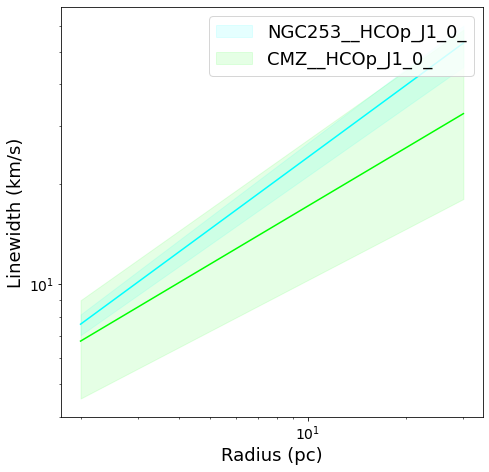

[ 2.          2.57142857  3.14285714  3.71428571  4.28571429  4.85714286
  5.42857143  6.          6.57142857  7.14285714  7.71428571  8.28571429
  8.85714286  9.42857143 10.         10.57142857 11.14285714 11.71428571
 12.28571429 12.85714286 13.42857143 14.         14.57142857 15.14285714
 15.71428571 16.28571429 16.85714286 17.42857143 18.         18.57142857
 19.14285714 19.71428571 20.28571429 20.85714286 21.42857143 22.
 22.57142857 23.14285714 23.71428571 24.28571429 24.85714286 25.42857143
 26.         26.57142857 27.14285714 27.71428571 28.28571429 28.85714286
 29.42857143 30.        ] [ 4.36833775  5.22688669  6.03207169  6.79620012  7.52728688  8.23092616
  8.91122153  9.57129803 10.21360632 10.84011403 11.45243183 12.05189977
 12.6396482  13.21664192 13.783713   14.34158549 14.89089454 15.43220129
 15.96600466 16.49275082 17.01284086 17.52663704 18.03446799 18.53663303
 19.03340577 19.52503718 20.0117582  20.49378193 20.97130559 21.44451212
 21.91357166 22.37864277 22.83987

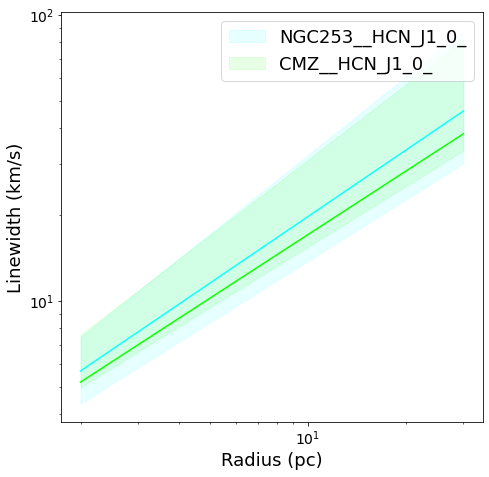

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0.] [0.] [0. 0.] [0. 0.]
[0.] [0.] [0. 0.] [0. 0.]


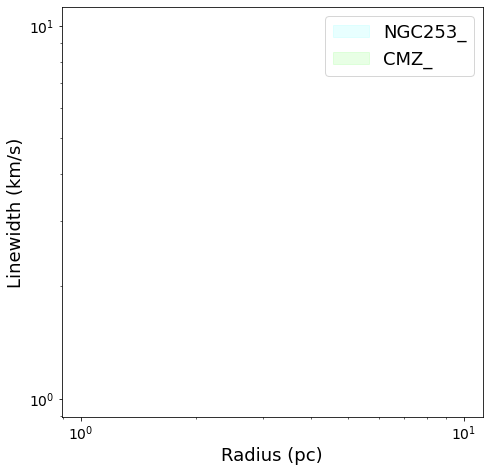

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0.] [0.] [0. 0.] [0. 0.]
[0.] [0.] [0. 0.] [0. 0.]


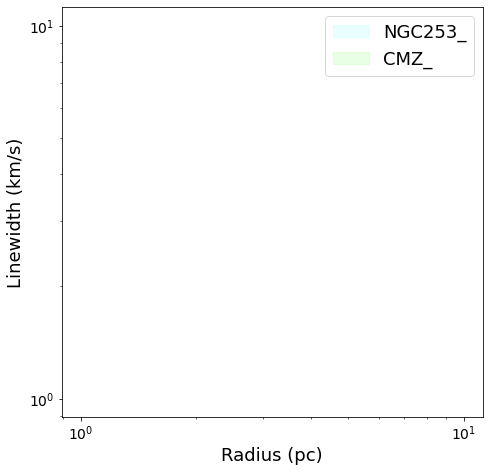

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0.] [0.] [0. 0.] [0. 0.]
[0.] [0.] [0. 0.] [0. 0.]


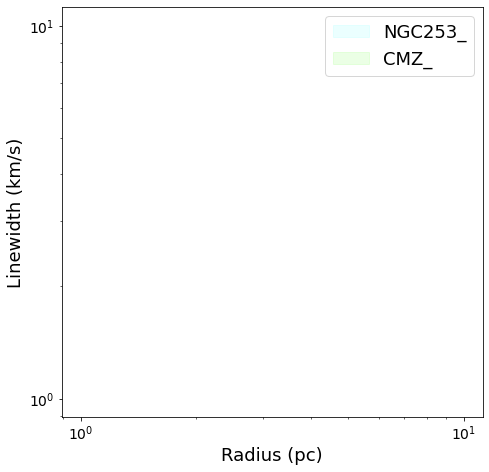

[ 2.          2.57142857  3.14285714  3.71428571  4.28571429  4.85714286
  5.42857143  6.          6.57142857  7.14285714  7.71428571  8.28571429
  8.85714286  9.42857143 10.         10.57142857 11.14285714 11.71428571
 12.28571429 12.85714286 13.42857143 14.         14.57142857 15.14285714
 15.71428571 16.28571429 16.85714286 17.42857143 18.         18.57142857
 19.14285714 19.71428571 20.28571429 20.85714286 21.42857143 22.
 22.57142857 23.14285714 23.71428571 24.28571429 24.85714286 25.42857143
 26.         26.57142857 27.14285714 27.71428571 28.28571429 28.85714286
 29.42857143 30.        ] [ 4.76181857  5.67443607  6.52720418  7.33408001  8.10412452  8.84364559
  9.55726001 10.24847681 10.92004298 11.57416056 12.2126296  12.83694569
 13.44836887 14.04797341 14.6366848  15.21530762 15.78454697 16.34502525
 16.89729538 17.44185145 17.97913724 18.50955332 19.03346281 19.55119622
 20.06305549 20.56931739 21.07023644 21.5660474  22.05696738 22.54319768
 23.02492542 23.50232489 23.97555

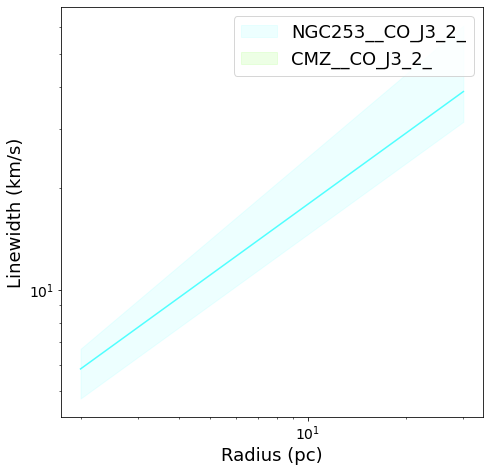

In [57]:
   
print(np.shape(av_data),len(av_data))
for i in range(len(av_data)):
       
    #for j in range(len(av_data[0])):
    for j in range(1):
        fig = plt.figure(1,figsize=(80,80))   
        ax = pylab.subplot(9,9,i+6*j+1) 
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_xlabel("Radius (pc)",fontsize=18)
        ax.set_ylabel("Linewidth (km/s)",fontsize=18)
        ax.tick_params(axis='both', which='major', labelsize=14)
        #ax.annotate(s=(str("NGC253_")+Line_Names[i]),fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")
        
        l1=ax.plot(av_data[i][j][0],av_data[i][j][1],color="#{0}{1}FFFF".format(i,j))
        l2=ax.fill_between(av_data[i][j][0],av_data_lower[i][j][1],av_data_upper[i][j][1],color="#{0}{1}FFFF".format(i,j),alpha=.1,label=(str("NGC253_")+Line_Names[i]))
        
        print(av_data[i][j][0],av_data_lower[i][j][1])
        
        print(qs[i][j],qes[i][j],qs_err[i][j],qes_err[i][j])
        print(qs_cmz[i][j],qes_cmz[i][j],qs_cmz_err[i][j],qes_cmz_err[i][j])
        l3=ax.plot(av_data_CMZ[i][j][0],av_data_CMZ[i][j][1],color="#{0}{1}FF00".format(i,j))
        l4=ax.fill_between(av_data_CMZ[i][j][0],av_data_lower_CMZ[i][j][1],av_data_upper_CMZ[i][j][1],color="#{0}{1}FF00".format(i,j),alpha=.1,label=(str("CMZ_")+Line_Names_CMZ[i]))
        ax.legend(prop={'size': 18},loc="upper right")
        plt.show()

nan K


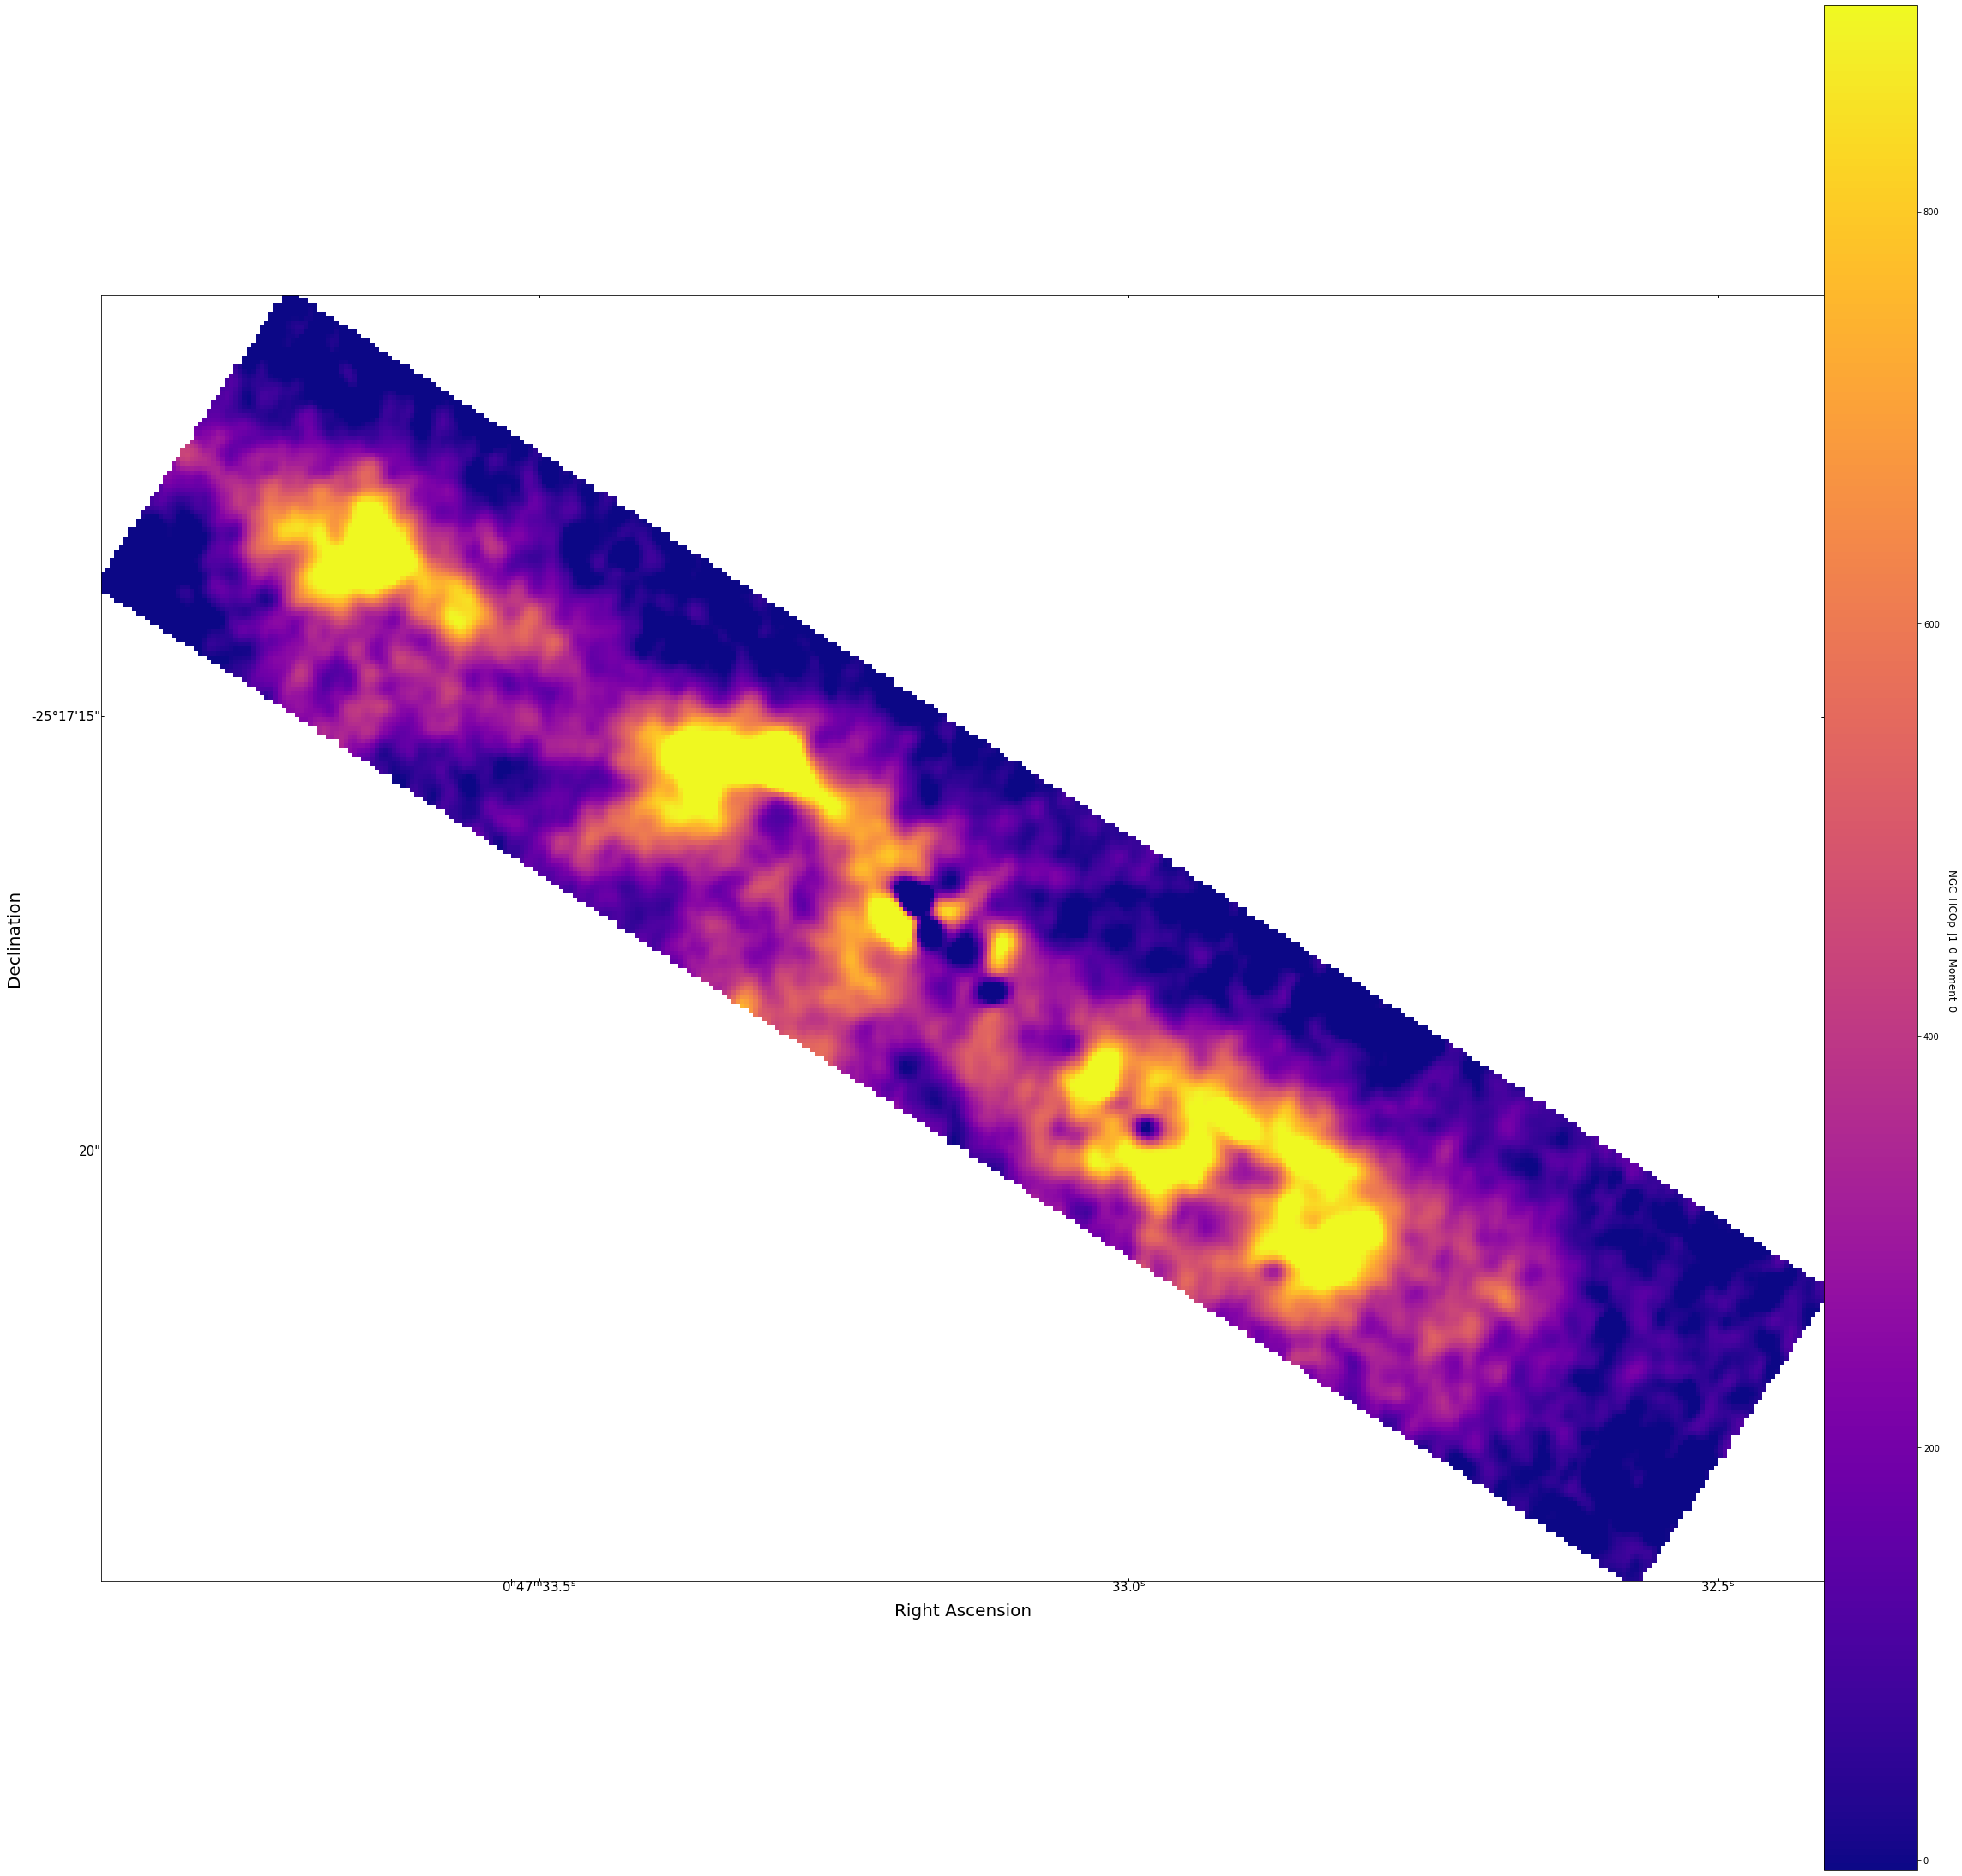

nan K


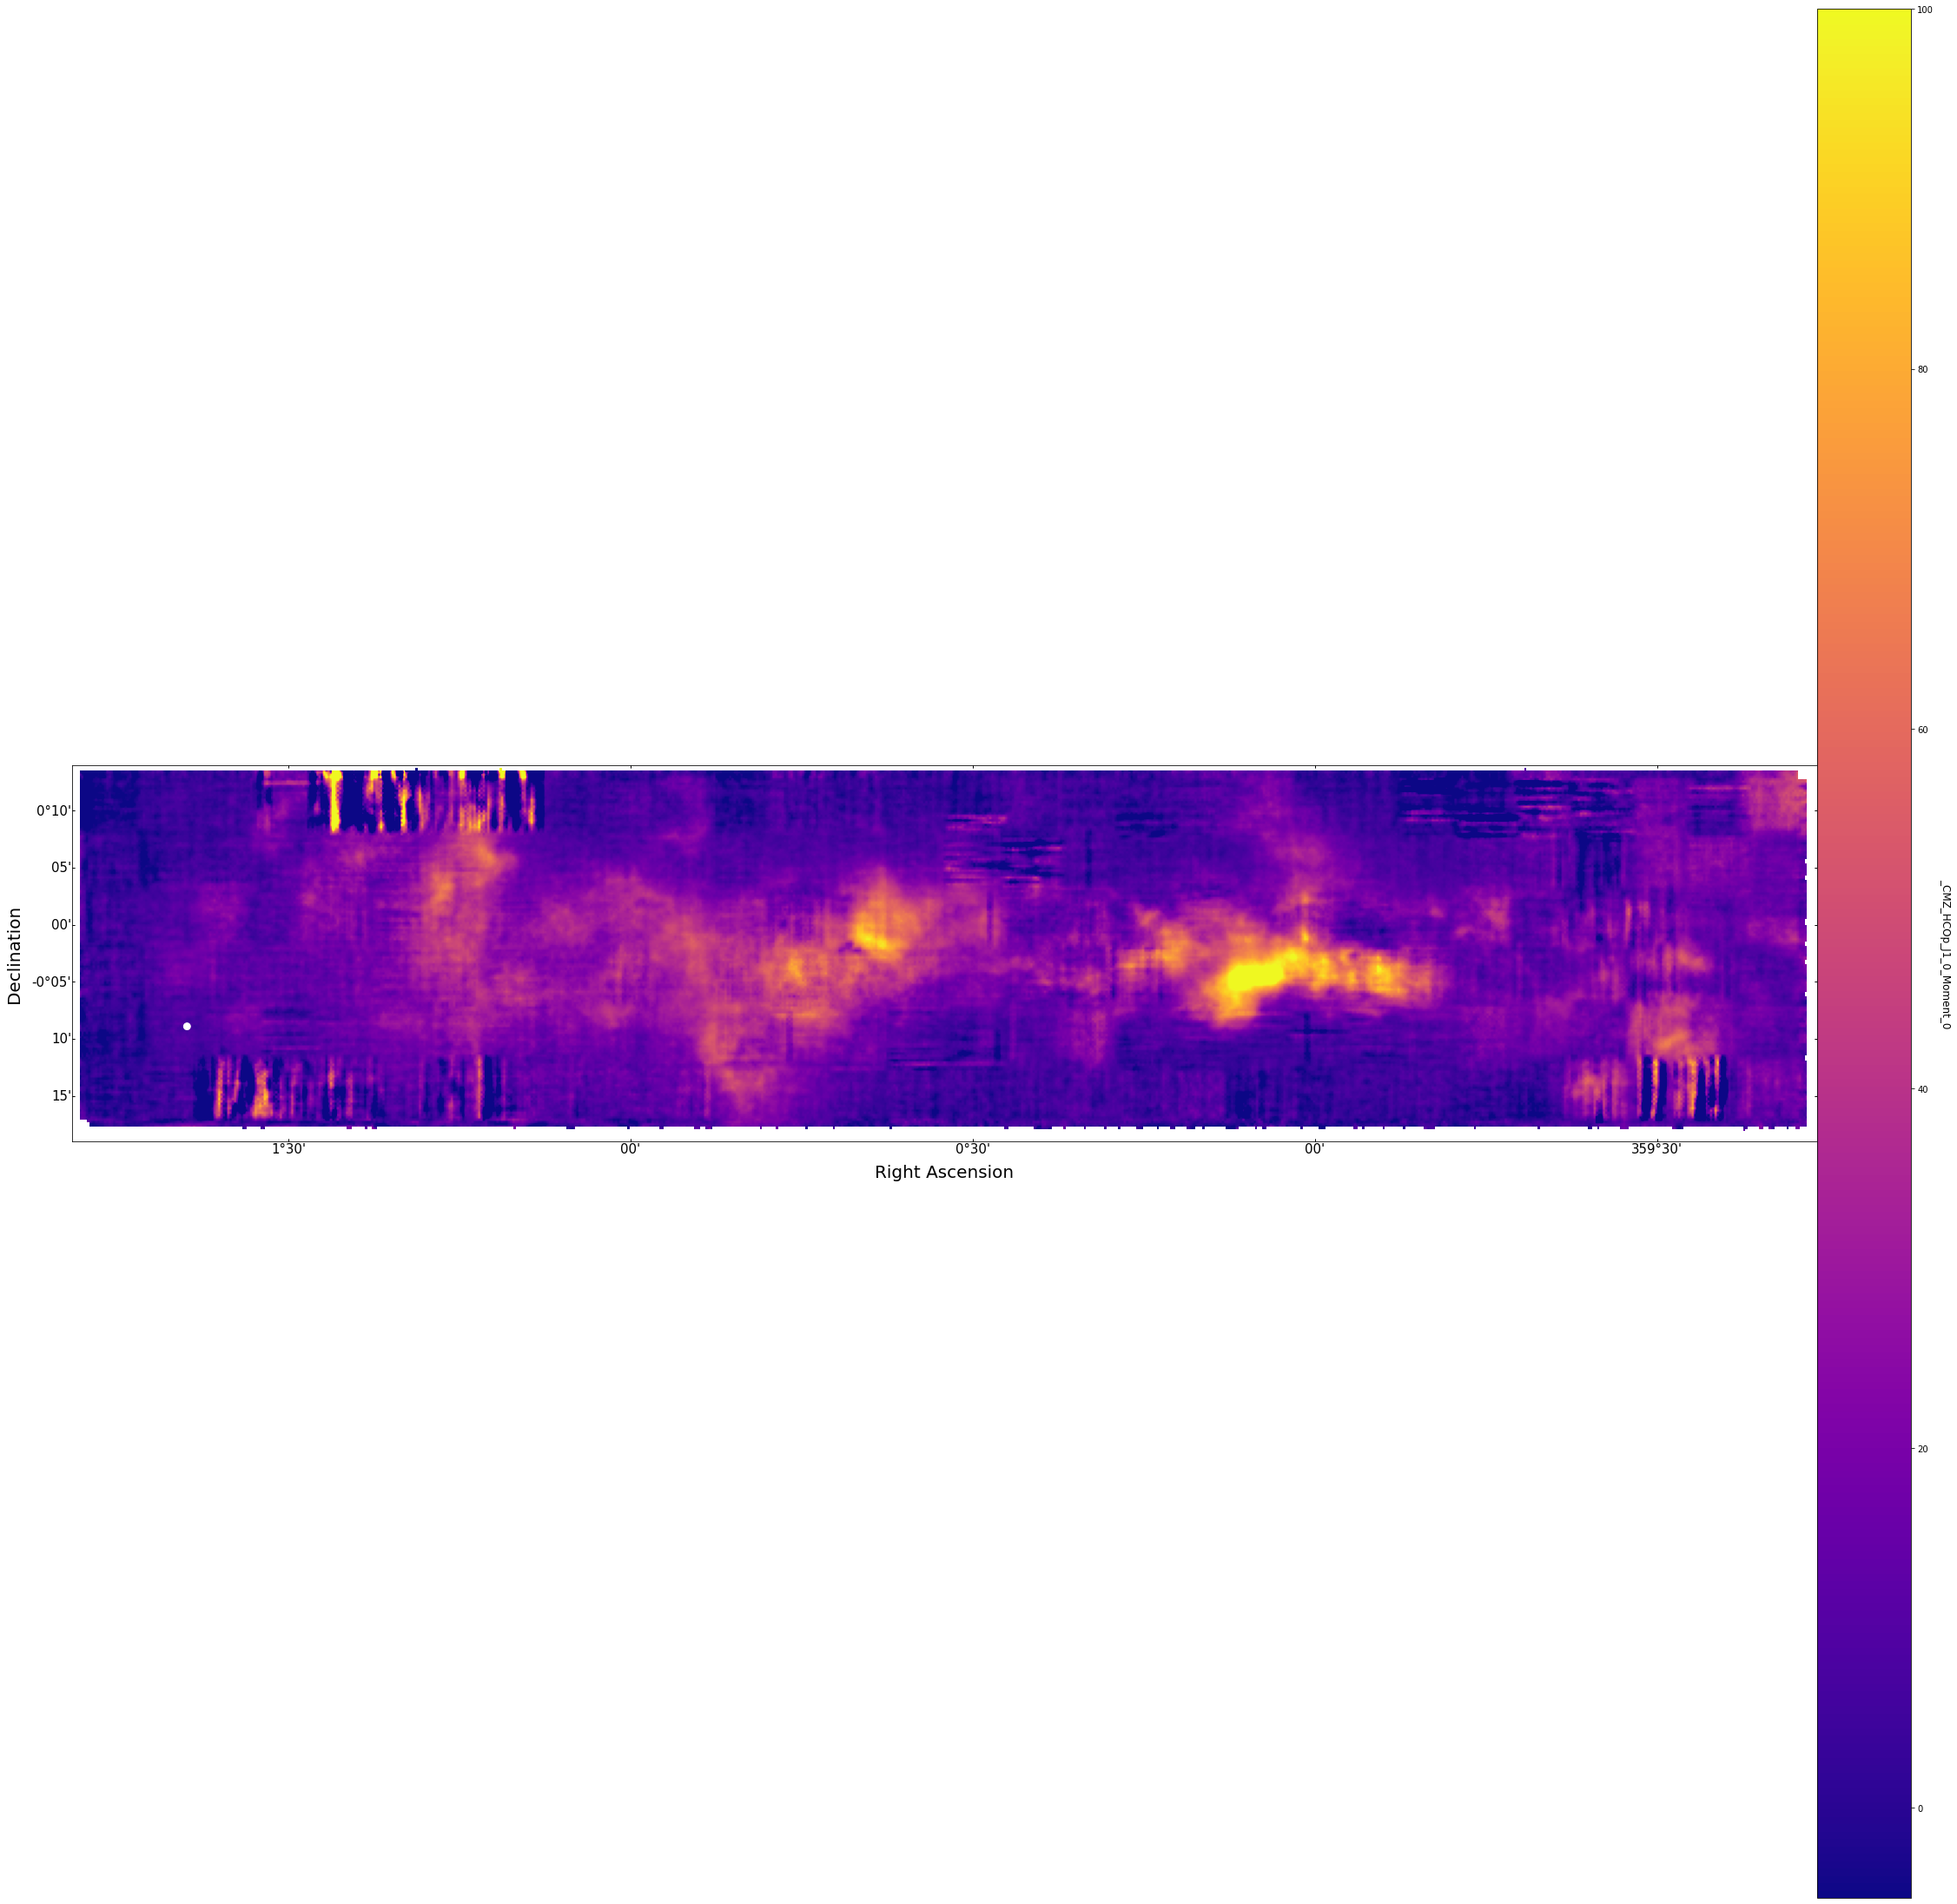

In [2]:
#momnents
from matplotlib.patches import Arrow, Circle

File = "Cropped_4.3pc_beam__NGC_HCOp_J1_0_70x360pc_3.3_vel_res.fits"

fig = plt.figure(1,figsize=(40,40))
        
#File = 'HCOp_J1-0.cube.fits'
Q = SpectralCube.read(File).with_spectral_unit(u.km/u.s,velocity_convention="radio")
Q.allow_huge_operations=True
Q = Q.to(u.K)
print(Q[0][0][0])
ax = pylab.subplot(1,1,1,projection=Q.wcs[:][:][0])
RA = ax.coords[0]                                                                  #
Dec = ax.coords[1]
im = pylab.imshow(Q.moment0().hdu.data,vmin= -5,vmax = 900,cmap='plasma')
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3)
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True)                                                                                    
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                              
pylab.ylabel('Declination',fontsize=20,labelpad=1)
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im,fraction=.1,pad=0.0)                                    
cb.set_label(label="_NGC_HCOp_J1_0_Moment_0",fontsize=12,rotation=270,labelpad=20)
cb.ax.tick_params(which = 'major', labelsize = 10)  
#pylab.annotate(s=Name2,fontsize=10,xy=(pos1,pos2),xycoords="axes fraction")  



ax.add_patch(Circle((60, 140), radius=3/2, color='white'))


pylab.show()

#momnents
fig = plt.figure(1,figsize=(40,40))
#File = 'Cropped_4.3pc_beam__CMZ_HCO_J1_0_4.3_start70x360pc_3.3_vel_res.fits'
File = 'CMZ_3mm_HCO+.fits'
Q = SpectralCube.read(File).with_spectral_unit(u.km/u.s,velocity_convention="radio")
Q.allow_huge_operations=True
Q = Q.to(u.K)
print(Q[0][0][0])
ax = pylab.subplot(1,1,1,projection=Q.wcs[:][:][0])
RA = ax.coords[0]                                                                  #
Dec = ax.coords[1]
im = pylab.imshow(Q.moment0().hdu.data,vmin= -5,vmax = 100,cmap='plasma')
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3)
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True)                                                                                    
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                              
pylab.ylabel('Declination',fontsize=20,labelpad=1)
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im,fraction=.1,pad=0.0)                                    
cb.set_label(label="_CMZ_HCOp_J1_0_Moment_0",fontsize=12,rotation=270,labelpad=20)
cb.ax.tick_params(which = 'major', labelsize = 10)  
ax.add_patch(Circle((50,50), radius=3/2, color='white'))
#pylab.annotate(s=Name2,fontsize=10,xy=(pos1,pos2),xycoords="axes fraction")  

pylab.show()
       

4.3


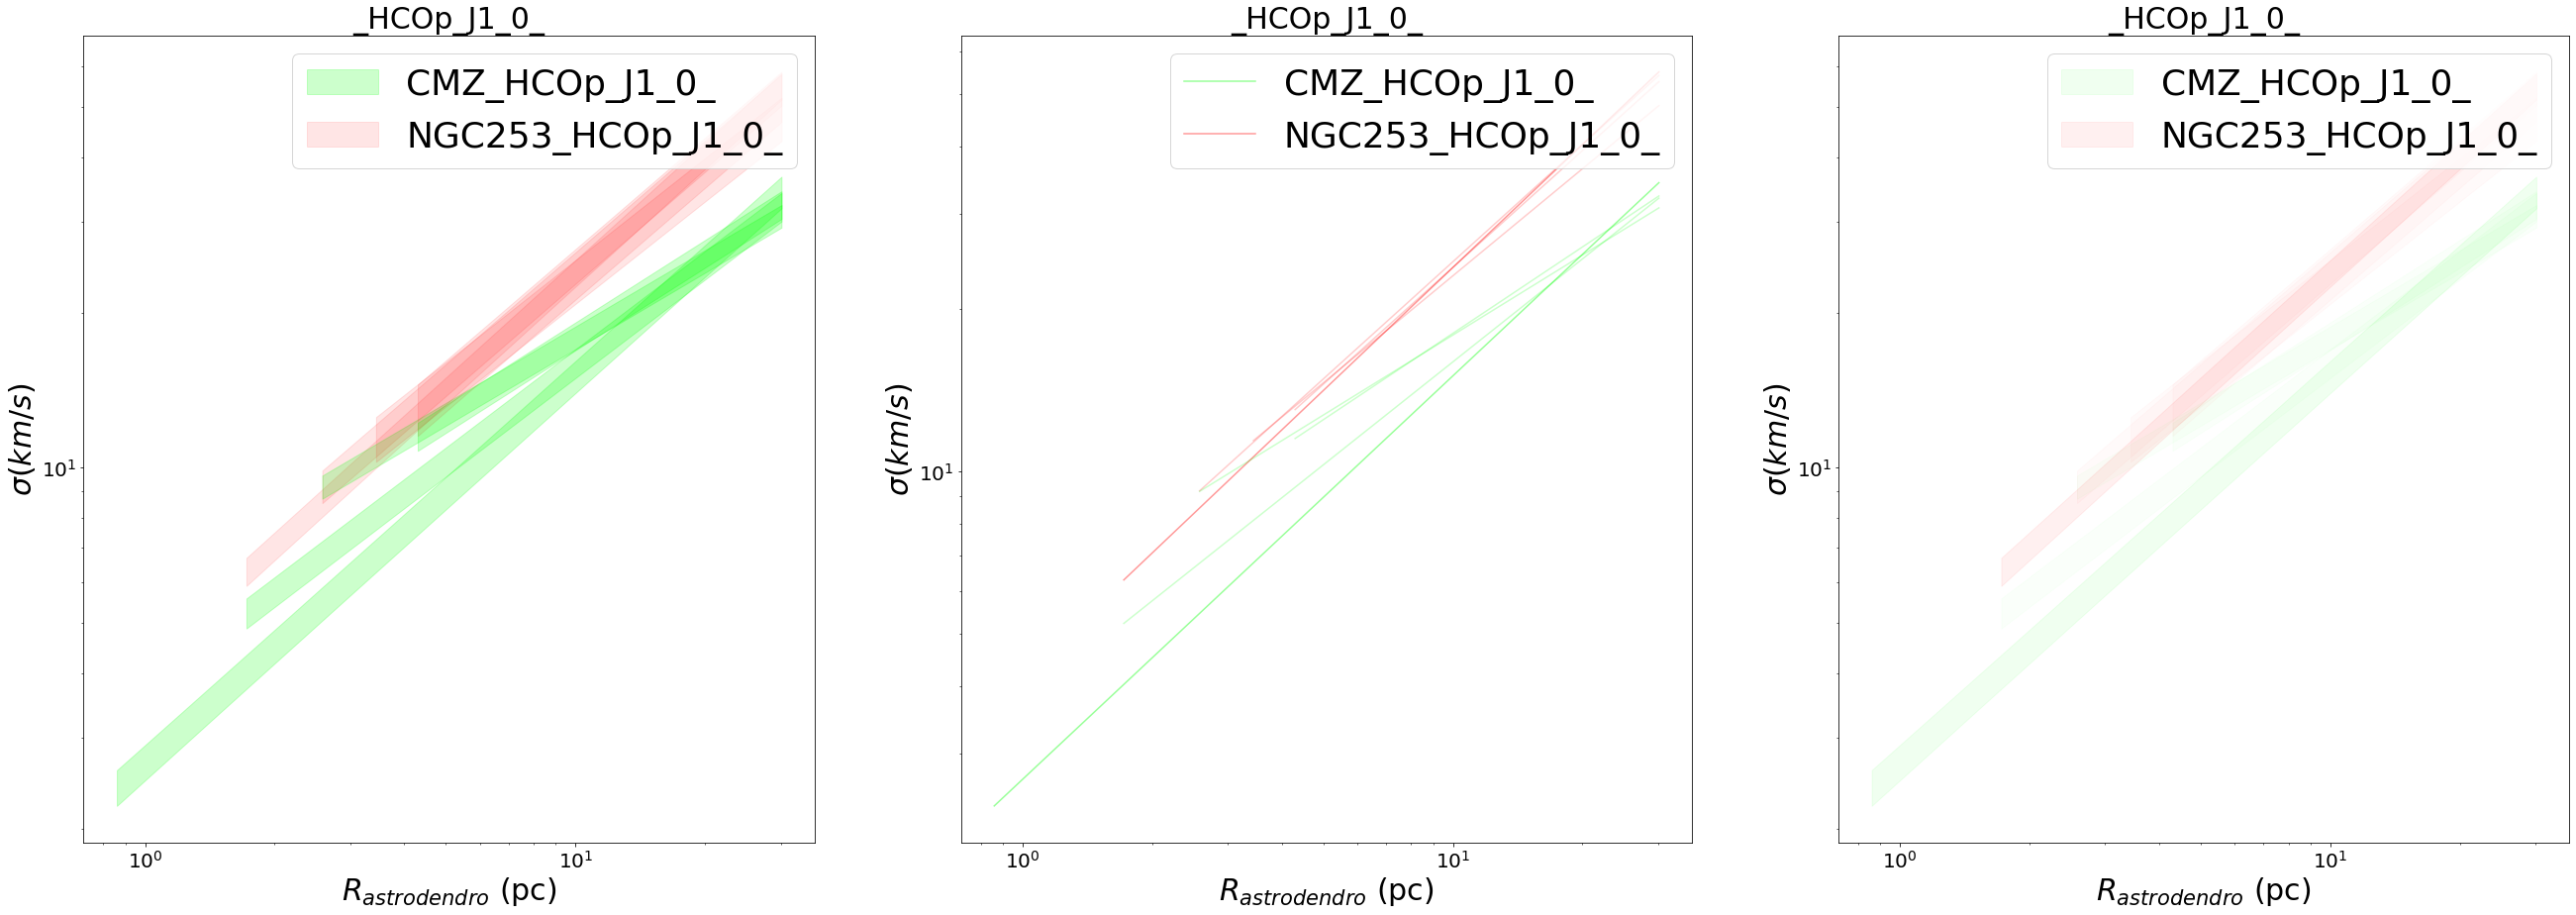

4.3


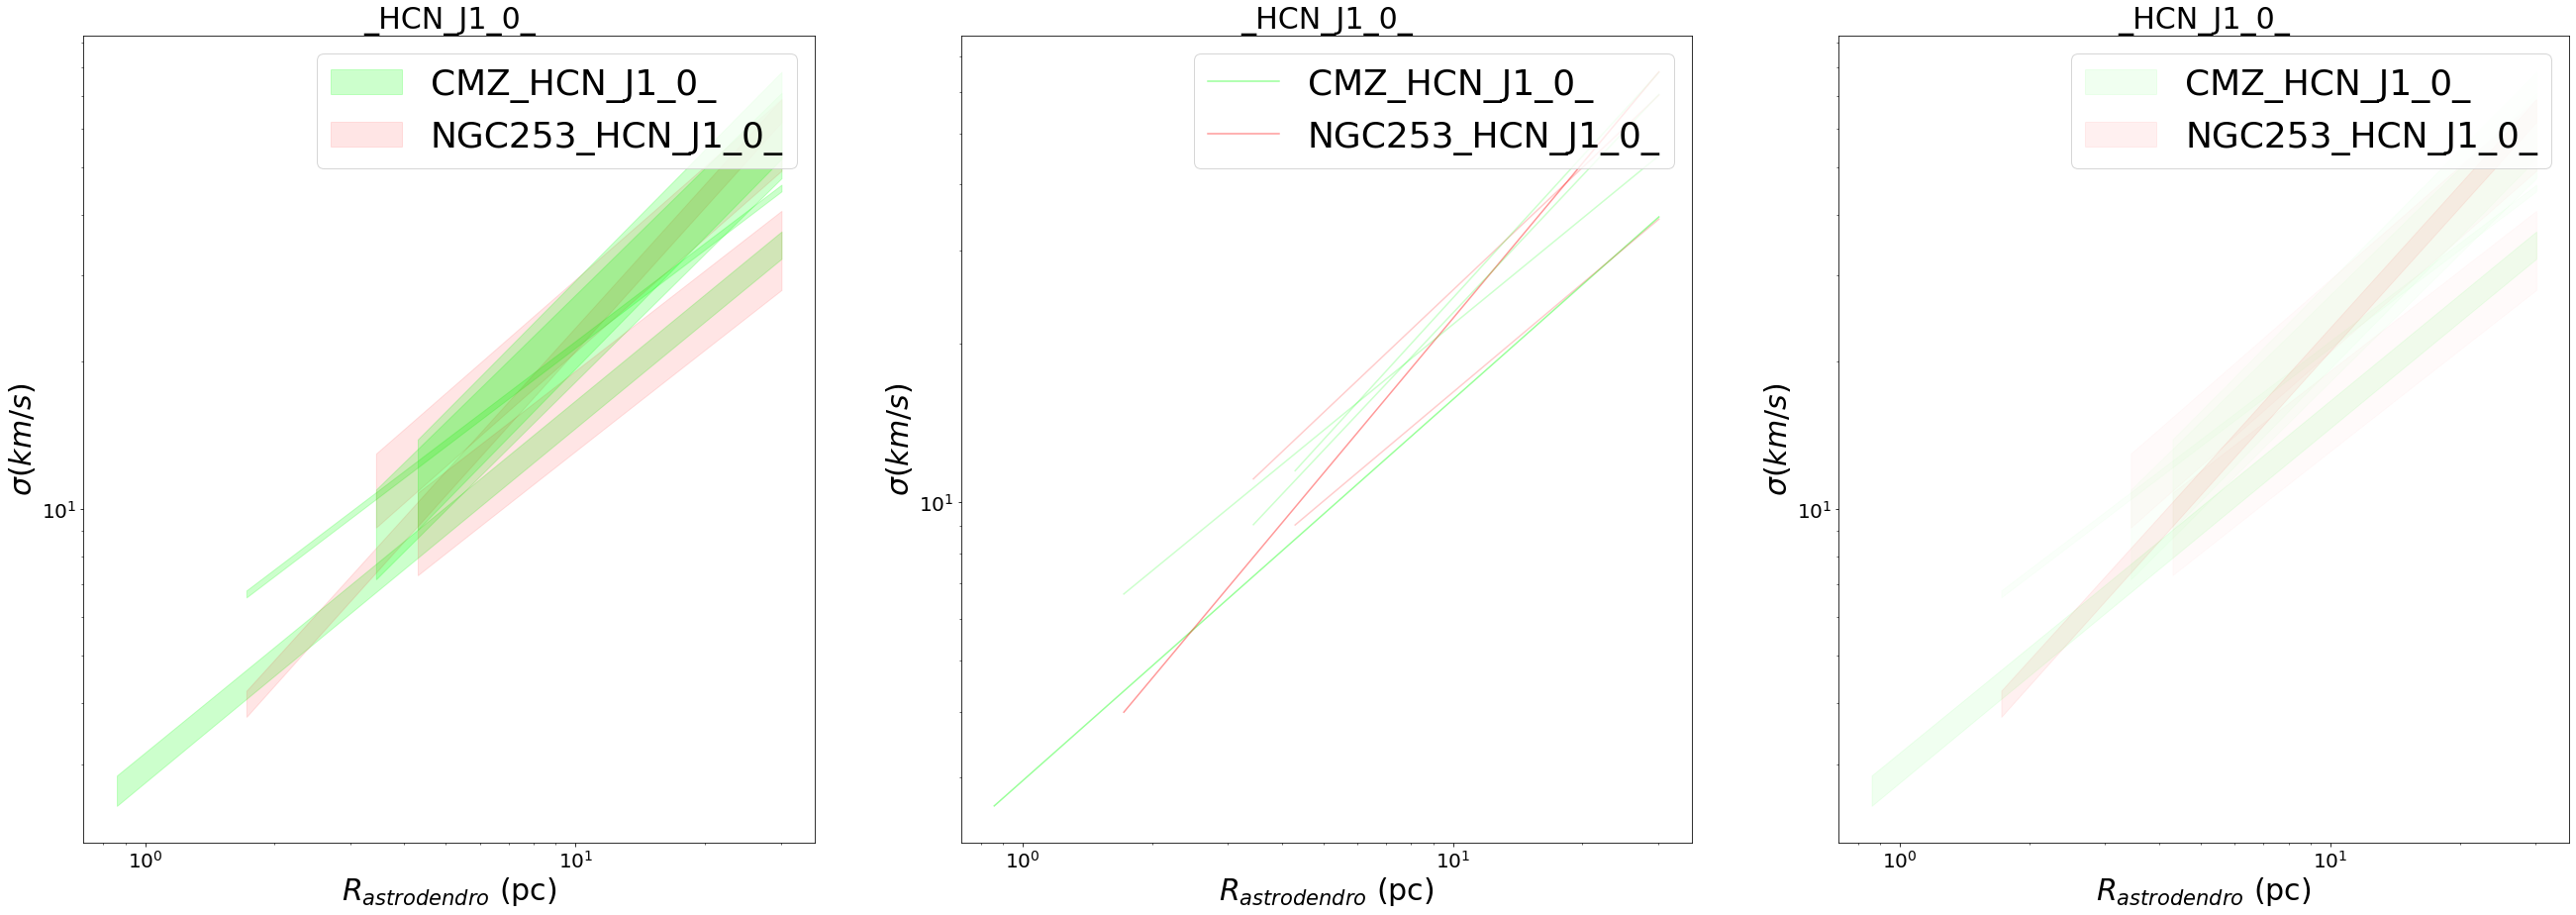

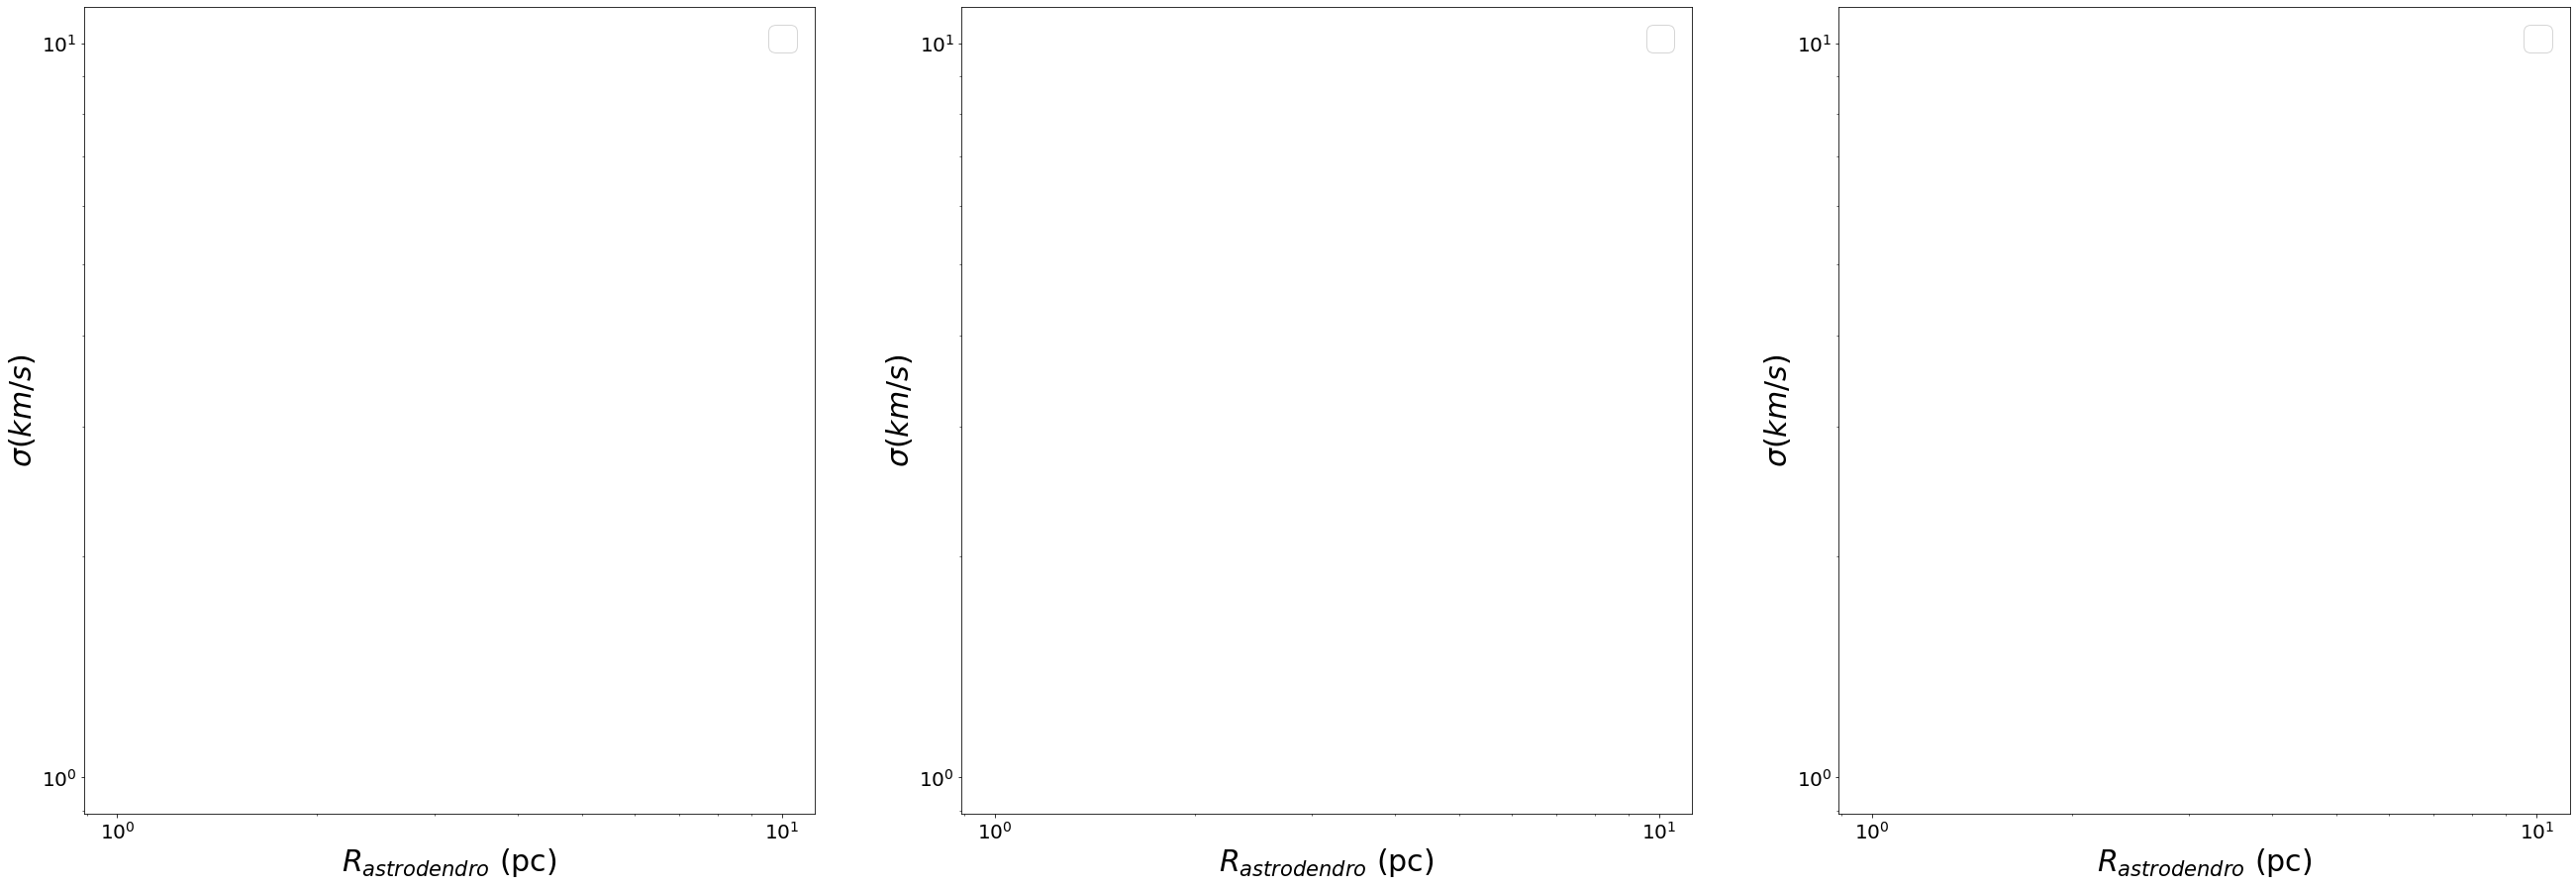

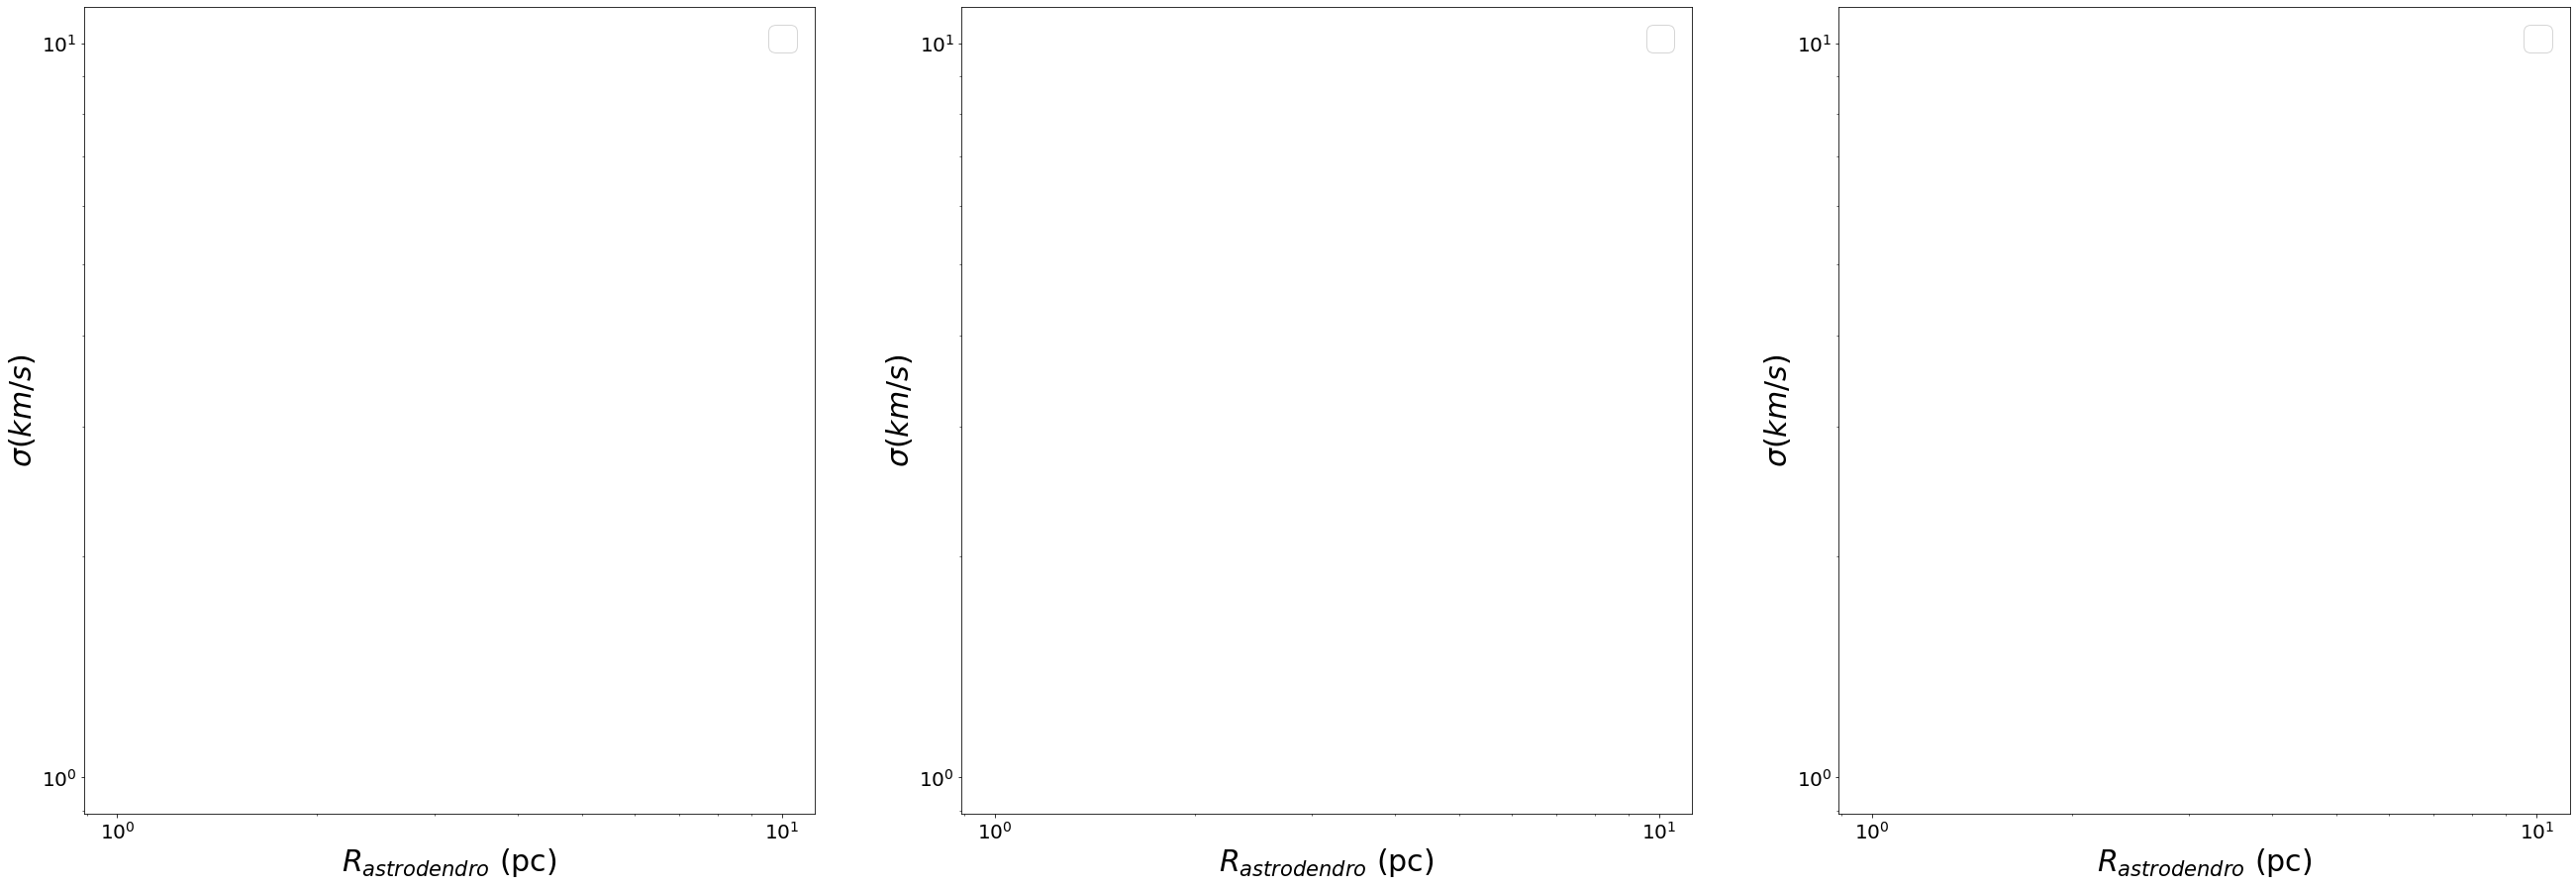

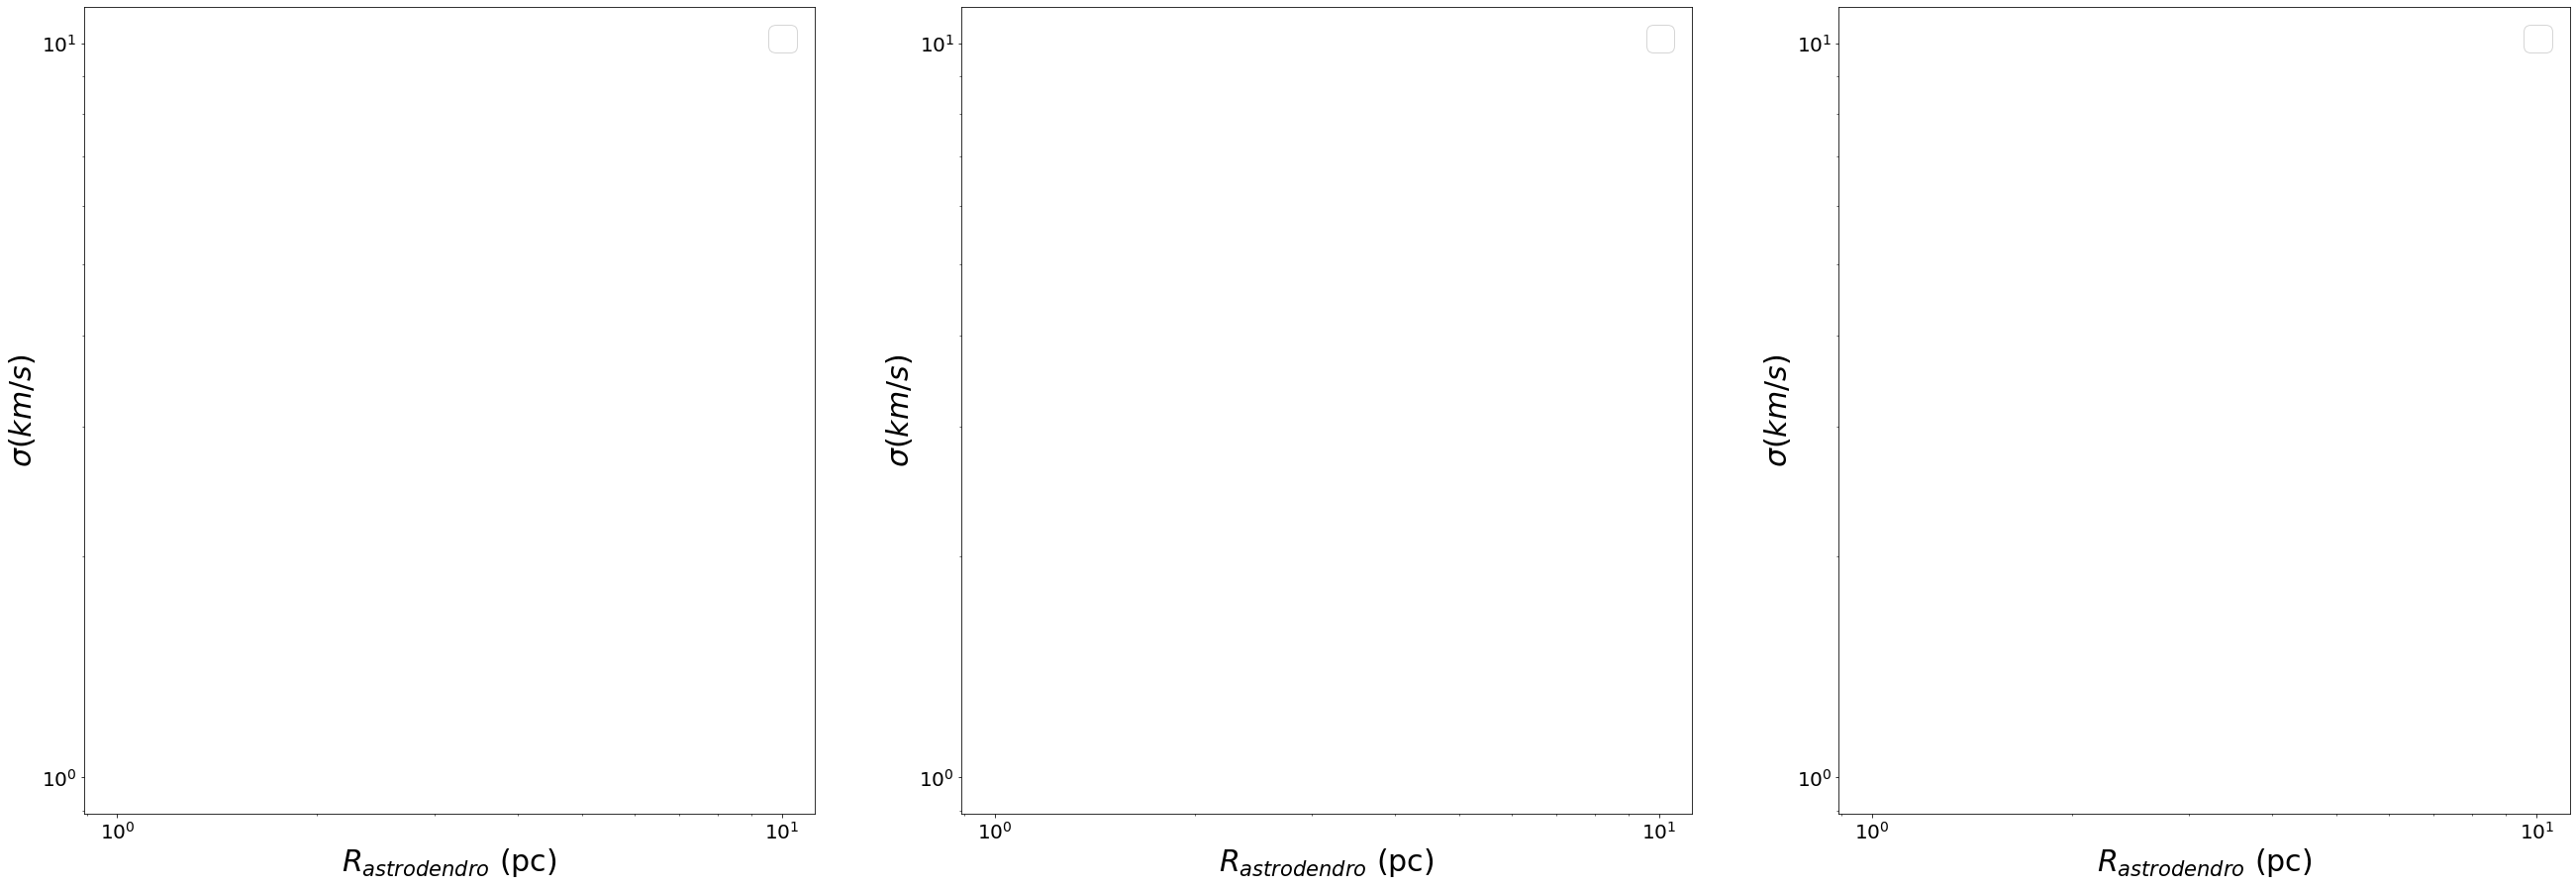

4.3


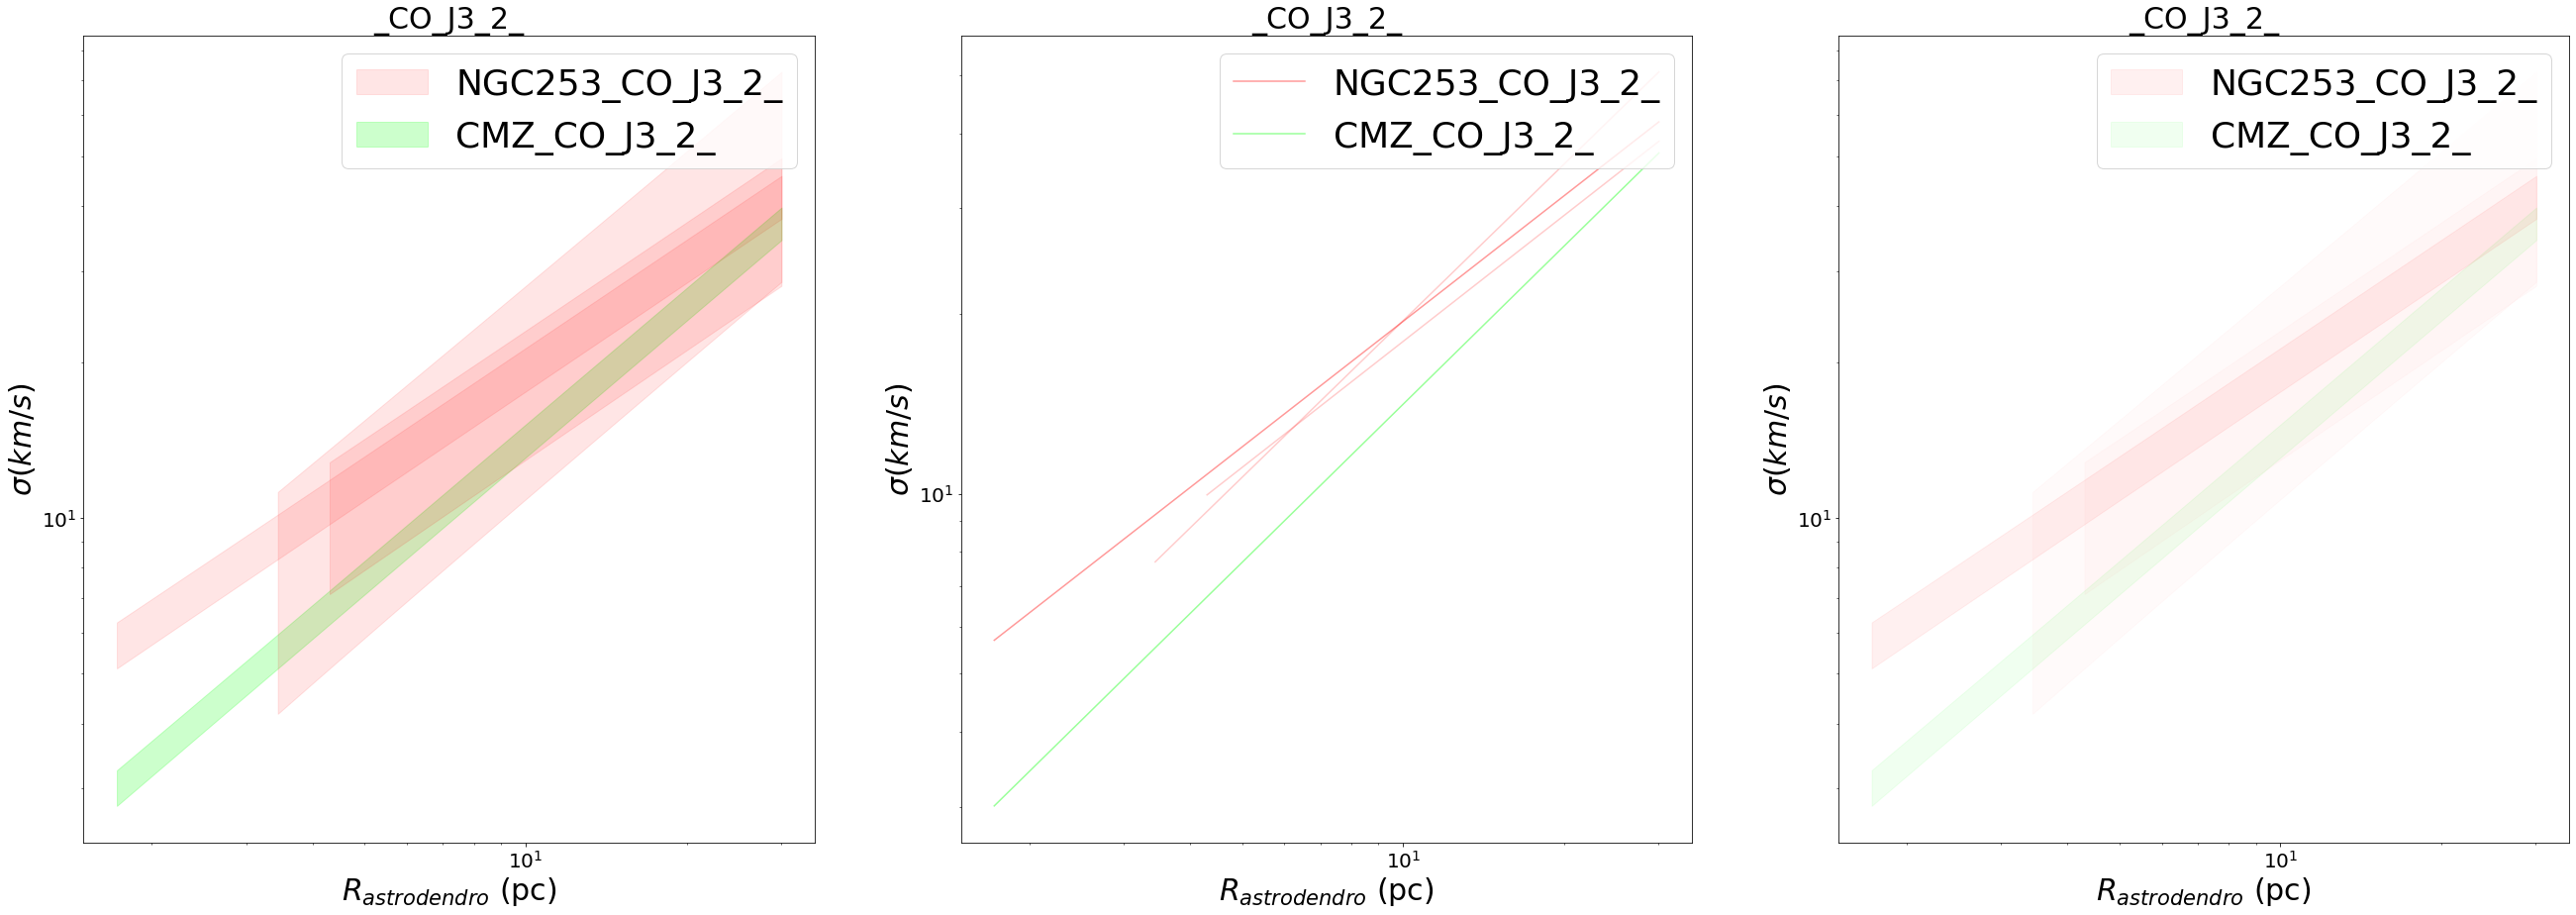

In [59]:
#Plot all these different exp and coeffs, and see that theyre probably the same

CMZLs = ["HCO+_1_0","HCN_1_0",'H13CN_1_0','H13CO+_1_0',"CO_3_2","CO_3_2_4.3"]


def func(R,a,b):
    return a*R**(b)

Line_Names = ['_HCOp_J1_0_','_HCN_J1_0_','','','','_CO_J3_2_']
Line_Names_CMZ = ['_HCOp_J1_0_','_HCN_J1_0_','','','','_CO_J3_2_']
NGCNames=list(np.load("Names_New_All_Kinds.npy",allow_pickle=True))
CMZNames=list(np.load("CMZ_Names_New_All_Kinds.npy",allow_pickle=True))

#CMZNames=list(np.load("CMZ_Names_New_All_Kinds.npy"))



Abs_Levels = ["All","None","No Clusters", "None (m)", "None All Channels"]
Suffixes=['','_NA','_No_Clusters','None_m','None_All_Channels']


savePath='/home/ben/Documents/Grad Stuff/MM data/Result Files'


av_data = np.zeros((6,len(Suffixes),2,50))
av_data_upper= np.zeros((6,len(Suffixes),2,50))
av_data_lower= np.zeros((6,len(Suffixes),2,50))

av_data_CMZ = np.zeros((6,len(Suffixes),2,50))
av_data_upper_CMZ= np.zeros((6,len(Suffixes),2,50))
av_data_lower_CMZ= np.zeros((6,len(Suffixes),2,50))

qs=np.zeros((6,len(Suffixes),1))
qes=np.zeros((6,len(Suffixes),1))
qs_cmz=np.zeros((6,len(Suffixes),1))
qes_cmz=np.zeros((6,len(Suffixes),1))

qs_err=np.zeros((6,len(Suffixes),2))
qes_err=np.zeros((6,len(Suffixes),2))
qs_cmz_err=np.zeros((6,len(Suffixes),2))
qes_cmz_err=np.zeros((6,len(Suffixes),2))


beams=1
vels=1
beam_reqs=5
pixel_reqs=1
SNRs=1
delts=1
alpha=.02
for i in range(0,6):
    
    fig = plt.figure(1,figsize=(45,15))
    ax1= pylab.subplot(1,3,1) 
    ax2= pylab.subplot(1,3,2)
    ax3= pylab.subplot(1,3,3)
    First = True
    First2 = True
    
    
    Params=np.genfromtxt(os.path.join(savePath,'_NGC_CO_J3_2_'+"_Params"))#[iterations,iter_factor ,Line_Name,Name,ovs,min_vel,FOV,Min_res,Min_beam_req]
    iterations,iter_factor,ovs,min_vel,FOV,Min_res,Min_beam_req = int(Params[0]),Params[1],int(Params[2]),Params[3],np.array(Params[4]),Params[5],Params[6]
    
    
    
    
    #for k5 in range(len(Suffixes)):
    for k5 in range(1):

                
                
        Net_Vars = [[],[]]
        Net_Std=[[],[]]

        Net_Beams=[]
        Net_Vels=[]
        Net_Beam_Req=[]
        Net_Pix_Req=[]
        All_Things_Coeff=[]
        All_Things_Exp=[]
        All_Things_Both=[]
        
        Net_Vars = [[],[]]
        Net_Std=[[],[]]
        Net_Weights=[]
        
        
        
        Net_Beams_CMZ=[]
        Net_Vels_CMZ=[]
        Net_Beam_Req_CMZ=[]
        Net_Pix_Req_CMZ=[]
        All_Things_Coeff_CMZ=[]
        All_Things_Exp_CMZ=[]
        All_Things_Both_CMZ=[]
        Net_Vars_CMZ = [[],[]]
        Net_Std_CMZ=[[],[]]
        Net_Weights_CMZ=[]
            
            
        Suffix=Suffixes[k5]
        Abs_Level =Abs_Levels[k5]

        
        #for kl in range(iterations):
        for kl in range(beams):

            if(Line_Names[i]==''):
                break





            Prime_Beam = Min_res*((kl*iter_factor+1))#
            print(Prime_Beam)


            for km in range(vels):

                vel_prime = min_vel*((km*iter_factor+1))

                

                
                

                for k3 in range(beam_reqs):
                

                    beam_req = Min_beam_req*(k3+1)
                    
                    xs = np.linspace(beam_req*Prime_Beam,Prime_Beam*7,50)
                    for k4 in range(pixel_reqs):
                        for k6 in range(delts):
                            delt_factor = (3/5+k6/5)

                            for k7 in range(SNRs):
                                noise_factor = (3/5+k7/5)

                                try:

                                    pix_thresh_factor = k4+1

                                    Name = NGCNames[i][kl][km][k3][k4][k6][k7] 
                                    NameCMZ = CMZNames[i][kl][km][k3][k4][k6][k7]

                                    #print(os.path.join(savePath,Name+"_NGC253_Coeffs"+Suffix))
                                    Vars= np.genfromtxt(os.path.join(savePath,Name+"_NGC253_Coeffs"+Suffix))
                                    Covars= np.genfromtxt(os.path.join(savePath,Name+"_NGC253_Coeff_CoVar"+Suffix))

                                    Weights= np.genfromtxt(os.path.join(savePath,Name+"_NGC253_Fit_weights"+Suffix))

                                    if((Vars[0] > 0 or Vars[0] < 0 )and (Covars[0][0] >0 or Covars[0][0]<0) and np.isfinite(Covars[0][0]) and Vars[0]<6 and Vars[1]<1 and Vars[1]>0):
                                        #print("C")

                                        if(First):

                                            First=False
                                            NGC_f2 = ax1.fill_between(xs,func(xs,Vars[0]+np.sqrt(Covars[0][0]),Vars[1])+np.sqrt(Covars[1][1]),func(xs,Vars[0]-np.sqrt(Covars[0][0]),Vars[1])-np.sqrt(Covars[1][1]),color="#FF0000",label="NGC253"+str(Line_Names[i]),alpha=.1)
                                            NGC_f1 = ax2.plot(xs,func(xs,Vars[0],Vars[1]),color="#FF0000",label="NGC253"+str(Line_Names[i]),alpha=.4)
                                            NGC_f6 = ax3.fill_between(xs,func(xs,Vars[0]+np.sqrt(Covars[0][0]),Vars[1])+np.sqrt(Covars[1][1]),func(xs,Vars[0]-np.sqrt(Covars[0][0]),Vars[1])-np.sqrt(Covars[1][1]),color="#FF0000",label="NGC253"+str(Line_Names[i]),alpha=.06)
                                            #print("dddddddddddddddddddddddddddd")
                                        else:
                                            NGC_f3 = ax2.plot(xs,func(xs,Vars[0],Vars[1]),color="#FF0000",alpha=.2)
                                            NGC_f4 = ax1.fill_between(xs,func(xs,Vars[0]+np.sqrt(Covars[0][0]),Vars[1])+np.sqrt(Covars[1][1]),func(xs,Vars[0]-np.sqrt(Covars[0][0]),Vars[1])-np.sqrt(Covars[1][1]),color="#FF0000",alpha=.1)
                                            NGC_f5 = ax3.fill_between(xs,func(xs,Vars[0]+np.sqrt(Covars[0][0]),Vars[1])+np.sqrt(Covars[1][1]),func(xs,Vars[0]-np.sqrt(Covars[0][0]),Vars[1])-np.sqrt(Covars[1][1]),color="#FF0000",alpha=alpha)
                                            #print("d")




                                    Vars= np.genfromtxt(os.path.join(savePath,NameCMZ+"_CMZ_Coeffs"+Suffix+NM_mod))
                                    Covars= np.genfromtxt(os.path.join(savePath,NameCMZ+"_CMZ_Coeff_CoVar"+Suffix+NM_mod))

                                    Weights= np.genfromtxt(os.path.join(savePath,NameCMZ+"_CMZ_Fit_weights"+Suffix+NM_mod))

                                    if((Vars[0] > 0 or Vars[0] < 0 )and (Covars[0][0] >0 or Covars[0][0]<0) and np.isfinite(Covars[0][0]) and Vars[0]<6 and Vars[1]<1 and Vars[1]>0):
                                        #print("E")
                                        if(First2):

                                            First2=False

                                            CMZ_f1 = ax1.fill_between(xs,func(xs,Vars[0]+np.sqrt(Covars[0][0]),Vars[1])+np.sqrt(Covars[1][1]),func(xs,Vars[0]-np.sqrt(Covars[0][0]),Vars[1])-np.sqrt(Covars[1][1]),color="#00FF00",label="CMZ"+str(Line_Names[i]),alpha=.2)
                                            CMZ_f2 = ax2.plot(xs,func(xs,Vars[0],Vars[1]),color="#00FF00",label="CMZ"+str(Line_Names[i]),alpha=.4)
                                            CMZ_f6 = ax3.fill_between(xs,func(xs,Vars[0]+np.sqrt(Covars[0][0]),Vars[1])+np.sqrt(Covars[1][1]),func(xs,Vars[0]-np.sqrt(Covars[0][0]),Vars[1])-np.sqrt(Covars[1][1]),color="#00FF00",label="CMZ"+str(Line_Names[i]),alpha=.06)
                                            #print("d")
                                        else:
                                            CMZ_f3 = ax2.plot(xs,func(xs,Vars[0],Vars[1]),color="#00FF00",alpha=.2)
                                            CMZ_f4 = ax1.fill_between(xs,func(xs,Vars[0]+np.sqrt(Covars[0][0]),Vars[1])+np.sqrt(Covars[1][1]),func(xs,Vars[0]-np.sqrt(Covars[0][0]),Vars[1])-np.sqrt(Covars[1][1]),color="#00FF00",alpha=.2)
                                            CMZ_f5 = ax3.fill_between(xs,func(xs,Vars[0]+np.sqrt(Covars[0][0]),Vars[1])+np.sqrt(Covars[1][1]),func(xs,Vars[0]-np.sqrt(Covars[0][0]),Vars[1])-np.sqrt(Covars[1][1]),color="#00FF00",alpha=alpha)
                                            #print("d")

                                    #print(i,kl,km,k3,k4,k5,"C")        
                                except Exception as e:

                                    #print(e)
                                    #print(i,kl,km,k3,k4,k5,"F")
                                    #print("Failed")
                                    #print("-"*60)
                                    #traceback.print_exc(file=sys.stdout)
                                    pass
        
        ax1.legend(prop={'size': 36},loc="upper right")
        ax2.legend(prop={'size': 36},loc="upper right")
        ax3.legend(prop={'size': 36},loc="upper right")
        ax3.set_title(("{0}".format(Line_Names[i])), fontsize=30)
        ax2.set_title(("{0}".format(Line_Names[i])), fontsize=30)
        ax1.set_title(("{0}".format(Line_Names[i])), fontsize=30)
        ax1.tick_params(axis='both', which='major', labelsize=20)    
        ax2.tick_params(axis='both', which='major', labelsize=20)    
        ax3.tick_params(axis='both', which='major', labelsize=20)    
        
        
        ax1.set_xlabel(r'$R_{astrodendro}$ (pc)',fontsize=30)
        ax1.set_ylabel(r'$\sigma   (km/s)$',fontsize=30)
        ax1.set_yscale('log')
        ax1.set_xscale('log')
        ax2.set_xlabel(r'$R_{astrodendro}$ (pc)',fontsize=30)
        ax2.set_ylabel(r'$\sigma   (km/s)$',fontsize=30)
        ax2.set_yscale('log')
        ax2.set_xscale('log')
        ax3.set_xlabel(r'$R_{astrodendro}$ (pc)',fontsize=30)
        ax3.set_ylabel(r'$\sigma   (km/s)$',fontsize=30)
        ax3.set_yscale('log')
        ax3.set_xscale('log')
        plt.show()


In [ ]:
#Compare fits for molecules
#CMZ
#ALL abs levels
#CMZLs = ["HCO+_1_0","HCN_1_0",'H13CN_1_0','H13CO+_1_0',"CO_3_2"]
#CMZLs = ["HCO+_1_0","HCN_1_0",'H13CN_1_0',"CO_3_2"]
CMZLs = ["HCO+_1_0","HCN_1_0","CO_3_2","CO_3_2_4.3"]

for lmi in range(3):
    Index = lmi*2
    if lmi ==0:
        Suffix=""
        colorNGC = "orange"
        colorCMZ = "blue"
    if lmi ==1:
        Suffix="_NA"
        colorNGC = "red"
        colorCMZ = "purple"
    if lmi ==2:
        Suffix="_No_Clusters"
        colorNGC = "green"
        colorCMZ = "cyan"

        
    ngc_coeff = np.array([],dtype=type(.10))
    ngc_err_coeff =np.array([],dtype=type(.10))
    ngc_exp = np.array([],dtype=type(.10))
    ngc_err_exp =np.array([],dtype=type(.10))
    cmz_coeff = np.array([],dtype=type(.10))
    cmz_err_coeff =np.array([],dtype=type(.10))
    cmz_exp = np.array([],dtype=type(.10))
    cmz_err_exp =np.array([],dtype=type(.10))

    ngc_coeff_mean_err=0
    ngc_exp_mean_err=0
    cmz_coeff_mean_err=0
    cmz_exp_mean_err=0
    n=4
    ni=np.array(range(0,n),dtype=type(0))
    line_nums=[]
    line_nums2=np.array(np.linspace(-99,99,n),dtype=type(.0))
    for i in ni:
        er_r=1
        line_nums.append(i+Index/12)
        ngc_coeff = np.append(ngc_coeff,np.genfromtxt(CMZLs[i]+"_NGC253_Coeffs"+Suffix)[0])
        ngc_err_coeff = np.append(ngc_err_coeff,np.sqrt(np.genfromtxt(CMZLs[i]+"_NGC253_Coeff_CoVar"+Suffix)[0][0]))
        ngc_exp = np.append(ngc_exp,np.genfromtxt(CMZLs[i]+"_NGC253_Coeffs"+Suffix)[1])
        ngc_err_exp = np.append(ngc_err_exp,np.sqrt(np.genfromtxt(CMZLs[i]+"_NGC253_Coeff_CoVar"+Suffix)[1][1]))
        cmz_coeff = np.append(cmz_coeff,np.genfromtxt(CMZLs[i]+"_CMZ_Coeffs"+Suffix)[0])
        cmz_err_coeff = np.append(cmz_err_coeff,np.sqrt(np.genfromtxt(CMZLs[i]+"_CMZ_Coeff_CoVar"+Suffix)[0][0]))
        cmz_exp = np.append(cmz_exp,np.genfromtxt(CMZLs[i]+"_CMZ_Coeffs"+Suffix)[1])
        cmz_err_exp = np.append(cmz_err_exp ,np.sqrt(np.genfromtxt(CMZLs[i]+"_CMZ_Coeff_CoVar"+Suffix)[1][1]))

        #Propagate errs to mean
        ngc_coeff_mean_err+=ngc_err_coeff[i]**2/5**2
        ngc_exp_mean_err+=ngc_err_exp[i]**2/5**2
        cmz_coeff_mean_err+=cmz_err_coeff[i]**2/5**2
        cmz_exp_mean_err+=cmz_err_exp[i]**2/5**2
        print(ngc_coeff_mean_err,ngc_exp_mean_err,cmz_coeff_mean_err,cmz_exp_mean_err,i)
    line_nums = np.array(line_nums,dtype=type(.0))
    ngc_coeff_mean=np.mean(ngc_coeff)
    ngc_exp_mean=np.mean(ngc_exp)
    cmz_coeff_mean=np.mean(cmz_coeff)
    cmz_exp_mean=np.mean(cmz_exp)
    #Propagated errs
    ngc_coeff_mean_err=np.sqrt(ngc_coeff_mean_err)
    ngc_exp_mean_err=np.sqrt(ngc_exp_mean_err)
    cmz_coeff_mean_err=np.sqrt(cmz_coeff_mean_err)
    cmz_exp_mean_err=np.sqrt(cmz_exp_mean_err)
    print(ngc_coeff_mean_err,ngc_exp_mean_err,cmz_coeff_mean_err,cmz_exp_mean_err)


    fig = plt.figure(1,figsize=(16,8))
    axA = pylab.subplot(1,2, 1)
    axA2 = pylab.subplot(1,2, 2)


    #axA.plot(line_nums2,np.full(n,ngc_coeff_mean),color=colorNGC,label="NGC253 avg SL Coeff"+Suffix)
    axA.plot(line_nums2,np.full(n,cmz_coeff_mean),color=colorCMZ,label="CMZ avg SL Coeff"+Suffix)
    #axA2.plot(line_nums2,np.full(n,ngc_exp_mean),color=colorNGC,label="NGC253 avg SL Exp"+Suffix)
    axA2.plot(line_nums2,np.full(n,cmz_exp_mean),color=colorCMZ,label="CMZ avg SL Exp"+Suffix)

    #axA.fill_between(line_nums2,np.full(n,ngc_coeff_mean+er_r*ngc_coeff_mean_err),np.full(n,ngc_coeff_mean-er_r*ngc_coeff_mean_err),color=colorNGC,alpha=.2)
    axA.fill_between(line_nums2,np.full(n,cmz_coeff_mean+er_r*cmz_coeff_mean_err),np.full(n,cmz_coeff_mean-er_r*cmz_coeff_mean_err),color=colorCMZ,alpha=.2)
    #axA2.fill_between(line_nums2,np.full(n,ngc_exp_mean+er_r*ngc_exp_mean_err),np.full(n,ngc_exp_mean-er_r*ngc_exp_mean_err),color=colorNGC,alpha=.2)
    axA2.fill_between(line_nums2,np.full(n,cmz_exp_mean+er_r*cmz_exp_mean_err),np.full(n,cmz_exp_mean-er_r*cmz_exp_mean_err),color=colorCMZ,alpha=.2)
    print(line_nums,ngc_coeff)
    print(type(line_nums),type(ngc_coeff))
    print(type(line_nums[0]),type(ngc_coeff[0]))
    print(np.shape(line_nums),np.shape(ngc_coeff))
    #axA.scatter(line_nums,ngc_coeff,color=colorNGC,alpha=.5)
    #axA.errorbar(line_nums,ngc_coeff, yerr= ngc_err_coeff, fmt="o",color=colorNGC,alpha=.5)
    axA.scatter(line_nums,cmz_coeff,color=colorCMZ,alpha=.5)
    axA.errorbar(line_nums,cmz_coeff, yerr= cmz_err_coeff, fmt="o",color=colorCMZ,alpha=.5)

    

    #axA2.scatter(line_nums,ngc_exp,color=colorNGC,alpha=.5)
    #axA2.errorbar(line_nums,ngc_exp, yerr= ngc_err_exp, fmt="s",color=colorNGC,alpha=.5)
    axA2.scatter(line_nums,cmz_exp,color=colorCMZ,alpha=.5)
    axA2.errorbar(line_nums,cmz_exp, yerr= cmz_err_exp, fmt="s",color=colorCMZ,alpha=.5)

    


for lmi in ni:
    axA.annotate(CMZLs[lmi],xy=(lmi-.3,1.2),rotation=90,fontsize=12)
for lmi in ni:
    axA2.annotate(CMZLs[lmi],xy=(lmi-.3,-1.4),rotation=90,fontsize=12)
        
axA.set_ylabel('SL coeff',fontsize=15)

axA.set_xlim(-.5,3.5)
axA.set_ylim(1,9)

axA.legend(loc='upper left',fontsize=15,)


axA.set_title(" Size-Linewidth Power Law Coefficients", fontsize=18)





axA2.set_ylabel('SL exp',fontsize=15)
axA2.set_xlim(-.5,3.5)
axA2.set_ylim(-1.52,2)

axA2.legend(loc='upper left',fontsize=15,)

axA.tick_params(axis='both', labelsize=15)
axA.tick_params(axis='x',tick1On=False,labelsize=0)
axA2.tick_params(axis='both', labelsize=15)
axA2.tick_params(axis='x',tick1On=False,labelsize=0)


axA2.set_title(" Size-Linewidth Power Law Exponents", fontsize=18)
    
pylab.show()
fname = "All Values_All_Abs_cmz.pdf"
fig.savefig(bbox_inches='tight',fname=fname)



In [ ]:
#Compare fits for molecules
#NGC
#ALL abs levels
#CMZLs = ["HCO+_1_0","HCN_1_0",'H13CN_1_0','H13CO+_1_0',"CO_3_2"]
#CMZLs = ["HCO+_1_0","HCN_1_0",'H13CN_1_0',"CO_3_2","CO_3_2_4.3"]
CMZLs = ["HCO+_1_0","HCN_1_0","CO_3_2","CO_3_2_4.3"]

for lmi in range(3):
    Index = lmi*2
    if lmi ==0:
        Suffix=""
        colorNGC = "orange"
        colorCMZ = "blue"
    if lmi ==1:
        Suffix="_NA"
        colorNGC = "red"
        colorCMZ = "purple"
    if lmi ==2:
        Suffix="_No_Clusters"
        colorNGC = "green"
        colorCMZ = "cyan"

        
    ngc_coeff = np.array([],dtype=type(.10))
    ngc_err_coeff =np.array([],dtype=type(.10))
    ngc_exp = np.array([],dtype=type(.10))
    ngc_err_exp =np.array([],dtype=type(.10))
    cmz_coeff = np.array([],dtype=type(.10))
    cmz_err_coeff =np.array([],dtype=type(.10))
    cmz_exp = np.array([],dtype=type(.10))
    cmz_err_exp =np.array([],dtype=type(.10))

    ngc_coeff_mean_err=0
    ngc_exp_mean_err=0
    cmz_coeff_mean_err=0
    cmz_exp_mean_err=0
    n=4
    ni=np.array(range(0,n),dtype=type(0))
    line_nums=[]
    line_nums2=np.array(np.linspace(-99,99,n),dtype=type(.0))
    for i in ni:
        er_r=1
        line_nums.append(i+Index/12)
        ngc_coeff = np.append(ngc_coeff,np.genfromtxt(CMZLs[i]+"_NGC253_Coeffs"+Suffix)[0])
        ngc_err_coeff = np.append(ngc_err_coeff,np.sqrt(np.genfromtxt(CMZLs[i]+"_NGC253_Coeff_CoVar"+Suffix)[0][0]))
        ngc_exp = np.append(ngc_exp,np.genfromtxt(CMZLs[i]+"_NGC253_Coeffs"+Suffix)[1])
        ngc_err_exp = np.append(ngc_err_exp,np.sqrt(np.genfromtxt(CMZLs[i]+"_NGC253_Coeff_CoVar"+Suffix)[1][1]))
        cmz_coeff = np.append(cmz_coeff,np.genfromtxt(CMZLs[i]+"_CMZ_Coeffs"+Suffix)[0])
        cmz_err_coeff = np.append(cmz_err_coeff,np.sqrt(np.genfromtxt(CMZLs[i]+"_CMZ_Coeff_CoVar"+Suffix)[0][0]))
        cmz_exp = np.append(cmz_exp,np.genfromtxt(CMZLs[i]+"_CMZ_Coeffs"+Suffix)[1])
        cmz_err_exp = np.append(cmz_err_exp ,np.sqrt(np.genfromtxt(CMZLs[i]+"_CMZ_Coeff_CoVar"+Suffix)[1][1]))

        #Propagate errs to mean
        ngc_coeff_mean_err+=ngc_err_coeff[i]**2/5**2
        ngc_exp_mean_err+=ngc_err_exp[i]**2/5**2
        cmz_coeff_mean_err+=cmz_err_coeff[i]**2/5**2
        cmz_exp_mean_err+=cmz_err_exp[i]**2/5**2
        print(ngc_coeff_mean_err,ngc_exp_mean_err,cmz_coeff_mean_err,cmz_exp_mean_err,i)
    line_nums = np.array(line_nums,dtype=type(.0))
    ngc_coeff_mean=np.mean(ngc_coeff)
    ngc_exp_mean=np.mean(ngc_exp)
    cmz_coeff_mean=np.mean(cmz_coeff)
    cmz_exp_mean=np.mean(cmz_exp)
    #Propagated errs
    ngc_coeff_mean_err=np.sqrt(ngc_coeff_mean_err)
    ngc_exp_mean_err=np.sqrt(ngc_exp_mean_err)
    cmz_coeff_mean_err=np.sqrt(cmz_coeff_mean_err)
    cmz_exp_mean_err=np.sqrt(cmz_exp_mean_err)
    print(ngc_coeff_mean_err,ngc_exp_mean_err,cmz_coeff_mean_err,cmz_exp_mean_err)


    fig = plt.figure(1,figsize=(16,8))
    axA = pylab.subplot(1,2, 1)
    axA2 = pylab.subplot(1,2, 2)


    axA.plot(line_nums2,np.full(n,ngc_coeff_mean),color=colorNGC,label="NGC253 avg SL Coeff"+Suffix)
    #axA.plot(line_nums2,np.full(n,cmz_coeff_mean),color=colorCMZ,label="CMZ avg SL Coeff"+Suffix)
    axA2.plot(line_nums2,np.full(n,ngc_exp_mean),color=colorNGC,label="NGC253 avg SL Exp"+Suffix)
    #axA2.plot(line_nums2,np.full(n,cmz_exp_mean),color=colorCMZ,label="CMZ avg SL Exp"+Suffix)

    axA.fill_between(line_nums2,np.full(n,ngc_coeff_mean+er_r*ngc_coeff_mean_err),np.full(n,ngc_coeff_mean-er_r*ngc_coeff_mean_err),color=colorNGC,alpha=.2)
    #axA.fill_between(line_nums2,np.full(n,cmz_coeff_mean+er_r*cmz_coeff_mean_err),np.full(n,cmz_coeff_mean-er_r*cmz_coeff_mean_err),color=colorCMZ,alpha=.2)
    axA2.fill_between(line_nums2,np.full(n,ngc_exp_mean+er_r*ngc_exp_mean_err),np.full(n,ngc_exp_mean-er_r*ngc_exp_mean_err),color=colorNGC,alpha=.2)
    #axA2.fill_between(line_nums2,np.full(n,cmz_exp_mean+er_r*cmz_exp_mean_err),np.full(n,cmz_exp_mean-er_r*cmz_exp_mean_err),color=colorCMZ,alpha=.2)
    print(line_nums,ngc_coeff)
    print(type(line_nums),type(ngc_coeff))
    print(type(line_nums[0]),type(ngc_coeff[0]))
    print(np.shape(line_nums),np.shape(ngc_coeff))
    axA.scatter(line_nums,ngc_coeff,color=colorNGC,alpha=.7)
    axA.errorbar(line_nums,ngc_coeff, yerr= ngc_err_coeff, fmt="o",color=colorNGC,alpha=.5)
    #axA.scatter(line_nums,cmz_coeff,color=colorCMZ,alpha=.5)
    #axA.errorbar(line_nums,cmz_coeff, yerr= cmz_err_coeff, fmt="o",color=colorCMZ,alpha=.5)

    

    axA2.scatter(line_nums,ngc_exp,color=colorNGC,alpha=.7)
    axA2.errorbar(line_nums,ngc_exp, yerr= ngc_err_exp, fmt="s",color=colorNGC,alpha=.5)
    #axA2.scatter(line_nums,cmz_exp,color=colorCMZ,alpha=.5)
    #axA2.errorbar(line_nums,cmz_exp, yerr= cmz_err_exp, fmt="s",color=colorCMZ,alpha=.5)

    


for lmi in ni:
    axA.annotate(CMZLs[lmi],xy=(lmi-.3,1.2),rotation=90,fontsize=12)
for lmi in ni:
    axA2.annotate(CMZLs[lmi],xy=(lmi-.3,-1.8),rotation=90,fontsize=12)
        
axA.set_ylabel('SL coeff',fontsize=15)

axA.set_xlim(-.5,4.5)
axA.set_ylim(.50,7.5)

axA.legend(loc='upper left',fontsize=15,)


axA.set_title(" Size-Linewidth Power Law Coefficients", fontsize=18)





axA2.set_ylabel('SL exp',fontsize=15)
axA2.set_xlim(-.5,4.5)
axA2.set_ylim(-2.9,2.5)

axA2.legend(loc='upper left',fontsize=15,)

axA.tick_params(axis='both', labelsize=15)
axA.tick_params(axis='x',tick1On=False,labelsize=0)
axA2.tick_params(axis='both', labelsize=15)
axA2.tick_params(axis='x',tick1On=False,labelsize=0)


axA2.set_title(" Size-Linewidth Power Law Exponents", fontsize=18)
    
pylab.show()
fname = "All Values_All_Abs_NGC.pdf"
fig.savefig(bbox_inches='tight',fname=fname)


In [ ]:
#Compare fits for molecules

CMZLs = ["HCO+_1_0","HCN_1_0",'H13CN_1_0','H13CO+_1_0',"CO_3_2","CO_3_2_4.3pc"]
ngc_coeff = np.array([],dtype=type(.10))
ngc_err_coeff =np.array([],dtype=type(.10))
ngc_exp = np.array([],dtype=type(.10))
ngc_err_exp =np.array([],dtype=type(.10))
cmz_coeff = np.array([],dtype=type(.10))
cmz_err_coeff =np.array([],dtype=type(.10))
cmz_exp = np.array([],dtype=type(.10))
cmz_err_exp =np.array([],dtype=type(.10))

ngc_coeff_mean_err=0
ngc_exp_mean_err=0
cmz_coeff_mean_err=0
cmz_exp_mean_err=0
n=6
ni=np.array(range(0,n),dtype=type(0))
line_nums=[]
line_nums2=np.array(np.linspace(-99,99,n),dtype=type(.0))
for i in ni:
    er_r=1
    line_nums.append(i)
    ngc_coeff = np.append(ngc_coeff,np.genfromtxt(CMZLs[i]+"_NGC253_Coeffs")[0])
    ngc_err_coeff = np.append(ngc_err_coeff,np.sqrt(np.genfromtxt(CMZLs[i]+"_NGC253_Coeff_CoVar")[0][0]))
    ngc_exp = np.append(ngc_exp,np.genfromtxt(CMZLs[i]+"_NGC253_Coeffs")[1])
    ngc_err_exp = np.append(ngc_err_exp,np.sqrt(np.genfromtxt(CMZLs[i]+"_NGC253_Coeff_CoVar")[1][1]))
    cmz_coeff = np.append(cmz_coeff,np.genfromtxt(CMZLs[i]+"_CMZ_Coeffs")[0])
    cmz_err_coeff = np.append(cmz_err_coeff,np.sqrt(np.genfromtxt(CMZLs[i]+"_CMZ_Coeff_CoVar")[0][0]))
    cmz_exp = np.append(cmz_exp,np.genfromtxt(CMZLs[i]+"_CMZ_Coeffs")[1])
    cmz_err_exp = np.append(cmz_err_exp ,np.sqrt(np.genfromtxt(CMZLs[i]+"_CMZ_Coeff_CoVar")[1][1]))
    
    #Propagate errs to mean
    ngc_coeff_mean_err+=ngc_err_coeff[i]**2/5**2
    ngc_exp_mean_err+=ngc_err_exp[i]**2/5**2
    cmz_coeff_mean_err+=cmz_err_coeff[i]**2/5**2
    cmz_exp_mean_err+=cmz_err_exp[i]**2/5**2
    print(ngc_coeff_mean_err,ngc_exp_mean_err,cmz_coeff_mean_err,cmz_exp_mean_err,i)
line_nums = np.array(line_nums,dtype=type(.0))
ngc_coeff_mean=np.mean(ngc_coeff)
ngc_exp_mean=np.mean(ngc_exp)
cmz_coeff_mean=np.mean(cmz_coeff)
cmz_exp_mean=np.mean(cmz_exp)
#Propagated errs
ngc_coeff_mean_err=np.sqrt(ngc_coeff_mean_err)
ngc_exp_mean_err=np.sqrt(ngc_exp_mean_err)
cmz_coeff_mean_err=np.sqrt(cmz_coeff_mean_err)
cmz_exp_mean_err=np.sqrt(cmz_exp_mean_err)
print(ngc_coeff_mean_err,ngc_exp_mean_err,cmz_coeff_mean_err,cmz_exp_mean_err)


fig = plt.figure(1,figsize=(16,8))
axA = pylab.subplot(1,2, 1)
axA2 = pylab.subplot(1,2, 2)


axA.plot(line_nums2,np.full(n,ngc_coeff_mean),color="orange",label="NGC253 avg SL Coeff")
axA.plot(line_nums2,np.full(n,cmz_coeff_mean),color="blue",label="CMZ avg SL Coeff")
axA2.plot(line_nums2,np.full(n,ngc_exp_mean),color="orange",label="NGC253 avg SL Exp")
axA2.plot(line_nums2,np.full(n,cmz_exp_mean),color="blue",label="CMZ avg SL Exp")

axA.fill_between(line_nums2,np.full(n,ngc_coeff_mean+er_r*ngc_coeff_mean_err),np.full(n,ngc_coeff_mean-er_r*ngc_coeff_mean_err),color="orange",alpha=.2)
axA.fill_between(line_nums2,np.full(n,cmz_coeff_mean+er_r*cmz_coeff_mean_err),np.full(n,cmz_coeff_mean-er_r*cmz_coeff_mean_err),color="blue",alpha=.2)
axA2.fill_between(line_nums2,np.full(n,ngc_exp_mean+er_r*ngc_exp_mean_err),np.full(n,ngc_exp_mean-er_r*ngc_exp_mean_err),color="orange",alpha=.2)
axA2.fill_between(line_nums2,np.full(n,cmz_exp_mean+er_r*cmz_exp_mean_err),np.full(n,cmz_exp_mean-er_r*cmz_exp_mean_err),color="blue",alpha=.2)
print(line_nums,ngc_coeff)
print(type(line_nums),type(ngc_coeff))
print(type(line_nums[0]),type(ngc_coeff[0]))
print(np.shape(line_nums),np.shape(ngc_coeff))
axA.scatter(line_nums,ngc_coeff,color='orange',alpha=.5)
axA.errorbar(line_nums,ngc_coeff, yerr= ngc_err_coeff, fmt="o",color='orange',alpha=.5)
axA.scatter(line_nums,cmz_coeff,color='blue',alpha=.5)
axA.errorbar(line_nums,cmz_coeff, yerr= cmz_err_coeff, fmt="o",color='blue',alpha=.5)

for lmi in ni:
    axA.annotate(CMZLs[lmi],xy=(lmi-.3,1.2),rotation=90,fontsize=12)
    
axA2.scatter(line_nums,ngc_exp,color='orange',alpha=.5)
axA2.errorbar(line_nums,ngc_exp, yerr= ngc_err_exp, fmt="s",color='orange',alpha=.5)
axA2.scatter(line_nums,cmz_exp,color='blue',alpha=.5)
axA2.errorbar(line_nums,cmz_exp, yerr= cmz_err_exp, fmt="s",color='blue',alpha=.5)

for lmi in ni:
    axA2.annotate(CMZLs[lmi],xy=(lmi-.3,.1),rotation=90,fontsize=12)

    

axA.set_ylabel('SL coeff',fontsize=15)

axA.set_xlim(-.5,5.5)
axA.set_ylim(1,7)

axA.legend(loc='upper left',fontsize=15,)


axA.set_title(" Size-Linewidth Power Law Coefficients", fontsize=18)





axA2.set_ylabel('SL exp',fontsize=15)
axA2.set_xlim(-.5,5.5)
axA2.set_ylim(0,.99)

axA2.legend(loc='upper left',fontsize=15,)

axA.tick_params(axis='both', labelsize=15)
axA.tick_params(axis='x',tick1On=False,labelsize=0)
axA2.tick_params(axis='both', labelsize=15)
axA2.tick_params(axis='x',tick1On=False,labelsize=0)


axA2.set_title(" Size-Linewidth Power Law Exponents", fontsize=18)
pylab.show()
fname = "All Values2.pdf"
fig.savefig(bbox_inches='tight',fname=fname)

